[View in Colaboratory](https://colab.research.google.com/github/redcican/Master-Thesis/blob/master/18_Gaussian_Process_Hyper_Opt_Classification_Car.ipynb)

In [1]:
!pip install h5py

In [3]:
!pip install git+git://github.com/Hvass-Labs/scikit-optimize.git@dd7433da068b5a2509ef4ea4e5195458393e6555


  Cloning git://github.com/Hvass-Labs/scikit-optimize.git (to revision dd7433da068b5a2509ef4ea4e5195458393e6555) to /tmp/pip-req-build-oi9bp9x5
  Running setup.py bdist_wheel for scikit-optimize ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-k1ut_vsk/wheels/e2/8b/7e/2956a87f1fb737a8c3f2ed18788b5e0ecfe4718141988c838f
Successfully built scikit-optimize


## Import

In [4]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, InputLayer
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.constraints import maxnorm
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard
import keras.backend as K
from keras.models import load_model

Using TensorFlow backend.


In [0]:
import skopt
from skopt import gp_minimize, forest_minimize,dummy_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args

In [6]:
tf.__version__

'1.8.0'

In [7]:
keras.__version__

'2.1.6'

In [8]:
skopt.__version__

'0.4'

In [0]:
#dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log_uniform',name='learning_rate')
dim_num_epochs = Integer(low=10, high=100, name='epochs')

dim_batch_size = Integer(low=16, high=256, name='batch_size')

dim_init_mode = Categorical(categories=['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],
                           name='init_mode')

dim_activation = Categorical(categories=[ 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'],
                             name='activation')

dim_num_dense_nodes_1 = Integer(low=8, high=256, name='num_dense_nodes_1')

dim_num_dense_nodes_2 = Integer(low=8, high=256, name='num_dense_nodes_2')

dim_dropout_rate = Real(low=0.0, high=0.5, name='dropout')

dim_optimizer = Categorical(categories= [
    'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'],name='optimizer')


In [0]:
dimensions = [dim_num_epochs,
              dim_batch_size,
              dim_init_mode,
              dim_activation,
              dim_num_dense_nodes_1,
              dim_num_dense_nodes_2,
              dim_dropout_rate,
              dim_optimizer
          ]

In [0]:
default_parameters = [10,16,'uniform','relu',8 ,8,0.0,'SGD' ]

In [13]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving car.csv to car.csv
User uploaded file "car.csv" with length 25974 bytes


In [14]:
# load dataset
df = pd.read_csv('car.csv')
print(df.shape)
type(df)  # pandas.core.frame.DataFrame.
df.head()

(1728, 7)


,Bying,Maint,Doors,Persons,Lug_Boot,Saftety,Class_Val
0,4,4,2,2,1,1,1
1,4,4,2,2,1,2,1
2,4,4,2,2,1,3,1
3,4,4,2,2,2,1,1
4,4,4,2,2,2,2,1


In [15]:
X = df.values[:,:-1]
y = pd.get_dummies(df['Class_Val']).values
print(X.shape,y.shape)
input_dim = X.shape[1]

(1728, 6) (1728, 4)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1382, 6) (1382, 4) (346, 6) (346, 4)


## Create the Model

In [0]:
def create_model(epochs,
                 batch_size,
                 init_mode,
                 activation,
                 num_dense_nodes_1,
                 num_dense_nodes_2,
                 dropout,
                 optimizer
                ):
  
    model = Sequential()
    model.add(
        Dense(
            num_dense_nodes_1,
            input_dim=input_dim,
            kernel_initializer=init_mode,
            activation=activation,name='hidden_layer1'))
    model.add(Dropout(dropout,name='drop1'))
    model.add(
        Dense(
            num_dense_nodes_2,
            kernel_initializer=init_mode,
            activation=activation,name='hidden_layer2'))
    model.add(Dropout(dropout,name='drop2'))
    model.add(Dense(4,kernel_initializer=init_mode,activation='softmax'))
    
    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])
    return model

## Train and Evaluate the Model

In [0]:
path_best_model = '20_best_model.keras'

In [0]:
best_accuracy = 0.0

In [0]:
@use_named_args(dimensions=dimensions)

def fitness(epochs,batch_size,
            init_mode,activation,
            num_dense_nodes_1,num_dense_nodes_2,
            dropout,optimizer):
  
  print('epochs',epochs)
  print('batch_size',batch_size)
  print('init_mode',init_mode)
  print('activation:',activation)
  print('num_dense_nodes_1',num_dense_nodes_1)
  print('num_dense_nodes_2',num_dense_nodes_2)
  print('dropout',dropout)
  print('optimizer',optimizer)

  print()
  
  model = create_model(epochs=epochs, batch_size=batch_size,
                       init_mode=init_mode,activation=activation,
                      num_dense_nodes_1=num_dense_nodes_1,
                       num_dense_nodes_2=num_dense_nodes_2,
                      dropout=dropout,optimizer=optimizer)
  
  
  history = model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test,y_test),verbose=1)
  
  accuracy = history.history['val_acc'][-1]
  
  print()
  print("Accuracy: {0:.2%}".format(accuracy))
  
  global best_accuracy
  
  if accuracy > best_accuracy:
    model.save(path_best_model)
    
    best_accuracy = accuracy
    
  del model
  
  K.clear_session()
  
  return -accuracy
    
    

## Test Run

In [24]:
fitness(x=default_parameters)

epochs 10
batch_size 16
init_mode uniform
activation: relu
num_dense_nodes_1 8
num_dense_nodes_2 8
dropout 0.0
optimizer SGD

Train on 1382 samples, validate on 346 samples
Epoch 1/10
1382/1382 [==============================] - 2s 1ms/step - loss: 1.2774 - acc: 0.6932 - val_loss: 1.1838 - val_acc: 0.6936
Epoch 2/10
1382/1382 [==============================] - 0s 322us/step - loss: 1.1141 - acc: 0.7019 - val_loss: 1.0619 - val_acc: 0.6936
Epoch 3/10
1382/1382 [==============================] - 0s 343us/step - loss: 1.0167 - acc: 0.7019 - val_loss: 0.9893 - val_acc: 0.6936
Epoch 4/10
1382/1382 [==============================] - 0s 341us/step - loss: 0.9583 - acc: 0.7019 - val_loss: 0.9457 - val_acc: 0.6936
Epoch 5/10
1382/1382 [==============================] - 0s 352us/step - loss: 0.9226 - acc: 0.7019 - val_loss: 0.9186 - val_acc: 0.6936
Epoch 6/10
1382/1382 [==============================] - 0s 346us/step - loss: 0.8999 - acc: 0.7019 - val_loss: 0.9014 - val_acc: 0.6936
Epoch 7/10
13

-0.6936416191861808

## Run the Hyperparameter Optimization

In [25]:
start = time.time()
search_result = gp_minimize(func=fitness,
                           dimensions=dimensions,
                           acq_func='EI',
                           n_calls=100,
                           x0=default_parameters)
print('@ Total Time Spent: %.2f seconds' % (time.time()-start))

epochs 10
batch_size 16
init_mode uniform
activation: relu
num_dense_nodes_1 8
num_dense_nodes_2 8
dropout 0.0
optimizer SGD

Train on 1382 samples, validate on 346 samples
Epoch 1/10
1382/1382 [==============================] - 1s 394us/step - loss: 1.2776 - acc: 0.6968 - val_loss: 1.1837 - val_acc: 0.6936
Epoch 2/10
1382/1382 [==============================] - 0s 298us/step - loss: 1.1142 - acc: 0.7019 - val_loss: 1.0614 - val_acc: 0.6936
Epoch 3/10
1382/1382 [==============================] - 0s 294us/step - loss: 1.0168 - acc: 0.7019 - val_loss: 0.9895 - val_acc: 0.6936
Epoch 4/10
1382/1382 [==============================] - 0s 311us/step - loss: 0.9585 - acc: 0.7019 - val_loss: 0.9461 - val_acc: 0.6936
Epoch 5/10
1382/1382 [==============================] - 0s 314us/step - loss: 0.9229 - acc: 0.7019 - val_loss: 0.9191 - val_acc: 0.6936
Epoch 6/10
1382/1382 [==============================] - 0s 324us/step - loss: 0.9003 - acc: 0.7019 - val_loss: 0.9018 - val_acc: 0.6936
Epoch 7/10


1382/1382 [==============================] - 0s 48us/step - loss: 0.8978 - acc: 0.6650 - val_loss: 0.8286 - val_acc: 0.6936
Epoch 5/63
1382/1382 [==============================] - 0s 43us/step - loss: 0.8990 - acc: 0.6802 - val_loss: 0.8240 - val_acc: 0.6936
Epoch 6/63
1382/1382 [==============================] - 0s 42us/step - loss: 0.8944 - acc: 0.6852 - val_loss: 0.8204 - val_acc: 0.6936
Epoch 7/63
1382/1382 [==============================] - 0s 51us/step - loss: 0.8962 - acc: 0.6686 - val_loss: 0.8163 - val_acc: 0.6936
Epoch 8/63
1382/1382 [==============================] - 0s 43us/step - loss: 0.8952 - acc: 0.6780 - val_loss: 0.8152 - val_acc: 0.6936
Epoch 9/63
1382/1382 [==============================] - 0s 44us/step - loss: 0.8736 - acc: 0.6838 - val_loss: 0.8125 - val_acc: 0.6936
Epoch 10/63
1382/1382 [==============================] - 0s 46us/step - loss: 0.8628 - acc: 0.6903 - val_loss: 0.8103 - val_acc: 0.6936
Epoch 11/63
1382/1382 [==============================] - 0s 43us/

Epoch 27/63
1382/1382 [==============================] - 0s 46us/step - loss: 0.8175 - acc: 0.7026 - val_loss: 0.7812 - val_acc: 0.6936
Epoch 28/63
1382/1382 [==============================] - 0s 46us/step - loss: 0.8301 - acc: 0.6990 - val_loss: 0.7798 - val_acc: 0.6936
Epoch 29/63
1382/1382 [==============================] - 0s 45us/step - loss: 0.8162 - acc: 0.6983 - val_loss: 0.7782 - val_acc: 0.6936
Epoch 30/63
1382/1382 [==============================] - 0s 47us/step - loss: 0.8109 - acc: 0.7012 - val_loss: 0.7763 - val_acc: 0.6936
Epoch 31/63
1382/1382 [==============================] - 0s 41us/step - loss: 0.8113 - acc: 0.7033 - val_loss: 0.7750 - val_acc: 0.6936
Epoch 32/63
1382/1382 [==============================] - 0s 43us/step - loss: 0.8101 - acc: 0.7004 - val_loss: 0.7733 - val_acc: 0.6936
Epoch 33/63
1382/1382 [==============================] - 0s 50us/step - loss: 0.8044 - acc: 0.6990 - val_loss: 0.7718 - val_acc: 0.6936
Epoch 34/63
1382/1382 [=========================

1382/1382 [==============================] - 0s 44us/step - loss: 0.7730 - acc: 0.7055 - val_loss: 0.7430 - val_acc: 0.6936
Epoch 52/63
1382/1382 [==============================] - 0s 40us/step - loss: 0.7779 - acc: 0.7106 - val_loss: 0.7418 - val_acc: 0.6936
Epoch 53/63
1382/1382 [==============================] - 0s 47us/step - loss: 0.7868 - acc: 0.7041 - val_loss: 0.7397 - val_acc: 0.6936
Epoch 54/63
1382/1382 [==============================] - 0s 43us/step - loss: 0.7667 - acc: 0.7098 - val_loss: 0.7378 - val_acc: 0.6936
Epoch 55/63
1382/1382 [==============================] - 0s 41us/step - loss: 0.7765 - acc: 0.7055 - val_loss: 0.7355 - val_acc: 0.6936
Epoch 56/63
1382/1382 [==============================] - 0s 38us/step - loss: 0.7784 - acc: 0.7084 - val_loss: 0.7351 - val_acc: 0.6936
Epoch 57/63
1382/1382 [==============================] - 0s 42us/step - loss: 0.7593 - acc: 0.7026 - val_loss: 0.7315 - val_acc: 0.6936
Epoch 58/63
1382/1382 [==============================] - 0s 

1382/1382 [==============================] - 0s 275us/step - loss: 0.6240 - acc: 0.7207 - val_loss: 0.6192 - val_acc: 0.6908
Epoch 6/63
1382/1382 [==============================] - 0s 271us/step - loss: 0.6171 - acc: 0.7221 - val_loss: 0.5698 - val_acc: 0.7197
Epoch 7/63
1382/1382 [==============================] - 0s 277us/step - loss: 0.6070 - acc: 0.7258 - val_loss: 0.5993 - val_acc: 0.6908
Epoch 8/63
1382/1382 [==============================] - 0s 272us/step - loss: 0.5977 - acc: 0.7171 - val_loss: 0.5453 - val_acc: 0.7457
Epoch 9/63
1382/1382 [==============================] - 0s 272us/step - loss: 0.5822 - acc: 0.7373 - val_loss: 0.5368 - val_acc: 0.7601
Epoch 10/63
1382/1382 [==============================] - 0s 269us/step - loss: 0.5888 - acc: 0.7294 - val_loss: 0.5400 - val_acc: 0.7717
Epoch 11/63
1382/1382 [==============================] - 0s 295us/step - loss: 0.5758 - acc: 0.7395 - val_loss: 0.5318 - val_acc: 0.7746
Epoch 12/63
1382/1382 [==============================] - 

1382/1382 [==============================] - 0s 278us/step - loss: 0.5445 - acc: 0.7547 - val_loss: 0.4959 - val_acc: 0.7803
Epoch 19/63
1382/1382 [==============================] - 0s 273us/step - loss: 0.5507 - acc: 0.7496 - val_loss: 0.4835 - val_acc: 0.7775
Epoch 20/63
1382/1382 [==============================] - 0s 260us/step - loss: 0.5482 - acc: 0.7569 - val_loss: 0.4826 - val_acc: 0.7948
Epoch 21/63
1382/1382 [==============================] - 0s 270us/step - loss: 0.5346 - acc: 0.7685 - val_loss: 0.4818 - val_acc: 0.7977
Epoch 22/63
1382/1382 [==============================] - 0s 269us/step - loss: 0.5380 - acc: 0.7590 - val_loss: 0.4758 - val_acc: 0.7977
Epoch 23/63
1382/1382 [==============================] - 0s 270us/step - loss: 0.5390 - acc: 0.7518 - val_loss: 0.4846 - val_acc: 0.7832
Epoch 24/63
1382/1382 [==============================] - 0s 277us/step - loss: 0.5246 - acc: 0.7648 - val_loss: 0.4699 - val_acc: 0.7948
Epoch 25/63
1382/1382 [==============================

1382/1382 [==============================] - 0s 252us/step - loss: 0.5132 - acc: 0.7851 - val_loss: 0.4543 - val_acc: 0.7948
Epoch 32/63
1382/1382 [==============================] - 0s 258us/step - loss: 0.5179 - acc: 0.7750 - val_loss: 0.4559 - val_acc: 0.7948
Epoch 33/63
1382/1382 [==============================] - 0s 258us/step - loss: 0.4983 - acc: 0.7865 - val_loss: 0.4478 - val_acc: 0.7919
Epoch 34/63
1382/1382 [==============================] - 0s 250us/step - loss: 0.5051 - acc: 0.7771 - val_loss: 0.4623 - val_acc: 0.8064
Epoch 35/63
1382/1382 [==============================] - 0s 266us/step - loss: 0.5070 - acc: 0.7771 - val_loss: 0.4597 - val_acc: 0.7948
Epoch 36/63
1382/1382 [==============================] - 0s 260us/step - loss: 0.5026 - acc: 0.7750 - val_loss: 0.4435 - val_acc: 0.8006
Epoch 37/63
1382/1382 [==============================] - 0s 257us/step - loss: 0.5043 - acc: 0.7836 - val_loss: 0.4588 - val_acc: 0.7919
Epoch 38/63
1382/1382 [==============================

1382/1382 [==============================] - 0s 266us/step - loss: 0.4850 - acc: 0.7865 - val_loss: 0.4296 - val_acc: 0.8006
Epoch 45/63
1382/1382 [==============================] - 0s 250us/step - loss: 0.4913 - acc: 0.7844 - val_loss: 0.4262 - val_acc: 0.7977
Epoch 46/63
1382/1382 [==============================] - 0s 250us/step - loss: 0.4899 - acc: 0.7836 - val_loss: 0.4279 - val_acc: 0.8121
Epoch 47/63
1382/1382 [==============================] - 0s 242us/step - loss: 0.4772 - acc: 0.8003 - val_loss: 0.4294 - val_acc: 0.8179
Epoch 48/63
1382/1382 [==============================] - 0s 258us/step - loss: 0.4800 - acc: 0.7909 - val_loss: 0.4232 - val_acc: 0.8006
Epoch 49/63
1382/1382 [==============================] - 0s 261us/step - loss: 0.4902 - acc: 0.7923 - val_loss: 0.4259 - val_acc: 0.8150
Epoch 50/63
1382/1382 [==============================] - 0s 246us/step - loss: 0.4795 - acc: 0.8039 - val_loss: 0.4337 - val_acc: 0.8179
Epoch 51/63
1382/1382 [==============================

1382/1382 [==============================] - 0s 253us/step - loss: 0.4724 - acc: 0.7996 - val_loss: 0.4133 - val_acc: 0.8064
Epoch 58/63
1382/1382 [==============================] - 0s 267us/step - loss: 0.4708 - acc: 0.7923 - val_loss: 0.4166 - val_acc: 0.8092
Epoch 59/63
1382/1382 [==============================] - 0s 255us/step - loss: 0.4648 - acc: 0.8025 - val_loss: 0.4102 - val_acc: 0.8064
Epoch 60/63
1382/1382 [==============================] - 0s 253us/step - loss: 0.4646 - acc: 0.8039 - val_loss: 0.4100 - val_acc: 0.8064
Epoch 61/63
1382/1382 [==============================] - 0s 256us/step - loss: 0.4731 - acc: 0.7959 - val_loss: 0.4088 - val_acc: 0.8064
Epoch 62/63
1382/1382 [==============================] - 0s 251us/step - loss: 0.4619 - acc: 0.8039 - val_loss: 0.4179 - val_acc: 0.8092
Epoch 63/63
1382/1382 [==============================] - 0s 269us/step - loss: 0.4622 - acc: 0.8119 - val_loss: 0.4074 - val_acc: 0.8179

Accuracy: 81.79%
epochs 45
batch_size 195
init_mode 

1382/1382 [==============================] - 0s 39us/step - loss: 0.5562 - acc: 0.7482 - val_loss: 0.4860 - val_acc: 0.7775
Epoch 17/45
1382/1382 [==============================] - 0s 38us/step - loss: 0.5533 - acc: 0.7562 - val_loss: 0.5166 - val_acc: 0.7746
Epoch 18/45
1382/1382 [==============================] - 0s 43us/step - loss: 0.5439 - acc: 0.7598 - val_loss: 0.4864 - val_acc: 0.8064
Epoch 19/45
1382/1382 [==============================] - 0s 39us/step - loss: 0.5508 - acc: 0.7562 - val_loss: 0.4713 - val_acc: 0.8006
Epoch 20/45
1382/1382 [==============================] - 0s 38us/step - loss: 0.5352 - acc: 0.7750 - val_loss: 0.5478 - val_acc: 0.7428
Epoch 21/45
1382/1382 [==============================] - 0s 44us/step - loss: 0.5508 - acc: 0.7634 - val_loss: 0.4744 - val_acc: 0.7977
Epoch 22/45
1382/1382 [==============================] - 0s 39us/step - loss: 0.5342 - acc: 0.7699 - val_loss: 0.4572 - val_acc: 0.8150
Epoch 23/45
1382/1382 [==============================] - 0s 

1382/1382 [==============================] - 0s 45us/step - loss: 0.4731 - acc: 0.7945 - val_loss: 0.4669 - val_acc: 0.7890
Epoch 43/45
1382/1382 [==============================] - 0s 42us/step - loss: 0.4838 - acc: 0.7923 - val_loss: 0.4639 - val_acc: 0.7890
Epoch 44/45
1382/1382 [==============================] - 0s 39us/step - loss: 0.4830 - acc: 0.7829 - val_loss: 0.3904 - val_acc: 0.8410
Epoch 45/45
1382/1382 [==============================] - 0s 45us/step - loss: 0.4732 - acc: 0.7938 - val_loss: 0.4120 - val_acc: 0.8150

Accuracy: 81.50%
epochs 60
batch_size 45
init_mode lecun_uniform
activation: relu
num_dense_nodes_1 68
num_dense_nodes_2 147
dropout 0.42313162782816277
optimizer Adagrad

Train on 1382 samples, validate on 346 samples
Epoch 1/60
1382/1382 [==============================] - 0s 287us/step - loss: 1.1798 - acc: 0.6302 - val_loss: 0.6780 - val_acc: 0.7399
Epoch 2/60
1382/1382 [==============================] - 0s 147us/step - loss: 0.8279 - acc: 0.6831 - val_loss: 0

1382/1382 [==============================] - 0s 149us/step - loss: 0.5779 - acc: 0.7395 - val_loss: 0.4975 - val_acc: 0.7919
Epoch 13/60
1382/1382 [==============================] - 0s 148us/step - loss: 0.5781 - acc: 0.7460 - val_loss: 0.4969 - val_acc: 0.7948
Epoch 14/60
1382/1382 [==============================] - 0s 163us/step - loss: 0.5823 - acc: 0.7323 - val_loss: 0.4867 - val_acc: 0.8092
Epoch 15/60
1382/1382 [==============================] - 0s 150us/step - loss: 0.5775 - acc: 0.7489 - val_loss: 0.4838 - val_acc: 0.8237
Epoch 16/60
1382/1382 [==============================] - 0s 151us/step - loss: 0.5547 - acc: 0.7598 - val_loss: 0.4757 - val_acc: 0.8092
Epoch 17/60
1382/1382 [==============================] - 0s 145us/step - loss: 0.5511 - acc: 0.7496 - val_loss: 0.4710 - val_acc: 0.8208
Epoch 18/60
1382/1382 [==============================] - 0s 155us/step - loss: 0.5563 - acc: 0.7627 - val_loss: 0.4691 - val_acc: 0.8150
Epoch 19/60
1382/1382 [==============================

1382/1382 [==============================] - 0s 147us/step - loss: 0.5117 - acc: 0.7656 - val_loss: 0.4262 - val_acc: 0.8382
Epoch 29/60
1382/1382 [==============================] - 0s 156us/step - loss: 0.5169 - acc: 0.7800 - val_loss: 0.4256 - val_acc: 0.8410
Epoch 30/60
1382/1382 [==============================] - 0s 150us/step - loss: 0.5157 - acc: 0.7692 - val_loss: 0.4209 - val_acc: 0.8382
Epoch 31/60
1382/1382 [==============================] - 0s 152us/step - loss: 0.5053 - acc: 0.7844 - val_loss: 0.4168 - val_acc: 0.8382
Epoch 32/60
1382/1382 [==============================] - 0s 143us/step - loss: 0.4988 - acc: 0.7902 - val_loss: 0.4175 - val_acc: 0.8468
Epoch 33/60
1382/1382 [==============================] - 0s 154us/step - loss: 0.4896 - acc: 0.7851 - val_loss: 0.4109 - val_acc: 0.8439
Epoch 34/60
1382/1382 [==============================] - 0s 145us/step - loss: 0.4892 - acc: 0.7938 - val_loss: 0.4064 - val_acc: 0.8526
Epoch 35/60
1382/1382 [==============================

1382/1382 [==============================] - 0s 145us/step - loss: 0.4811 - acc: 0.7822 - val_loss: 0.3804 - val_acc: 0.8757
Epoch 45/60
1382/1382 [==============================] - 0s 146us/step - loss: 0.4631 - acc: 0.8003 - val_loss: 0.3754 - val_acc: 0.8699
Epoch 46/60
1382/1382 [==============================] - 0s 153us/step - loss: 0.4642 - acc: 0.7974 - val_loss: 0.3713 - val_acc: 0.8728
Epoch 47/60
1382/1382 [==============================] - 0s 149us/step - loss: 0.4675 - acc: 0.7974 - val_loss: 0.3716 - val_acc: 0.8728
Epoch 48/60
1382/1382 [==============================] - 0s 149us/step - loss: 0.4610 - acc: 0.8061 - val_loss: 0.3676 - val_acc: 0.8728
Epoch 49/60
1382/1382 [==============================] - 0s 145us/step - loss: 0.4599 - acc: 0.8010 - val_loss: 0.3652 - val_acc: 0.8757
Epoch 50/60
1382/1382 [==============================] - 0s 156us/step - loss: 0.4564 - acc: 0.8075 - val_loss: 0.3653 - val_acc: 0.8786
Epoch 51/60
1382/1382 [==============================

1382/1382 [==============================] - 0s 149us/step - loss: 0.4556 - acc: 0.7996 - val_loss: 0.3471 - val_acc: 0.8815

Accuracy: 88.15%
epochs 98
batch_size 229
init_mode lecun_uniform
activation: linear
num_dense_nodes_1 116
num_dense_nodes_2 182
dropout 0.07915044498543906
optimizer Adagrad

Train on 1382 samples, validate on 346 samples
Epoch 1/98
1382/1382 [==============================] - 0s 250us/step - loss: 6.8438 - acc: 0.3661 - val_loss: 4.8523 - val_acc: 0.6936
Epoch 2/98
1382/1382 [==============================] - 0s 35us/step - loss: 3.9920 - acc: 0.6975 - val_loss: 1.6543 - val_acc: 0.7081
Epoch 3/98
1382/1382 [==============================] - 0s 42us/step - loss: 1.8046 - acc: 0.6802 - val_loss: 2.6694 - val_acc: 0.4682
Epoch 4/98
1382/1382 [==============================] - 0s 45us/step - loss: 1.8865 - acc: 0.6577 - val_loss: 1.3725 - val_acc: 0.7254
Epoch 5/98
1382/1382 [==============================] - 0s 36us/step - loss: 1.2853 - acc: 0.7207 - val_loss: 

1382/1382 [==============================] - 0s 38us/step - loss: 1.1859 - acc: 0.7221 - val_loss: 1.2786 - val_acc: 0.7428
Epoch 25/98
1382/1382 [==============================] - 0s 35us/step - loss: 1.1968 - acc: 0.7026 - val_loss: 1.5222 - val_acc: 0.5665
Epoch 26/98
1382/1382 [==============================] - 0s 35us/step - loss: 1.2483 - acc: 0.6881 - val_loss: 1.2746 - val_acc: 0.7081
Epoch 27/98
1382/1382 [==============================] - 0s 36us/step - loss: 1.1638 - acc: 0.7156 - val_loss: 1.6682 - val_acc: 0.6908
Epoch 28/98
1382/1382 [==============================] - 0s 33us/step - loss: 1.2106 - acc: 0.7142 - val_loss: 1.3977 - val_acc: 0.7023
Epoch 29/98
1382/1382 [==============================] - 0s 35us/step - loss: 1.1887 - acc: 0.7135 - val_loss: 1.3155 - val_acc: 0.7081
Epoch 30/98
1382/1382 [==============================] - 0s 34us/step - loss: 1.1491 - acc: 0.7178 - val_loss: 1.2111 - val_acc: 0.7081
Epoch 31/98
1382/1382 [==============================] - 0s 

1382/1382 [==============================] - 0s 33us/step - loss: 0.6373 - acc: 0.7265 - val_loss: 0.7328 - val_acc: 0.7081
Epoch 49/98
1382/1382 [==============================] - 0s 37us/step - loss: 0.6577 - acc: 0.7308 - val_loss: 0.6476 - val_acc: 0.7081
Epoch 50/98
1382/1382 [==============================] - 0s 40us/step - loss: 0.6531 - acc: 0.7120 - val_loss: 0.7655 - val_acc: 0.7139
Epoch 51/98
1382/1382 [==============================] - 0s 34us/step - loss: 0.6648 - acc: 0.7294 - val_loss: 0.6108 - val_acc: 0.7341
Epoch 52/98
1382/1382 [==============================] - 0s 38us/step - loss: 0.6330 - acc: 0.7229 - val_loss: 0.5790 - val_acc: 0.7457
Epoch 53/98
1382/1382 [==============================] - 0s 36us/step - loss: 0.6481 - acc: 0.7258 - val_loss: 0.6045 - val_acc: 0.7168
Epoch 54/98
1382/1382 [==============================] - 0s 35us/step - loss: 0.6262 - acc: 0.7214 - val_loss: 0.5555 - val_acc: 0.7341
Epoch 55/98
1382/1382 [==============================] - 0s 

1382/1382 [==============================] - 0s 34us/step - loss: 0.6218 - acc: 0.7243 - val_loss: 1.4498 - val_acc: 0.3266
Epoch 74/98
1382/1382 [==============================] - 0s 33us/step - loss: 0.7497 - acc: 0.6621 - val_loss: 0.7616 - val_acc: 0.7110
Epoch 75/98
1382/1382 [==============================] - 0s 34us/step - loss: 0.6305 - acc: 0.7221 - val_loss: 0.5452 - val_acc: 0.7572
Epoch 76/98
1382/1382 [==============================] - 0s 39us/step - loss: 0.5891 - acc: 0.7504 - val_loss: 0.5301 - val_acc: 0.7514
Epoch 77/98
1382/1382 [==============================] - 0s 34us/step - loss: 0.6085 - acc: 0.7315 - val_loss: 0.6529 - val_acc: 0.6936
Epoch 78/98
1382/1382 [==============================] - 0s 35us/step - loss: 0.6239 - acc: 0.7352 - val_loss: 0.5536 - val_acc: 0.7832
Epoch 79/98
1382/1382 [==============================] - 0s 36us/step - loss: 0.6000 - acc: 0.7344 - val_loss: 0.5321 - val_acc: 0.7746
Epoch 80/98
1382/1382 [==============================] - 0s 

Epoch 97/98
1382/1382 [==============================] - 0s 38us/step - loss: 0.6102 - acc: 0.7323 - val_loss: 0.6618 - val_acc: 0.7052
Epoch 98/98
1382/1382 [==============================] - 0s 33us/step - loss: 0.6169 - acc: 0.7308 - val_loss: 0.5767 - val_acc: 0.7110

Accuracy: 71.10%
epochs 72
batch_size 236
init_mode uniform
activation: softplus
num_dense_nodes_1 130
num_dense_nodes_2 191
dropout 0.49894778199272016
optimizer SGD

Train on 1382 samples, validate on 346 samples
Epoch 1/72
1382/1382 [==============================] - 0s 174us/step - loss: 1.1462 - acc: 0.5463 - val_loss: 0.8849 - val_acc: 0.6936
Epoch 2/72
1382/1382 [==============================] - 0s 29us/step - loss: 0.8821 - acc: 0.7019 - val_loss: 0.8559 - val_acc: 0.6936
Epoch 3/72
1382/1382 [==============================] - 0s 29us/step - loss: 0.8622 - acc: 0.7019 - val_loss: 0.8481 - val_acc: 0.6936
Epoch 4/72
1382/1382 [==============================] - 0s 28us/step - loss: 0.8556 - acc: 0.7026 - val_lo

Epoch 24/72
1382/1382 [==============================] - 0s 29us/step - loss: 0.8498 - acc: 0.7019 - val_loss: 0.8440 - val_acc: 0.6936
Epoch 25/72
1382/1382 [==============================] - 0s 36us/step - loss: 0.8460 - acc: 0.7019 - val_loss: 0.8440 - val_acc: 0.6936
Epoch 26/72
1382/1382 [==============================] - 0s 29us/step - loss: 0.8517 - acc: 0.7012 - val_loss: 0.8446 - val_acc: 0.6936
Epoch 27/72
1382/1382 [==============================] - 0s 28us/step - loss: 0.8444 - acc: 0.7019 - val_loss: 0.8442 - val_acc: 0.6936
Epoch 28/72
1382/1382 [==============================] - 0s 28us/step - loss: 0.8477 - acc: 0.7019 - val_loss: 0.8441 - val_acc: 0.6936
Epoch 29/72
1382/1382 [==============================] - 0s 33us/step - loss: 0.8391 - acc: 0.7019 - val_loss: 0.8454 - val_acc: 0.6936
Epoch 30/72
1382/1382 [==============================] - 0s 30us/step - loss: 0.8517 - acc: 0.7012 - val_loss: 0.8446 - val_acc: 0.6936
Epoch 31/72
1382/1382 [=========================

1382/1382 [==============================] - 0s 28us/step - loss: 0.8415 - acc: 0.7019 - val_loss: 0.8441 - val_acc: 0.6936
Epoch 51/72
1382/1382 [==============================] - 0s 26us/step - loss: 0.8446 - acc: 0.7019 - val_loss: 0.8437 - val_acc: 0.6936
Epoch 52/72
1382/1382 [==============================] - 0s 26us/step - loss: 0.8412 - acc: 0.7019 - val_loss: 0.8436 - val_acc: 0.6936
Epoch 53/72
1382/1382 [==============================] - 0s 31us/step - loss: 0.8384 - acc: 0.7019 - val_loss: 0.8436 - val_acc: 0.6936
Epoch 54/72
1382/1382 [==============================] - 0s 34us/step - loss: 0.8420 - acc: 0.7019 - val_loss: 0.8436 - val_acc: 0.6936
Epoch 55/72
1382/1382 [==============================] - 0s 30us/step - loss: 0.8396 - acc: 0.7019 - val_loss: 0.8446 - val_acc: 0.6936
Epoch 56/72
1382/1382 [==============================] - 0s 30us/step - loss: 0.8391 - acc: 0.7019 - val_loss: 0.8434 - val_acc: 0.6936
Epoch 57/72
1382/1382 [==============================] - 0s 

Epoch 3/77
1382/1382 [==============================] - 0s 78us/step - loss: 0.6332 - acc: 0.7127 - val_loss: 0.7279 - val_acc: 0.6416
Epoch 4/77
1382/1382 [==============================] - 0s 73us/step - loss: 0.6035 - acc: 0.7250 - val_loss: 0.5447 - val_acc: 0.7486
Epoch 5/77
1382/1382 [==============================] - 0s 75us/step - loss: 0.5800 - acc: 0.7359 - val_loss: 0.5335 - val_acc: 0.7948
Epoch 6/77
1382/1382 [==============================] - 0s 71us/step - loss: 0.5808 - acc: 0.7330 - val_loss: 0.5303 - val_acc: 0.7341
Epoch 7/77
1382/1382 [==============================] - 0s 81us/step - loss: 0.5735 - acc: 0.7395 - val_loss: 0.5006 - val_acc: 0.7890
Epoch 8/77
1382/1382 [==============================] - 0s 73us/step - loss: 0.5706 - acc: 0.7540 - val_loss: 0.4841 - val_acc: 0.8006
Epoch 9/77
1382/1382 [==============================] - 0s 76us/step - loss: 0.5260 - acc: 0.7590 - val_loss: 0.4942 - val_acc: 0.7890
Epoch 10/77
1382/1382 [==============================] 

1382/1382 [==============================] - 0s 70us/step - loss: 0.4511 - acc: 0.8082 - val_loss: 0.4325 - val_acc: 0.8092
Epoch 25/77
1382/1382 [==============================] - 0s 82us/step - loss: 0.4298 - acc: 0.8191 - val_loss: 0.4288 - val_acc: 0.8555
Epoch 26/77
1382/1382 [==============================] - 0s 74us/step - loss: 0.4366 - acc: 0.8155 - val_loss: 0.3882 - val_acc: 0.8497
Epoch 27/77
1382/1382 [==============================] - 0s 79us/step - loss: 0.4180 - acc: 0.8198 - val_loss: 0.3708 - val_acc: 0.8526
Epoch 28/77
1382/1382 [==============================] - 0s 73us/step - loss: 0.4281 - acc: 0.8046 - val_loss: 0.3643 - val_acc: 0.8353
Epoch 29/77
1382/1382 [==============================] - 0s 76us/step - loss: 0.4125 - acc: 0.8220 - val_loss: 0.3875 - val_acc: 0.8208
Epoch 30/77
1382/1382 [==============================] - 0s 69us/step - loss: 0.4135 - acc: 0.8357 - val_loss: 0.3414 - val_acc: 0.8613
Epoch 31/77
1382/1382 [==============================] - 0s 

1382/1382 [==============================] - 0s 78us/step - loss: 0.3047 - acc: 0.8763 - val_loss: 0.2690 - val_acc: 0.8873
Epoch 46/77
1382/1382 [==============================] - 0s 77us/step - loss: 0.3184 - acc: 0.8770 - val_loss: 0.2779 - val_acc: 0.8728
Epoch 47/77
1382/1382 [==============================] - 0s 73us/step - loss: 0.3010 - acc: 0.8763 - val_loss: 0.2882 - val_acc: 0.9162
Epoch 48/77
1382/1382 [==============================] - 0s 80us/step - loss: 0.2986 - acc: 0.8828 - val_loss: 0.2818 - val_acc: 0.8844
Epoch 49/77
1382/1382 [==============================] - 0s 73us/step - loss: 0.3234 - acc: 0.8683 - val_loss: 0.2600 - val_acc: 0.8931
Epoch 50/77
1382/1382 [==============================] - 0s 79us/step - loss: 0.2874 - acc: 0.8813 - val_loss: 0.2365 - val_acc: 0.9133
Epoch 51/77
1382/1382 [==============================] - 0s 75us/step - loss: 0.2966 - acc: 0.8821 - val_loss: 0.2439 - val_acc: 0.9046
Epoch 52/77
1382/1382 [==============================] - 0s 

1382/1382 [==============================] - 0s 80us/step - loss: 0.2382 - acc: 0.9045 - val_loss: 0.2245 - val_acc: 0.9046
Epoch 67/77
1382/1382 [==============================] - 0s 74us/step - loss: 0.2402 - acc: 0.9067 - val_loss: 0.2118 - val_acc: 0.8931
Epoch 68/77
1382/1382 [==============================] - 0s 78us/step - loss: 0.2237 - acc: 0.9132 - val_loss: 0.1954 - val_acc: 0.9220
Epoch 69/77
1382/1382 [==============================] - 0s 73us/step - loss: 0.2360 - acc: 0.9110 - val_loss: 0.2026 - val_acc: 0.9133
Epoch 70/77
1382/1382 [==============================] - 0s 78us/step - loss: 0.2303 - acc: 0.9081 - val_loss: 0.2084 - val_acc: 0.9191
Epoch 71/77
1382/1382 [==============================] - 0s 71us/step - loss: 0.2288 - acc: 0.9117 - val_loss: 0.1971 - val_acc: 0.9133
Epoch 72/77
1382/1382 [==============================] - 0s 77us/step - loss: 0.2340 - acc: 0.9088 - val_loss: 0.2216 - val_acc: 0.9017
Epoch 73/77
1382/1382 [==============================] - 0s 

1382/1382 [==============================] - 0s 45us/step - loss: 0.9090 - acc: 0.6686 - val_loss: 0.8387 - val_acc: 0.6936
Epoch 11/58
1382/1382 [==============================] - 0s 50us/step - loss: 0.8998 - acc: 0.6751 - val_loss: 0.8368 - val_acc: 0.6936
Epoch 12/58
1382/1382 [==============================] - 0s 47us/step - loss: 0.9138 - acc: 0.6744 - val_loss: 0.8350 - val_acc: 0.6936
Epoch 13/58
1382/1382 [==============================] - 0s 44us/step - loss: 0.8933 - acc: 0.6823 - val_loss: 0.8338 - val_acc: 0.6936
Epoch 14/58
1382/1382 [==============================] - 0s 43us/step - loss: 0.8766 - acc: 0.6874 - val_loss: 0.8318 - val_acc: 0.6936
Epoch 15/58
1382/1382 [==============================] - 0s 46us/step - loss: 0.8908 - acc: 0.6867 - val_loss: 0.8300 - val_acc: 0.6936
Epoch 16/58
1382/1382 [==============================] - 0s 45us/step - loss: 0.8713 - acc: 0.6838 - val_loss: 0.8270 - val_acc: 0.6936
Epoch 17/58
1382/1382 [==============================] - 0s 

Epoch 31/58
1382/1382 [==============================] - 0s 46us/step - loss: 0.8159 - acc: 0.7004 - val_loss: 0.7898 - val_acc: 0.6936
Epoch 32/58
1382/1382 [==============================] - 0s 50us/step - loss: 0.8089 - acc: 0.7041 - val_loss: 0.7854 - val_acc: 0.6936
Epoch 33/58
1382/1382 [==============================] - 0s 48us/step - loss: 0.8113 - acc: 0.7026 - val_loss: 0.7816 - val_acc: 0.6936
Epoch 34/58
1382/1382 [==============================] - 0s 48us/step - loss: 0.8154 - acc: 0.6968 - val_loss: 0.7786 - val_acc: 0.6936
Epoch 35/58
1382/1382 [==============================] - 0s 52us/step - loss: 0.8066 - acc: 0.7012 - val_loss: 0.7742 - val_acc: 0.6936
Epoch 36/58
1382/1382 [==============================] - 0s 46us/step - loss: 0.7959 - acc: 0.7019 - val_loss: 0.7689 - val_acc: 0.6936
Epoch 37/58
1382/1382 [==============================] - 0s 48us/step - loss: 0.7960 - acc: 0.7026 - val_loss: 0.7636 - val_acc: 0.6936
Epoch 38/58
1382/1382 [=========================

1382/1382 [==============================] - 0s 52us/step - loss: 0.7111 - acc: 0.7084 - val_loss: 0.6542 - val_acc: 0.6994
Epoch 54/58
1382/1382 [==============================] - 0s 45us/step - loss: 0.6937 - acc: 0.7272 - val_loss: 0.6467 - val_acc: 0.7081
Epoch 55/58
1382/1382 [==============================] - 0s 44us/step - loss: 0.6910 - acc: 0.7236 - val_loss: 0.6392 - val_acc: 0.7110
Epoch 56/58
1382/1382 [==============================] - 0s 51us/step - loss: 0.6875 - acc: 0.7265 - val_loss: 0.6331 - val_acc: 0.7110
Epoch 57/58
1382/1382 [==============================] - 0s 43us/step - loss: 0.6919 - acc: 0.7200 - val_loss: 0.6254 - val_acc: 0.7168
Epoch 58/58
1382/1382 [==============================] - 0s 47us/step - loss: 0.6731 - acc: 0.7330 - val_loss: 0.6181 - val_acc: 0.7225

Accuracy: 72.25%
epochs 86
batch_size 236
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 17
num_dense_nodes_2 81
dropout 0.14392238476504057
optimizer SGD

Train on 1382 samples, vali

Epoch 20/86
1382/1382 [==============================] - 0s 29us/step - loss: 0.7169 - acc: 0.7200 - val_loss: 0.6820 - val_acc: 0.7139
Epoch 21/86
1382/1382 [==============================] - 0s 28us/step - loss: 0.7067 - acc: 0.7272 - val_loss: 0.6792 - val_acc: 0.7168
Epoch 22/86
1382/1382 [==============================] - 0s 29us/step - loss: 0.7177 - acc: 0.7156 - val_loss: 0.6760 - val_acc: 0.7197
Epoch 23/86
1382/1382 [==============================] - 0s 29us/step - loss: 0.7033 - acc: 0.7207 - val_loss: 0.6727 - val_acc: 0.7283
Epoch 24/86
1382/1382 [==============================] - 0s 34us/step - loss: 0.7029 - acc: 0.7272 - val_loss: 0.6701 - val_acc: 0.7283
Epoch 25/86
1382/1382 [==============================] - 0s 30us/step - loss: 0.7103 - acc: 0.7214 - val_loss: 0.6674 - val_acc: 0.7283
Epoch 26/86
1382/1382 [==============================] - 0s 29us/step - loss: 0.6984 - acc: 0.7258 - val_loss: 0.6644 - val_acc: 0.7283
Epoch 27/86
1382/1382 [=========================

1382/1382 [==============================] - 0s 29us/step - loss: 0.6730 - acc: 0.7164 - val_loss: 0.6225 - val_acc: 0.7601
Epoch 47/86
1382/1382 [==============================] - 0s 36us/step - loss: 0.6612 - acc: 0.7250 - val_loss: 0.6208 - val_acc: 0.7630
Epoch 48/86
1382/1382 [==============================] - 0s 26us/step - loss: 0.6715 - acc: 0.7207 - val_loss: 0.6198 - val_acc: 0.7572
Epoch 49/86
1382/1382 [==============================] - 0s 31us/step - loss: 0.6584 - acc: 0.7352 - val_loss: 0.6181 - val_acc: 0.7601
Epoch 50/86
1382/1382 [==============================] - 0s 30us/step - loss: 0.6524 - acc: 0.7366 - val_loss: 0.6161 - val_acc: 0.7746
Epoch 51/86
1382/1382 [==============================] - 0s 29us/step - loss: 0.6477 - acc: 0.7315 - val_loss: 0.6142 - val_acc: 0.7688
Epoch 52/86
1382/1382 [==============================] - 0s 32us/step - loss: 0.6564 - acc: 0.7323 - val_loss: 0.6126 - val_acc: 0.7717
Epoch 53/86
1382/1382 [==============================] - 0s 

1382/1382 [==============================] - 0s 29us/step - loss: 0.6359 - acc: 0.7366 - val_loss: 0.5855 - val_acc: 0.7861
Epoch 73/86
1382/1382 [==============================] - 0s 29us/step - loss: 0.6189 - acc: 0.7373 - val_loss: 0.5840 - val_acc: 0.7832
Epoch 74/86
1382/1382 [==============================] - 0s 30us/step - loss: 0.6322 - acc: 0.7504 - val_loss: 0.5830 - val_acc: 0.7832
Epoch 75/86
1382/1382 [==============================] - 0s 36us/step - loss: 0.6298 - acc: 0.7308 - val_loss: 0.5816 - val_acc: 0.7803
Epoch 76/86
1382/1382 [==============================] - 0s 29us/step - loss: 0.6232 - acc: 0.7352 - val_loss: 0.5806 - val_acc: 0.7832
Epoch 77/86
1382/1382 [==============================] - 0s 31us/step - loss: 0.6326 - acc: 0.7359 - val_loss: 0.5795 - val_acc: 0.7861
Epoch 78/86
1382/1382 [==============================] - 0s 29us/step - loss: 0.6186 - acc: 0.7373 - val_loss: 0.5783 - val_acc: 0.7832
Epoch 79/86
1382/1382 [==============================] - 0s 

1382/1382 [==============================] - 0s 194us/step - loss: 0.3406 - acc: 0.8538 - val_loss: 0.2694 - val_acc: 0.8902
Epoch 5/89
1382/1382 [==============================] - 0s 199us/step - loss: 0.3170 - acc: 0.8669 - val_loss: 0.2722 - val_acc: 0.8815
Epoch 6/89
1382/1382 [==============================] - 0s 199us/step - loss: 0.2897 - acc: 0.8770 - val_loss: 0.2659 - val_acc: 0.9162
Epoch 7/89
1382/1382 [==============================] - 0s 205us/step - loss: 0.2533 - acc: 0.9038 - val_loss: 0.2186 - val_acc: 0.9191
Epoch 8/89
1382/1382 [==============================] - 0s 210us/step - loss: 0.2432 - acc: 0.9038 - val_loss: 0.2834 - val_acc: 0.8931
Epoch 9/89
1382/1382 [==============================] - 0s 203us/step - loss: 0.2403 - acc: 0.9103 - val_loss: 0.2412 - val_acc: 0.9191
Epoch 10/89
1382/1382 [==============================] - 0s 206us/step - loss: 0.2189 - acc: 0.9117 - val_loss: 0.2142 - val_acc: 0.9162
Epoch 11/89
1382/1382 [==============================] - 0

1382/1382 [==============================] - 0s 199us/step - loss: 0.1808 - acc: 0.9276 - val_loss: 0.1736 - val_acc: 0.9422
Epoch 20/89
1382/1382 [==============================] - 0s 197us/step - loss: 0.1588 - acc: 0.9342 - val_loss: 0.1928 - val_acc: 0.9335
Epoch 21/89
1382/1382 [==============================] - 0s 205us/step - loss: 0.1552 - acc: 0.9450 - val_loss: 0.2800 - val_acc: 0.9104
Epoch 22/89
1382/1382 [==============================] - 0s 203us/step - loss: 0.1699 - acc: 0.9342 - val_loss: 0.1661 - val_acc: 0.9393
Epoch 23/89
1382/1382 [==============================] - 0s 203us/step - loss: 0.1530 - acc: 0.9421 - val_loss: 0.2756 - val_acc: 0.8844
Epoch 24/89
1382/1382 [==============================] - 0s 202us/step - loss: 0.1378 - acc: 0.9436 - val_loss: 0.1567 - val_acc: 0.9451
Epoch 25/89
1382/1382 [==============================] - 0s 201us/step - loss: 0.1422 - acc: 0.9493 - val_loss: 0.1575 - val_acc: 0.9249
Epoch 26/89
1382/1382 [==============================

1382/1382 [==============================] - 0s 205us/step - loss: 0.1052 - acc: 0.9638 - val_loss: 0.1241 - val_acc: 0.9480
Epoch 35/89
1382/1382 [==============================] - 0s 199us/step - loss: 0.1087 - acc: 0.9566 - val_loss: 0.1222 - val_acc: 0.9566
Epoch 36/89
1382/1382 [==============================] - 0s 206us/step - loss: 0.0965 - acc: 0.9631 - val_loss: 0.1214 - val_acc: 0.9538
Epoch 37/89
1382/1382 [==============================] - 0s 200us/step - loss: 0.1143 - acc: 0.9515 - val_loss: 0.2499 - val_acc: 0.8815
Epoch 38/89
1382/1382 [==============================] - 0s 197us/step - loss: 0.0981 - acc: 0.9660 - val_loss: 0.1366 - val_acc: 0.9538
Epoch 39/89
1382/1382 [==============================] - 0s 204us/step - loss: 0.0989 - acc: 0.9588 - val_loss: 0.1664 - val_acc: 0.9364
Epoch 40/89
1382/1382 [==============================] - 0s 194us/step - loss: 0.1076 - acc: 0.9602 - val_loss: 0.1303 - val_acc: 0.9566
Epoch 41/89
1382/1382 [==============================

1382/1382 [==============================] - 0s 198us/step - loss: 0.0654 - acc: 0.9768 - val_loss: 0.1008 - val_acc: 0.9682
Epoch 50/89
1382/1382 [==============================] - 0s 203us/step - loss: 0.0598 - acc: 0.9761 - val_loss: 0.1105 - val_acc: 0.9538
Epoch 51/89
1382/1382 [==============================] - 0s 201us/step - loss: 0.0613 - acc: 0.9776 - val_loss: 0.1051 - val_acc: 0.9711
Epoch 52/89
1382/1382 [==============================] - 0s 198us/step - loss: 0.0569 - acc: 0.9826 - val_loss: 0.0849 - val_acc: 0.9740
Epoch 53/89
1382/1382 [==============================] - 0s 198us/step - loss: 0.0639 - acc: 0.9790 - val_loss: 0.1748 - val_acc: 0.9277
Epoch 54/89
1382/1382 [==============================] - 0s 207us/step - loss: 0.0632 - acc: 0.9783 - val_loss: 0.1187 - val_acc: 0.9538
Epoch 55/89
1382/1382 [==============================] - 0s 195us/step - loss: 0.0551 - acc: 0.9826 - val_loss: 0.0981 - val_acc: 0.9682
Epoch 56/89
1382/1382 [==============================

1382/1382 [==============================] - 0s 199us/step - loss: 0.0440 - acc: 0.9848 - val_loss: 0.1066 - val_acc: 0.9509
Epoch 65/89
1382/1382 [==============================] - 0s 197us/step - loss: 0.0355 - acc: 0.9899 - val_loss: 0.0759 - val_acc: 0.9653
Epoch 66/89
1382/1382 [==============================] - 0s 202us/step - loss: 0.0344 - acc: 0.9899 - val_loss: 0.0690 - val_acc: 0.9798
Epoch 67/89
1382/1382 [==============================] - 0s 194us/step - loss: 0.0390 - acc: 0.9863 - val_loss: 0.1004 - val_acc: 0.9682
Epoch 68/89
1382/1382 [==============================] - 0s 203us/step - loss: 0.0313 - acc: 0.9920 - val_loss: 0.0688 - val_acc: 0.9769
Epoch 69/89
1382/1382 [==============================] - 0s 199us/step - loss: 0.0327 - acc: 0.9899 - val_loss: 0.0716 - val_acc: 0.9855
Epoch 70/89
1382/1382 [==============================] - 0s 200us/step - loss: 0.0322 - acc: 0.9899 - val_loss: 0.0577 - val_acc: 0.9827
Epoch 71/89
1382/1382 [==============================

1382/1382 [==============================] - 0s 204us/step - loss: 0.0227 - acc: 0.9949 - val_loss: 0.1563 - val_acc: 0.9538
Epoch 80/89
1382/1382 [==============================] - 0s 192us/step - loss: 0.0243 - acc: 0.9957 - val_loss: 0.0678 - val_acc: 0.9769
Epoch 81/89
1382/1382 [==============================] - 0s 201us/step - loss: 0.0225 - acc: 0.9942 - val_loss: 0.0493 - val_acc: 0.9884
Epoch 82/89
1382/1382 [==============================] - 0s 205us/step - loss: 0.0227 - acc: 0.9949 - val_loss: 0.0907 - val_acc: 0.9682
Epoch 83/89
1382/1382 [==============================] - 0s 200us/step - loss: 0.0259 - acc: 0.9913 - val_loss: 0.0712 - val_acc: 0.9740
Epoch 84/89
1382/1382 [==============================] - 0s 201us/step - loss: 0.0215 - acc: 0.9949 - val_loss: 0.0512 - val_acc: 0.9827
Epoch 85/89
1382/1382 [==============================] - 0s 203us/step - loss: 0.0171 - acc: 0.9957 - val_loss: 0.0476 - val_acc: 0.9913
Epoch 86/89
1382/1382 [==============================

1382/1382 [==============================] - 0s 193us/step - loss: 0.5829 - acc: 0.7315 - val_loss: 0.5351 - val_acc: 0.7688
Epoch 5/92
1382/1382 [==============================] - 0s 192us/step - loss: 0.5597 - acc: 0.7518 - val_loss: 0.5197 - val_acc: 0.7803
Epoch 6/92
1382/1382 [==============================] - 0s 186us/step - loss: 0.5504 - acc: 0.7533 - val_loss: 0.4998 - val_acc: 0.7775
Epoch 7/92
1382/1382 [==============================] - 0s 190us/step - loss: 0.5404 - acc: 0.7547 - val_loss: 0.4782 - val_acc: 0.7977
Epoch 8/92
1382/1382 [==============================] - 0s 196us/step - loss: 0.5095 - acc: 0.7851 - val_loss: 0.4601 - val_acc: 0.8064
Epoch 9/92
1382/1382 [==============================] - 0s 187us/step - loss: 0.5301 - acc: 0.7641 - val_loss: 0.4611 - val_acc: 0.7832
Epoch 10/92
1382/1382 [==============================] - 0s 193us/step - loss: 0.5098 - acc: 0.7779 - val_loss: 0.4397 - val_acc: 0.8179
Epoch 11/92
1382/1382 [==============================] - 0

1382/1382 [==============================] - 0s 195us/step - loss: 0.4506 - acc: 0.8133 - val_loss: 0.3918 - val_acc: 0.8295
Epoch 20/92
1382/1382 [==============================] - 0s 192us/step - loss: 0.4535 - acc: 0.8140 - val_loss: 0.3816 - val_acc: 0.8382
Epoch 21/92
1382/1382 [==============================] - 0s 193us/step - loss: 0.4360 - acc: 0.8104 - val_loss: 0.4086 - val_acc: 0.8208
Epoch 22/92
1382/1382 [==============================] - 0s 187us/step - loss: 0.4332 - acc: 0.8054 - val_loss: 0.3619 - val_acc: 0.8584
Epoch 23/92
1382/1382 [==============================] - 0s 191us/step - loss: 0.4131 - acc: 0.8336 - val_loss: 0.3506 - val_acc: 0.8642
Epoch 24/92
1382/1382 [==============================] - 0s 185us/step - loss: 0.4190 - acc: 0.8329 - val_loss: 0.3485 - val_acc: 0.8613
Epoch 25/92
1382/1382 [==============================] - 0s 192us/step - loss: 0.3999 - acc: 0.8350 - val_loss: 0.3443 - val_acc: 0.8613
Epoch 26/92
1382/1382 [==============================

1382/1382 [==============================] - 0s 197us/step - loss: 0.3762 - acc: 0.8394 - val_loss: 0.3197 - val_acc: 0.8671
Epoch 35/92
1382/1382 [==============================] - 0s 199us/step - loss: 0.3771 - acc: 0.8459 - val_loss: 0.3256 - val_acc: 0.8671
Epoch 36/92
1382/1382 [==============================] - 0s 192us/step - loss: 0.3599 - acc: 0.8459 - val_loss: 0.3155 - val_acc: 0.8757
Epoch 37/92
1382/1382 [==============================] - 0s 190us/step - loss: 0.3609 - acc: 0.8488 - val_loss: 0.3253 - val_acc: 0.8815
Epoch 38/92
1382/1382 [==============================] - 0s 197us/step - loss: 0.3581 - acc: 0.8480 - val_loss: 0.3172 - val_acc: 0.8728
Epoch 39/92
1382/1382 [==============================] - 0s 187us/step - loss: 0.3386 - acc: 0.8560 - val_loss: 0.2966 - val_acc: 0.8642
Epoch 40/92
1382/1382 [==============================] - 0s 193us/step - loss: 0.3364 - acc: 0.8603 - val_loss: 0.2875 - val_acc: 0.8699
Epoch 41/92
1382/1382 [==============================

Epoch 49/92
1382/1382 [==============================] - 0s 188us/step - loss: 0.2891 - acc: 0.8944 - val_loss: 0.2462 - val_acc: 0.8988
Epoch 50/92
1382/1382 [==============================] - 0s 198us/step - loss: 0.2913 - acc: 0.8799 - val_loss: 0.2499 - val_acc: 0.8960
Epoch 51/92
1382/1382 [==============================] - 0s 185us/step - loss: 0.2788 - acc: 0.8871 - val_loss: 0.2372 - val_acc: 0.9046
Epoch 52/92
1382/1382 [==============================] - 0s 198us/step - loss: 0.2871 - acc: 0.8864 - val_loss: 0.2378 - val_acc: 0.8988
Epoch 53/92
1382/1382 [==============================] - 0s 188us/step - loss: 0.2822 - acc: 0.8857 - val_loss: 0.2708 - val_acc: 0.8844
Epoch 54/92
1382/1382 [==============================] - 0s 191us/step - loss: 0.2741 - acc: 0.8944 - val_loss: 0.2364 - val_acc: 0.9104
Epoch 55/92
1382/1382 [==============================] - 0s 196us/step - loss: 0.2700 - acc: 0.8944 - val_loss: 0.2271 - val_acc: 0.9104
Epoch 56/92
1382/1382 [==================

1382/1382 [==============================] - 0s 192us/step - loss: 0.2588 - acc: 0.8951 - val_loss: 0.2128 - val_acc: 0.9191
Epoch 65/92
1382/1382 [==============================] - 0s 190us/step - loss: 0.2466 - acc: 0.9016 - val_loss: 0.2077 - val_acc: 0.9335
Epoch 66/92
1382/1382 [==============================] - 0s 185us/step - loss: 0.2383 - acc: 0.9117 - val_loss: 0.2247 - val_acc: 0.9046
Epoch 67/92
1382/1382 [==============================] - 0s 191us/step - loss: 0.2449 - acc: 0.8973 - val_loss: 0.2025 - val_acc: 0.9162
Epoch 68/92
1382/1382 [==============================] - 0s 195us/step - loss: 0.2375 - acc: 0.8987 - val_loss: 0.2083 - val_acc: 0.9249
Epoch 69/92
1382/1382 [==============================] - 0s 186us/step - loss: 0.2390 - acc: 0.9088 - val_loss: 0.2163 - val_acc: 0.9104
Epoch 70/92
1382/1382 [==============================] - 0s 198us/step - loss: 0.2469 - acc: 0.8994 - val_loss: 0.1978 - val_acc: 0.9249
Epoch 71/92
1382/1382 [==============================

Epoch 79/92
1382/1382 [==============================] - 0s 190us/step - loss: 0.2219 - acc: 0.9161 - val_loss: 0.2177 - val_acc: 0.9162
Epoch 80/92
1382/1382 [==============================] - 0s 192us/step - loss: 0.2235 - acc: 0.9081 - val_loss: 0.1989 - val_acc: 0.9162
Epoch 81/92
1382/1382 [==============================] - 0s 187us/step - loss: 0.2277 - acc: 0.9110 - val_loss: 0.1932 - val_acc: 0.9277
Epoch 82/92
1382/1382 [==============================] - 0s 197us/step - loss: 0.2260 - acc: 0.9067 - val_loss: 0.1860 - val_acc: 0.9191
Epoch 83/92
1382/1382 [==============================] - 0s 188us/step - loss: 0.2287 - acc: 0.9074 - val_loss: 0.1890 - val_acc: 0.9249
Epoch 84/92
1382/1382 [==============================] - 0s 189us/step - loss: 0.2334 - acc: 0.9103 - val_loss: 0.2027 - val_acc: 0.9191
Epoch 85/92
1382/1382 [==============================] - 0s 193us/step - loss: 0.2274 - acc: 0.9161 - val_loss: 0.1881 - val_acc: 0.9364
Epoch 86/92
1382/1382 [==================

1382/1382 [==============================] - 0s 305us/step - loss: 1.4603 - acc: 0.4197 - val_loss: 0.9378 - val_acc: 0.6936
Epoch 2/63
1382/1382 [==============================] - 0s 102us/step - loss: 1.1429 - acc: 0.5579 - val_loss: 0.8562 - val_acc: 0.6936
Epoch 3/63
1382/1382 [==============================] - 0s 106us/step - loss: 1.0451 - acc: 0.6129 - val_loss: 0.8283 - val_acc: 0.6936
Epoch 4/63
1382/1382 [==============================] - 0s 108us/step - loss: 1.0248 - acc: 0.6114 - val_loss: 0.7862 - val_acc: 0.6936
Epoch 5/63
1382/1382 [==============================] - 0s 102us/step - loss: 0.9135 - acc: 0.6454 - val_loss: 0.7375 - val_acc: 0.6936
Epoch 6/63
1382/1382 [==============================] - 0s 108us/step - loss: 0.9351 - acc: 0.6295 - val_loss: 0.6893 - val_acc: 0.6936
Epoch 7/63
1382/1382 [==============================] - 0s 110us/step - loss: 0.8436 - acc: 0.6585 - val_loss: 0.6626 - val_acc: 0.6994
Epoch 8/63
1382/1382 [==============================] - 0s 

1382/1382 [==============================] - 0s 104us/step - loss: 0.6732 - acc: 0.7113 - val_loss: 0.5575 - val_acc: 0.7312
Epoch 20/63
1382/1382 [==============================] - 0s 104us/step - loss: 0.6607 - acc: 0.7185 - val_loss: 0.5498 - val_acc: 0.7341
Epoch 21/63
1382/1382 [==============================] - 0s 110us/step - loss: 0.6626 - acc: 0.7236 - val_loss: 0.5347 - val_acc: 0.7630
Epoch 22/63
1382/1382 [==============================] - 0s 107us/step - loss: 0.6599 - acc: 0.7149 - val_loss: 0.5411 - val_acc: 0.7601
Epoch 23/63
1382/1382 [==============================] - 0s 106us/step - loss: 0.6674 - acc: 0.7207 - val_loss: 0.5346 - val_acc: 0.7630
Epoch 24/63
1382/1382 [==============================] - 0s 104us/step - loss: 0.6512 - acc: 0.7127 - val_loss: 0.5334 - val_acc: 0.7601
Epoch 25/63
1382/1382 [==============================] - 0s 109us/step - loss: 0.6590 - acc: 0.7156 - val_loss: 0.5289 - val_acc: 0.7688
Epoch 26/63
1382/1382 [==============================

1382/1382 [==============================] - 0s 102us/step - loss: 0.6045 - acc: 0.7395 - val_loss: 0.4890 - val_acc: 0.7948
Epoch 38/63
1382/1382 [==============================] - 0s 102us/step - loss: 0.6146 - acc: 0.7431 - val_loss: 0.4891 - val_acc: 0.7919
Epoch 39/63
1382/1382 [==============================] - 0s 107us/step - loss: 0.6196 - acc: 0.7373 - val_loss: 0.4865 - val_acc: 0.7919
Epoch 40/63
1382/1382 [==============================] - 0s 108us/step - loss: 0.6211 - acc: 0.7265 - val_loss: 0.4834 - val_acc: 0.7977
Epoch 41/63
1382/1382 [==============================] - 0s 107us/step - loss: 0.6029 - acc: 0.7410 - val_loss: 0.4868 - val_acc: 0.7890
Epoch 42/63
1382/1382 [==============================] - 0s 105us/step - loss: 0.5924 - acc: 0.7540 - val_loss: 0.4826 - val_acc: 0.7977
Epoch 43/63
1382/1382 [==============================] - 0s 104us/step - loss: 0.6088 - acc: 0.7323 - val_loss: 0.4753 - val_acc: 0.8035
Epoch 44/63
1382/1382 [==============================

1382/1382 [==============================] - 0s 104us/step - loss: 0.5852 - acc: 0.7287 - val_loss: 0.4505 - val_acc: 0.8150
Epoch 56/63
1382/1382 [==============================] - 0s 104us/step - loss: 0.5707 - acc: 0.7634 - val_loss: 0.4539 - val_acc: 0.8064
Epoch 57/63
1382/1382 [==============================] - 0s 98us/step - loss: 0.5771 - acc: 0.7533 - val_loss: 0.4446 - val_acc: 0.8121
Epoch 58/63
1382/1382 [==============================] - 0s 103us/step - loss: 0.5722 - acc: 0.7366 - val_loss: 0.4429 - val_acc: 0.8179
Epoch 59/63
1382/1382 [==============================] - 0s 107us/step - loss: 0.5748 - acc: 0.7496 - val_loss: 0.4413 - val_acc: 0.8121
Epoch 60/63
1382/1382 [==============================] - 0s 99us/step - loss: 0.5542 - acc: 0.7489 - val_loss: 0.4392 - val_acc: 0.8121
Epoch 61/63
1382/1382 [==============================] - 0s 107us/step - loss: 0.5612 - acc: 0.7540 - val_loss: 0.4421 - val_acc: 0.8150
Epoch 62/63
1382/1382 [==============================] 

1382/1382 [==============================] - 1s 393us/step - loss: 0.5947 - acc: 0.7410 - val_loss: 0.5748 - val_acc: 0.7254
Epoch 5/100
1382/1382 [==============================] - 1s 398us/step - loss: 0.5666 - acc: 0.7540 - val_loss: 0.5500 - val_acc: 0.7457
Epoch 6/100
1382/1382 [==============================] - 1s 390us/step - loss: 0.5438 - acc: 0.7663 - val_loss: 0.5378 - val_acc: 0.7514
Epoch 7/100
1382/1382 [==============================] - 1s 408us/step - loss: 0.5267 - acc: 0.7713 - val_loss: 0.5138 - val_acc: 0.7572
Epoch 8/100
1382/1382 [==============================] - 1s 393us/step - loss: 0.5103 - acc: 0.7851 - val_loss: 0.4986 - val_acc: 0.7688
Epoch 9/100
1382/1382 [==============================] - 1s 385us/step - loss: 0.4920 - acc: 0.7959 - val_loss: 0.5150 - val_acc: 0.7832
Epoch 10/100
1382/1382 [==============================] - 1s 393us/step - loss: 0.4806 - acc: 0.7894 - val_loss: 0.4845 - val_acc: 0.7803
Epoch 11/100
1382/1382 [============================

1382/1382 [==============================] - 1s 385us/step - loss: 0.4183 - acc: 0.8198 - val_loss: 0.4341 - val_acc: 0.8064
Epoch 16/100
1382/1382 [==============================] - 1s 387us/step - loss: 0.4068 - acc: 0.8198 - val_loss: 0.5145 - val_acc: 0.7457
Epoch 17/100
1382/1382 [==============================] - 1s 382us/step - loss: 0.3974 - acc: 0.8292 - val_loss: 0.4011 - val_acc: 0.8324
Epoch 18/100
1382/1382 [==============================] - 1s 385us/step - loss: 0.3876 - acc: 0.8307 - val_loss: 0.4062 - val_acc: 0.8295
Epoch 19/100
1382/1382 [==============================] - 1s 392us/step - loss: 0.3793 - acc: 0.8386 - val_loss: 0.4248 - val_acc: 0.8035
Epoch 20/100
1382/1382 [==============================] - 1s 401us/step - loss: 0.3717 - acc: 0.8437 - val_loss: 0.3941 - val_acc: 0.8295
Epoch 21/100
1382/1382 [==============================] - 1s 416us/step - loss: 0.3588 - acc: 0.8473 - val_loss: 0.3839 - val_acc: 0.8295
Epoch 22/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 397us/step - loss: 0.3293 - acc: 0.8560 - val_loss: 0.3573 - val_acc: 0.8439
Epoch 27/100
1382/1382 [==============================] - 1s 400us/step - loss: 0.3222 - acc: 0.8582 - val_loss: 0.3452 - val_acc: 0.8526
Epoch 28/100
1382/1382 [==============================] - 1s 403us/step - loss: 0.3196 - acc: 0.8603 - val_loss: 0.3392 - val_acc: 0.8526
Epoch 29/100
1382/1382 [==============================] - 1s 395us/step - loss: 0.3078 - acc: 0.8726 - val_loss: 0.3295 - val_acc: 0.8613
Epoch 30/100
1382/1382 [==============================] - 1s 393us/step - loss: 0.3064 - acc: 0.8726 - val_loss: 0.3302 - val_acc: 0.8584
Epoch 31/100
1382/1382 [==============================] - 1s 397us/step - loss: 0.2995 - acc: 0.8784 - val_loss: 0.3312 - val_acc: 0.8439
Epoch 32/100
1382/1382 [==============================] - 1s 406us/step - loss: 0.3007 - acc: 0.8683 - val_loss: 0.3338 - val_acc: 0.8555
Epoch 33/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 407us/step - loss: 0.2809 - acc: 0.8792 - val_loss: 0.3478 - val_acc: 0.8497
Epoch 38/100
1382/1382 [==============================] - 1s 398us/step - loss: 0.2768 - acc: 0.8821 - val_loss: 0.3175 - val_acc: 0.8497
Epoch 39/100
1382/1382 [==============================] - 1s 381us/step - loss: 0.2698 - acc: 0.8886 - val_loss: 0.2924 - val_acc: 0.8844
Epoch 40/100
1382/1382 [==============================] - 1s 403us/step - loss: 0.2674 - acc: 0.8871 - val_loss: 0.2838 - val_acc: 0.8902
Epoch 41/100
1382/1382 [==============================] - 1s 396us/step - loss: 0.2587 - acc: 0.8878 - val_loss: 0.2865 - val_acc: 0.8699
Epoch 42/100
1382/1382 [==============================] - 1s 406us/step - loss: 0.2595 - acc: 0.8936 - val_loss: 0.2838 - val_acc: 0.8873
Epoch 43/100
1382/1382 [==============================] - 1s 390us/step - loss: 0.2563 - acc: 0.8973 - val_loss: 0.2699 - val_acc: 0.8988
Epoch 44/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 379us/step - loss: 0.2395 - acc: 0.9023 - val_loss: 0.2583 - val_acc: 0.8757
Epoch 49/100
1382/1382 [==============================] - 1s 398us/step - loss: 0.2328 - acc: 0.9001 - val_loss: 0.2534 - val_acc: 0.8786
Epoch 50/100
1382/1382 [==============================] - 1s 381us/step - loss: 0.2325 - acc: 0.9009 - val_loss: 0.2561 - val_acc: 0.8873
Epoch 51/100
1382/1382 [==============================] - 1s 397us/step - loss: 0.2261 - acc: 0.9081 - val_loss: 0.2526 - val_acc: 0.8931
Epoch 52/100
1382/1382 [==============================] - 1s 404us/step - loss: 0.2216 - acc: 0.9096 - val_loss: 0.2648 - val_acc: 0.8931
Epoch 53/100
1382/1382 [==============================] - 1s 388us/step - loss: 0.2183 - acc: 0.9132 - val_loss: 0.2495 - val_acc: 0.8844
Epoch 54/100
1382/1382 [==============================] - 1s 403us/step - loss: 0.2176 - acc: 0.9067 - val_loss: 0.2530 - val_acc: 0.8960
Epoch 55/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 373us/step - loss: 0.2085 - acc: 0.9132 - val_loss: 0.2219 - val_acc: 0.9104
Epoch 60/100
1382/1382 [==============================] - 1s 398us/step - loss: 0.2063 - acc: 0.9161 - val_loss: 0.2252 - val_acc: 0.8988
Epoch 61/100
1382/1382 [==============================] - 1s 394us/step - loss: 0.2065 - acc: 0.9168 - val_loss: 0.2203 - val_acc: 0.9046
Epoch 62/100
1382/1382 [==============================] - 1s 408us/step - loss: 0.2005 - acc: 0.9132 - val_loss: 0.2186 - val_acc: 0.9017
Epoch 63/100
1382/1382 [==============================] - 1s 389us/step - loss: 0.1964 - acc: 0.9219 - val_loss: 0.2247 - val_acc: 0.8988
Epoch 64/100
1382/1382 [==============================] - 1s 381us/step - loss: 0.1954 - acc: 0.9168 - val_loss: 0.2492 - val_acc: 0.9017
Epoch 65/100
1382/1382 [==============================] - 1s 387us/step - loss: 0.1948 - acc: 0.9182 - val_loss: 0.2265 - val_acc: 0.8960
Epoch 66/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 407us/step - loss: 0.1875 - acc: 0.9190 - val_loss: 0.2399 - val_acc: 0.9017
Epoch 71/100
1382/1382 [==============================] - 1s 390us/step - loss: 0.1857 - acc: 0.9240 - val_loss: 0.2366 - val_acc: 0.9017
Epoch 72/100
1382/1382 [==============================] - 1s 394us/step - loss: 0.1892 - acc: 0.9146 - val_loss: 0.2115 - val_acc: 0.9104
Epoch 73/100
1382/1382 [==============================] - 1s 402us/step - loss: 0.1850 - acc: 0.9226 - val_loss: 0.2124 - val_acc: 0.9191
Epoch 74/100
1382/1382 [==============================] - 1s 385us/step - loss: 0.1846 - acc: 0.9211 - val_loss: 0.2137 - val_acc: 0.9162
Epoch 75/100
1382/1382 [==============================] - 1s 392us/step - loss: 0.1832 - acc: 0.9197 - val_loss: 0.2027 - val_acc: 0.9220
Epoch 76/100
1382/1382 [==============================] - 1s 397us/step - loss: 0.1805 - acc: 0.9182 - val_loss: 0.3072 - val_acc: 0.8844
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 397us/step - loss: 0.1794 - acc: 0.9211 - val_loss: 0.2144 - val_acc: 0.9104
Epoch 82/100
1382/1382 [==============================] - 1s 392us/step - loss: 0.1798 - acc: 0.9262 - val_loss: 0.2020 - val_acc: 0.9075
Epoch 83/100
1382/1382 [==============================] - 1s 387us/step - loss: 0.1730 - acc: 0.9269 - val_loss: 0.1952 - val_acc: 0.9162
Epoch 84/100
1382/1382 [==============================] - 1s 395us/step - loss: 0.1706 - acc: 0.9284 - val_loss: 0.2274 - val_acc: 0.9046
Epoch 85/100
1382/1382 [==============================] - 1s 395us/step - loss: 0.1710 - acc: 0.9233 - val_loss: 0.2070 - val_acc: 0.9104
Epoch 86/100
1382/1382 [==============================] - 1s 379us/step - loss: 0.1774 - acc: 0.9233 - val_loss: 0.1897 - val_acc: 0.9133
Epoch 87/100
1382/1382 [==============================] - 1s 410us/step - loss: 0.1728 - acc: 0.9305 - val_loss: 0.1891 - val_acc: 0.9162
Epoch 88/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 386us/step - loss: 0.1713 - acc: 0.9226 - val_loss: 0.2089 - val_acc: 0.9133
Epoch 93/100
1382/1382 [==============================] - 1s 396us/step - loss: 0.1712 - acc: 0.9262 - val_loss: 0.1910 - val_acc: 0.9162
Epoch 94/100
1382/1382 [==============================] - 1s 390us/step - loss: 0.1703 - acc: 0.9276 - val_loss: 0.1994 - val_acc: 0.9162
Epoch 95/100
1382/1382 [==============================] - 1s 386us/step - loss: 0.1678 - acc: 0.9327 - val_loss: 0.2530 - val_acc: 0.9017
Epoch 96/100
1382/1382 [==============================] - 1s 393us/step - loss: 0.1674 - acc: 0.9291 - val_loss: 0.2238 - val_acc: 0.9191
Epoch 97/100
1382/1382 [==============================] - 1s 390us/step - loss: 0.1633 - acc: 0.9327 - val_loss: 0.1950 - val_acc: 0.9220
Epoch 98/100
1382/1382 [==============================] - 1s 392us/step - loss: 0.1640 - acc: 0.9269 - val_loss: 0.1876 - val_acc: 0.9249
Epoch 99/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 421us/step - loss: 0.6090 - acc: 0.7308 - val_loss: 0.5268 - val_acc: 0.7948
Epoch 3/95
1382/1382 [==============================] - 1s 446us/step - loss: 0.5587 - acc: 0.7540 - val_loss: 0.4903 - val_acc: 0.7890
Epoch 4/95
1382/1382 [==============================] - 1s 417us/step - loss: 0.5326 - acc: 0.7699 - val_loss: 0.4692 - val_acc: 0.8064
Epoch 5/95
1382/1382 [==============================] - 1s 433us/step - loss: 0.5123 - acc: 0.7793 - val_loss: 0.4962 - val_acc: 0.7601
Epoch 6/95
1382/1382 [==============================] - 1s 429us/step - loss: 0.5077 - acc: 0.7865 - val_loss: 0.4194 - val_acc: 0.8382
Epoch 7/95
1382/1382 [==============================] - 1s 434us/step - loss: 0.4958 - acc: 0.7800 - val_loss: 0.4505 - val_acc: 0.8092
Epoch 8/95
1382/1382 [==============================] - 1s 442us/step - loss: 0.4687 - acc: 0.8032 - val_loss: 0.4006 - val_acc: 0.8237
Epoch 9/95
1382/1382 [==============================] - 1s 

1382/1382 [==============================] - 1s 442us/step - loss: 0.4368 - acc: 0.8169 - val_loss: 0.3592 - val_acc: 0.8555
Epoch 13/95
1382/1382 [==============================] - 1s 423us/step - loss: 0.4139 - acc: 0.8278 - val_loss: 0.3663 - val_acc: 0.8526
Epoch 14/95
1382/1382 [==============================] - 1s 427us/step - loss: 0.4231 - acc: 0.8220 - val_loss: 0.3708 - val_acc: 0.8410
Epoch 15/95
1382/1382 [==============================] - 1s 438us/step - loss: 0.4140 - acc: 0.8184 - val_loss: 0.3615 - val_acc: 0.8410
Epoch 16/95
1382/1382 [==============================] - 1s 437us/step - loss: 0.4166 - acc: 0.8242 - val_loss: 0.3315 - val_acc: 0.8613
Epoch 17/95
1382/1382 [==============================] - 1s 440us/step - loss: 0.3820 - acc: 0.8408 - val_loss: 0.3471 - val_acc: 0.8728
Epoch 18/95
1382/1382 [==============================] - 1s 436us/step - loss: 0.3814 - acc: 0.8415 - val_loss: 0.3334 - val_acc: 0.8555
Epoch 19/95
1382/1382 [==============================

1382/1382 [==============================] - 1s 439us/step - loss: 0.3342 - acc: 0.8603 - val_loss: 0.2814 - val_acc: 0.8844
Epoch 23/95
1382/1382 [==============================] - 1s 443us/step - loss: 0.3325 - acc: 0.8560 - val_loss: 0.2623 - val_acc: 0.8960
Epoch 24/95
1382/1382 [==============================] - 1s 445us/step - loss: 0.3105 - acc: 0.8849 - val_loss: 0.2572 - val_acc: 0.8988
Epoch 25/95
1382/1382 [==============================] - 1s 450us/step - loss: 0.3076 - acc: 0.8690 - val_loss: 0.2844 - val_acc: 0.8844
Epoch 26/95
1382/1382 [==============================] - 1s 442us/step - loss: 0.2995 - acc: 0.8719 - val_loss: 0.2604 - val_acc: 0.8873
Epoch 27/95
1382/1382 [==============================] - 1s 449us/step - loss: 0.2921 - acc: 0.8741 - val_loss: 0.2333 - val_acc: 0.9075
Epoch 28/95
1382/1382 [==============================] - 1s 433us/step - loss: 0.2733 - acc: 0.8936 - val_loss: 0.2484 - val_acc: 0.8988
Epoch 29/95
1382/1382 [==============================

1382/1382 [==============================] - 1s 434us/step - loss: 0.2504 - acc: 0.9016 - val_loss: 0.2104 - val_acc: 0.9220
Epoch 33/95
1382/1382 [==============================] - 1s 432us/step - loss: 0.2508 - acc: 0.9052 - val_loss: 0.2214 - val_acc: 0.9104
Epoch 34/95
1382/1382 [==============================] - 1s 457us/step - loss: 0.2526 - acc: 0.9001 - val_loss: 0.2024 - val_acc: 0.9335
Epoch 35/95
1382/1382 [==============================] - 1s 446us/step - loss: 0.2472 - acc: 0.8980 - val_loss: 0.2144 - val_acc: 0.9191
Epoch 36/95
1382/1382 [==============================] - 1s 451us/step - loss: 0.2552 - acc: 0.9038 - val_loss: 0.2145 - val_acc: 0.8988
Epoch 37/95
1382/1382 [==============================] - 1s 455us/step - loss: 0.2249 - acc: 0.9161 - val_loss: 0.1952 - val_acc: 0.9162
Epoch 38/95
1382/1382 [==============================] - 1s 450us/step - loss: 0.2365 - acc: 0.9081 - val_loss: 0.2062 - val_acc: 0.9364
Epoch 39/95
1382/1382 [==============================

1382/1382 [==============================] - 1s 444us/step - loss: 0.2284 - acc: 0.9038 - val_loss: 0.1918 - val_acc: 0.9393
Epoch 43/95
1382/1382 [==============================] - 1s 456us/step - loss: 0.2319 - acc: 0.9023 - val_loss: 0.2010 - val_acc: 0.9249
Epoch 44/95
1382/1382 [==============================] - 1s 437us/step - loss: 0.2152 - acc: 0.9110 - val_loss: 0.2077 - val_acc: 0.9046
Epoch 45/95
1382/1382 [==============================] - 1s 441us/step - loss: 0.2134 - acc: 0.9124 - val_loss: 0.1811 - val_acc: 0.9277
Epoch 46/95
1382/1382 [==============================] - 1s 445us/step - loss: 0.2161 - acc: 0.9096 - val_loss: 0.1785 - val_acc: 0.9306
Epoch 47/95
1382/1382 [==============================] - 1s 435us/step - loss: 0.2149 - acc: 0.9081 - val_loss: 0.1761 - val_acc: 0.9393
Epoch 48/95
1382/1382 [==============================] - 1s 429us/step - loss: 0.1979 - acc: 0.9211 - val_loss: 0.1742 - val_acc: 0.9335
Epoch 49/95
1382/1382 [==============================

1382/1382 [==============================] - 1s 444us/step - loss: 0.2034 - acc: 0.9226 - val_loss: 0.1952 - val_acc: 0.9162
Epoch 53/95
1382/1382 [==============================] - 1s 443us/step - loss: 0.1919 - acc: 0.9240 - val_loss: 0.1819 - val_acc: 0.9162
Epoch 54/95
1382/1382 [==============================] - 1s 445us/step - loss: 0.1864 - acc: 0.9276 - val_loss: 0.1707 - val_acc: 0.9249
Epoch 55/95
1382/1382 [==============================] - 1s 438us/step - loss: 0.1893 - acc: 0.9291 - val_loss: 0.1798 - val_acc: 0.9220
Epoch 56/95
1382/1382 [==============================] - 1s 437us/step - loss: 0.1959 - acc: 0.9276 - val_loss: 0.2488 - val_acc: 0.8988
Epoch 57/95
1382/1382 [==============================] - 1s 441us/step - loss: 0.2003 - acc: 0.9197 - val_loss: 0.1708 - val_acc: 0.9220
Epoch 58/95
1382/1382 [==============================] - 1s 446us/step - loss: 0.1894 - acc: 0.9298 - val_loss: 0.1735 - val_acc: 0.9220
Epoch 59/95
1382/1382 [==============================

1382/1382 [==============================] - 1s 437us/step - loss: 0.1887 - acc: 0.9197 - val_loss: 0.1553 - val_acc: 0.9306
Epoch 63/95
1382/1382 [==============================] - 1s 431us/step - loss: 0.1785 - acc: 0.9255 - val_loss: 0.1717 - val_acc: 0.9364
Epoch 64/95
1382/1382 [==============================] - 1s 438us/step - loss: 0.1795 - acc: 0.9262 - val_loss: 0.1606 - val_acc: 0.9364
Epoch 65/95
1382/1382 [==============================] - 1s 433us/step - loss: 0.1686 - acc: 0.9320 - val_loss: 0.1533 - val_acc: 0.9364
Epoch 66/95
1382/1382 [==============================] - 1s 424us/step - loss: 0.1571 - acc: 0.9320 - val_loss: 0.1516 - val_acc: 0.9335
Epoch 67/95
1382/1382 [==============================] - 1s 428us/step - loss: 0.1718 - acc: 0.9276 - val_loss: 0.1542 - val_acc: 0.9335
Epoch 68/95
1382/1382 [==============================] - 1s 439us/step - loss: 0.1583 - acc: 0.9320 - val_loss: 0.1455 - val_acc: 0.9393
Epoch 69/95
1382/1382 [==============================

1382/1382 [==============================] - 1s 434us/step - loss: 0.1517 - acc: 0.9370 - val_loss: 0.1409 - val_acc: 0.9364
Epoch 73/95
1382/1382 [==============================] - 1s 423us/step - loss: 0.1534 - acc: 0.9320 - val_loss: 0.1373 - val_acc: 0.9509
Epoch 74/95
1382/1382 [==============================] - 1s 435us/step - loss: 0.1582 - acc: 0.9349 - val_loss: 0.1456 - val_acc: 0.9422
Epoch 75/95
1382/1382 [==============================] - 1s 452us/step - loss: 0.1591 - acc: 0.9378 - val_loss: 0.1759 - val_acc: 0.9220
Epoch 76/95
1382/1382 [==============================] - 1s 442us/step - loss: 0.1474 - acc: 0.9457 - val_loss: 0.1312 - val_acc: 0.9509
Epoch 77/95
1382/1382 [==============================] - 1s 439us/step - loss: 0.1437 - acc: 0.9385 - val_loss: 0.1259 - val_acc: 0.9566
Epoch 78/95
1382/1382 [==============================] - 1s 435us/step - loss: 0.1534 - acc: 0.9305 - val_loss: 0.1374 - val_acc: 0.9422
Epoch 79/95
1382/1382 [==============================

1382/1382 [==============================] - 1s 444us/step - loss: 0.1426 - acc: 0.9443 - val_loss: 0.1305 - val_acc: 0.9509
Epoch 83/95
1382/1382 [==============================] - 1s 445us/step - loss: 0.1433 - acc: 0.9363 - val_loss: 0.1178 - val_acc: 0.9422
Epoch 84/95
1382/1382 [==============================] - 1s 431us/step - loss: 0.1311 - acc: 0.9465 - val_loss: 0.1742 - val_acc: 0.9335
Epoch 85/95
1382/1382 [==============================] - 1s 420us/step - loss: 0.1296 - acc: 0.9493 - val_loss: 0.1226 - val_acc: 0.9595
Epoch 86/95
1382/1382 [==============================] - 1s 433us/step - loss: 0.1199 - acc: 0.9544 - val_loss: 0.1058 - val_acc: 0.9682
Epoch 87/95
1382/1382 [==============================] - 1s 434us/step - loss: 0.1289 - acc: 0.9465 - val_loss: 0.1194 - val_acc: 0.9566
Epoch 88/95
1382/1382 [==============================] - 1s 434us/step - loss: 0.1275 - acc: 0.9472 - val_loss: 0.1109 - val_acc: 0.9566
Epoch 89/95
1382/1382 [==============================

Epoch 93/95
1382/1382 [==============================] - 1s 437us/step - loss: 0.1208 - acc: 0.9530 - val_loss: 0.1054 - val_acc: 0.9566
Epoch 94/95
1382/1382 [==============================] - 1s 437us/step - loss: 0.1107 - acc: 0.9602 - val_loss: 0.1373 - val_acc: 0.9451
Epoch 95/95
1382/1382 [==============================] - 1s 421us/step - loss: 0.1200 - acc: 0.9537 - val_loss: 0.1004 - val_acc: 0.9682

Accuracy: 96.82%
epochs 100
batch_size 16
init_mode he_normal
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adamax

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 546us/step - loss: 0.6478 - acc: 0.7504 - val_loss: 0.4730 - val_acc: 0.7861
Epoch 2/100
1382/1382 [==============================] - 1s 413us/step - loss: 0.4241 - acc: 0.8321 - val_loss: 0.3529 - val_acc: 0.8757
Epoch 3/100
1382/1382 [==============================] - 1s 412us/step - loss: 0.3653 - acc: 0.8546 - val_loss: 0.

Epoch 8/100
1382/1382 [==============================] - 1s 406us/step - loss: 0.2260 - acc: 0.9081 - val_loss: 0.2144 - val_acc: 0.9277
Epoch 9/100
1382/1382 [==============================] - 1s 403us/step - loss: 0.2053 - acc: 0.9291 - val_loss: 0.2093 - val_acc: 0.9306
Epoch 10/100
1382/1382 [==============================] - 1s 415us/step - loss: 0.1935 - acc: 0.9305 - val_loss: 0.2333 - val_acc: 0.8960
Epoch 11/100
1382/1382 [==============================] - 1s 412us/step - loss: 0.1962 - acc: 0.9291 - val_loss: 0.2218 - val_acc: 0.9046
Epoch 12/100
1382/1382 [==============================] - 1s 409us/step - loss: 0.1725 - acc: 0.9414 - val_loss: 0.1918 - val_acc: 0.9249
Epoch 13/100
1382/1382 [==============================] - 1s 413us/step - loss: 0.1718 - acc: 0.9370 - val_loss: 0.1895 - val_acc: 0.9133
Epoch 14/100
1382/1382 [==============================] - 1s 407us/step - loss: 0.1632 - acc: 0.9407 - val_loss: 0.2382 - val_acc: 0.8902
Epoch 15/100
1382/1382 [============

1382/1382 [==============================] - 1s 406us/step - loss: 0.1400 - acc: 0.9436 - val_loss: 0.1854 - val_acc: 0.9277
Epoch 20/100
1382/1382 [==============================] - 1s 414us/step - loss: 0.1529 - acc: 0.9421 - val_loss: 0.1631 - val_acc: 0.9422
Epoch 21/100
1382/1382 [==============================] - 1s 407us/step - loss: 0.1349 - acc: 0.9479 - val_loss: 0.1936 - val_acc: 0.9075
Epoch 22/100
1382/1382 [==============================] - 1s 412us/step - loss: 0.1258 - acc: 0.9573 - val_loss: 0.1710 - val_acc: 0.9249
Epoch 23/100
1382/1382 [==============================] - 1s 412us/step - loss: 0.1202 - acc: 0.9537 - val_loss: 0.1650 - val_acc: 0.9480
Epoch 24/100
1382/1382 [==============================] - 1s 407us/step - loss: 0.1168 - acc: 0.9559 - val_loss: 0.1651 - val_acc: 0.9277
Epoch 25/100
1382/1382 [==============================] - 1s 410us/step - loss: 0.1215 - acc: 0.9508 - val_loss: 0.1573 - val_acc: 0.9422
Epoch 26/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 410us/step - loss: 0.1030 - acc: 0.9588 - val_loss: 0.1501 - val_acc: 0.9364
Epoch 31/100
1382/1382 [==============================] - 1s 405us/step - loss: 0.0961 - acc: 0.9631 - val_loss: 0.1395 - val_acc: 0.9451
Epoch 32/100
1382/1382 [==============================] - 1s 403us/step - loss: 0.0958 - acc: 0.9624 - val_loss: 0.1391 - val_acc: 0.9480
Epoch 33/100
1382/1382 [==============================] - 1s 408us/step - loss: 0.0965 - acc: 0.9631 - val_loss: 0.1376 - val_acc: 0.9422
Epoch 34/100
1382/1382 [==============================] - 1s 415us/step - loss: 0.0902 - acc: 0.9667 - val_loss: 0.1282 - val_acc: 0.9480
Epoch 35/100
1382/1382 [==============================] - 1s 407us/step - loss: 0.0850 - acc: 0.9682 - val_loss: 0.1500 - val_acc: 0.9422
Epoch 36/100
1382/1382 [==============================] - 1s 410us/step - loss: 0.0840 - acc: 0.9718 - val_loss: 0.1661 - val_acc: 0.9277
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 403us/step - loss: 0.0773 - acc: 0.9732 - val_loss: 0.1244 - val_acc: 0.9538
Epoch 42/100
1382/1382 [==============================] - 1s 413us/step - loss: 0.0664 - acc: 0.9776 - val_loss: 0.1294 - val_acc: 0.9480
Epoch 43/100
1382/1382 [==============================] - 1s 415us/step - loss: 0.0636 - acc: 0.9812 - val_loss: 0.1108 - val_acc: 0.9566
Epoch 44/100
1382/1382 [==============================] - 1s 416us/step - loss: 0.0638 - acc: 0.9783 - val_loss: 0.1302 - val_acc: 0.9480
Epoch 45/100
1382/1382 [==============================] - 1s 408us/step - loss: 0.0659 - acc: 0.9768 - val_loss: 0.1265 - val_acc: 0.9566
Epoch 46/100
1382/1382 [==============================] - 1s 415us/step - loss: 0.0627 - acc: 0.9797 - val_loss: 0.1196 - val_acc: 0.9624
Epoch 47/100
1382/1382 [==============================] - 1s 422us/step - loss: 0.0594 - acc: 0.9812 - val_loss: 0.1104 - val_acc: 0.9653
Epoch 48/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 405us/step - loss: 0.0505 - acc: 0.9863 - val_loss: 0.1002 - val_acc: 0.9682
Epoch 53/100
1382/1382 [==============================] - 1s 414us/step - loss: 0.0496 - acc: 0.9848 - val_loss: 0.1190 - val_acc: 0.9624
Epoch 54/100
1382/1382 [==============================] - 1s 403us/step - loss: 0.0532 - acc: 0.9812 - val_loss: 0.0932 - val_acc: 0.9595
Epoch 55/100
1382/1382 [==============================] - 1s 424us/step - loss: 0.0421 - acc: 0.9899 - val_loss: 0.1157 - val_acc: 0.9566
Epoch 56/100
1382/1382 [==============================] - 1s 398us/step - loss: 0.0434 - acc: 0.9863 - val_loss: 0.1040 - val_acc: 0.9624
Epoch 57/100
1382/1382 [==============================] - 1s 398us/step - loss: 0.0426 - acc: 0.9891 - val_loss: 0.0982 - val_acc: 0.9624
Epoch 58/100
1382/1382 [==============================] - 1s 404us/step - loss: 0.0391 - acc: 0.9906 - val_loss: 0.1238 - val_acc: 0.9624
Epoch 59/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 420us/step - loss: 0.0365 - acc: 0.9920 - val_loss: 0.0911 - val_acc: 0.9740
Epoch 64/100
1382/1382 [==============================] - 1s 421us/step - loss: 0.0333 - acc: 0.9928 - val_loss: 0.0892 - val_acc: 0.9624
Epoch 65/100
1382/1382 [==============================] - 1s 403us/step - loss: 0.0305 - acc: 0.9935 - val_loss: 0.0780 - val_acc: 0.9653
Epoch 66/100
1382/1382 [==============================] - 1s 415us/step - loss: 0.0320 - acc: 0.9920 - val_loss: 0.0888 - val_acc: 0.9711
Epoch 67/100
1382/1382 [==============================] - 1s 403us/step - loss: 0.0305 - acc: 0.9928 - val_loss: 0.0900 - val_acc: 0.9653
Epoch 68/100
1382/1382 [==============================] - 1s 393us/step - loss: 0.0355 - acc: 0.9891 - val_loss: 0.0837 - val_acc: 0.9711
Epoch 69/100
1382/1382 [==============================] - 1s 401us/step - loss: 0.0285 - acc: 0.9942 - val_loss: 0.0871 - val_acc: 0.9711
Epoch 70/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 397us/step - loss: 0.0248 - acc: 0.9942 - val_loss: 0.0856 - val_acc: 0.9653
Epoch 75/100
1382/1382 [==============================] - 1s 411us/step - loss: 0.0252 - acc: 0.9942 - val_loss: 0.0748 - val_acc: 0.9740
Epoch 76/100
1382/1382 [==============================] - 1s 405us/step - loss: 0.0242 - acc: 0.9949 - val_loss: 0.0740 - val_acc: 0.9653
Epoch 77/100
1382/1382 [==============================] - 1s 407us/step - loss: 0.0220 - acc: 0.9964 - val_loss: 0.0913 - val_acc: 0.9624
Epoch 78/100
1382/1382 [==============================] - 1s 404us/step - loss: 0.0218 - acc: 0.9949 - val_loss: 0.0760 - val_acc: 0.9740
Epoch 79/100
1382/1382 [==============================] - 1s 408us/step - loss: 0.0187 - acc: 0.9978 - val_loss: 0.0730 - val_acc: 0.9798
Epoch 80/100
1382/1382 [==============================] - 1s 416us/step - loss: 0.0200 - acc: 0.9942 - val_loss: 0.0673 - val_acc: 0.9740
Epoch 81/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 401us/step - loss: 0.0146 - acc: 0.9978 - val_loss: 0.0596 - val_acc: 0.9827
Epoch 86/100
1382/1382 [==============================] - 1s 412us/step - loss: 0.0154 - acc: 0.9978 - val_loss: 0.0895 - val_acc: 0.9682
Epoch 87/100
1382/1382 [==============================] - 1s 410us/step - loss: 0.0155 - acc: 0.9971 - val_loss: 0.0876 - val_acc: 0.9653
Epoch 88/100
1382/1382 [==============================] - 1s 406us/step - loss: 0.0134 - acc: 0.9978 - val_loss: 0.0707 - val_acc: 0.9798
Epoch 89/100
1382/1382 [==============================] - 1s 408us/step - loss: 0.0120 - acc: 0.9986 - val_loss: 0.0584 - val_acc: 0.9769
Epoch 90/100
1382/1382 [==============================] - 1s 409us/step - loss: 0.0116 - acc: 0.9978 - val_loss: 0.0665 - val_acc: 0.9798
Epoch 91/100
1382/1382 [==============================] - 1s 414us/step - loss: 0.0123 - acc: 0.9986 - val_loss: 0.0862 - val_acc: 0.9740
Epoch 92/100
1382/1382 [=======================

Epoch 96/100
1382/1382 [==============================] - 1s 407us/step - loss: 0.0090 - acc: 0.9993 - val_loss: 0.0563 - val_acc: 0.9798
Epoch 97/100
1382/1382 [==============================] - 1s 413us/step - loss: 0.0106 - acc: 0.9986 - val_loss: 0.0613 - val_acc: 0.9740
Epoch 98/100
1382/1382 [==============================] - 1s 405us/step - loss: 0.0101 - acc: 0.9978 - val_loss: 0.0918 - val_acc: 0.9682
Epoch 99/100
1382/1382 [==============================] - 1s 394us/step - loss: 0.0090 - acc: 0.9986 - val_loss: 0.0571 - val_acc: 0.9855
Epoch 100/100
1382/1382 [==============================] - 1s 392us/step - loss: 0.0083 - acc: 0.9993 - val_loss: 0.0585 - val_acc: 0.9798

Accuracy: 97.98%
epochs 100
batch_size 59
init_mode he_normal
activation: tanh
num_dense_nodes_1 8
num_dense_nodes_2 256
dropout 0.0
optimizer Nadam

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 389us/step - loss: 0.8292 - acc: 0.6816 - val_loss:

1382/1382 [==============================] - 0s 146us/step - loss: 0.4735 - acc: 0.7923 - val_loss: 0.4762 - val_acc: 0.7919
Epoch 10/100
1382/1382 [==============================] - 0s 136us/step - loss: 0.4652 - acc: 0.7887 - val_loss: 0.4501 - val_acc: 0.7832
Epoch 11/100
1382/1382 [==============================] - 0s 137us/step - loss: 0.4571 - acc: 0.7923 - val_loss: 0.4194 - val_acc: 0.8208
Epoch 12/100
1382/1382 [==============================] - 0s 144us/step - loss: 0.4456 - acc: 0.7967 - val_loss: 0.4139 - val_acc: 0.8237
Epoch 13/100
1382/1382 [==============================] - 0s 138us/step - loss: 0.4416 - acc: 0.7945 - val_loss: 0.4231 - val_acc: 0.8092
Epoch 14/100
1382/1382 [==============================] - 0s 149us/step - loss: 0.4316 - acc: 0.7974 - val_loss: 0.4058 - val_acc: 0.8324
Epoch 15/100
1382/1382 [==============================] - 0s 137us/step - loss: 0.4197 - acc: 0.8097 - val_loss: 0.4014 - val_acc: 0.8092
Epoch 16/100
1382/1382 [=======================

1382/1382 [==============================] - 0s 140us/step - loss: 0.3184 - acc: 0.8698 - val_loss: 0.3650 - val_acc: 0.8382
Epoch 26/100
1382/1382 [==============================] - 0s 141us/step - loss: 0.3037 - acc: 0.8813 - val_loss: 0.3029 - val_acc: 0.8815
Epoch 27/100
1382/1382 [==============================] - 0s 138us/step - loss: 0.2926 - acc: 0.8770 - val_loss: 0.3327 - val_acc: 0.8584
Epoch 28/100
1382/1382 [==============================] - 0s 147us/step - loss: 0.2815 - acc: 0.8922 - val_loss: 0.2903 - val_acc: 0.8815
Epoch 29/100
1382/1382 [==============================] - 0s 148us/step - loss: 0.2746 - acc: 0.9001 - val_loss: 0.2621 - val_acc: 0.9017
Epoch 30/100
1382/1382 [==============================] - 0s 137us/step - loss: 0.2617 - acc: 0.9030 - val_loss: 0.2605 - val_acc: 0.9046
Epoch 31/100
1382/1382 [==============================] - 0s 142us/step - loss: 0.2578 - acc: 0.8987 - val_loss: 0.2694 - val_acc: 0.9017
Epoch 32/100
1382/1382 [=======================

1382/1382 [==============================] - 0s 143us/step - loss: 0.2221 - acc: 0.9190 - val_loss: 0.2284 - val_acc: 0.8931
Epoch 41/100
1382/1382 [==============================] - 0s 132us/step - loss: 0.2140 - acc: 0.9182 - val_loss: 0.2220 - val_acc: 0.9162
Epoch 42/100
1382/1382 [==============================] - 0s 131us/step - loss: 0.2174 - acc: 0.9168 - val_loss: 0.2185 - val_acc: 0.9162
Epoch 43/100
1382/1382 [==============================] - 0s 126us/step - loss: 0.2121 - acc: 0.9146 - val_loss: 0.2178 - val_acc: 0.9104
Epoch 44/100
1382/1382 [==============================] - 0s 135us/step - loss: 0.2148 - acc: 0.9190 - val_loss: 0.2423 - val_acc: 0.8815
Epoch 45/100
1382/1382 [==============================] - 0s 132us/step - loss: 0.2125 - acc: 0.9211 - val_loss: 0.2276 - val_acc: 0.9046
Epoch 46/100
1382/1382 [==============================] - 0s 140us/step - loss: 0.2106 - acc: 0.9153 - val_loss: 0.2532 - val_acc: 0.8988
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 0s 142us/step - loss: 0.1941 - acc: 0.9255 - val_loss: 0.2024 - val_acc: 0.9220
Epoch 57/100
1382/1382 [==============================] - 0s 140us/step - loss: 0.1942 - acc: 0.9146 - val_loss: 0.2024 - val_acc: 0.9046
Epoch 58/100
1382/1382 [==============================] - 0s 132us/step - loss: 0.1897 - acc: 0.9284 - val_loss: 0.2054 - val_acc: 0.9017
Epoch 59/100
1382/1382 [==============================] - 0s 135us/step - loss: 0.1931 - acc: 0.9262 - val_loss: 0.2071 - val_acc: 0.9191
Epoch 60/100
1382/1382 [==============================] - 0s 142us/step - loss: 0.1916 - acc: 0.9226 - val_loss: 0.2026 - val_acc: 0.9306
Epoch 61/100
1382/1382 [==============================] - 0s 136us/step - loss: 0.1918 - acc: 0.9219 - val_loss: 0.2071 - val_acc: 0.9104
Epoch 62/100
1382/1382 [==============================] - 0s 135us/step - loss: 0.1899 - acc: 0.9247 - val_loss: 0.2139 - val_acc: 0.9017
Epoch 63/100
1382/1382 [=======================

1382/1382 [==============================] - 0s 144us/step - loss: 0.1810 - acc: 0.9298 - val_loss: 0.1958 - val_acc: 0.9277
Epoch 73/100
1382/1382 [==============================] - 0s 134us/step - loss: 0.1753 - acc: 0.9298 - val_loss: 0.2003 - val_acc: 0.9191
Epoch 74/100
1382/1382 [==============================] - 0s 133us/step - loss: 0.1786 - acc: 0.9320 - val_loss: 0.1903 - val_acc: 0.9104
Epoch 75/100
1382/1382 [==============================] - 0s 136us/step - loss: 0.1724 - acc: 0.9320 - val_loss: 0.1854 - val_acc: 0.9133
Epoch 76/100
1382/1382 [==============================] - 0s 140us/step - loss: 0.1756 - acc: 0.9320 - val_loss: 0.2070 - val_acc: 0.9220
Epoch 77/100
1382/1382 [==============================] - 0s 133us/step - loss: 0.1750 - acc: 0.9313 - val_loss: 0.1817 - val_acc: 0.9191
Epoch 78/100
1382/1382 [==============================] - 0s 132us/step - loss: 0.1680 - acc: 0.9378 - val_loss: 0.1992 - val_acc: 0.9191
Epoch 79/100
1382/1382 [=======================

1382/1382 [==============================] - 0s 136us/step - loss: 0.1654 - acc: 0.9320 - val_loss: 0.1803 - val_acc: 0.9277
Epoch 89/100
1382/1382 [==============================] - 0s 144us/step - loss: 0.1620 - acc: 0.9349 - val_loss: 0.1850 - val_acc: 0.9306
Epoch 90/100
1382/1382 [==============================] - 0s 147us/step - loss: 0.1593 - acc: 0.9356 - val_loss: 0.1812 - val_acc: 0.9249
Epoch 91/100
1382/1382 [==============================] - 0s 132us/step - loss: 0.1570 - acc: 0.9356 - val_loss: 0.1915 - val_acc: 0.9277
Epoch 92/100
1382/1382 [==============================] - 0s 126us/step - loss: 0.1569 - acc: 0.9392 - val_loss: 0.1776 - val_acc: 0.9191
Epoch 93/100
1382/1382 [==============================] - 0s 129us/step - loss: 0.1575 - acc: 0.9370 - val_loss: 0.2340 - val_acc: 0.9046
Epoch 94/100
1382/1382 [==============================] - 0s 164us/step - loss: 0.1597 - acc: 0.9378 - val_loss: 0.1737 - val_acc: 0.9249
Epoch 95/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 408us/step - loss: 0.4151 - acc: 0.8256 - val_loss: 0.4098 - val_acc: 0.8382
Epoch 3/19
1382/1382 [==============================] - 1s 395us/step - loss: 0.3271 - acc: 0.8698 - val_loss: 0.4654 - val_acc: 0.8121
Epoch 4/19
1382/1382 [==============================] - 1s 400us/step - loss: 0.2953 - acc: 0.8821 - val_loss: 0.3088 - val_acc: 0.8468
Epoch 5/19
1382/1382 [==============================] - 1s 397us/step - loss: 0.2647 - acc: 0.8922 - val_loss: 0.2555 - val_acc: 0.8728
Epoch 6/19
1382/1382 [==============================] - 1s 404us/step - loss: 0.2486 - acc: 0.9030 - val_loss: 0.2105 - val_acc: 0.9335
Epoch 7/19
1382/1382 [==============================] - 1s 394us/step - loss: 0.2272 - acc: 0.9168 - val_loss: 0.2295 - val_acc: 0.8988
Epoch 8/19
1382/1382 [==============================] - 1s 395us/step - loss: 0.2076 - acc: 0.9175 - val_loss: 0.2099 - val_acc: 0.9162
Epoch 9/19
1382/1382 [==============================] - 1s 

1382/1382 [==============================] - 1s 399us/step - loss: 0.1695 - acc: 0.9370 - val_loss: 0.2261 - val_acc: 0.9191
Epoch 14/19
1382/1382 [==============================] - 1s 404us/step - loss: 0.1538 - acc: 0.9428 - val_loss: 0.1747 - val_acc: 0.9306
Epoch 15/19
1382/1382 [==============================] - 1s 404us/step - loss: 0.1482 - acc: 0.9436 - val_loss: 0.2189 - val_acc: 0.9249
Epoch 16/19
1382/1382 [==============================] - 1s 398us/step - loss: 0.1439 - acc: 0.9363 - val_loss: 0.3575 - val_acc: 0.8555
Epoch 17/19
1382/1382 [==============================] - 1s 396us/step - loss: 0.1413 - acc: 0.9385 - val_loss: 0.1637 - val_acc: 0.9277
Epoch 18/19
1382/1382 [==============================] - 1s 390us/step - loss: 0.1244 - acc: 0.9508 - val_loss: 0.1578 - val_acc: 0.9306
Epoch 19/19
1382/1382 [==============================] - 1s 392us/step - loss: 0.1242 - acc: 0.9501 - val_loss: 0.1819 - val_acc: 0.9306

Accuracy: 93.06%
epochs 100
batch_size 86
init_mode 

1382/1382 [==============================] - 0s 92us/step - loss: 0.2659 - acc: 0.8864 - val_loss: 0.2324 - val_acc: 0.9220
Epoch 10/100
1382/1382 [==============================] - 0s 101us/step - loss: 0.2260 - acc: 0.9153 - val_loss: 0.3961 - val_acc: 0.8613
Epoch 11/100
1382/1382 [==============================] - 0s 93us/step - loss: 0.3066 - acc: 0.8784 - val_loss: 0.2627 - val_acc: 0.8902
Epoch 12/100
1382/1382 [==============================] - 0s 103us/step - loss: 0.2095 - acc: 0.9226 - val_loss: 0.3510 - val_acc: 0.8295
Epoch 13/100
1382/1382 [==============================] - 0s 102us/step - loss: 0.2452 - acc: 0.9088 - val_loss: 0.2203 - val_acc: 0.9191
Epoch 14/100
1382/1382 [==============================] - 0s 94us/step - loss: 0.1991 - acc: 0.9197 - val_loss: 0.2189 - val_acc: 0.9249
Epoch 15/100
1382/1382 [==============================] - 0s 101us/step - loss: 0.1999 - acc: 0.9247 - val_loss: 0.5260 - val_acc: 0.7890
Epoch 16/100
1382/1382 [==========================

Epoch 28/100
1382/1382 [==============================] - 0s 99us/step - loss: 0.1506 - acc: 0.9428 - val_loss: 0.1796 - val_acc: 0.9277
Epoch 29/100
1382/1382 [==============================] - 0s 90us/step - loss: 0.1263 - acc: 0.9522 - val_loss: 0.2020 - val_acc: 0.9306
Epoch 30/100
1382/1382 [==============================] - 0s 93us/step - loss: 0.1347 - acc: 0.9465 - val_loss: 0.2806 - val_acc: 0.8786
Epoch 31/100
1382/1382 [==============================] - 0s 100us/step - loss: 0.1311 - acc: 0.9515 - val_loss: 0.9011 - val_acc: 0.7312
Epoch 32/100
1382/1382 [==============================] - 0s 99us/step - loss: 0.2076 - acc: 0.9204 - val_loss: 0.1540 - val_acc: 0.9451
Epoch 33/100
1382/1382 [==============================] - 0s 103us/step - loss: 0.1194 - acc: 0.9544 - val_loss: 0.1583 - val_acc: 0.9451
Epoch 34/100
1382/1382 [==============================] - 0s 99us/step - loss: 0.1193 - acc: 0.9537 - val_loss: 0.1666 - val_acc: 0.9393
Epoch 35/100
1382/1382 [===============

1382/1382 [==============================] - 0s 105us/step - loss: 0.0877 - acc: 0.9667 - val_loss: 0.7903 - val_acc: 0.7659
Epoch 48/100
1382/1382 [==============================] - 0s 102us/step - loss: 0.1172 - acc: 0.9609 - val_loss: 0.2297 - val_acc: 0.9220
Epoch 49/100
1382/1382 [==============================] - 0s 91us/step - loss: 0.0953 - acc: 0.9660 - val_loss: 0.2260 - val_acc: 0.9277
Epoch 50/100
1382/1382 [==============================] - 0s 97us/step - loss: 0.0946 - acc: 0.9667 - val_loss: 0.1794 - val_acc: 0.9306
Epoch 51/100
1382/1382 [==============================] - 0s 103us/step - loss: 0.0771 - acc: 0.9740 - val_loss: 0.1287 - val_acc: 0.9451
Epoch 52/100
1382/1382 [==============================] - 0s 99us/step - loss: 0.0726 - acc: 0.9776 - val_loss: 0.1237 - val_acc: 0.9538
Epoch 53/100
1382/1382 [==============================] - 0s 102us/step - loss: 0.0711 - acc: 0.9761 - val_loss: 1.2656 - val_acc: 0.7514
Epoch 54/100
1382/1382 [==========================

Epoch 66/100
1382/1382 [==============================] - 0s 101us/step - loss: 0.0477 - acc: 0.9891 - val_loss: 0.2247 - val_acc: 0.9046
Epoch 67/100
1382/1382 [==============================] - 0s 99us/step - loss: 0.0540 - acc: 0.9819 - val_loss: 0.1163 - val_acc: 0.9566
Epoch 68/100
1382/1382 [==============================] - 0s 95us/step - loss: 0.0527 - acc: 0.9834 - val_loss: 0.2452 - val_acc: 0.8988
Epoch 69/100
1382/1382 [==============================] - 0s 102us/step - loss: 0.0518 - acc: 0.9826 - val_loss: 0.2740 - val_acc: 0.8960
Epoch 70/100
1382/1382 [==============================] - 0s 93us/step - loss: 0.0558 - acc: 0.9819 - val_loss: 0.1184 - val_acc: 0.9509
Epoch 71/100
1382/1382 [==============================] - 0s 101us/step - loss: 0.0436 - acc: 0.9899 - val_loss: 0.1204 - val_acc: 0.9538
Epoch 72/100
1382/1382 [==============================] - 0s 101us/step - loss: 0.0455 - acc: 0.9891 - val_loss: 0.1049 - val_acc: 0.9624
Epoch 73/100
1382/1382 [=============

1382/1382 [==============================] - 0s 91us/step - loss: 0.0283 - acc: 0.9935 - val_loss: 0.1077 - val_acc: 0.9538
Epoch 86/100
1382/1382 [==============================] - 0s 102us/step - loss: 0.0285 - acc: 0.9949 - val_loss: 0.0918 - val_acc: 0.9682
Epoch 87/100
1382/1382 [==============================] - 0s 97us/step - loss: 0.0259 - acc: 0.9964 - val_loss: 0.1687 - val_acc: 0.9422
Epoch 88/100
1382/1382 [==============================] - 0s 99us/step - loss: 0.0306 - acc: 0.9935 - val_loss: 0.0915 - val_acc: 0.9624
Epoch 89/100
1382/1382 [==============================] - 0s 97us/step - loss: 0.0261 - acc: 0.9942 - val_loss: 0.3254 - val_acc: 0.8815
Epoch 90/100
1382/1382 [==============================] - 0s 105us/step - loss: 0.0443 - acc: 0.9870 - val_loss: 0.1287 - val_acc: 0.9595
Epoch 91/100
1382/1382 [==============================] - 0s 96us/step - loss: 0.0315 - acc: 0.9920 - val_loss: 0.0942 - val_acc: 0.9653
Epoch 92/100
1382/1382 [============================

1382/1382 [==============================] - 0s 43us/step - loss: 0.4625 - acc: 0.8046 - val_loss: 0.4013 - val_acc: 0.8295
Epoch 6/90
1382/1382 [==============================] - 0s 49us/step - loss: 0.4545 - acc: 0.8025 - val_loss: 0.4744 - val_acc: 0.7688
Epoch 7/90
1382/1382 [==============================] - 0s 44us/step - loss: 0.5220 - acc: 0.7656 - val_loss: 0.4165 - val_acc: 0.8092
Epoch 8/90
1382/1382 [==============================] - 0s 42us/step - loss: 0.4269 - acc: 0.8126 - val_loss: 0.3316 - val_acc: 0.8988
Epoch 9/90
1382/1382 [==============================] - 0s 48us/step - loss: 0.3753 - acc: 0.8365 - val_loss: 0.3065 - val_acc: 0.8786
Epoch 10/90
1382/1382 [==============================] - 0s 43us/step - loss: 0.3906 - acc: 0.8379 - val_loss: 0.2990 - val_acc: 0.8873
Epoch 11/90
1382/1382 [==============================] - 0s 44us/step - loss: 0.3532 - acc: 0.8560 - val_loss: 0.4246 - val_acc: 0.8237
Epoch 12/90
1382/1382 [==============================] - 0s 48us

Epoch 27/90
1382/1382 [==============================] - 0s 43us/step - loss: 0.2297 - acc: 0.9197 - val_loss: 0.2090 - val_acc: 0.9075
Epoch 28/90
1382/1382 [==============================] - 0s 43us/step - loss: 0.2289 - acc: 0.9081 - val_loss: 0.2328 - val_acc: 0.9046
Epoch 29/90
1382/1382 [==============================] - 0s 47us/step - loss: 0.2405 - acc: 0.8973 - val_loss: 0.2597 - val_acc: 0.8960
Epoch 30/90
1382/1382 [==============================] - 0s 45us/step - loss: 0.2150 - acc: 0.9124 - val_loss: 0.2008 - val_acc: 0.9104
Epoch 31/90
1382/1382 [==============================] - 0s 43us/step - loss: 0.2056 - acc: 0.9226 - val_loss: 0.2101 - val_acc: 0.9249
Epoch 32/90
1382/1382 [==============================] - 0s 48us/step - loss: 0.2468 - acc: 0.9045 - val_loss: 0.2291 - val_acc: 0.9162
Epoch 33/90
1382/1382 [==============================] - 0s 45us/step - loss: 0.2190 - acc: 0.9190 - val_loss: 0.2456 - val_acc: 0.8873
Epoch 34/90
1382/1382 [=========================

Epoch 52/90
1382/1382 [==============================] - 0s 44us/step - loss: 0.1602 - acc: 0.9428 - val_loss: 0.1609 - val_acc: 0.9277
Epoch 53/90
1382/1382 [==============================] - 0s 45us/step - loss: 0.1782 - acc: 0.9262 - val_loss: 0.2128 - val_acc: 0.9220
Epoch 54/90
1382/1382 [==============================] - 0s 44us/step - loss: 0.1666 - acc: 0.9407 - val_loss: 0.1727 - val_acc: 0.9306
Epoch 55/90
1382/1382 [==============================] - 0s 48us/step - loss: 0.1546 - acc: 0.9363 - val_loss: 0.1683 - val_acc: 0.9277
Epoch 56/90
1382/1382 [==============================] - 0s 43us/step - loss: 0.1566 - acc: 0.9363 - val_loss: 0.1844 - val_acc: 0.9162
Epoch 57/90
1382/1382 [==============================] - 0s 44us/step - loss: 0.1767 - acc: 0.9233 - val_loss: 0.1629 - val_acc: 0.9393
Epoch 58/90
1382/1382 [==============================] - 0s 46us/step - loss: 0.1456 - acc: 0.9486 - val_loss: 0.1876 - val_acc: 0.9220
Epoch 59/90
1382/1382 [=========================

1382/1382 [==============================] - 0s 43us/step - loss: 0.1312 - acc: 0.9479 - val_loss: 0.1381 - val_acc: 0.9480
Epoch 74/90
1382/1382 [==============================] - 0s 47us/step - loss: 0.1198 - acc: 0.9515 - val_loss: 0.1338 - val_acc: 0.9538
Epoch 75/90
1382/1382 [==============================] - 0s 44us/step - loss: 0.1174 - acc: 0.9559 - val_loss: 0.1281 - val_acc: 0.9538
Epoch 76/90
1382/1382 [==============================] - 0s 44us/step - loss: 0.1272 - acc: 0.9392 - val_loss: 0.1371 - val_acc: 0.9451
Epoch 77/90
1382/1382 [==============================] - 0s 50us/step - loss: 0.1457 - acc: 0.9457 - val_loss: 0.1276 - val_acc: 0.9480
Epoch 78/90
1382/1382 [==============================] - 0s 43us/step - loss: 0.1358 - acc: 0.9479 - val_loss: 0.1525 - val_acc: 0.9393
Epoch 79/90
1382/1382 [==============================] - 0s 44us/step - loss: 0.1545 - acc: 0.9349 - val_loss: 0.1752 - val_acc: 0.9306
Epoch 80/90
1382/1382 [==============================] - 0s 

1382/1382 [==============================] - 1s 648us/step - loss: 0.5715 - acc: 0.7634 - val_loss: 0.3745 - val_acc: 0.8150
Epoch 2/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.3534 - acc: 0.8488 - val_loss: 0.2728 - val_acc: 0.8757
Epoch 3/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.2950 - acc: 0.8734 - val_loss: 0.3599 - val_acc: 0.8526
Epoch 4/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.2380 - acc: 0.9001 - val_loss: 0.2942 - val_acc: 0.8728
Epoch 5/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.2107 - acc: 0.9081 - val_loss: 0.2575 - val_acc: 0.8844
Epoch 6/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.2049 - acc: 0.9139 - val_loss: 0.2732 - val_acc: 0.8815
Epoch 7/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.1941 - acc: 0.9219 - val_loss: 0.2517 - val_acc: 0.8786
Epoch 8/100
1382/1382 [==============================

1382/1382 [==============================] - 1s 490us/step - loss: 0.1395 - acc: 0.9421 - val_loss: 0.2141 - val_acc: 0.9133
Epoch 12/100
1382/1382 [==============================] - 1s 505us/step - loss: 0.1487 - acc: 0.9385 - val_loss: 0.1437 - val_acc: 0.9364
Epoch 13/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.1221 - acc: 0.9522 - val_loss: 0.3042 - val_acc: 0.8815
Epoch 14/100
1382/1382 [==============================] - 1s 491us/step - loss: 0.1178 - acc: 0.9573 - val_loss: 0.1771 - val_acc: 0.9277
Epoch 15/100
1382/1382 [==============================] - 1s 515us/step - loss: 0.0973 - acc: 0.9624 - val_loss: 0.1733 - val_acc: 0.9393
Epoch 16/100
1382/1382 [==============================] - 1s 506us/step - loss: 0.0987 - acc: 0.9624 - val_loss: 0.1364 - val_acc: 0.9451
Epoch 17/100
1382/1382 [==============================] - 1s 493us/step - loss: 0.0899 - acc: 0.9653 - val_loss: 0.1310 - val_acc: 0.9653
Epoch 18/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 507us/step - loss: 0.0620 - acc: 0.9740 - val_loss: 0.1290 - val_acc: 0.9538
Epoch 22/100
1382/1382 [==============================] - 1s 496us/step - loss: 0.0579 - acc: 0.9819 - val_loss: 0.1200 - val_acc: 0.9480
Epoch 23/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.0518 - acc: 0.9826 - val_loss: 0.1118 - val_acc: 0.9595
Epoch 24/100
1382/1382 [==============================] - 1s 495us/step - loss: 0.0527 - acc: 0.9790 - val_loss: 0.1236 - val_acc: 0.9509
Epoch 25/100
1382/1382 [==============================] - 1s 491us/step - loss: 0.0515 - acc: 0.9819 - val_loss: 0.1151 - val_acc: 0.9595
Epoch 26/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.0377 - acc: 0.9884 - val_loss: 0.3113 - val_acc: 0.8902
Epoch 27/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.0440 - acc: 0.9834 - val_loss: 0.1180 - val_acc: 0.9566
Epoch 28/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 486us/step - loss: 0.0371 - acc: 0.9863 - val_loss: 0.0949 - val_acc: 0.9653
Epoch 32/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.0284 - acc: 0.9928 - val_loss: 0.0660 - val_acc: 0.9798
Epoch 33/100
1382/1382 [==============================] - 1s 479us/step - loss: 0.0204 - acc: 0.9928 - val_loss: 0.0750 - val_acc: 0.9769
Epoch 34/100
1382/1382 [==============================] - 1s 496us/step - loss: 0.0195 - acc: 0.9957 - val_loss: 0.0576 - val_acc: 0.9740
Epoch 35/100
1382/1382 [==============================] - 1s 497us/step - loss: 0.0188 - acc: 0.9949 - val_loss: 0.0558 - val_acc: 0.9855
Epoch 36/100
1382/1382 [==============================] - 1s 491us/step - loss: 0.0141 - acc: 0.9978 - val_loss: 0.0718 - val_acc: 0.9740
Epoch 37/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0200 - acc: 0.9949 - val_loss: 0.0716 - val_acc: 0.9740
Epoch 38/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 480us/step - loss: 0.0086 - acc: 0.9986 - val_loss: 0.0707 - val_acc: 0.9682
Epoch 42/100
1382/1382 [==============================] - 1s 498us/step - loss: 0.0207 - acc: 0.9964 - val_loss: 0.0492 - val_acc: 0.9827
Epoch 43/100
1382/1382 [==============================] - 1s 490us/step - loss: 0.0241 - acc: 0.9920 - val_loss: 0.0629 - val_acc: 0.9740
Epoch 44/100
1382/1382 [==============================] - 1s 492us/step - loss: 0.0438 - acc: 0.9855 - val_loss: 0.2206 - val_acc: 0.9277
Epoch 45/100
1382/1382 [==============================] - 1s 493us/step - loss: 0.1107 - acc: 0.9595 - val_loss: 0.0767 - val_acc: 0.9769
Epoch 46/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.0259 - acc: 0.9928 - val_loss: 0.0767 - val_acc: 0.9798
Epoch 47/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0150 - acc: 0.9971 - val_loss: 0.0468 - val_acc: 0.9855
Epoch 48/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 488us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0344 - val_acc: 0.9913
Epoch 52/100
1382/1382 [==============================] - 1s 490us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0357 - val_acc: 0.9855
Epoch 53/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0294 - val_acc: 0.9884
Epoch 54/100
1382/1382 [==============================] - 1s 494us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0330 - val_acc: 0.9884
Epoch 55/100
1382/1382 [==============================] - 1s 504us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0288 - val_acc: 0.9942
Epoch 56/100
1382/1382 [==============================] - 1s 504us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0294 - val_acc: 0.9913
Epoch 57/100
1382/1382 [==============================] - 1s 494us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0333 - val_acc: 0.9884
Epoch 58/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 510us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0314 - val_acc: 0.9913
Epoch 62/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0258 - val_acc: 0.9913
Epoch 63/100
1382/1382 [==============================] - 1s 491us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0280 - val_acc: 0.9913
Epoch 64/100
1382/1382 [==============================] - 1s 495us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0283 - val_acc: 0.9913
Epoch 65/100
1382/1382 [==============================] - 1s 495us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0288 - val_acc: 0.9913
Epoch 66/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0289 - val_acc: 0.9913
Epoch 67/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0321 - val_acc: 0.9913
Epoch 68/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 467us/step - loss: 8.8071e-04 - acc: 1.0000 - val_loss: 0.0301 - val_acc: 0.9942
Epoch 72/100
1382/1382 [==============================] - 1s 488us/step - loss: 8.5929e-04 - acc: 1.0000 - val_loss: 0.0261 - val_acc: 0.9942
Epoch 73/100
1382/1382 [==============================] - 1s 476us/step - loss: 8.0186e-04 - acc: 1.0000 - val_loss: 0.0269 - val_acc: 0.9913
Epoch 74/100
1382/1382 [==============================] - 1s 487us/step - loss: 7.8697e-04 - acc: 1.0000 - val_loss: 0.0282 - val_acc: 0.9884
Epoch 75/100
1382/1382 [==============================] - 1s 485us/step - loss: 7.6157e-04 - acc: 1.0000 - val_loss: 0.0266 - val_acc: 0.9913
Epoch 76/100
1382/1382 [==============================] - 1s 487us/step - loss: 6.7784e-04 - acc: 1.0000 - val_loss: 0.0260 - val_acc: 0.9884
Epoch 77/100
1382/1382 [==============================] - 1s 491us/step - loss: 6.3592e-04 - acc: 1.0000 - val_loss: 0.0274 - val_acc: 0.9913
Epoch 78/100
1382/1

1382/1382 [==============================] - 1s 490us/step - loss: 5.2683e-04 - acc: 1.0000 - val_loss: 0.0269 - val_acc: 0.9913
Epoch 82/100
1382/1382 [==============================] - 1s 488us/step - loss: 4.8614e-04 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9913
Epoch 83/100
1382/1382 [==============================] - 1s 482us/step - loss: 4.7595e-04 - acc: 1.0000 - val_loss: 0.0272 - val_acc: 0.9913
Epoch 84/100
1382/1382 [==============================] - 1s 493us/step - loss: 4.4914e-04 - acc: 1.0000 - val_loss: 0.0302 - val_acc: 0.9913
Epoch 85/100
1382/1382 [==============================] - 1s 495us/step - loss: 4.8055e-04 - acc: 1.0000 - val_loss: 0.0282 - val_acc: 0.9884
Epoch 86/100
1382/1382 [==============================] - 1s 487us/step - loss: 4.0312e-04 - acc: 1.0000 - val_loss: 0.0250 - val_acc: 0.9913
Epoch 87/100
1382/1382 [==============================] - 1s 472us/step - loss: 3.8154e-04 - acc: 1.0000 - val_loss: 0.0280 - val_acc: 0.9913
Epoch 88/100
1382/1

1382/1382 [==============================] - 1s 500us/step - loss: 3.2141e-04 - acc: 1.0000 - val_loss: 0.0240 - val_acc: 0.9913
Epoch 92/100
1382/1382 [==============================] - 1s 480us/step - loss: 3.0857e-04 - acc: 1.0000 - val_loss: 0.0260 - val_acc: 0.9942
Epoch 93/100
1382/1382 [==============================] - 1s 493us/step - loss: 2.8189e-04 - acc: 1.0000 - val_loss: 0.0259 - val_acc: 0.9942
Epoch 94/100
1382/1382 [==============================] - 1s 491us/step - loss: 2.6999e-04 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9913
Epoch 95/100
1382/1382 [==============================] - 1s 483us/step - loss: 2.5894e-04 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9942
Epoch 96/100
1382/1382 [==============================] - 1s 479us/step - loss: 2.4341e-04 - acc: 1.0000 - val_loss: 0.0260 - val_acc: 0.9942
Epoch 97/100
1382/1382 [==============================] - 1s 493us/step - loss: 2.4291e-04 - acc: 1.0000 - val_loss: 0.0260 - val_acc: 0.9942
Epoch 98/100
1382/1

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 657us/step - loss: 0.6126 - acc: 0.7366 - val_loss: 0.5287 - val_acc: 0.7572
Epoch 2/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.3646 - acc: 0.8560 - val_loss: 0.3816 - val_acc: 0.8410
Epoch 3/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.3057 - acc: 0.8763 - val_loss: 0.4120 - val_acc: 0.8092
Epoch 4/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.2592 - acc: 0.8936 - val_loss: 0.3165 - val_acc: 0.8699
Epoch 5/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.2235 - acc: 0.9124 - val_loss: 0.2242 - val_acc: 0.9191
Epoch 6/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.2045 - acc: 0.9139 - val_loss: 0.3269 - val_acc: 0.8584
Epoch 7/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.1943 - acc: 0.9255 - val_loss: 0.2112 - val_acc: 0

Epoch 11/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.1561 - acc: 0.9399 - val_loss: 0.1615 - val_acc: 0.9422
Epoch 12/100
1382/1382 [==============================] - 1s 499us/step - loss: 0.1228 - acc: 0.9588 - val_loss: 0.1692 - val_acc: 0.9422
Epoch 13/100
1382/1382 [==============================] - 1s 492us/step - loss: 0.1148 - acc: 0.9588 - val_loss: 0.1750 - val_acc: 0.9335
Epoch 14/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.1198 - acc: 0.9508 - val_loss: 0.1718 - val_acc: 0.9306
Epoch 15/100
1382/1382 [==============================] - 1s 497us/step - loss: 0.0967 - acc: 0.9660 - val_loss: 0.1895 - val_acc: 0.9306
Epoch 16/100
1382/1382 [==============================] - 1s 511us/step - loss: 0.1031 - acc: 0.9595 - val_loss: 0.1745 - val_acc: 0.9191
Epoch 17/100
1382/1382 [==============================] - 1s 500us/step - loss: 0.0882 - acc: 0.9689 - val_loss: 0.1530 - val_acc: 0.9364
Epoch 18/100
1382/1382 [==========

1382/1382 [==============================] - 1s 496us/step - loss: 0.0652 - acc: 0.9754 - val_loss: 0.1413 - val_acc: 0.9509
Epoch 22/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0596 - acc: 0.9768 - val_loss: 0.1321 - val_acc: 0.9566
Epoch 23/100
1382/1382 [==============================] - 1s 492us/step - loss: 0.0512 - acc: 0.9826 - val_loss: 0.1302 - val_acc: 0.9422
Epoch 24/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0517 - acc: 0.9826 - val_loss: 0.1141 - val_acc: 0.9480
Epoch 25/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0451 - acc: 0.9891 - val_loss: 0.0976 - val_acc: 0.9624
Epoch 26/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0436 - acc: 0.9870 - val_loss: 0.0657 - val_acc: 0.9827
Epoch 27/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0307 - acc: 0.9920 - val_loss: 0.0877 - val_acc: 0.9682
Epoch 28/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 495us/step - loss: 0.0302 - acc: 0.9891 - val_loss: 0.0956 - val_acc: 0.9624
Epoch 32/100
1382/1382 [==============================] - 1s 505us/step - loss: 0.0348 - acc: 0.9891 - val_loss: 0.0804 - val_acc: 0.9624
Epoch 33/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0611 - acc: 0.9768 - val_loss: 0.1071 - val_acc: 0.9653
Epoch 34/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0442 - acc: 0.9819 - val_loss: 0.0777 - val_acc: 0.9682
Epoch 35/100
1382/1382 [==============================] - 1s 497us/step - loss: 0.0261 - acc: 0.9928 - val_loss: 0.0672 - val_acc: 0.9769
Epoch 36/100
1382/1382 [==============================] - 1s 493us/step - loss: 0.0163 - acc: 0.9986 - val_loss: 0.0431 - val_acc: 0.9884
Epoch 37/100
1382/1382 [==============================] - 1s 494us/step - loss: 0.0149 - acc: 0.9971 - val_loss: 0.0483 - val_acc: 0.9855
Epoch 38/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 518us/step - loss: 0.0077 - acc: 1.0000 - val_loss: 0.0347 - val_acc: 0.9884
Epoch 42/100
1382/1382 [==============================] - 1s 496us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.0314 - val_acc: 0.9884
Epoch 43/100
1382/1382 [==============================] - 1s 508us/step - loss: 0.0059 - acc: 0.9993 - val_loss: 0.0296 - val_acc: 0.9913
Epoch 44/100
1382/1382 [==============================] - 1s 498us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.0350 - val_acc: 0.9884
Epoch 45/100
1382/1382 [==============================] - 1s 491us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.0392 - val_acc: 0.9855
Epoch 46/100
1382/1382 [==============================] - 1s 503us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0357 - val_acc: 0.9855
Epoch 47/100
1382/1382 [==============================] - 1s 495us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0396 - val_acc: 0.9884
Epoch 48/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 483us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0314 - val_acc: 0.9884
Epoch 52/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0255 - val_acc: 0.9913
Epoch 53/100
1382/1382 [==============================] - 1s 496us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0283 - val_acc: 0.9913
Epoch 54/100
1382/1382 [==============================] - 1s 499us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0266 - val_acc: 0.9913
Epoch 55/100
1382/1382 [==============================] - 1s 495us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9913
Epoch 56/100
1382/1382 [==============================] - 1s 496us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0259 - val_acc: 0.9942
Epoch 57/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0360 - val_acc: 0.9855
Epoch 58/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 487us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0290 - val_acc: 0.9884
Epoch 62/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0214 - val_acc: 0.9913
Epoch 63/100
1382/1382 [==============================] - 1s 479us/step - loss: 9.7592e-04 - acc: 1.0000 - val_loss: 0.0207 - val_acc: 0.9942
Epoch 64/100
1382/1382 [==============================] - 1s 487us/step - loss: 9.4866e-04 - acc: 1.0000 - val_loss: 0.0245 - val_acc: 0.9913
Epoch 65/100
1382/1382 [==============================] - 1s 484us/step - loss: 8.8970e-04 - acc: 1.0000 - val_loss: 0.0244 - val_acc: 0.9942
Epoch 66/100
1382/1382 [==============================] - 1s 486us/step - loss: 8.5035e-04 - acc: 1.0000 - val_loss: 0.0212 - val_acc: 0.9942
Epoch 67/100
1382/1382 [==============================] - 1s 494us/step - loss: 8.1568e-04 - acc: 1.0000 - val_loss: 0.0181 - val_acc: 0.9942
Epoch 68/100
1382/1382 [===

1382/1382 [==============================] - 1s 493us/step - loss: 6.1158e-04 - acc: 1.0000 - val_loss: 0.0189 - val_acc: 0.9913
Epoch 72/100
1382/1382 [==============================] - 1s 484us/step - loss: 5.9018e-04 - acc: 1.0000 - val_loss: 0.0208 - val_acc: 0.9942
Epoch 73/100
1382/1382 [==============================] - 1s 481us/step - loss: 5.6059e-04 - acc: 1.0000 - val_loss: 0.0221 - val_acc: 0.9913
Epoch 74/100
1382/1382 [==============================] - 1s 477us/step - loss: 5.6062e-04 - acc: 1.0000 - val_loss: 0.0270 - val_acc: 0.9884
Epoch 75/100
1382/1382 [==============================] - 1s 473us/step - loss: 5.6631e-04 - acc: 1.0000 - val_loss: 0.0177 - val_acc: 0.9942
Epoch 76/100
1382/1382 [==============================] - 1s 487us/step - loss: 4.8206e-04 - acc: 1.0000 - val_loss: 0.0180 - val_acc: 0.9942
Epoch 77/100
1382/1382 [==============================] - 1s 485us/step - loss: 4.4989e-04 - acc: 1.0000 - val_loss: 0.0145 - val_acc: 0.9913
Epoch 78/100
1382/1

1382/1382 [==============================] - 1s 478us/step - loss: 4.1173e-04 - acc: 1.0000 - val_loss: 0.0180 - val_acc: 0.9942
Epoch 82/100
1382/1382 [==============================] - 1s 468us/step - loss: 3.5612e-04 - acc: 1.0000 - val_loss: 0.0163 - val_acc: 0.9942
Epoch 83/100
1382/1382 [==============================] - 1s 478us/step - loss: 3.2311e-04 - acc: 1.0000 - val_loss: 0.0171 - val_acc: 0.9942
Epoch 84/100
1382/1382 [==============================] - 1s 488us/step - loss: 3.0279e-04 - acc: 1.0000 - val_loss: 0.0186 - val_acc: 0.9942
Epoch 85/100
1382/1382 [==============================] - 1s 490us/step - loss: 2.8435e-04 - acc: 1.0000 - val_loss: 0.0150 - val_acc: 0.9942
Epoch 86/100
1382/1382 [==============================] - 1s 481us/step - loss: 2.6974e-04 - acc: 1.0000 - val_loss: 0.0168 - val_acc: 0.9942
Epoch 87/100
1382/1382 [==============================] - 1s 502us/step - loss: 2.5178e-04 - acc: 1.0000 - val_loss: 0.0177 - val_acc: 0.9942
Epoch 88/100
1382/1

1382/1382 [==============================] - 1s 507us/step - loss: 2.0717e-04 - acc: 1.0000 - val_loss: 0.0145 - val_acc: 0.9942
Epoch 92/100
1382/1382 [==============================] - 1s 484us/step - loss: 1.9720e-04 - acc: 1.0000 - val_loss: 0.0158 - val_acc: 0.9942
Epoch 93/100
1382/1382 [==============================] - 1s 489us/step - loss: 1.9760e-04 - acc: 1.0000 - val_loss: 0.0149 - val_acc: 0.9942
Epoch 94/100
1382/1382 [==============================] - 1s 495us/step - loss: 1.7827e-04 - acc: 1.0000 - val_loss: 0.0147 - val_acc: 0.9942
Epoch 95/100
1382/1382 [==============================] - 1s 485us/step - loss: 1.7406e-04 - acc: 1.0000 - val_loss: 0.0142 - val_acc: 0.9942
Epoch 96/100
1382/1382 [==============================] - 1s 485us/step - loss: 1.6530e-04 - acc: 1.0000 - val_loss: 0.0156 - val_acc: 0.9942
Epoch 97/100
1382/1382 [==============================] - 1s 487us/step - loss: 1.5965e-04 - acc: 1.0000 - val_loss: 0.0124 - val_acc: 0.9971
Epoch 98/100
1382/1

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode he_normal
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Nadam

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 679us/step - loss: 0.5690 - acc: 0.7728 - val_loss: 0.7763 - val_acc: 0.7197
Epoch 2/100
1382/1382 [==============================] - 1s 504us/step - loss: 0.3745 - acc: 0.8423 - val_loss: 0.3401 - val_acc: 0.8468
Epoch 3/100
1382/1382 [==============================] - 1s 497us/step - loss: 0.2845 - acc: 0.8770 - val_loss: 0.2536 - val_acc: 0.8988
Epoch 4/100
1382/1382 [==============================] - 1s 513us/step - loss: 0.2424 - acc: 0.9016 - val_loss: 0.2408 - val_acc: 0.9075
Epoch 5/100
1382/1382 [==============================] - 1s 507us/step - loss: 0.2065 - acc: 0.9168 - val_loss: 0.2544 - val_acc: 0.8873
Epoch 6/100
1382/1382 [==============================] - 1s 498us/step - loss: 0.1956 - acc: 0.9226 - val_loss: 0.2172 - val_acc: 0.9

1382/1382 [==============================] - 1s 483us/step - loss: 0.1753 - acc: 0.9247 - val_loss: 0.4203 - val_acc: 0.8382
Epoch 10/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.1491 - acc: 0.9399 - val_loss: 0.1906 - val_acc: 0.9220
Epoch 11/100
1382/1382 [==============================] - 1s 492us/step - loss: 0.1456 - acc: 0.9421 - val_loss: 0.1597 - val_acc: 0.9364
Epoch 12/100
1382/1382 [==============================] - 1s 500us/step - loss: 0.1366 - acc: 0.9486 - val_loss: 0.1870 - val_acc: 0.9220
Epoch 13/100
1382/1382 [==============================] - 1s 496us/step - loss: 0.1213 - acc: 0.9530 - val_loss: 0.1802 - val_acc: 0.9249
Epoch 14/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.1108 - acc: 0.9559 - val_loss: 0.1520 - val_acc: 0.9364
Epoch 15/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.1072 - acc: 0.9595 - val_loss: 0.1249 - val_acc: 0.9509
Epoch 16/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 486us/step - loss: 0.0806 - acc: 0.9703 - val_loss: 0.0974 - val_acc: 0.9682
Epoch 20/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0729 - acc: 0.9740 - val_loss: 0.1776 - val_acc: 0.9277
Epoch 21/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0671 - acc: 0.9747 - val_loss: 0.1341 - val_acc: 0.9451
Epoch 22/100
1382/1382 [==============================] - 1s 490us/step - loss: 0.0659 - acc: 0.9768 - val_loss: 0.1106 - val_acc: 0.9509
Epoch 23/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0460 - acc: 0.9863 - val_loss: 0.1226 - val_acc: 0.9509
Epoch 24/100
1382/1382 [==============================] - 1s 493us/step - loss: 0.0506 - acc: 0.9812 - val_loss: 0.1048 - val_acc: 0.9566
Epoch 25/100
1382/1382 [==============================] - 1s 499us/step - loss: 0.0428 - acc: 0.9877 - val_loss: 0.0995 - val_acc: 0.9624
Epoch 26/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 493us/step - loss: 0.0352 - acc: 0.9920 - val_loss: 0.1113 - val_acc: 0.9451
Epoch 30/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0392 - acc: 0.9899 - val_loss: 0.0930 - val_acc: 0.9595
Epoch 31/100
1382/1382 [==============================] - 1s 493us/step - loss: 0.0334 - acc: 0.9913 - val_loss: 0.0889 - val_acc: 0.9682
Epoch 32/100
1382/1382 [==============================] - 1s 505us/step - loss: 0.0368 - acc: 0.9870 - val_loss: 0.0521 - val_acc: 0.9798
Epoch 33/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.0221 - acc: 0.9949 - val_loss: 0.0588 - val_acc: 0.9769
Epoch 34/100
1382/1382 [==============================] - 1s 505us/step - loss: 0.0149 - acc: 0.9978 - val_loss: 0.0598 - val_acc: 0.9798
Epoch 35/100
1382/1382 [==============================] - 1s 509us/step - loss: 0.0136 - acc: 0.9978 - val_loss: 0.0490 - val_acc: 0.9798
Epoch 36/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 496us/step - loss: 0.0085 - acc: 0.9986 - val_loss: 0.0545 - val_acc: 0.9827
Epoch 40/100
1382/1382 [==============================] - 1s 499us/step - loss: 0.0069 - acc: 1.0000 - val_loss: 0.0478 - val_acc: 0.9884
Epoch 41/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.0357 - val_acc: 0.9942
Epoch 42/100
1382/1382 [==============================] - 1s 490us/step - loss: 0.0062 - acc: 0.9993 - val_loss: 0.0362 - val_acc: 0.9884
Epoch 43/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0071 - acc: 0.9978 - val_loss: 0.0361 - val_acc: 0.9884
Epoch 44/100
1382/1382 [==============================] - 1s 498us/step - loss: 0.0091 - acc: 0.9986 - val_loss: 0.0355 - val_acc: 0.9884
Epoch 45/100
1382/1382 [==============================] - 1s 499us/step - loss: 0.0058 - acc: 0.9993 - val_loss: 0.0339 - val_acc: 0.9855
Epoch 46/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 494us/step - loss: 0.0753 - acc: 0.9703 - val_loss: 0.1254 - val_acc: 0.9509
Epoch 50/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0549 - acc: 0.9768 - val_loss: 0.0834 - val_acc: 0.9682
Epoch 51/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0336 - acc: 0.9877 - val_loss: 0.0630 - val_acc: 0.9769
Epoch 52/100
1382/1382 [==============================] - 1s 493us/step - loss: 0.0182 - acc: 0.9986 - val_loss: 0.0639 - val_acc: 0.9711
Epoch 53/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0116 - acc: 0.9986 - val_loss: 0.0357 - val_acc: 0.9942
Epoch 54/100
1382/1382 [==============================] - 1s 490us/step - loss: 0.0107 - acc: 0.9971 - val_loss: 0.0427 - val_acc: 0.9884
Epoch 55/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0131 - acc: 0.9971 - val_loss: 0.0464 - val_acc: 0.9855
Epoch 56/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 485us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0266 - val_acc: 0.9913
Epoch 60/100
1382/1382 [==============================] - 1s 491us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0259 - val_acc: 0.9942
Epoch 61/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0246 - val_acc: 0.9971
Epoch 62/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0222 - val_acc: 0.9942
Epoch 63/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0226 - val_acc: 0.9971
Epoch 64/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0237 - val_acc: 0.9971
Epoch 65/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0264 - val_acc: 0.9942
Epoch 66/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 482us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0216 - val_acc: 0.9971
Epoch 70/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0246 - val_acc: 0.9942
Epoch 71/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0232 - val_acc: 0.9942
Epoch 72/100
1382/1382 [==============================] - 1s 493us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0259 - val_acc: 0.9942
Epoch 73/100
1382/1382 [==============================] - 1s 493us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0206 - val_acc: 0.9942
Epoch 74/100
1382/1382 [==============================] - 1s 502us/step - loss: 9.5633e-04 - acc: 1.0000 - val_loss: 0.0212 - val_acc: 0.9971
Epoch 75/100
1382/1382 [==============================] - 1s 492us/step - loss: 9.2996e-04 - acc: 1.0000 - val_loss: 0.0211 - val_acc: 0.9971
Epoch 76/100
1382/1382 [===============

1382/1382 [==============================] - 1s 493us/step - loss: 7.8640e-04 - acc: 1.0000 - val_loss: 0.0195 - val_acc: 0.9971
Epoch 80/100
1382/1382 [==============================] - 1s 499us/step - loss: 7.4452e-04 - acc: 1.0000 - val_loss: 0.0214 - val_acc: 0.9942
Epoch 81/100
1382/1382 [==============================] - 1s 510us/step - loss: 6.9953e-04 - acc: 1.0000 - val_loss: 0.0191 - val_acc: 0.9971
Epoch 82/100
1382/1382 [==============================] - 1s 478us/step - loss: 6.6620e-04 - acc: 1.0000 - val_loss: 0.0192 - val_acc: 0.9971
Epoch 83/100
1382/1382 [==============================] - 1s 478us/step - loss: 6.1088e-04 - acc: 1.0000 - val_loss: 0.0236 - val_acc: 0.9942
Epoch 84/100
1382/1382 [==============================] - 1s 494us/step - loss: 5.9984e-04 - acc: 1.0000 - val_loss: 0.0199 - val_acc: 0.9971
Epoch 85/100
1382/1382 [==============================] - 1s 495us/step - loss: 5.7339e-04 - acc: 1.0000 - val_loss: 0.0207 - val_acc: 0.9942
Epoch 86/100
1382/1

1382/1382 [==============================] - 1s 493us/step - loss: 4.6752e-04 - acc: 1.0000 - val_loss: 0.0189 - val_acc: 0.9971
Epoch 90/100
1382/1382 [==============================] - 1s 489us/step - loss: 4.5188e-04 - acc: 1.0000 - val_loss: 0.0164 - val_acc: 0.9971
Epoch 91/100
1382/1382 [==============================] - 1s 487us/step - loss: 4.5135e-04 - acc: 1.0000 - val_loss: 0.0192 - val_acc: 0.9971
Epoch 92/100
1382/1382 [==============================] - 1s 479us/step - loss: 4.2560e-04 - acc: 1.0000 - val_loss: 0.0182 - val_acc: 0.9971
Epoch 93/100
1382/1382 [==============================] - 1s 490us/step - loss: 3.9453e-04 - acc: 1.0000 - val_loss: 0.0172 - val_acc: 0.9971
Epoch 94/100
1382/1382 [==============================] - 1s 492us/step - loss: 3.7310e-04 - acc: 1.0000 - val_loss: 0.0173 - val_acc: 0.9971
Epoch 95/100
1382/1382 [==============================] - 1s 495us/step - loss: 3.7177e-04 - acc: 1.0000 - val_loss: 0.0184 - val_acc: 0.9971
Epoch 96/100
1382/1

Epoch 99/100
1382/1382 [==============================] - 1s 490us/step - loss: 2.9239e-04 - acc: 1.0000 - val_loss: 0.0199 - val_acc: 0.9971
Epoch 100/100
1382/1382 [==============================] - 1s 479us/step - loss: 2.9026e-04 - acc: 1.0000 - val_loss: 0.0178 - val_acc: 0.9971

Accuracy: 99.71%
epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adagrad

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 501us/step - loss: 0.6723 - acc: 0.7381 - val_loss: 0.5362 - val_acc: 0.7399
Epoch 2/100
1382/1382 [==============================] - 1s 390us/step - loss: 0.4055 - acc: 0.8278 - val_loss: 0.3487 - val_acc: 0.8353
Epoch 3/100
1382/1382 [==============================] - 1s 388us/step - loss: 0.3366 - acc: 0.8618 - val_loss: 0.2915 - val_acc: 0.9017
Epoch 4/100
1382/1382 [==============================] - 1s 403us/step - loss: 0.2811 - acc: 0.894

Epoch 9/100
1382/1382 [==============================] - 1s 381us/step - loss: 0.2074 - acc: 0.9211 - val_loss: 0.2116 - val_acc: 0.9162
Epoch 10/100
1382/1382 [==============================] - 1s 382us/step - loss: 0.1949 - acc: 0.9298 - val_loss: 0.2698 - val_acc: 0.8873
Epoch 11/100
1382/1382 [==============================] - 1s 369us/step - loss: 0.1901 - acc: 0.9342 - val_loss: 0.2121 - val_acc: 0.9104
Epoch 12/100
1382/1382 [==============================] - 1s 378us/step - loss: 0.1867 - acc: 0.9356 - val_loss: 0.2058 - val_acc: 0.9220
Epoch 13/100
1382/1382 [==============================] - 1s 377us/step - loss: 0.1834 - acc: 0.9392 - val_loss: 0.2072 - val_acc: 0.9220
Epoch 14/100
1382/1382 [==============================] - 1s 397us/step - loss: 0.1741 - acc: 0.9407 - val_loss: 0.2182 - val_acc: 0.9075
Epoch 15/100
1382/1382 [==============================] - 1s 395us/step - loss: 0.1697 - acc: 0.9436 - val_loss: 0.1902 - val_acc: 0.9191
Epoch 16/100
1382/1382 [===========

1382/1382 [==============================] - 1s 389us/step - loss: 0.1545 - acc: 0.9450 - val_loss: 0.1735 - val_acc: 0.9277
Epoch 21/100
1382/1382 [==============================] - 1s 370us/step - loss: 0.1483 - acc: 0.9457 - val_loss: 0.2224 - val_acc: 0.9191
Epoch 22/100
1382/1382 [==============================] - 1s 363us/step - loss: 0.1469 - acc: 0.9501 - val_loss: 0.1731 - val_acc: 0.9335
Epoch 23/100
1382/1382 [==============================] - 1s 373us/step - loss: 0.1446 - acc: 0.9479 - val_loss: 0.1860 - val_acc: 0.9191
Epoch 24/100
1382/1382 [==============================] - 1s 364us/step - loss: 0.1421 - acc: 0.9508 - val_loss: 0.1705 - val_acc: 0.9277
Epoch 25/100
1382/1382 [==============================] - 1s 380us/step - loss: 0.1393 - acc: 0.9472 - val_loss: 0.1663 - val_acc: 0.9277
Epoch 26/100
1382/1382 [==============================] - 1s 371us/step - loss: 0.1378 - acc: 0.9508 - val_loss: 0.1715 - val_acc: 0.9220
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 369us/step - loss: 0.1270 - acc: 0.9544 - val_loss: 0.1727 - val_acc: 0.9306
Epoch 32/100
1382/1382 [==============================] - 1s 390us/step - loss: 0.1268 - acc: 0.9551 - val_loss: 0.1706 - val_acc: 0.9249
Epoch 33/100
1382/1382 [==============================] - 1s 375us/step - loss: 0.1250 - acc: 0.9559 - val_loss: 0.1586 - val_acc: 0.9393
Epoch 34/100
1382/1382 [==============================] - 1s 372us/step - loss: 0.1224 - acc: 0.9551 - val_loss: 0.1671 - val_acc: 0.9277
Epoch 35/100
1382/1382 [==============================] - 1s 366us/step - loss: 0.1219 - acc: 0.9609 - val_loss: 0.1576 - val_acc: 0.9422
Epoch 36/100
1382/1382 [==============================] - 1s 378us/step - loss: 0.1190 - acc: 0.9588 - val_loss: 0.1606 - val_acc: 0.9335
Epoch 37/100
1382/1382 [==============================] - 0s 360us/step - loss: 0.1175 - acc: 0.9588 - val_loss: 0.1594 - val_acc: 0.9364
Epoch 38/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 374us/step - loss: 0.1142 - acc: 0.9595 - val_loss: 0.1533 - val_acc: 0.9451
Epoch 43/100
1382/1382 [==============================] - 1s 368us/step - loss: 0.1121 - acc: 0.9616 - val_loss: 0.1501 - val_acc: 0.9335
Epoch 44/100
1382/1382 [==============================] - 1s 397us/step - loss: 0.1098 - acc: 0.9616 - val_loss: 0.1514 - val_acc: 0.9422
Epoch 45/100
1382/1382 [==============================] - 1s 402us/step - loss: 0.1076 - acc: 0.9602 - val_loss: 0.1469 - val_acc: 0.9422
Epoch 46/100
1382/1382 [==============================] - 1s 379us/step - loss: 0.1087 - acc: 0.9645 - val_loss: 0.1469 - val_acc: 0.9422
Epoch 47/100
1382/1382 [==============================] - 1s 389us/step - loss: 0.1062 - acc: 0.9580 - val_loss: 0.1451 - val_acc: 0.9422
Epoch 48/100
1382/1382 [==============================] - 1s 383us/step - loss: 0.1033 - acc: 0.9638 - val_loss: 0.1460 - val_acc: 0.9393
Epoch 49/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 375us/step - loss: 0.0984 - acc: 0.9645 - val_loss: 0.1457 - val_acc: 0.9393
Epoch 54/100
1382/1382 [==============================] - 1s 375us/step - loss: 0.0968 - acc: 0.9667 - val_loss: 0.1402 - val_acc: 0.9364
Epoch 55/100
1382/1382 [==============================] - 1s 376us/step - loss: 0.0952 - acc: 0.9653 - val_loss: 0.1417 - val_acc: 0.9393
Epoch 56/100
1382/1382 [==============================] - 1s 375us/step - loss: 0.0953 - acc: 0.9653 - val_loss: 0.1427 - val_acc: 0.9538
Epoch 57/100
1382/1382 [==============================] - 1s 384us/step - loss: 0.0931 - acc: 0.9703 - val_loss: 0.1462 - val_acc: 0.9451
Epoch 58/100
1382/1382 [==============================] - 1s 375us/step - loss: 0.0935 - acc: 0.9689 - val_loss: 0.1424 - val_acc: 0.9480
Epoch 59/100
1382/1382 [==============================] - 1s 377us/step - loss: 0.0929 - acc: 0.9674 - val_loss: 0.1387 - val_acc: 0.9451
Epoch 60/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 372us/step - loss: 0.0892 - acc: 0.9689 - val_loss: 0.1351 - val_acc: 0.9422
Epoch 65/100
1382/1382 [==============================] - 1s 370us/step - loss: 0.0876 - acc: 0.9711 - val_loss: 0.1404 - val_acc: 0.9451
Epoch 66/100
1382/1382 [==============================] - 1s 364us/step - loss: 0.0876 - acc: 0.9696 - val_loss: 0.1397 - val_acc: 0.9393
Epoch 67/100
1382/1382 [==============================] - 1s 377us/step - loss: 0.0845 - acc: 0.9732 - val_loss: 0.1438 - val_acc: 0.9422
Epoch 68/100
1382/1382 [==============================] - 1s 370us/step - loss: 0.0849 - acc: 0.9740 - val_loss: 0.1324 - val_acc: 0.9538
Epoch 69/100
1382/1382 [==============================] - 1s 365us/step - loss: 0.0840 - acc: 0.9725 - val_loss: 0.1359 - val_acc: 0.9422
Epoch 70/100
1382/1382 [==============================] - 1s 375us/step - loss: 0.0832 - acc: 0.9725 - val_loss: 0.1327 - val_acc: 0.9509
Epoch 71/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 387us/step - loss: 0.0796 - acc: 0.9711 - val_loss: 0.1352 - val_acc: 0.9451
Epoch 76/100
1382/1382 [==============================] - 1s 381us/step - loss: 0.0790 - acc: 0.9747 - val_loss: 0.1344 - val_acc: 0.9480
Epoch 77/100
1382/1382 [==============================] - 1s 367us/step - loss: 0.0770 - acc: 0.9790 - val_loss: 0.1477 - val_acc: 0.9509
Epoch 78/100
1382/1382 [==============================] - 1s 376us/step - loss: 0.0792 - acc: 0.9725 - val_loss: 0.1275 - val_acc: 0.9538
Epoch 79/100
1382/1382 [==============================] - 1s 381us/step - loss: 0.0754 - acc: 0.9790 - val_loss: 0.1327 - val_acc: 0.9538
Epoch 80/100
1382/1382 [==============================] - 1s 369us/step - loss: 0.0747 - acc: 0.9783 - val_loss: 0.1283 - val_acc: 0.9509
Epoch 81/100
1382/1382 [==============================] - 1s 365us/step - loss: 0.0742 - acc: 0.9776 - val_loss: 0.1246 - val_acc: 0.9566
Epoch 82/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 369us/step - loss: 0.0701 - acc: 0.9812 - val_loss: 0.1245 - val_acc: 0.9451
Epoch 87/100
1382/1382 [==============================] - 1s 365us/step - loss: 0.0716 - acc: 0.9768 - val_loss: 0.1246 - val_acc: 0.9480
Epoch 88/100
1382/1382 [==============================] - 1s 366us/step - loss: 0.0698 - acc: 0.9797 - val_loss: 0.1257 - val_acc: 0.9566
Epoch 89/100
1382/1382 [==============================] - 1s 376us/step - loss: 0.0697 - acc: 0.9812 - val_loss: 0.1237 - val_acc: 0.9509
Epoch 90/100
1382/1382 [==============================] - 1s 376us/step - loss: 0.0696 - acc: 0.9783 - val_loss: 0.1225 - val_acc: 0.9509
Epoch 91/100
1382/1382 [==============================] - 1s 380us/step - loss: 0.0684 - acc: 0.9790 - val_loss: 0.1217 - val_acc: 0.9509
Epoch 92/100
1382/1382 [==============================] - 1s 386us/step - loss: 0.0676 - acc: 0.9790 - val_loss: 0.1208 - val_acc: 0.9538
Epoch 93/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 378us/step - loss: 0.0654 - acc: 0.9783 - val_loss: 0.1202 - val_acc: 0.9509
Epoch 98/100
1382/1382 [==============================] - 1s 372us/step - loss: 0.0647 - acc: 0.9819 - val_loss: 0.1186 - val_acc: 0.9538
Epoch 99/100
1382/1382 [==============================] - 1s 381us/step - loss: 0.0644 - acc: 0.9812 - val_loss: 0.1198 - val_acc: 0.9538
Epoch 100/100
1382/1382 [==============================] - 1s 374us/step - loss: 0.0639 - acc: 0.9819 - val_loss: 0.1196 - val_acc: 0.9624

Accuracy: 96.24%
epochs 100
batch_size 16
init_mode he_normal
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.4948769661266329
optimizer Adamax

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 688us/step - loss: 0.8945 - acc: 0.6816 - val_loss: 0.5515 - val_acc: 0.7543
Epoch 2/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.7660 - acc: 0.6932 - val_l

Epoch 7/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.5916 - acc: 0.7619 - val_loss: 0.4074 - val_acc: 0.8324
Epoch 8/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.5687 - acc: 0.7554 - val_loss: 0.3861 - val_acc: 0.8353
Epoch 9/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.5664 - acc: 0.7540 - val_loss: 0.3884 - val_acc: 0.8353
Epoch 10/100
1382/1382 [==============================] - 1s 432us/step - loss: 0.5675 - acc: 0.7518 - val_loss: 0.3811 - val_acc: 0.8497
Epoch 11/100
1382/1382 [==============================] - 1s 421us/step - loss: 0.5393 - acc: 0.7713 - val_loss: 0.3748 - val_acc: 0.8382
Epoch 12/100
1382/1382 [==============================] - 1s 431us/step - loss: 0.5171 - acc: 0.7771 - val_loss: 0.3610 - val_acc: 0.8497
Epoch 13/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.5065 - acc: 0.7851 - val_loss: 0.3478 - val_acc: 0.8555
Epoch 14/100
1382/1382 [=============

1382/1382 [==============================] - 1s 433us/step - loss: 0.4789 - acc: 0.7981 - val_loss: 0.3169 - val_acc: 0.8671
Epoch 18/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.5053 - acc: 0.7836 - val_loss: 0.3091 - val_acc: 0.8815
Epoch 19/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.4729 - acc: 0.8075 - val_loss: 0.3023 - val_acc: 0.8757
Epoch 20/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.4762 - acc: 0.7952 - val_loss: 0.3050 - val_acc: 0.8873
Epoch 21/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.4540 - acc: 0.8133 - val_loss: 0.2927 - val_acc: 0.8873
Epoch 22/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.4518 - acc: 0.8075 - val_loss: 0.3005 - val_acc: 0.8728
Epoch 23/100
1382/1382 [==============================] - 1s 431us/step - loss: 0.4466 - acc: 0.8054 - val_loss: 0.2879 - val_acc: 0.8786
Epoch 24/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 444us/step - loss: 0.4423 - acc: 0.8177 - val_loss: 0.2686 - val_acc: 0.9017
Epoch 28/100
1382/1382 [==============================] - 1s 428us/step - loss: 0.4240 - acc: 0.8205 - val_loss: 0.2639 - val_acc: 0.8902
Epoch 29/100
1382/1382 [==============================] - 1s 425us/step - loss: 0.3876 - acc: 0.8386 - val_loss: 0.2562 - val_acc: 0.9017
Epoch 30/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.3944 - acc: 0.8343 - val_loss: 0.2723 - val_acc: 0.8786
Epoch 31/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.3831 - acc: 0.8321 - val_loss: 0.2492 - val_acc: 0.9046
Epoch 32/100
1382/1382 [==============================] - 1s 427us/step - loss: 0.4041 - acc: 0.8242 - val_loss: 0.2538 - val_acc: 0.8902
Epoch 33/100
1382/1382 [==============================] - 1s 427us/step - loss: 0.3928 - acc: 0.8292 - val_loss: 0.2415 - val_acc: 0.9017
Epoch 34/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 438us/step - loss: 0.3714 - acc: 0.8437 - val_loss: 0.2564 - val_acc: 0.9075
Epoch 38/100
1382/1382 [==============================] - 1s 419us/step - loss: 0.3486 - acc: 0.8538 - val_loss: 0.2546 - val_acc: 0.9075
Epoch 39/100
1382/1382 [==============================] - 1s 425us/step - loss: 0.3749 - acc: 0.8531 - val_loss: 0.2264 - val_acc: 0.9104
Epoch 40/100
1382/1382 [==============================] - 1s 421us/step - loss: 0.3945 - acc: 0.8401 - val_loss: 0.2322 - val_acc: 0.9017
Epoch 41/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.3551 - acc: 0.8640 - val_loss: 0.2395 - val_acc: 0.8931
Epoch 42/100
1382/1382 [==============================] - 1s 423us/step - loss: 0.3623 - acc: 0.8538 - val_loss: 0.2227 - val_acc: 0.9046
Epoch 43/100
1382/1382 [==============================] - 1s 423us/step - loss: 0.3542 - acc: 0.8596 - val_loss: 0.2234 - val_acc: 0.9133
Epoch 44/100
1382/1382 [=======================

Epoch 48/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.3737 - acc: 0.8350 - val_loss: 0.2311 - val_acc: 0.9162
Epoch 49/100
1382/1382 [==============================] - 1s 433us/step - loss: 0.3325 - acc: 0.8560 - val_loss: 0.2110 - val_acc: 0.9075
Epoch 50/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.3544 - acc: 0.8567 - val_loss: 0.2165 - val_acc: 0.9104
Epoch 51/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.3321 - acc: 0.8683 - val_loss: 0.2212 - val_acc: 0.9104
Epoch 52/100
1382/1382 [==============================] - 1s 422us/step - loss: 0.3465 - acc: 0.8589 - val_loss: 0.2199 - val_acc: 0.9162
Epoch 53/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.3322 - acc: 0.8705 - val_loss: 0.2162 - val_acc: 0.9017
Epoch 54/100
1382/1382 [==============================] - 1s 420us/step - loss: 0.3220 - acc: 0.8625 - val_loss: 0.2211 - val_acc: 0.9191
Epoch 55/100
1382/1382 [==========

1382/1382 [==============================] - 1s 431us/step - loss: 0.3616 - acc: 0.8466 - val_loss: 0.2079 - val_acc: 0.9075
Epoch 59/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.3210 - acc: 0.8712 - val_loss: 0.2153 - val_acc: 0.9162
Epoch 60/100
1382/1382 [==============================] - 1s 427us/step - loss: 0.3290 - acc: 0.8661 - val_loss: 0.2102 - val_acc: 0.9075
Epoch 61/100
1382/1382 [==============================] - 1s 424us/step - loss: 0.3007 - acc: 0.8842 - val_loss: 0.2055 - val_acc: 0.9046
Epoch 62/100
1382/1382 [==============================] - 1s 421us/step - loss: 0.3289 - acc: 0.8690 - val_loss: 0.2085 - val_acc: 0.9104
Epoch 63/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.3226 - acc: 0.8669 - val_loss: 0.2144 - val_acc: 0.9046
Epoch 64/100
1382/1382 [==============================] - 1s 428us/step - loss: 0.3243 - acc: 0.8683 - val_loss: 0.2116 - val_acc: 0.9162
Epoch 65/100
1382/1382 [=======================

Epoch 69/100
1382/1382 [==============================] - 1s 432us/step - loss: 0.2881 - acc: 0.8828 - val_loss: 0.2081 - val_acc: 0.9191
Epoch 70/100
1382/1382 [==============================] - 1s 428us/step - loss: 0.3204 - acc: 0.8806 - val_loss: 0.1955 - val_acc: 0.9162
Epoch 71/100
1382/1382 [==============================] - 1s 429us/step - loss: 0.3048 - acc: 0.8763 - val_loss: 0.1997 - val_acc: 0.9162
Epoch 72/100
1382/1382 [==============================] - 1s 416us/step - loss: 0.3186 - acc: 0.8828 - val_loss: 0.2041 - val_acc: 0.9220
Epoch 73/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.2863 - acc: 0.8842 - val_loss: 0.1939 - val_acc: 0.9220
Epoch 74/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.3006 - acc: 0.8893 - val_loss: 0.1931 - val_acc: 0.9162
Epoch 75/100
1382/1382 [==============================] - 1s 431us/step - loss: 0.2885 - acc: 0.8857 - val_loss: 0.1924 - val_acc: 0.9191
Epoch 76/100
1382/1382 [==========

1382/1382 [==============================] - 1s 431us/step - loss: 0.2766 - acc: 0.8835 - val_loss: 0.1882 - val_acc: 0.9191
Epoch 80/100
1382/1382 [==============================] - 1s 422us/step - loss: 0.2862 - acc: 0.8828 - val_loss: 0.1945 - val_acc: 0.9191
Epoch 81/100
1382/1382 [==============================] - 1s 424us/step - loss: 0.2882 - acc: 0.8792 - val_loss: 0.1910 - val_acc: 0.9191
Epoch 82/100
1382/1382 [==============================] - 1s 420us/step - loss: 0.3001 - acc: 0.8770 - val_loss: 0.1896 - val_acc: 0.9249
Epoch 83/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.2761 - acc: 0.8944 - val_loss: 0.1879 - val_acc: 0.9220
Epoch 84/100
1382/1382 [==============================] - 1s 431us/step - loss: 0.2928 - acc: 0.8784 - val_loss: 0.1875 - val_acc: 0.9277
Epoch 85/100
1382/1382 [==============================] - 1s 433us/step - loss: 0.2895 - acc: 0.8849 - val_loss: 0.1926 - val_acc: 0.9249
Epoch 86/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 437us/step - loss: 0.2729 - acc: 0.8907 - val_loss: 0.1885 - val_acc: 0.9220
Epoch 90/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.2804 - acc: 0.8922 - val_loss: 0.1818 - val_acc: 0.9249
Epoch 91/100
1382/1382 [==============================] - 1s 423us/step - loss: 0.2982 - acc: 0.8784 - val_loss: 0.1784 - val_acc: 0.9277
Epoch 92/100
1382/1382 [==============================] - 1s 428us/step - loss: 0.2813 - acc: 0.8965 - val_loss: 0.1842 - val_acc: 0.9306
Epoch 93/100
1382/1382 [==============================] - 1s 422us/step - loss: 0.2759 - acc: 0.8871 - val_loss: 0.1829 - val_acc: 0.9191
Epoch 94/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.2907 - acc: 0.8936 - val_loss: 0.1791 - val_acc: 0.9393
Epoch 95/100
1382/1382 [==============================] - 1s 428us/step - loss: 0.2906 - acc: 0.8849 - val_loss: 0.1793 - val_acc: 0.9249
Epoch 96/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 442us/step - loss: 0.2751 - acc: 0.8944 - val_loss: 0.1894 - val_acc: 0.9220
Epoch 100/100
1382/1382 [==============================] - 1s 430us/step - loss: 0.2739 - acc: 0.8915 - val_loss: 0.1798 - val_acc: 0.9306

Accuracy: 93.06%
epochs 100
batch_size 16
init_mode normal
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 251
dropout 0.0
optimizer Nadam

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 658us/step - loss: 0.6997 - acc: 0.6918 - val_loss: 0.5985 - val_acc: 0.7225
Epoch 2/100
1382/1382 [==============================] - 1s 505us/step - loss: 0.5636 - acc: 0.7540 - val_loss: 0.5167 - val_acc: 0.7572
Epoch 3/100
1382/1382 [==============================] - 1s 490us/step - loss: 0.5259 - acc: 0.7685 - val_loss: 0.4516 - val_acc: 0.8035
Epoch 4/100
1382/1382 [==============================] - 1s 498us/step - loss: 0.4779 - acc: 0.8032 - val_loss: 0.4086 - val_acc

1382/1382 [==============================] - 1s 487us/step - loss: 0.3247 - acc: 0.8698 - val_loss: 0.2953 - val_acc: 0.8786
Epoch 9/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.2866 - acc: 0.8936 - val_loss: 0.4140 - val_acc: 0.8642
Epoch 10/100
1382/1382 [==============================] - 1s 491us/step - loss: 0.2740 - acc: 0.8849 - val_loss: 0.3061 - val_acc: 0.8555
Epoch 11/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.2446 - acc: 0.9052 - val_loss: 0.3231 - val_acc: 0.8584
Epoch 12/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.2448 - acc: 0.9030 - val_loss: 0.3302 - val_acc: 0.8584
Epoch 13/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.2309 - acc: 0.8994 - val_loss: 0.2366 - val_acc: 0.8902
Epoch 14/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.2175 - acc: 0.9081 - val_loss: 0.1790 - val_acc: 0.9220
Epoch 15/100
1382/1382 [========================

1382/1382 [==============================] - 1s 488us/step - loss: 0.1734 - acc: 0.9291 - val_loss: 0.2033 - val_acc: 0.9046
Epoch 19/100
1382/1382 [==============================] - 1s 491us/step - loss: 0.1610 - acc: 0.9313 - val_loss: 0.2601 - val_acc: 0.8873
Epoch 20/100
1382/1382 [==============================] - 1s 501us/step - loss: 0.1641 - acc: 0.9327 - val_loss: 0.1458 - val_acc: 0.9422
Epoch 21/100
1382/1382 [==============================] - 1s 500us/step - loss: 0.1416 - acc: 0.9457 - val_loss: 0.1819 - val_acc: 0.9335
Epoch 22/100
1382/1382 [==============================] - 1s 494us/step - loss: 0.1352 - acc: 0.9530 - val_loss: 0.1620 - val_acc: 0.9393
Epoch 23/100
1382/1382 [==============================] - 1s 504us/step - loss: 0.1305 - acc: 0.9486 - val_loss: 0.1794 - val_acc: 0.9306
Epoch 24/100
1382/1382 [==============================] - 1s 502us/step - loss: 0.1309 - acc: 0.9457 - val_loss: 0.1092 - val_acc: 0.9711
Epoch 25/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 513us/step - loss: 0.0932 - acc: 0.9645 - val_loss: 0.1142 - val_acc: 0.9538
Epoch 29/100
1382/1382 [==============================] - 1s 502us/step - loss: 0.0903 - acc: 0.9595 - val_loss: 0.1074 - val_acc: 0.9509
Epoch 30/100
1382/1382 [==============================] - 1s 479us/step - loss: 0.0784 - acc: 0.9696 - val_loss: 0.1159 - val_acc: 0.9538
Epoch 31/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0853 - acc: 0.9638 - val_loss: 0.0940 - val_acc: 0.9682
Epoch 32/100
1382/1382 [==============================] - 1s 500us/step - loss: 0.0814 - acc: 0.9711 - val_loss: 0.3533 - val_acc: 0.8642
Epoch 33/100
1382/1382 [==============================] - 1s 521us/step - loss: 0.0770 - acc: 0.9711 - val_loss: 0.0856 - val_acc: 0.9711
Epoch 34/100
1382/1382 [==============================] - 1s 503us/step - loss: 0.0625 - acc: 0.9783 - val_loss: 0.0695 - val_acc: 0.9798
Epoch 35/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 499us/step - loss: 0.0555 - acc: 0.9819 - val_loss: 0.3606 - val_acc: 0.8555
Epoch 39/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0758 - acc: 0.9696 - val_loss: 0.0754 - val_acc: 0.9740
Epoch 40/100
1382/1382 [==============================] - 1s 504us/step - loss: 0.0473 - acc: 0.9870 - val_loss: 0.3253 - val_acc: 0.8960
Epoch 41/100
1382/1382 [==============================] - 1s 497us/step - loss: 0.0436 - acc: 0.9841 - val_loss: 0.0804 - val_acc: 0.9624
Epoch 42/100
1382/1382 [==============================] - 1s 520us/step - loss: 0.0330 - acc: 0.9920 - val_loss: 0.1297 - val_acc: 0.9509
Epoch 43/100
1382/1382 [==============================] - 1s 510us/step - loss: 0.0361 - acc: 0.9870 - val_loss: 0.0789 - val_acc: 0.9682
Epoch 44/100
1382/1382 [==============================] - 1s 514us/step - loss: 0.0359 - acc: 0.9891 - val_loss: 0.0780 - val_acc: 0.9653
Epoch 45/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 500us/step - loss: 0.0275 - acc: 0.9920 - val_loss: 0.0469 - val_acc: 0.9827
Epoch 49/100
1382/1382 [==============================] - 1s 495us/step - loss: 0.0219 - acc: 0.9978 - val_loss: 0.0432 - val_acc: 0.9884
Epoch 50/100
1382/1382 [==============================] - 1s 492us/step - loss: 0.0199 - acc: 0.9971 - val_loss: 0.0400 - val_acc: 0.9884
Epoch 51/100
1382/1382 [==============================] - 1s 490us/step - loss: 0.0193 - acc: 0.9978 - val_loss: 0.0425 - val_acc: 0.9855
Epoch 52/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.0305 - acc: 0.9884 - val_loss: 0.0394 - val_acc: 0.9913
Epoch 53/100
1382/1382 [==============================] - 1s 498us/step - loss: 0.0228 - acc: 0.9935 - val_loss: 0.1810 - val_acc: 0.9162
Epoch 54/100
1382/1382 [==============================] - 1s 492us/step - loss: 0.0515 - acc: 0.9819 - val_loss: 0.0512 - val_acc: 0.9884
Epoch 55/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 488us/step - loss: 0.0171 - acc: 0.9964 - val_loss: 0.0368 - val_acc: 0.9855
Epoch 59/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0225 - acc: 0.9957 - val_loss: 0.0463 - val_acc: 0.9855
Epoch 60/100
1382/1382 [==============================] - 1s 497us/step - loss: 0.0157 - acc: 0.9971 - val_loss: 0.0344 - val_acc: 0.9913
Epoch 61/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0141 - acc: 0.9971 - val_loss: 0.0327 - val_acc: 0.9827
Epoch 62/100
1382/1382 [==============================] - 1s 490us/step - loss: 0.0098 - acc: 0.9993 - val_loss: 0.0547 - val_acc: 0.9855
Epoch 63/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0085 - acc: 1.0000 - val_loss: 0.0621 - val_acc: 0.9711
Epoch 64/100
1382/1382 [==============================] - 1s 507us/step - loss: 0.0096 - acc: 0.9986 - val_loss: 0.0315 - val_acc: 0.9855
Epoch 65/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 491us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.0275 - val_acc: 0.9884
Epoch 69/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0173 - val_acc: 0.9942
Epoch 70/100
1382/1382 [==============================] - 1s 501us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0258 - val_acc: 0.9942
Epoch 71/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.0171 - val_acc: 0.9942
Epoch 72/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0251 - val_acc: 0.9913
Epoch 73/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0043 - acc: 1.0000 - val_loss: 0.0269 - val_acc: 0.9913
Epoch 74/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.1924 - acc: 0.9472 - val_loss: 0.6236 - val_acc: 0.8526
Epoch 75/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 490us/step - loss: 0.0078 - acc: 1.0000 - val_loss: 0.0311 - val_acc: 0.9884
Epoch 79/100
1382/1382 [==============================] - 1s 503us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.0366 - val_acc: 0.9884
Epoch 80/100
1382/1382 [==============================] - 1s 492us/step - loss: 0.0046 - acc: 1.0000 - val_loss: 0.0214 - val_acc: 0.9913
Epoch 81/100
1382/1382 [==============================] - 1s 492us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0251 - val_acc: 0.9913
Epoch 82/100
1382/1382 [==============================] - 1s 500us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0193 - val_acc: 0.9913
Epoch 83/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0176 - val_acc: 0.9913
Epoch 84/100
1382/1382 [==============================] - 1s 499us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0261 - val_acc: 0.9942
Epoch 85/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 508us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0150 - val_acc: 0.9942
Epoch 89/100
1382/1382 [==============================] - 1s 496us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0157 - val_acc: 0.9942
Epoch 90/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0183 - val_acc: 0.9942
Epoch 91/100
1382/1382 [==============================] - 1s 493us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0155 - val_acc: 0.9942
Epoch 92/100
1382/1382 [==============================] - 1s 499us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0163 - val_acc: 0.9942
Epoch 93/100
1382/1382 [==============================] - 1s 493us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0134 - val_acc: 0.9971
Epoch 94/100
1382/1382 [==============================] - 1s 492us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0152 - val_acc: 0.9942
Epoch 95/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 488us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0155 - val_acc: 0.9913
Epoch 99/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0120 - val_acc: 0.9942
Epoch 100/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0112 - val_acc: 0.9971

Accuracy: 99.71%
epochs 100
batch_size 16
init_mode normal
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 254
dropout 0.0
optimizer Nadam

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 664us/step - loss: 0.6797 - acc: 0.7135 - val_loss: 0.8570 - val_acc: 0.6214
Epoch 2/100
1382/1382 [==============================] - 1s 498us/step - loss: 0.5772 - acc: 0.7446 - val_loss: 0.5240 - val_acc: 0.7890
Epoch 3/100
1382/1382 [==============================] - 1s 493us/step - loss: 0.5108 - acc: 0.7713 - val_loss: 0.4238 - val_ac

1382/1382 [==============================] - 1s 488us/step - loss: 0.3446 - acc: 0.8589 - val_loss: 0.2832 - val_acc: 0.8902
Epoch 8/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.3255 - acc: 0.8661 - val_loss: 0.2582 - val_acc: 0.8815
Epoch 9/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.2888 - acc: 0.8755 - val_loss: 0.2406 - val_acc: 0.9017
Epoch 10/100
1382/1382 [==============================] - 1s 499us/step - loss: 0.2712 - acc: 0.8958 - val_loss: 0.2575 - val_acc: 0.8960
Epoch 11/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.2472 - acc: 0.8980 - val_loss: 0.3675 - val_acc: 0.8439
Epoch 12/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.2307 - acc: 0.8994 - val_loss: 0.3131 - val_acc: 0.8815
Epoch 13/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.2248 - acc: 0.9096 - val_loss: 0.2159 - val_acc: 0.9191
Epoch 14/100
1382/1382 [=========================

1382/1382 [==============================] - 1s 488us/step - loss: 0.1812 - acc: 0.9291 - val_loss: 0.1673 - val_acc: 0.9306
Epoch 18/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.1897 - acc: 0.9197 - val_loss: 0.1643 - val_acc: 0.9422
Epoch 19/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.1553 - acc: 0.9370 - val_loss: 0.2508 - val_acc: 0.8988
Epoch 20/100
1382/1382 [==============================] - 1s 504us/step - loss: 0.1574 - acc: 0.9378 - val_loss: 0.1528 - val_acc: 0.9364
Epoch 21/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.1600 - acc: 0.9334 - val_loss: 0.2102 - val_acc: 0.9191
Epoch 22/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.1429 - acc: 0.9472 - val_loss: 0.1270 - val_acc: 0.9682
Epoch 23/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.1296 - acc: 0.9515 - val_loss: 0.1307 - val_acc: 0.9480
Epoch 24/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 466us/step - loss: 0.1076 - acc: 0.9602 - val_loss: 0.1464 - val_acc: 0.9393
Epoch 28/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.1155 - acc: 0.9537 - val_loss: 0.1113 - val_acc: 0.9624
Epoch 29/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.0914 - acc: 0.9631 - val_loss: 0.0923 - val_acc: 0.9653
Epoch 30/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.0898 - acc: 0.9689 - val_loss: 0.0966 - val_acc: 0.9595
Epoch 31/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.0778 - acc: 0.9754 - val_loss: 0.1112 - val_acc: 0.9566
Epoch 32/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.0784 - acc: 0.9689 - val_loss: 0.0938 - val_acc: 0.9711
Epoch 33/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0765 - acc: 0.9740 - val_loss: 0.1166 - val_acc: 0.9509
Epoch 34/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 488us/step - loss: 0.0611 - acc: 0.9790 - val_loss: 0.0640 - val_acc: 0.9798
Epoch 38/100
1382/1382 [==============================] - 1s 492us/step - loss: 0.0518 - acc: 0.9870 - val_loss: 0.1334 - val_acc: 0.9277
Epoch 39/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0640 - acc: 0.9783 - val_loss: 0.1044 - val_acc: 0.9480
Epoch 40/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0530 - acc: 0.9826 - val_loss: 0.0799 - val_acc: 0.9740
Epoch 41/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0450 - acc: 0.9863 - val_loss: 0.0757 - val_acc: 0.9740
Epoch 42/100
1382/1382 [==============================] - 1s 493us/step - loss: 0.0377 - acc: 0.9884 - val_loss: 0.0618 - val_acc: 0.9798
Epoch 43/100
1382/1382 [==============================] - 1s 490us/step - loss: 0.0331 - acc: 0.9913 - val_loss: 0.0618 - val_acc: 0.9798
Epoch 44/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 489us/step - loss: 0.0312 - acc: 0.9920 - val_loss: 0.0535 - val_acc: 0.9855
Epoch 48/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.0265 - acc: 0.9957 - val_loss: 0.0669 - val_acc: 0.9740
Epoch 49/100
1382/1382 [==============================] - 1s 503us/step - loss: 0.0258 - acc: 0.9942 - val_loss: 0.0444 - val_acc: 0.9798
Epoch 50/100
1382/1382 [==============================] - 1s 492us/step - loss: 0.0203 - acc: 0.9964 - val_loss: 0.0534 - val_acc: 0.9798
Epoch 51/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0152 - acc: 1.0000 - val_loss: 0.0439 - val_acc: 0.9855
Epoch 52/100
1382/1382 [==============================] - 1s 494us/step - loss: 0.0308 - acc: 0.9913 - val_loss: 0.0341 - val_acc: 0.9884
Epoch 53/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.0231 - acc: 0.9971 - val_loss: 0.0444 - val_acc: 0.9769
Epoch 54/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 483us/step - loss: 0.0157 - acc: 0.9978 - val_loss: 0.0417 - val_acc: 0.9827
Epoch 58/100
1382/1382 [==============================] - 1s 497us/step - loss: 0.0145 - acc: 0.9978 - val_loss: 0.0424 - val_acc: 0.9798
Epoch 59/100
1382/1382 [==============================] - 1s 492us/step - loss: 0.0102 - acc: 0.9993 - val_loss: 0.0229 - val_acc: 0.9942
Epoch 60/100
1382/1382 [==============================] - 1s 495us/step - loss: 0.0089 - acc: 1.0000 - val_loss: 0.0241 - val_acc: 0.9913
Epoch 61/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0211 - acc: 0.9935 - val_loss: 0.0380 - val_acc: 0.9855
Epoch 62/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0106 - acc: 0.9978 - val_loss: 0.0193 - val_acc: 0.9971
Epoch 63/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0066 - acc: 1.0000 - val_loss: 0.0177 - val_acc: 1.0000
Epoch 64/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 485us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.0169 - val_acc: 0.9971
Epoch 68/100
1382/1382 [==============================] - 1s 495us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0125 - val_acc: 1.0000
Epoch 69/100
1382/1382 [==============================] - 1s 497us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.0191 - val_acc: 0.9971
Epoch 70/100
1382/1382 [==============================] - 1s 490us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0114 - val_acc: 1.0000
Epoch 71/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0137 - val_acc: 0.9971
Epoch 72/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0191 - val_acc: 0.9942
Epoch 73/100
1382/1382 [==============================] - 1s 479us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0202 - val_acc: 0.9942
Epoch 74/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 476us/step - loss: 0.0129 - acc: 0.9986 - val_loss: 0.0649 - val_acc: 0.9740
Epoch 78/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.0176 - acc: 0.9949 - val_loss: 0.0430 - val_acc: 0.9798
Epoch 79/100
1382/1382 [==============================] - 1s 479us/step - loss: 0.0074 - acc: 1.0000 - val_loss: 0.0237 - val_acc: 0.9942
Epoch 80/100
1382/1382 [==============================] - 1s 500us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.0174 - val_acc: 0.9971
Epoch 81/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0157 - val_acc: 0.9971
Epoch 82/100
1382/1382 [==============================] - 1s 495us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0165 - val_acc: 0.9971
Epoch 83/100
1382/1382 [==============================] - 1s 498us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0147 - val_acc: 0.9971
Epoch 84/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 478us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0177 - val_acc: 0.9971
Epoch 88/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0135 - val_acc: 0.9971
Epoch 89/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0116 - val_acc: 0.9971
Epoch 90/100
1382/1382 [==============================] - 1s 502us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0128 - val_acc: 0.9971
Epoch 91/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0102 - val_acc: 1.0000
Epoch 92/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0095 - val_acc: 0.9971
Epoch 93/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0473 - val_acc: 0.9798
Epoch 94/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 494us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.0246 - val_acc: 0.9942
Epoch 98/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0189 - val_acc: 0.9971
Epoch 99/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0164 - val_acc: 0.9971
Epoch 100/100
1382/1382 [==============================] - 1s 494us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0171 - val_acc: 0.9942

Accuracy: 99.42%
epochs 100
batch_size 16
init_mode he_normal
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 255
dropout 0.0
optimizer Nadam

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 662us/step - loss: 0.5815 - acc: 0.7554 - val_loss: 1.3233 - val_acc: 0.4653
Epoch 2/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.3380 - acc: 0.8698 - val_loss: 0.2865 - va

1382/1382 [==============================] - 1s 488us/step - loss: 0.1893 - acc: 0.9262 - val_loss: 0.5768 - val_acc: 0.7775
Epoch 7/100
1382/1382 [==============================] - 1s 490us/step - loss: 0.1780 - acc: 0.9327 - val_loss: 0.2496 - val_acc: 0.8960
Epoch 8/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.1771 - acc: 0.9320 - val_loss: 0.2052 - val_acc: 0.9249
Epoch 9/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.1560 - acc: 0.9399 - val_loss: 0.3363 - val_acc: 0.8757
Epoch 10/100
1382/1382 [==============================] - 1s 493us/step - loss: 0.1545 - acc: 0.9363 - val_loss: 0.1730 - val_acc: 0.9422
Epoch 11/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.1310 - acc: 0.9530 - val_loss: 0.1401 - val_acc: 0.9451
Epoch 12/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.1409 - acc: 0.9421 - val_loss: 0.1532 - val_acc: 0.9364
Epoch 13/100
1382/1382 [==========================

1382/1382 [==============================] - 1s 477us/step - loss: 0.0983 - acc: 0.9624 - val_loss: 0.1483 - val_acc: 0.9451
Epoch 17/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.0838 - acc: 0.9674 - val_loss: 0.1216 - val_acc: 0.9566
Epoch 18/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.0789 - acc: 0.9689 - val_loss: 0.1268 - val_acc: 0.9595
Epoch 19/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.0801 - acc: 0.9703 - val_loss: 0.1079 - val_acc: 0.9538
Epoch 20/100
1382/1382 [==============================] - 1s 498us/step - loss: 0.0708 - acc: 0.9711 - val_loss: 0.1050 - val_acc: 0.9566
Epoch 21/100
1382/1382 [==============================] - 1s 492us/step - loss: 0.0642 - acc: 0.9761 - val_loss: 0.1112 - val_acc: 0.9653
Epoch 22/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0575 - acc: 0.9805 - val_loss: 0.1507 - val_acc: 0.9422
Epoch 23/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 514us/step - loss: 0.0469 - acc: 0.9834 - val_loss: 0.0729 - val_acc: 0.9682
Epoch 27/100
1382/1382 [==============================] - 1s 494us/step - loss: 0.0434 - acc: 0.9863 - val_loss: 0.1098 - val_acc: 0.9566
Epoch 28/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.0499 - acc: 0.9819 - val_loss: 0.1018 - val_acc: 0.9682
Epoch 29/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0355 - acc: 0.9906 - val_loss: 0.0844 - val_acc: 0.9769
Epoch 30/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0299 - acc: 0.9906 - val_loss: 0.1475 - val_acc: 0.9393
Epoch 31/100
1382/1382 [==============================] - 1s 492us/step - loss: 0.0377 - acc: 0.9863 - val_loss: 0.0791 - val_acc: 0.9740
Epoch 32/100
1382/1382 [==============================] - 1s 490us/step - loss: 0.0373 - acc: 0.9834 - val_loss: 0.3386 - val_acc: 0.8960
Epoch 33/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 489us/step - loss: 0.0231 - acc: 0.9942 - val_loss: 0.0620 - val_acc: 0.9740
Epoch 37/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0162 - acc: 0.9949 - val_loss: 0.0759 - val_acc: 0.9769
Epoch 38/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.0183 - acc: 0.9935 - val_loss: 0.0522 - val_acc: 0.9827
Epoch 39/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0143 - acc: 0.9978 - val_loss: 0.0759 - val_acc: 0.9769
Epoch 40/100
1382/1382 [==============================] - 1s 491us/step - loss: 0.0160 - acc: 0.9928 - val_loss: 0.1064 - val_acc: 0.9653
Epoch 41/100
1382/1382 [==============================] - 1s 506us/step - loss: 0.0218 - acc: 0.9949 - val_loss: 0.0966 - val_acc: 0.9595
Epoch 42/100
1382/1382 [==============================] - 1s 492us/step - loss: 0.0142 - acc: 0.9971 - val_loss: 0.0511 - val_acc: 0.9827
Epoch 43/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 488us/step - loss: 0.0087 - acc: 0.9986 - val_loss: 0.0438 - val_acc: 0.9827
Epoch 47/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0061 - acc: 0.9986 - val_loss: 0.0464 - val_acc: 0.9798
Epoch 48/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0461 - val_acc: 0.9855
Epoch 49/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0401 - val_acc: 0.9884
Epoch 50/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0379 - val_acc: 0.9827
Epoch 51/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0352 - val_acc: 0.9855
Epoch 52/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0454 - val_acc: 0.9855
Epoch 53/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 479us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0389 - val_acc: 0.9913
Epoch 57/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0933 - acc: 0.9696 - val_loss: 0.2590 - val_acc: 0.9220
Epoch 58/100
1382/1382 [==============================] - 1s 491us/step - loss: 0.1146 - acc: 0.9486 - val_loss: 0.0664 - val_acc: 0.9827
Epoch 59/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.0590 - acc: 0.9783 - val_loss: 0.0957 - val_acc: 0.9595
Epoch 60/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0242 - acc: 0.9957 - val_loss: 0.0504 - val_acc: 0.9798
Epoch 61/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0093 - acc: 0.9993 - val_loss: 0.0477 - val_acc: 0.9827
Epoch 62/100
1382/1382 [==============================] - 1s 491us/step - loss: 0.0075 - acc: 0.9993 - val_loss: 0.0341 - val_acc: 0.9827
Epoch 63/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 477us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0221 - val_acc: 0.9942
Epoch 67/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0295 - val_acc: 0.9855
Epoch 68/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0224 - val_acc: 0.9942
Epoch 69/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0237 - val_acc: 0.9913
Epoch 70/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0234 - val_acc: 0.9913
Epoch 71/100
1382/1382 [==============================] - 1s 494us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0251 - val_acc: 0.9884
Epoch 72/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0227 - val_acc: 0.9913
Epoch 73/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 487us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0177 - val_acc: 0.9942
Epoch 77/100
1382/1382 [==============================] - 1s 490us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0187 - val_acc: 0.9942
Epoch 78/100
1382/1382 [==============================] - 1s 497us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0178 - val_acc: 0.9942
Epoch 79/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0256 - val_acc: 0.9913
Epoch 80/100
1382/1382 [==============================] - 1s 497us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0162 - val_acc: 0.9942
Epoch 81/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0178 - val_acc: 0.9913
Epoch 82/100
1382/1382 [==============================] - 1s 494us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0152 - val_acc: 0.9942
Epoch 83/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 484us/step - loss: 8.6062e-04 - acc: 1.0000 - val_loss: 0.0173 - val_acc: 0.9942
Epoch 87/100
1382/1382 [==============================] - 1s 487us/step - loss: 7.8810e-04 - acc: 1.0000 - val_loss: 0.0226 - val_acc: 0.9913
Epoch 88/100
1382/1382 [==============================] - 1s 483us/step - loss: 7.6039e-04 - acc: 1.0000 - val_loss: 0.0196 - val_acc: 0.9913
Epoch 89/100
1382/1382 [==============================] - 1s 476us/step - loss: 7.2717e-04 - acc: 1.0000 - val_loss: 0.0161 - val_acc: 0.9942
Epoch 90/100
1382/1382 [==============================] - 1s 492us/step - loss: 6.6911e-04 - acc: 1.0000 - val_loss: 0.0143 - val_acc: 0.9942
Epoch 91/100
1382/1382 [==============================] - 1s 489us/step - loss: 6.5114e-04 - acc: 1.0000 - val_loss: 0.0132 - val_acc: 0.9942
Epoch 92/100
1382/1382 [==============================] - 1s 477us/step - loss: 6.0785e-04 - acc: 1.0000 - val_loss: 0.0146 - val_acc: 0.9942
Epoch 93/100
1382/1

1382/1382 [==============================] - 1s 480us/step - loss: 4.9553e-04 - acc: 1.0000 - val_loss: 0.0121 - val_acc: 0.9971
Epoch 97/100
1382/1382 [==============================] - 1s 488us/step - loss: 4.7618e-04 - acc: 1.0000 - val_loss: 0.0132 - val_acc: 0.9913
Epoch 98/100
1382/1382 [==============================] - 1s 482us/step - loss: 4.5310e-04 - acc: 1.0000 - val_loss: 0.0142 - val_acc: 0.9942
Epoch 99/100
1382/1382 [==============================] - 1s 485us/step - loss: 4.2380e-04 - acc: 1.0000 - val_loss: 0.0170 - val_acc: 0.9913
Epoch 100/100
1382/1382 [==============================] - 1s 484us/step - loss: 4.1858e-04 - acc: 1.0000 - val_loss: 0.0130 - val_acc: 0.9971

Accuracy: 99.71%
epochs 100
batch_size 16
init_mode he_normal
activation: relu
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Nadam

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 651us/step - loss: 0.8559 - acc: 0.7026 - 

1382/1382 [==============================] - 1s 496us/step - loss: 0.2672 - acc: 0.8893 - val_loss: 0.2502 - val_acc: 0.9075
Epoch 6/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.2757 - acc: 0.8835 - val_loss: 0.2753 - val_acc: 0.8902
Epoch 7/100
1382/1382 [==============================] - 1s 496us/step - loss: 0.2260 - acc: 0.9023 - val_loss: 0.2334 - val_acc: 0.8931
Epoch 8/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.2187 - acc: 0.9045 - val_loss: 0.2247 - val_acc: 0.8960
Epoch 9/100
1382/1382 [==============================] - 1s 491us/step - loss: 0.2102 - acc: 0.9168 - val_loss: 0.3333 - val_acc: 0.8642
Epoch 10/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.1886 - acc: 0.9168 - val_loss: 0.2580 - val_acc: 0.8757
Epoch 11/100
1382/1382 [==============================] - 1s 495us/step - loss: 0.1743 - acc: 0.9262 - val_loss: 0.2342 - val_acc: 0.9046
Epoch 12/100
1382/1382 [===========================

1382/1382 [==============================] - 1s 502us/step - loss: 0.1533 - acc: 0.9378 - val_loss: 0.2469 - val_acc: 0.8960
Epoch 16/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.1370 - acc: 0.9436 - val_loss: 0.2020 - val_acc: 0.9133
Epoch 17/100
1382/1382 [==============================] - 1s 498us/step - loss: 0.1197 - acc: 0.9544 - val_loss: 0.1963 - val_acc: 0.9191
Epoch 18/100
1382/1382 [==============================] - 1s 496us/step - loss: 0.1170 - acc: 0.9522 - val_loss: 0.4350 - val_acc: 0.8410
Epoch 19/100
1382/1382 [==============================] - 1s 492us/step - loss: 0.1395 - acc: 0.9399 - val_loss: 0.1606 - val_acc: 0.9451
Epoch 20/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.1144 - acc: 0.9566 - val_loss: 0.1700 - val_acc: 0.9422
Epoch 21/100
1382/1382 [==============================] - 1s 498us/step - loss: 0.1135 - acc: 0.9537 - val_loss: 0.2338 - val_acc: 0.8960
Epoch 22/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 488us/step - loss: 0.0882 - acc: 0.9653 - val_loss: 0.1550 - val_acc: 0.9451
Epoch 26/100
1382/1382 [==============================] - 1s 490us/step - loss: 0.0819 - acc: 0.9711 - val_loss: 0.3019 - val_acc: 0.8902
Epoch 27/100
1382/1382 [==============================] - 1s 492us/step - loss: 0.0942 - acc: 0.9624 - val_loss: 0.1708 - val_acc: 0.9393
Epoch 28/100
1382/1382 [==============================] - 1s 502us/step - loss: 0.0756 - acc: 0.9682 - val_loss: 0.1340 - val_acc: 0.9538
Epoch 29/100
1382/1382 [==============================] - 1s 492us/step - loss: 0.0769 - acc: 0.9711 - val_loss: 0.1511 - val_acc: 0.9364
Epoch 30/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0751 - acc: 0.9711 - val_loss: 0.1143 - val_acc: 0.9624
Epoch 31/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0674 - acc: 0.9747 - val_loss: 0.1945 - val_acc: 0.9306
Epoch 32/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 486us/step - loss: 0.0504 - acc: 0.9855 - val_loss: 0.1015 - val_acc: 0.9769
Epoch 36/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0435 - acc: 0.9841 - val_loss: 0.1094 - val_acc: 0.9653
Epoch 37/100
1382/1382 [==============================] - 1s 490us/step - loss: 0.0524 - acc: 0.9783 - val_loss: 0.0919 - val_acc: 0.9711
Epoch 38/100
1382/1382 [==============================] - 1s 493us/step - loss: 0.0320 - acc: 0.9928 - val_loss: 0.1211 - val_acc: 0.9595
Epoch 39/100
1382/1382 [==============================] - 1s 493us/step - loss: 0.0387 - acc: 0.9899 - val_loss: 0.1045 - val_acc: 0.9653
Epoch 40/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.0667 - acc: 0.9689 - val_loss: 0.1247 - val_acc: 0.9538
Epoch 41/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0402 - acc: 0.9877 - val_loss: 0.0841 - val_acc: 0.9682
Epoch 42/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 479us/step - loss: 0.0274 - acc: 0.9899 - val_loss: 0.1367 - val_acc: 0.9509
Epoch 46/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.0251 - acc: 0.9935 - val_loss: 0.1005 - val_acc: 0.9653
Epoch 47/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.0187 - acc: 0.9964 - val_loss: 0.0962 - val_acc: 0.9682
Epoch 48/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0190 - acc: 0.9942 - val_loss: 0.1013 - val_acc: 0.9682
Epoch 49/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0245 - acc: 0.9920 - val_loss: 0.0852 - val_acc: 0.9711
Epoch 50/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.0422 - acc: 0.9863 - val_loss: 0.1200 - val_acc: 0.9595
Epoch 51/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0476 - acc: 0.9826 - val_loss: 0.0989 - val_acc: 0.9624
Epoch 52/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 478us/step - loss: 0.0136 - acc: 0.9964 - val_loss: 0.0640 - val_acc: 0.9769
Epoch 56/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.0086 - acc: 0.9978 - val_loss: 0.1123 - val_acc: 0.9566
Epoch 57/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0146 - acc: 0.9957 - val_loss: 0.0827 - val_acc: 0.9711
Epoch 58/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0262 - acc: 0.9906 - val_loss: 0.1086 - val_acc: 0.9595
Epoch 59/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.0321 - acc: 0.9913 - val_loss: 0.0726 - val_acc: 0.9769
Epoch 60/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0301 - acc: 0.9913 - val_loss: 0.2259 - val_acc: 0.9306
Epoch 61/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0532 - acc: 0.9797 - val_loss: 0.0962 - val_acc: 0.9711
Epoch 62/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 481us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0483 - val_acc: 0.9913
Epoch 66/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0527 - val_acc: 0.9855
Epoch 67/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0428 - val_acc: 0.9942
Epoch 68/100
1382/1382 [==============================] - 1s 497us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0465 - val_acc: 0.9884
Epoch 69/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0448 - val_acc: 0.9913
Epoch 70/100
1382/1382 [==============================] - 1s 497us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0574 - val_acc: 0.9827
Epoch 71/100
1382/1382 [==============================] - 1s 493us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0502 - val_acc: 0.9884
Epoch 72/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 481us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0449 - val_acc: 0.9913
Epoch 76/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0576 - val_acc: 0.9827
Epoch 77/100
1382/1382 [==============================] - 1s 491us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0420 - val_acc: 0.9913
Epoch 78/100
1382/1382 [==============================] - 1s 481us/step - loss: 9.6976e-04 - acc: 1.0000 - val_loss: 0.0426 - val_acc: 0.9884
Epoch 79/100
1382/1382 [==============================] - 1s 481us/step - loss: 9.1469e-04 - acc: 1.0000 - val_loss: 0.0444 - val_acc: 0.9913
Epoch 80/100
1382/1382 [==============================] - 1s 484us/step - loss: 8.3842e-04 - acc: 1.0000 - val_loss: 0.0454 - val_acc: 0.9884
Epoch 81/100
1382/1382 [==============================] - 1s 491us/step - loss: 9.4027e-04 - acc: 1.0000 - val_loss: 0.0509 - val_acc: 0.9855
Epoch 82/100
1382/1382 [=======

1382/1382 [==============================] - 1s 492us/step - loss: 0.1155 - acc: 0.9602 - val_loss: 0.0857 - val_acc: 0.9624
Epoch 86/100
1382/1382 [==============================] - 1s 499us/step - loss: 0.0225 - acc: 0.9942 - val_loss: 0.0823 - val_acc: 0.9711
Epoch 87/100
1382/1382 [==============================] - 1s 496us/step - loss: 0.0108 - acc: 0.9993 - val_loss: 0.0728 - val_acc: 0.9769
Epoch 88/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0104 - acc: 0.9978 - val_loss: 0.0720 - val_acc: 0.9740
Epoch 89/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.0051 - acc: 1.0000 - val_loss: 0.0589 - val_acc: 0.9827
Epoch 90/100
1382/1382 [==============================] - 1s 503us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.0489 - val_acc: 0.9855
Epoch 91/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.0043 - acc: 1.0000 - val_loss: 0.0558 - val_acc: 0.9884
Epoch 92/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 480us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0528 - val_acc: 0.9855
Epoch 96/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0456 - val_acc: 0.9942
Epoch 97/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0523 - val_acc: 0.9884
Epoch 98/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0523 - val_acc: 0.9884
Epoch 99/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0465 - val_acc: 0.9913
Epoch 100/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0548 - val_acc: 0.9855

Accuracy: 98.55%
epochs 100
batch_size 16
init_mode zero
activation: softsign
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, valida

Epoch 5/100
1382/1382 [==============================] - 1s 455us/step - loss: 1.0313 - acc: 0.7019 - val_loss: 1.0112 - val_acc: 0.6936
Epoch 6/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.9847 - acc: 0.7019 - val_loss: 0.9711 - val_acc: 0.6936
Epoch 7/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.9482 - acc: 0.7019 - val_loss: 0.9402 - val_acc: 0.6936
Epoch 8/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.9204 - acc: 0.7019 - val_loss: 0.9162 - val_acc: 0.6936
Epoch 9/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.8988 - acc: 0.7019 - val_loss: 0.8984 - val_acc: 0.6936
Epoch 10/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.8826 - acc: 0.7019 - val_loss: 0.8849 - val_acc: 0.6936
Epoch 11/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.8706 - acc: 0.7019 - val_loss: 0.8749 - val_acc: 0.6936
Epoch 12/100
1382/1382 [===============

1382/1382 [==============================] - 1s 460us/step - loss: 0.8455 - acc: 0.7019 - val_loss: 0.8542 - val_acc: 0.6936
Epoch 16/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.8426 - acc: 0.7019 - val_loss: 0.8519 - val_acc: 0.6936
Epoch 17/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.8406 - acc: 0.7019 - val_loss: 0.8503 - val_acc: 0.6936
Epoch 18/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.8390 - acc: 0.7019 - val_loss: 0.8490 - val_acc: 0.6936
Epoch 19/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.8378 - acc: 0.7019 - val_loss: 0.8481 - val_acc: 0.6936
Epoch 20/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.8370 - acc: 0.7019 - val_loss: 0.8474 - val_acc: 0.6936
Epoch 21/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.8362 - acc: 0.7019 - val_loss: 0.8469 - val_acc: 0.6936
Epoch 22/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 455us/step - loss: 0.8347 - acc: 0.7019 - val_loss: 0.8456 - val_acc: 0.6936
Epoch 26/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.8344 - acc: 0.7019 - val_loss: 0.8455 - val_acc: 0.6936
Epoch 27/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.8343 - acc: 0.7019 - val_loss: 0.8454 - val_acc: 0.6936
Epoch 28/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.8342 - acc: 0.7019 - val_loss: 0.8452 - val_acc: 0.6936
Epoch 29/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.8341 - acc: 0.7019 - val_loss: 0.8452 - val_acc: 0.6936
Epoch 30/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.8341 - acc: 0.7019 - val_loss: 0.8451 - val_acc: 0.6936
Epoch 31/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.8340 - acc: 0.7019 - val_loss: 0.8450 - val_acc: 0.6936
Epoch 32/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 448us/step - loss: 0.8339 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 36/100
1382/1382 [==============================] - 1s 429us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 37/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.8339 - acc: 0.7019 - val_loss: 0.8450 - val_acc: 0.6936
Epoch 38/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 39/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 40/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 41/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 42/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 442us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 46/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 47/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 48/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 49/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 50/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 51/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 52/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 454us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 56/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 57/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 58/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 59/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 60/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8450 - val_acc: 0.6936
Epoch 61/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8450 - val_acc: 0.6936
Epoch 62/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 445us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8450 - val_acc: 0.6936
Epoch 66/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8450 - val_acc: 0.6936
Epoch 67/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8450 - val_acc: 0.6936
Epoch 68/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8450 - val_acc: 0.6936
Epoch 69/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.8339 - acc: 0.7019 - val_loss: 0.8450 - val_acc: 0.6936
Epoch 70/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 71/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 72/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 449us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 76/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8450 - val_acc: 0.6936
Epoch 77/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8450 - val_acc: 0.6936
Epoch 78/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8450 - val_acc: 0.6936
Epoch 79/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8450 - val_acc: 0.6936
Epoch 80/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8450 - val_acc: 0.6936
Epoch 81/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8450 - val_acc: 0.6936
Epoch 82/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 446us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 86/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 87/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 88/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 89/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 90/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 91/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 92/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 441us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8448 - val_acc: 0.6936
Epoch 96/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8448 - val_acc: 0.6936
Epoch 97/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 98/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 99/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8449 - val_acc: 0.6936
Epoch 100/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.8338 - acc: 0.7019 - val_loss: 0.8448 - val_acc: 0.6936

Accuracy: 69.36%
epochs 100
batch_size 16
init_mode he_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Nadam

Train on 1382 samples, validat

1382/1382 [==============================] - 1s 486us/step - loss: 0.2569 - acc: 0.8907 - val_loss: 0.2670 - val_acc: 0.8873
Epoch 5/100
1382/1382 [==============================] - 1s 499us/step - loss: 0.2214 - acc: 0.9074 - val_loss: 0.2557 - val_acc: 0.8902
Epoch 6/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.2032 - acc: 0.9226 - val_loss: 0.2887 - val_acc: 0.8699
Epoch 7/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.1829 - acc: 0.9320 - val_loss: 0.1793 - val_acc: 0.9364
Epoch 8/100
1382/1382 [==============================] - 1s 502us/step - loss: 0.1690 - acc: 0.9305 - val_loss: 0.3331 - val_acc: 0.8728
Epoch 9/100
1382/1382 [==============================] - 1s 512us/step - loss: 0.1662 - acc: 0.9378 - val_loss: 0.2053 - val_acc: 0.9104
Epoch 10/100
1382/1382 [==============================] - 1s 513us/step - loss: 0.1608 - acc: 0.9334 - val_loss: 0.2067 - val_acc: 0.9191
Epoch 11/100
1382/1382 [============================

1382/1382 [==============================] - 1s 485us/step - loss: 0.1041 - acc: 0.9573 - val_loss: 0.1395 - val_acc: 0.9538
Epoch 15/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0924 - acc: 0.9653 - val_loss: 0.1781 - val_acc: 0.9191
Epoch 16/100
1382/1382 [==============================] - 1s 502us/step - loss: 0.0963 - acc: 0.9660 - val_loss: 0.1523 - val_acc: 0.9538
Epoch 17/100
1382/1382 [==============================] - 1s 497us/step - loss: 0.0928 - acc: 0.9616 - val_loss: 0.2287 - val_acc: 0.9075
Epoch 18/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0900 - acc: 0.9653 - val_loss: 0.1610 - val_acc: 0.9422
Epoch 19/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.0791 - acc: 0.9718 - val_loss: 0.1234 - val_acc: 0.9566
Epoch 20/100
1382/1382 [==============================] - 1s 494us/step - loss: 0.0598 - acc: 0.9790 - val_loss: 0.1269 - val_acc: 0.9509
Epoch 21/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 485us/step - loss: 0.0505 - acc: 0.9797 - val_loss: 0.0861 - val_acc: 0.9682
Epoch 25/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0464 - acc: 0.9863 - val_loss: 0.0894 - val_acc: 0.9682
Epoch 26/100
1382/1382 [==============================] - 1s 499us/step - loss: 0.0439 - acc: 0.9863 - val_loss: 0.1557 - val_acc: 0.9422
Epoch 27/100
1382/1382 [==============================] - 1s 498us/step - loss: 0.0385 - acc: 0.9848 - val_loss: 0.0831 - val_acc: 0.9682
Epoch 28/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0315 - acc: 0.9899 - val_loss: 0.0728 - val_acc: 0.9682
Epoch 29/100
1382/1382 [==============================] - 1s 497us/step - loss: 0.0345 - acc: 0.9891 - val_loss: 0.0673 - val_acc: 0.9769
Epoch 30/100
1382/1382 [==============================] - 1s 494us/step - loss: 0.0230 - acc: 0.9949 - val_loss: 0.0785 - val_acc: 0.9740
Epoch 31/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 481us/step - loss: 0.0252 - acc: 0.9935 - val_loss: 0.0756 - val_acc: 0.9740
Epoch 35/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0125 - acc: 0.9993 - val_loss: 0.0710 - val_acc: 0.9827
Epoch 36/100
1382/1382 [==============================] - 1s 493us/step - loss: 0.0122 - acc: 0.9971 - val_loss: 0.0576 - val_acc: 0.9827
Epoch 37/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0096 - acc: 0.9993 - val_loss: 0.0529 - val_acc: 0.9884
Epoch 38/100
1382/1382 [==============================] - 1s 490us/step - loss: 0.0092 - acc: 0.9986 - val_loss: 0.0524 - val_acc: 0.9855
Epoch 39/100
1382/1382 [==============================] - 1s 500us/step - loss: 0.0090 - acc: 0.9993 - val_loss: 0.0638 - val_acc: 0.9798
Epoch 40/100
1382/1382 [==============================] - 1s 506us/step - loss: 0.0081 - acc: 1.0000 - val_loss: 0.0519 - val_acc: 0.9827
Epoch 41/100
1382/1382 [=======================

Epoch 44/100
1382/1382 [==============================] - 1s 492us/step - loss: 0.0528 - acc: 0.9826 - val_loss: 0.0627 - val_acc: 0.9769
Epoch 45/100
1382/1382 [==============================] - 1s 501us/step - loss: 0.0204 - acc: 0.9949 - val_loss: 0.0708 - val_acc: 0.9740
Epoch 46/100
1382/1382 [==============================] - 1s 506us/step - loss: 0.0223 - acc: 0.9964 - val_loss: 0.0493 - val_acc: 0.9855
Epoch 47/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.0089 - acc: 0.9986 - val_loss: 0.0427 - val_acc: 0.9798
Epoch 48/100
1382/1382 [==============================] - 1s 504us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0437 - val_acc: 0.9798
Epoch 49/100
1382/1382 [==============================] - 1s 505us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.0366 - val_acc: 0.9855
Epoch 50/100
1382/1382 [==============================] - 1s 493us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0333 - val_acc: 0.9827
Epoch 51/100
1382/1382 [==========

1382/1382 [==============================] - 1s 510us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0445 - val_acc: 0.9798
Epoch 55/100
1382/1382 [==============================] - 1s 513us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0289 - val_acc: 0.9913
Epoch 56/100
1382/1382 [==============================] - 1s 513us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0307 - val_acc: 0.9827
Epoch 57/100
1382/1382 [==============================] - 1s 526us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0338 - val_acc: 0.9827
Epoch 58/100
1382/1382 [==============================] - 1s 509us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0320 - val_acc: 0.9855
Epoch 59/100
1382/1382 [==============================] - 1s 511us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0289 - val_acc: 0.9913
Epoch 60/100
1382/1382 [==============================] - 1s 514us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0295 - val_acc: 0.9855
Epoch 61/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 511us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0308 - val_acc: 0.9827
Epoch 64/100
1382/1382 [==============================] - 1s 515us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0299 - val_acc: 0.9913
Epoch 65/100
1382/1382 [==============================] - 1s 524us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0347 - val_acc: 0.9827
Epoch 66/100
1382/1382 [==============================] - 1s 509us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0294 - val_acc: 0.9913
Epoch 67/100
1382/1382 [==============================] - 1s 510us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0303 - val_acc: 0.9855
Epoch 68/100
1382/1382 [==============================] - 1s 511us/step - loss: 0.0010 - acc: 1.0000 - val_loss: 0.0334 - val_acc: 0.9884
Epoch 69/100
1382/1382 [==============================] - 1s 520us/step - loss: 9.7808e-04 - acc: 1.0000 - val_loss: 0.0290 - val_acc: 0.9913
Epoch 70/100
1382/1382 [===================

1382/1382 [==============================] - 1s 518us/step - loss: 8.2416e-04 - acc: 1.0000 - val_loss: 0.0269 - val_acc: 0.9942
Epoch 74/100
1382/1382 [==============================] - 1s 514us/step - loss: 7.4859e-04 - acc: 1.0000 - val_loss: 0.0300 - val_acc: 0.9884
Epoch 75/100
1382/1382 [==============================] - 1s 513us/step - loss: 7.1195e-04 - acc: 1.0000 - val_loss: 0.0288 - val_acc: 0.9913
Epoch 76/100
1382/1382 [==============================] - 1s 531us/step - loss: 6.6848e-04 - acc: 1.0000 - val_loss: 0.0310 - val_acc: 0.9884
Epoch 77/100
1382/1382 [==============================] - 1s 522us/step - loss: 6.3809e-04 - acc: 1.0000 - val_loss: 0.0271 - val_acc: 0.9855
Epoch 78/100
1382/1382 [==============================] - 1s 511us/step - loss: 6.3171e-04 - acc: 1.0000 - val_loss: 0.0278 - val_acc: 0.9913
Epoch 79/100
1382/1382 [==============================] - 1s 516us/step - loss: 6.3534e-04 - acc: 1.0000 - val_loss: 0.0288 - val_acc: 0.9884
Epoch 80/100
1382/1

1382/1382 [==============================] - 1s 515us/step - loss: 5.0703e-04 - acc: 1.0000 - val_loss: 0.0265 - val_acc: 0.9913
Epoch 83/100
1382/1382 [==============================] - 1s 508us/step - loss: 4.9231e-04 - acc: 1.0000 - val_loss: 0.0302 - val_acc: 0.9884
Epoch 84/100
1382/1382 [==============================] - 1s 520us/step - loss: 4.6451e-04 - acc: 1.0000 - val_loss: 0.0240 - val_acc: 0.9942
Epoch 85/100
1382/1382 [==============================] - 1s 510us/step - loss: 4.1830e-04 - acc: 1.0000 - val_loss: 0.0242 - val_acc: 0.9942
Epoch 86/100
1382/1382 [==============================] - 1s 517us/step - loss: 4.1174e-04 - acc: 1.0000 - val_loss: 0.0253 - val_acc: 0.9913
Epoch 87/100
1382/1382 [==============================] - 1s 505us/step - loss: 3.9380e-04 - acc: 1.0000 - val_loss: 0.0260 - val_acc: 0.9913
Epoch 88/100
1382/1382 [==============================] - 1s 521us/step - loss: 3.9151e-04 - acc: 1.0000 - val_loss: 0.0255 - val_acc: 0.9942
Epoch 89/100
1382/1

1382/1382 [==============================] - 1s 498us/step - loss: 3.1939e-04 - acc: 1.0000 - val_loss: 0.0252 - val_acc: 0.9913
Epoch 92/100
1382/1382 [==============================] - 1s 524us/step - loss: 2.9377e-04 - acc: 1.0000 - val_loss: 0.0232 - val_acc: 0.9942
Epoch 93/100
1382/1382 [==============================] - 1s 524us/step - loss: 3.1209e-04 - acc: 1.0000 - val_loss: 0.0233 - val_acc: 0.9942
Epoch 94/100
1382/1382 [==============================] - 1s 525us/step - loss: 2.7506e-04 - acc: 1.0000 - val_loss: 0.0259 - val_acc: 0.9913
Epoch 95/100
1382/1382 [==============================] - 1s 504us/step - loss: 2.4246e-04 - acc: 1.0000 - val_loss: 0.0234 - val_acc: 0.9942
Epoch 96/100
1382/1382 [==============================] - 1s 514us/step - loss: 2.3851e-04 - acc: 1.0000 - val_loss: 0.0239 - val_acc: 0.9942
Epoch 97/100
1382/1382 [==============================] - 1s 508us/step - loss: 2.3008e-04 - acc: 1.0000 - val_loss: 0.0227 - val_acc: 0.9913
Epoch 98/100
1382/1

1382/1382 [==============================] - 1s 510us/step - loss: 2.0624e-04 - acc: 1.0000 - val_loss: 0.0235 - val_acc: 0.9942

Accuracy: 99.42%
epochs 100
batch_size 16
init_mode glorot_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Nadam

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 692us/step - loss: 0.6917 - acc: 0.7026 - val_loss: 0.5577 - val_acc: 0.7572
Epoch 2/100
1382/1382 [==============================] - 1s 515us/step - loss: 0.5453 - acc: 0.7685 - val_loss: 0.5389 - val_acc: 0.7543
Epoch 3/100
1382/1382 [==============================] - 1s 512us/step - loss: 0.4363 - acc: 0.8184 - val_loss: 0.3892 - val_acc: 0.8121
Epoch 4/100
1382/1382 [==============================] - 1s 521us/step - loss: 0.3704 - acc: 0.8459 - val_loss: 0.5572 - val_acc: 0.7572
Epoch 5/100
1382/1382 [==============================] - 1s 511us/step - loss: 0.3246 - acc: 0.8741 - val_loss: 0.6807

1382/1382 [==============================] - 1s 492us/step - loss: 0.2358 - acc: 0.9146 - val_loss: 0.2668 - val_acc: 0.8815
Epoch 9/100
1382/1382 [==============================] - 1s 531us/step - loss: 0.2233 - acc: 0.9067 - val_loss: 0.2237 - val_acc: 0.8988
Epoch 10/100
1382/1382 [==============================] - 1s 519us/step - loss: 0.2027 - acc: 0.9240 - val_loss: 0.2121 - val_acc: 0.9277
Epoch 11/100
1382/1382 [==============================] - 1s 514us/step - loss: 0.2043 - acc: 0.9204 - val_loss: 0.2641 - val_acc: 0.8902
Epoch 12/100
1382/1382 [==============================] - 1s 523us/step - loss: 0.2011 - acc: 0.9168 - val_loss: 0.2544 - val_acc: 0.8931
Epoch 13/100
1382/1382 [==============================] - 1s 520us/step - loss: 0.1874 - acc: 0.9247 - val_loss: 0.2451 - val_acc: 0.8844
Epoch 14/100
1382/1382 [==============================] - 1s 522us/step - loss: 0.1673 - acc: 0.9349 - val_loss: 0.1754 - val_acc: 0.9249
Epoch 15/100
1382/1382 [========================

1382/1382 [==============================] - 1s 512us/step - loss: 0.1339 - acc: 0.9486 - val_loss: 0.1641 - val_acc: 0.9422
Epoch 19/100
1382/1382 [==============================] - 1s 521us/step - loss: 0.1216 - acc: 0.9522 - val_loss: 0.1380 - val_acc: 0.9538
Epoch 20/100
1382/1382 [==============================] - 1s 519us/step - loss: 0.1139 - acc: 0.9588 - val_loss: 0.1068 - val_acc: 0.9682
Epoch 21/100
1382/1382 [==============================] - 1s 527us/step - loss: 0.1082 - acc: 0.9580 - val_loss: 0.1402 - val_acc: 0.9538
Epoch 22/100
1382/1382 [==============================] - 1s 521us/step - loss: 0.1045 - acc: 0.9580 - val_loss: 0.1107 - val_acc: 0.9653
Epoch 23/100
1382/1382 [==============================] - 1s 518us/step - loss: 0.0994 - acc: 0.9616 - val_loss: 0.1357 - val_acc: 0.9509
Epoch 24/100
1382/1382 [==============================] - 1s 511us/step - loss: 0.0925 - acc: 0.9573 - val_loss: 0.1206 - val_acc: 0.9422
Epoch 25/100
1382/1382 [=======================

Epoch 28/100
1382/1382 [==============================] - 1s 513us/step - loss: 0.0593 - acc: 0.9855 - val_loss: 0.2119 - val_acc: 0.9162
Epoch 29/100
1382/1382 [==============================] - 1s 515us/step - loss: 0.0762 - acc: 0.9703 - val_loss: 0.0945 - val_acc: 0.9624
Epoch 30/100
1382/1382 [==============================] - 1s 491us/step - loss: 0.0562 - acc: 0.9812 - val_loss: 0.0839 - val_acc: 0.9711
Epoch 31/100
1382/1382 [==============================] - 1s 526us/step - loss: 0.0552 - acc: 0.9805 - val_loss: 0.0630 - val_acc: 0.9769
Epoch 32/100
1382/1382 [==============================] - 1s 522us/step - loss: 0.0533 - acc: 0.9805 - val_loss: 0.1007 - val_acc: 0.9682
Epoch 33/100
1382/1382 [==============================] - 1s 523us/step - loss: 0.0532 - acc: 0.9797 - val_loss: 0.1151 - val_acc: 0.9393
Epoch 34/100
1382/1382 [==============================] - 1s 514us/step - loss: 0.0405 - acc: 0.9877 - val_loss: 0.0821 - val_acc: 0.9798
Epoch 35/100
1382/1382 [==========

1382/1382 [==============================] - 1s 523us/step - loss: 0.0294 - acc: 0.9935 - val_loss: 0.0516 - val_acc: 0.9827
Epoch 38/100
1382/1382 [==============================] - 1s 511us/step - loss: 0.0331 - acc: 0.9913 - val_loss: 0.0982 - val_acc: 0.9509
Epoch 39/100
1382/1382 [==============================] - 1s 512us/step - loss: 0.0359 - acc: 0.9913 - val_loss: 0.0661 - val_acc: 0.9711
Epoch 40/100
1382/1382 [==============================] - 1s 512us/step - loss: 0.0312 - acc: 0.9935 - val_loss: 0.1096 - val_acc: 0.9509
Epoch 41/100
1382/1382 [==============================] - 1s 510us/step - loss: 0.0258 - acc: 0.9949 - val_loss: 0.0857 - val_acc: 0.9711
Epoch 42/100
1382/1382 [==============================] - 1s 506us/step - loss: 0.0282 - acc: 0.9913 - val_loss: 0.0542 - val_acc: 0.9769
Epoch 43/100
1382/1382 [==============================] - 1s 502us/step - loss: 0.0190 - acc: 0.9964 - val_loss: 0.0518 - val_acc: 0.9827
Epoch 44/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 510us/step - loss: 0.0152 - acc: 0.9978 - val_loss: 0.0365 - val_acc: 0.9855
Epoch 48/100
1382/1382 [==============================] - 1s 516us/step - loss: 0.0154 - acc: 0.9978 - val_loss: 0.0361 - val_acc: 0.9855
Epoch 49/100
1382/1382 [==============================] - 1s 529us/step - loss: 0.0115 - acc: 0.9978 - val_loss: 0.0812 - val_acc: 0.9682
Epoch 50/100
1382/1382 [==============================] - 1s 519us/step - loss: 0.0161 - acc: 0.9971 - val_loss: 0.0252 - val_acc: 0.9942
Epoch 51/100
1382/1382 [==============================] - 1s 510us/step - loss: 0.0087 - acc: 1.0000 - val_loss: 0.0272 - val_acc: 0.9913
Epoch 52/100
1382/1382 [==============================] - 1s 532us/step - loss: 0.0923 - acc: 0.9696 - val_loss: 0.2823 - val_acc: 0.9162
Epoch 53/100
1382/1382 [==============================] - 1s 514us/step - loss: 0.0671 - acc: 0.9761 - val_loss: 0.0563 - val_acc: 0.9827
Epoch 54/100
1382/1382 [=======================

Epoch 57/100
1382/1382 [==============================] - 1s 513us/step - loss: 0.0113 - acc: 0.9986 - val_loss: 0.0312 - val_acc: 0.9913
Epoch 58/100
1382/1382 [==============================] - 1s 513us/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.0303 - val_acc: 0.9942
Epoch 59/100
1382/1382 [==============================] - 1s 517us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9913
Epoch 60/100
1382/1382 [==============================] - 1s 515us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0204 - val_acc: 0.9971
Epoch 61/100
1382/1382 [==============================] - 1s 519us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.0160 - val_acc: 0.9971
Epoch 62/100
1382/1382 [==============================] - 1s 520us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0208 - val_acc: 0.9971
Epoch 63/100
1382/1382 [==============================] - 1s 515us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0264 - val_acc: 0.9884
Epoch 64/100
1382/1382 [==========

1382/1382 [==============================] - 1s 516us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0156 - val_acc: 0.9971
Epoch 67/100
1382/1382 [==============================] - 1s 515us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0189 - val_acc: 0.9942
Epoch 68/100
1382/1382 [==============================] - 1s 517us/step - loss: 0.1028 - acc: 0.9645 - val_loss: 0.0945 - val_acc: 0.9624
Epoch 69/100
1382/1382 [==============================] - 1s 530us/step - loss: 0.1137 - acc: 0.9645 - val_loss: 0.3392 - val_acc: 0.9075
Epoch 70/100
1382/1382 [==============================] - 1s 513us/step - loss: 0.0557 - acc: 0.9790 - val_loss: 0.0679 - val_acc: 0.9798
Epoch 71/100
1382/1382 [==============================] - 1s 516us/step - loss: 0.0139 - acc: 0.9978 - val_loss: 0.0654 - val_acc: 0.9827
Epoch 72/100
1382/1382 [==============================] - 1s 515us/step - loss: 0.0187 - acc: 0.9964 - val_loss: 0.0200 - val_acc: 0.9942
Epoch 73/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 511us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0201 - val_acc: 0.9913
Epoch 77/100
1382/1382 [==============================] - 1s 514us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0159 - val_acc: 0.9942
Epoch 78/100
1382/1382 [==============================] - 1s 509us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0161 - val_acc: 0.9942
Epoch 79/100
1382/1382 [==============================] - 1s 514us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0139 - val_acc: 0.9971
Epoch 80/100
1382/1382 [==============================] - 1s 517us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0166 - val_acc: 0.9942
Epoch 81/100
1382/1382 [==============================] - 1s 513us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0134 - val_acc: 0.9971
Epoch 82/100
1382/1382 [==============================] - 1s 516us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0131 - val_acc: 0.9942
Epoch 83/100
1382/1382 [=======================

Epoch 86/100
1382/1382 [==============================] - 1s 505us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0121 - val_acc: 0.9971
Epoch 87/100
1382/1382 [==============================] - 1s 521us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0176 - val_acc: 0.9942
Epoch 88/100
1382/1382 [==============================] - 1s 515us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0127 - val_acc: 0.9942
Epoch 89/100
1382/1382 [==============================] - 1s 518us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0129 - val_acc: 0.9971
Epoch 90/100
1382/1382 [==============================] - 1s 516us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0114 - val_acc: 0.9971
Epoch 91/100
1382/1382 [==============================] - 1s 526us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0115 - val_acc: 0.9942
Epoch 92/100
1382/1382 [==============================] - 1s 518us/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0099 - val_acc: 0.9971
Epoch 93/100
1382/1382 [==========

1382/1382 [==============================] - 1s 515us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0129 - val_acc: 0.9971
Epoch 96/100
1382/1382 [==============================] - 1s 514us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0128 - val_acc: 0.9971
Epoch 97/100
1382/1382 [==============================] - 1s 513us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0148 - val_acc: 0.9942
Epoch 98/100
1382/1382 [==============================] - 1s 504us/step - loss: 9.7605e-04 - acc: 1.0000 - val_loss: 0.0103 - val_acc: 0.9971
Epoch 99/100
1382/1382 [==============================] - 1s 506us/step - loss: 9.7311e-04 - acc: 1.0000 - val_loss: 0.0140 - val_acc: 0.9971
Epoch 100/100
1382/1382 [==============================] - 1s 515us/step - loss: 9.6017e-04 - acc: 1.0000 - val_loss: 0.0080 - val_acc: 1.0000

Accuracy: 100.00%
epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 8
num_dense_nodes_2 8
dropout 0.0
optimizer Adadelta

Train on 1382 s

1382/1382 [==============================] - 1s 462us/step - loss: 0.6791 - acc: 0.7041 - val_loss: 0.6504 - val_acc: 0.7052
Epoch 5/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.6316 - acc: 0.7164 - val_loss: 0.6070 - val_acc: 0.7139
Epoch 6/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.5953 - acc: 0.7221 - val_loss: 0.5709 - val_acc: 0.7399
Epoch 7/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.5662 - acc: 0.7366 - val_loss: 0.5601 - val_acc: 0.7659
Epoch 8/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.5456 - acc: 0.7489 - val_loss: 0.5251 - val_acc: 0.7688
Epoch 9/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.5257 - acc: 0.7641 - val_loss: 0.5054 - val_acc: 0.7775
Epoch 10/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.5091 - acc: 0.7757 - val_loss: 0.4900 - val_acc: 0.7890
Epoch 11/100
1382/1382 [============================

1382/1382 [==============================] - 1s 471us/step - loss: 0.4488 - acc: 0.8104 - val_loss: 0.4363 - val_acc: 0.8064
Epoch 15/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.4399 - acc: 0.8213 - val_loss: 0.4313 - val_acc: 0.8179
Epoch 16/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.4287 - acc: 0.8213 - val_loss: 0.4129 - val_acc: 0.8150
Epoch 17/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.4168 - acc: 0.8271 - val_loss: 0.4037 - val_acc: 0.8266
Epoch 18/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.4060 - acc: 0.8285 - val_loss: 0.3903 - val_acc: 0.8353
Epoch 19/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.3940 - acc: 0.8285 - val_loss: 0.3815 - val_acc: 0.8439
Epoch 20/100
1382/1382 [==============================] - 1s 508us/step - loss: 0.3864 - acc: 0.8394 - val_loss: 0.3697 - val_acc: 0.8382
Epoch 21/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 449us/step - loss: 0.3503 - acc: 0.8553 - val_loss: 0.3408 - val_acc: 0.8671
Epoch 25/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.3431 - acc: 0.8524 - val_loss: 0.3305 - val_acc: 0.8526
Epoch 26/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.3369 - acc: 0.8575 - val_loss: 0.3217 - val_acc: 0.8699
Epoch 27/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.3307 - acc: 0.8560 - val_loss: 0.3148 - val_acc: 0.8699
Epoch 28/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.3252 - acc: 0.8611 - val_loss: 0.3137 - val_acc: 0.8699
Epoch 29/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.3171 - acc: 0.8640 - val_loss: 0.3088 - val_acc: 0.8699
Epoch 30/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.3114 - acc: 0.8712 - val_loss: 0.2970 - val_acc: 0.8671
Epoch 31/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 467us/step - loss: 0.2949 - acc: 0.8770 - val_loss: 0.2800 - val_acc: 0.8786
Epoch 35/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.2897 - acc: 0.8777 - val_loss: 0.2760 - val_acc: 0.8815
Epoch 36/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.2869 - acc: 0.8821 - val_loss: 0.2735 - val_acc: 0.8728
Epoch 37/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.2813 - acc: 0.8799 - val_loss: 0.2750 - val_acc: 0.8786
Epoch 38/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.2786 - acc: 0.8893 - val_loss: 0.2704 - val_acc: 0.8786
Epoch 39/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.2785 - acc: 0.8849 - val_loss: 0.2699 - val_acc: 0.8873
Epoch 40/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.2730 - acc: 0.8929 - val_loss: 0.2630 - val_acc: 0.8873
Epoch 41/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 475us/step - loss: 0.2642 - acc: 0.8936 - val_loss: 0.2510 - val_acc: 0.8844
Epoch 45/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.2635 - acc: 0.8864 - val_loss: 0.2593 - val_acc: 0.8844
Epoch 46/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.2625 - acc: 0.8965 - val_loss: 0.2496 - val_acc: 0.8873
Epoch 47/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.2585 - acc: 0.8951 - val_loss: 0.2506 - val_acc: 0.8844
Epoch 48/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.2578 - acc: 0.8893 - val_loss: 0.2614 - val_acc: 0.8815
Epoch 49/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.2572 - acc: 0.8936 - val_loss: 0.2443 - val_acc: 0.8844
Epoch 50/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.2537 - acc: 0.8900 - val_loss: 0.2490 - val_acc: 0.8815
Epoch 51/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 485us/step - loss: 0.2504 - acc: 0.8944 - val_loss: 0.2376 - val_acc: 0.8815
Epoch 55/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.2488 - acc: 0.8958 - val_loss: 0.2369 - val_acc: 0.8786
Epoch 56/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.2475 - acc: 0.9009 - val_loss: 0.2352 - val_acc: 0.8873
Epoch 57/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.2417 - acc: 0.8980 - val_loss: 0.2358 - val_acc: 0.8902
Epoch 58/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.2453 - acc: 0.9016 - val_loss: 0.2344 - val_acc: 0.8873
Epoch 59/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.2450 - acc: 0.8958 - val_loss: 0.2334 - val_acc: 0.8873
Epoch 60/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.2420 - acc: 0.8980 - val_loss: 0.2413 - val_acc: 0.8844
Epoch 61/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 449us/step - loss: 0.2402 - acc: 0.8980 - val_loss: 0.2361 - val_acc: 0.8844
Epoch 65/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.2393 - acc: 0.8987 - val_loss: 0.2361 - val_acc: 0.8815
Epoch 66/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.2391 - acc: 0.9009 - val_loss: 0.2306 - val_acc: 0.8844
Epoch 67/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.2379 - acc: 0.9023 - val_loss: 0.2306 - val_acc: 0.8873
Epoch 68/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.2355 - acc: 0.9023 - val_loss: 0.2292 - val_acc: 0.8873
Epoch 69/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.2377 - acc: 0.9016 - val_loss: 0.2458 - val_acc: 0.8844
Epoch 70/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.2361 - acc: 0.9045 - val_loss: 0.2290 - val_acc: 0.8902
Epoch 71/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 463us/step - loss: 0.2311 - acc: 0.8994 - val_loss: 0.2253 - val_acc: 0.8902
Epoch 75/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.2340 - acc: 0.9038 - val_loss: 0.2278 - val_acc: 0.8815
Epoch 76/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.2329 - acc: 0.9067 - val_loss: 0.2281 - val_acc: 0.8902
Epoch 77/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.2321 - acc: 0.9038 - val_loss: 0.2265 - val_acc: 0.8786
Epoch 78/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.2328 - acc: 0.9045 - val_loss: 0.2244 - val_acc: 0.8960
Epoch 79/100
1382/1382 [==============================] - 1s 495us/step - loss: 0.2292 - acc: 0.9045 - val_loss: 0.2290 - val_acc: 0.8873
Epoch 80/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.2299 - acc: 0.9067 - val_loss: 0.2263 - val_acc: 0.8844
Epoch 81/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 470us/step - loss: 0.2284 - acc: 0.9074 - val_loss: 0.2363 - val_acc: 0.8902
Epoch 85/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.2296 - acc: 0.9001 - val_loss: 0.2261 - val_acc: 0.8902
Epoch 86/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.2279 - acc: 0.9009 - val_loss: 0.2223 - val_acc: 0.8960
Epoch 87/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.2282 - acc: 0.8987 - val_loss: 0.2217 - val_acc: 0.8988
Epoch 88/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.2269 - acc: 0.9052 - val_loss: 0.2217 - val_acc: 0.8960
Epoch 89/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.2271 - acc: 0.9052 - val_loss: 0.2269 - val_acc: 0.8844
Epoch 90/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.2262 - acc: 0.9067 - val_loss: 0.2246 - val_acc: 0.8931
Epoch 91/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 451us/step - loss: 0.2235 - acc: 0.9001 - val_loss: 0.2227 - val_acc: 0.8902
Epoch 95/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.2262 - acc: 0.9059 - val_loss: 0.2210 - val_acc: 0.8902
Epoch 96/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.2249 - acc: 0.9088 - val_loss: 0.2207 - val_acc: 0.8988
Epoch 97/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.2217 - acc: 0.9052 - val_loss: 0.2250 - val_acc: 0.8988
Epoch 98/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.2248 - acc: 0.9045 - val_loss: 0.2236 - val_acc: 0.8931
Epoch 99/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.2193 - acc: 0.9059 - val_loss: 0.2237 - val_acc: 0.8902
Epoch 100/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.2224 - acc: 0.9038 - val_loss: 0.2436 - val_acc: 0.8902

Accuracy: 89.02%
epochs 90
batch_size 16
init

1382/1382 [==============================] - 1s 387us/step - loss: 0.4310 - acc: 0.8111 - val_loss: 0.3769 - val_acc: 0.8353
Epoch 5/90
1382/1382 [==============================] - 1s 393us/step - loss: 0.3948 - acc: 0.8408 - val_loss: 0.4437 - val_acc: 0.8295
Epoch 6/90
1382/1382 [==============================] - 1s 394us/step - loss: 0.3606 - acc: 0.8618 - val_loss: 0.3261 - val_acc: 0.8555
Epoch 7/90
1382/1382 [==============================] - 1s 398us/step - loss: 0.3414 - acc: 0.8632 - val_loss: 0.3162 - val_acc: 0.8699
Epoch 8/90
1382/1382 [==============================] - 1s 399us/step - loss: 0.3174 - acc: 0.8770 - val_loss: 0.3207 - val_acc: 0.8786
Epoch 9/90
1382/1382 [==============================] - 1s 401us/step - loss: 0.2986 - acc: 0.8864 - val_loss: 0.3772 - val_acc: 0.8497
Epoch 10/90
1382/1382 [==============================] - 1s 378us/step - loss: 0.2878 - acc: 0.8936 - val_loss: 0.2806 - val_acc: 0.8960
Epoch 11/90
1382/1382 [==============================] - 1

1382/1382 [==============================] - 1s 373us/step - loss: 0.2430 - acc: 0.9175 - val_loss: 0.2298 - val_acc: 0.9249
Epoch 16/90
1382/1382 [==============================] - 1s 391us/step - loss: 0.2358 - acc: 0.9124 - val_loss: 0.2316 - val_acc: 0.9075
Epoch 17/90
1382/1382 [==============================] - 1s 383us/step - loss: 0.2324 - acc: 0.9182 - val_loss: 0.2334 - val_acc: 0.8988
Epoch 18/90
1382/1382 [==============================] - 1s 376us/step - loss: 0.2278 - acc: 0.9132 - val_loss: 0.2201 - val_acc: 0.9133
Epoch 19/90
1382/1382 [==============================] - 1s 376us/step - loss: 0.2262 - acc: 0.9182 - val_loss: 0.2146 - val_acc: 0.9104
Epoch 20/90
1382/1382 [==============================] - 1s 385us/step - loss: 0.2161 - acc: 0.9276 - val_loss: 0.2379 - val_acc: 0.9191
Epoch 21/90
1382/1382 [==============================] - 1s 385us/step - loss: 0.2145 - acc: 0.9284 - val_loss: 0.2155 - val_acc: 0.9191
Epoch 22/90
1382/1382 [==============================

1382/1382 [==============================] - 1s 383us/step - loss: 0.2010 - acc: 0.9255 - val_loss: 0.2401 - val_acc: 0.9104
Epoch 27/90
1382/1382 [==============================] - 1s 393us/step - loss: 0.1996 - acc: 0.9255 - val_loss: 0.2021 - val_acc: 0.9220
Epoch 28/90
1382/1382 [==============================] - 1s 401us/step - loss: 0.1965 - acc: 0.9262 - val_loss: 0.1946 - val_acc: 0.9249
Epoch 29/90
1382/1382 [==============================] - 1s 401us/step - loss: 0.1927 - acc: 0.9255 - val_loss: 0.2036 - val_acc: 0.9191
Epoch 30/90
1382/1382 [==============================] - 1s 377us/step - loss: 0.1916 - acc: 0.9276 - val_loss: 0.1987 - val_acc: 0.9277
Epoch 31/90
1382/1382 [==============================] - 1s 400us/step - loss: 0.1896 - acc: 0.9298 - val_loss: 0.1925 - val_acc: 0.9133
Epoch 32/90
1382/1382 [==============================] - 1s 404us/step - loss: 0.1871 - acc: 0.9284 - val_loss: 0.2312 - val_acc: 0.9133
Epoch 33/90
1382/1382 [==============================

1382/1382 [==============================] - 1s 391us/step - loss: 0.1761 - acc: 0.9342 - val_loss: 0.1841 - val_acc: 0.9249
Epoch 38/90
1382/1382 [==============================] - 1s 388us/step - loss: 0.1739 - acc: 0.9370 - val_loss: 0.1908 - val_acc: 0.9191
Epoch 39/90
1382/1382 [==============================] - 1s 369us/step - loss: 0.1715 - acc: 0.9291 - val_loss: 0.2043 - val_acc: 0.9277
Epoch 40/90
1382/1382 [==============================] - 1s 394us/step - loss: 0.1741 - acc: 0.9349 - val_loss: 0.1816 - val_acc: 0.9306
Epoch 41/90
1382/1382 [==============================] - 1s 374us/step - loss: 0.1722 - acc: 0.9305 - val_loss: 0.1781 - val_acc: 0.9364
Epoch 42/90
1382/1382 [==============================] - 1s 374us/step - loss: 0.1692 - acc: 0.9385 - val_loss: 0.2079 - val_acc: 0.9191
Epoch 43/90
1382/1382 [==============================] - 1s 387us/step - loss: 0.1691 - acc: 0.9334 - val_loss: 0.1772 - val_acc: 0.9277
Epoch 44/90
1382/1382 [==============================

1382/1382 [==============================] - 1s 397us/step - loss: 0.1583 - acc: 0.9399 - val_loss: 0.1965 - val_acc: 0.9249
Epoch 49/90
1382/1382 [==============================] - 1s 397us/step - loss: 0.1612 - acc: 0.9342 - val_loss: 0.1759 - val_acc: 0.9364
Epoch 50/90
1382/1382 [==============================] - 1s 394us/step - loss: 0.1586 - acc: 0.9378 - val_loss: 0.1709 - val_acc: 0.9393
Epoch 51/90
1382/1382 [==============================] - 1s 379us/step - loss: 0.1568 - acc: 0.9414 - val_loss: 0.1726 - val_acc: 0.9277
Epoch 52/90
1382/1382 [==============================] - 1s 394us/step - loss: 0.1550 - acc: 0.9385 - val_loss: 0.1716 - val_acc: 0.9364
Epoch 53/90
1382/1382 [==============================] - 1s 399us/step - loss: 0.1534 - acc: 0.9414 - val_loss: 0.1715 - val_acc: 0.9393
Epoch 54/90
1382/1382 [==============================] - 1s 385us/step - loss: 0.1563 - acc: 0.9399 - val_loss: 0.1700 - val_acc: 0.9335
Epoch 55/90
1382/1382 [==============================

1382/1382 [==============================] - 1s 389us/step - loss: 0.1485 - acc: 0.9450 - val_loss: 0.1678 - val_acc: 0.9364
Epoch 60/90
1382/1382 [==============================] - 1s 398us/step - loss: 0.1473 - acc: 0.9479 - val_loss: 0.1695 - val_acc: 0.9306
Epoch 61/90
1382/1382 [==============================] - 1s 380us/step - loss: 0.1459 - acc: 0.9465 - val_loss: 0.1621 - val_acc: 0.9364
Epoch 62/90
1382/1382 [==============================] - 1s 385us/step - loss: 0.1424 - acc: 0.9436 - val_loss: 0.1608 - val_acc: 0.9393
Epoch 63/90
1382/1382 [==============================] - 1s 405us/step - loss: 0.1467 - acc: 0.9436 - val_loss: 0.1631 - val_acc: 0.9364
Epoch 64/90
1382/1382 [==============================] - 1s 383us/step - loss: 0.1431 - acc: 0.9436 - val_loss: 0.1813 - val_acc: 0.9249
Epoch 65/90
1382/1382 [==============================] - 1s 374us/step - loss: 0.1434 - acc: 0.9465 - val_loss: 0.1596 - val_acc: 0.9364
Epoch 66/90
1382/1382 [==============================

1382/1382 [==============================] - 1s 386us/step - loss: 0.1383 - acc: 0.9472 - val_loss: 0.1572 - val_acc: 0.9393
Epoch 71/90
1382/1382 [==============================] - 1s 391us/step - loss: 0.1366 - acc: 0.9493 - val_loss: 0.1542 - val_acc: 0.9393
Epoch 72/90
1382/1382 [==============================] - 1s 402us/step - loss: 0.1337 - acc: 0.9508 - val_loss: 0.1613 - val_acc: 0.9277
Epoch 73/90
1382/1382 [==============================] - 1s 383us/step - loss: 0.1358 - acc: 0.9457 - val_loss: 0.1545 - val_acc: 0.9451
Epoch 74/90
1382/1382 [==============================] - 1s 403us/step - loss: 0.1324 - acc: 0.9508 - val_loss: 0.1793 - val_acc: 0.9249
Epoch 75/90
1382/1382 [==============================] - 1s 399us/step - loss: 0.1324 - acc: 0.9436 - val_loss: 0.1665 - val_acc: 0.9422
Epoch 76/90
1382/1382 [==============================] - 1s 396us/step - loss: 0.1329 - acc: 0.9501 - val_loss: 0.1576 - val_acc: 0.9451
Epoch 77/90
1382/1382 [==============================

1382/1382 [==============================] - 1s 394us/step - loss: 0.1274 - acc: 0.9530 - val_loss: 0.1520 - val_acc: 0.9422
Epoch 82/90
1382/1382 [==============================] - 1s 374us/step - loss: 0.1272 - acc: 0.9530 - val_loss: 0.1474 - val_acc: 0.9422
Epoch 83/90
1382/1382 [==============================] - 1s 408us/step - loss: 0.1259 - acc: 0.9515 - val_loss: 0.1449 - val_acc: 0.9393
Epoch 84/90
1382/1382 [==============================] - 1s 380us/step - loss: 0.1240 - acc: 0.9544 - val_loss: 0.1435 - val_acc: 0.9422
Epoch 85/90
1382/1382 [==============================] - 1s 387us/step - loss: 0.1245 - acc: 0.9573 - val_loss: 0.1456 - val_acc: 0.9422
Epoch 86/90
1382/1382 [==============================] - 1s 417us/step - loss: 0.1235 - acc: 0.9573 - val_loss: 0.1451 - val_acc: 0.9480
Epoch 87/90
1382/1382 [==============================] - 1s 381us/step - loss: 0.1203 - acc: 0.9551 - val_loss: 0.1450 - val_acc: 0.9509
Epoch 88/90
1382/1382 [==============================

1382/1382 [==============================] - 1s 433us/step - loss: 0.4527 - acc: 0.7981 - val_loss: 0.4109 - val_acc: 0.8468
Epoch 3/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.3753 - acc: 0.8517 - val_loss: 0.3161 - val_acc: 0.8671
Epoch 4/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.3220 - acc: 0.8661 - val_loss: 0.3365 - val_acc: 0.8642
Epoch 5/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.3537 - acc: 0.8488 - val_loss: 0.2560 - val_acc: 0.9104
Epoch 6/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.2671 - acc: 0.9001 - val_loss: 0.3117 - val_acc: 0.8555
Epoch 7/100
1382/1382 [==============================] - 1s 429us/step - loss: 0.2646 - acc: 0.8929 - val_loss: 0.2375 - val_acc: 0.9162
Epoch 8/100
1382/1382 [==============================] - 1s 423us/step - loss: 0.2424 - acc: 0.9074 - val_loss: 0.2357 - val_acc: 0.9017
Epoch 9/100
1382/1382 [==============================

1382/1382 [==============================] - 1s 442us/step - loss: 0.1940 - acc: 0.9233 - val_loss: 0.2169 - val_acc: 0.9075
Epoch 13/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.1940 - acc: 0.9240 - val_loss: 0.1947 - val_acc: 0.9249
Epoch 14/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.1862 - acc: 0.9247 - val_loss: 0.1934 - val_acc: 0.9220
Epoch 15/100
1382/1382 [==============================] - 1s 431us/step - loss: 0.1895 - acc: 0.9226 - val_loss: 0.2044 - val_acc: 0.9249
Epoch 16/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.1688 - acc: 0.9356 - val_loss: 0.2133 - val_acc: 0.9046
Epoch 17/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.1745 - acc: 0.9327 - val_loss: 0.1824 - val_acc: 0.9393
Epoch 18/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.1626 - acc: 0.9385 - val_loss: 0.1856 - val_acc: 0.9306
Epoch 19/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 443us/step - loss: 0.1505 - acc: 0.9472 - val_loss: 0.2465 - val_acc: 0.8815
Epoch 23/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.1539 - acc: 0.9450 - val_loss: 0.1703 - val_acc: 0.9335
Epoch 24/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.1442 - acc: 0.9436 - val_loss: 0.1898 - val_acc: 0.9162
Epoch 25/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.1370 - acc: 0.9414 - val_loss: 0.1717 - val_acc: 0.9306
Epoch 26/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.1362 - acc: 0.9501 - val_loss: 0.1808 - val_acc: 0.9364
Epoch 27/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.1335 - acc: 0.9508 - val_loss: 0.1617 - val_acc: 0.9480
Epoch 28/100
1382/1382 [==============================] - 1s 406us/step - loss: 0.1226 - acc: 0.9566 - val_loss: 0.1505 - val_acc: 0.9451
Epoch 29/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 442us/step - loss: 0.1067 - acc: 0.9616 - val_loss: 0.1529 - val_acc: 0.9335
Epoch 33/100
1382/1382 [==============================] - 1s 432us/step - loss: 0.1133 - acc: 0.9493 - val_loss: 0.1520 - val_acc: 0.9451
Epoch 34/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.1084 - acc: 0.9631 - val_loss: 0.1576 - val_acc: 0.9422
Epoch 35/100
1382/1382 [==============================] - 1s 429us/step - loss: 0.1126 - acc: 0.9551 - val_loss: 0.1437 - val_acc: 0.9451
Epoch 36/100
1382/1382 [==============================] - 1s 432us/step - loss: 0.1017 - acc: 0.9631 - val_loss: 0.1398 - val_acc: 0.9451
Epoch 37/100
1382/1382 [==============================] - 1s 428us/step - loss: 0.1018 - acc: 0.9609 - val_loss: 0.1410 - val_acc: 0.9451
Epoch 38/100
1382/1382 [==============================] - 1s 417us/step - loss: 0.1018 - acc: 0.9624 - val_loss: 0.1446 - val_acc: 0.9393
Epoch 39/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 442us/step - loss: 0.0849 - acc: 0.9682 - val_loss: 0.1368 - val_acc: 0.9538
Epoch 43/100
1382/1382 [==============================] - 1s 423us/step - loss: 0.0812 - acc: 0.9725 - val_loss: 0.1391 - val_acc: 0.9566
Epoch 44/100
1382/1382 [==============================] - 1s 419us/step - loss: 0.0817 - acc: 0.9667 - val_loss: 0.1348 - val_acc: 0.9566
Epoch 45/100
1382/1382 [==============================] - 1s 426us/step - loss: 0.0784 - acc: 0.9740 - val_loss: 0.1351 - val_acc: 0.9509
Epoch 46/100
1382/1382 [==============================] - 1s 411us/step - loss: 0.0754 - acc: 0.9783 - val_loss: 0.1374 - val_acc: 0.9480
Epoch 47/100
1382/1382 [==============================] - 1s 427us/step - loss: 0.0764 - acc: 0.9725 - val_loss: 0.1307 - val_acc: 0.9480
Epoch 48/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0712 - acc: 0.9783 - val_loss: 0.1535 - val_acc: 0.9335
Epoch 49/100
1382/1382 [=======================

Epoch 53/100
1382/1382 [==============================] - 1s 433us/step - loss: 0.0614 - acc: 0.9805 - val_loss: 0.1165 - val_acc: 0.9682
Epoch 54/100
1382/1382 [==============================] - 1s 420us/step - loss: 0.0604 - acc: 0.9768 - val_loss: 0.1125 - val_acc: 0.9595
Epoch 55/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0538 - acc: 0.9863 - val_loss: 0.1389 - val_acc: 0.9451
Epoch 56/100
1382/1382 [==============================] - 1s 431us/step - loss: 0.0625 - acc: 0.9805 - val_loss: 0.1281 - val_acc: 0.9538
Epoch 57/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0505 - acc: 0.9913 - val_loss: 0.1059 - val_acc: 0.9711
Epoch 58/100
1382/1382 [==============================] - 1s 427us/step - loss: 0.0498 - acc: 0.9848 - val_loss: 0.1031 - val_acc: 0.9740
Epoch 59/100
1382/1382 [==============================] - 1s 431us/step - loss: 0.0479 - acc: 0.9877 - val_loss: 0.1153 - val_acc: 0.9682
Epoch 60/100
1382/1382 [==========

1382/1382 [==============================] - 1s 441us/step - loss: 0.0422 - acc: 0.9906 - val_loss: 0.1073 - val_acc: 0.9595
Epoch 64/100
1382/1382 [==============================] - 1s 405us/step - loss: 0.0433 - acc: 0.9877 - val_loss: 0.1610 - val_acc: 0.9277
Epoch 65/100
1382/1382 [==============================] - 1s 412us/step - loss: 0.0434 - acc: 0.9877 - val_loss: 0.1011 - val_acc: 0.9682
Epoch 66/100
1382/1382 [==============================] - 1s 428us/step - loss: 0.0369 - acc: 0.9906 - val_loss: 0.1123 - val_acc: 0.9509
Epoch 67/100
1382/1382 [==============================] - 1s 419us/step - loss: 0.0373 - acc: 0.9906 - val_loss: 0.1368 - val_acc: 0.9306
Epoch 68/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0371 - acc: 0.9891 - val_loss: 0.1112 - val_acc: 0.9595
Epoch 69/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.0375 - acc: 0.9891 - val_loss: 0.0900 - val_acc: 0.9682
Epoch 70/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 434us/step - loss: 0.0290 - acc: 0.9928 - val_loss: 0.0892 - val_acc: 0.9740
Epoch 75/100
1382/1382 [==============================] - 1s 425us/step - loss: 0.0284 - acc: 0.9935 - val_loss: 0.1053 - val_acc: 0.9711
Epoch 76/100
1382/1382 [==============================] - 1s 432us/step - loss: 0.0303 - acc: 0.9906 - val_loss: 0.0752 - val_acc: 0.9740
Epoch 77/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0268 - acc: 0.9935 - val_loss: 0.0799 - val_acc: 0.9740
Epoch 78/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.0235 - acc: 0.9942 - val_loss: 0.0906 - val_acc: 0.9740
Epoch 79/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0222 - acc: 0.9964 - val_loss: 0.0946 - val_acc: 0.9624
Epoch 80/100
1382/1382 [==============================] - 1s 423us/step - loss: 0.0250 - acc: 0.9957 - val_loss: 0.0824 - val_acc: 0.9711
Epoch 81/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 433us/step - loss: 0.0190 - acc: 0.9978 - val_loss: 0.0711 - val_acc: 0.9769
Epoch 85/100
1382/1382 [==============================] - 1s 421us/step - loss: 0.0170 - acc: 0.9986 - val_loss: 0.0745 - val_acc: 0.9798
Epoch 86/100
1382/1382 [==============================] - 1s 423us/step - loss: 0.0202 - acc: 0.9949 - val_loss: 0.0838 - val_acc: 0.9798
Epoch 87/100
1382/1382 [==============================] - 1s 416us/step - loss: 0.0175 - acc: 0.9978 - val_loss: 0.0858 - val_acc: 0.9711
Epoch 88/100
1382/1382 [==============================] - 1s 433us/step - loss: 0.0161 - acc: 0.9971 - val_loss: 0.0756 - val_acc: 0.9855
Epoch 89/100
1382/1382 [==============================] - 1s 423us/step - loss: 0.0154 - acc: 0.9978 - val_loss: 0.0692 - val_acc: 0.9798
Epoch 90/100
1382/1382 [==============================] - 1s 424us/step - loss: 0.0152 - acc: 0.9971 - val_loss: 0.0744 - val_acc: 0.9769
Epoch 91/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 425us/step - loss: 0.0145 - acc: 0.9978 - val_loss: 0.0748 - val_acc: 0.9769
Epoch 96/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.0120 - acc: 0.9993 - val_loss: 0.0767 - val_acc: 0.9740
Epoch 97/100
1382/1382 [==============================] - 1s 409us/step - loss: 0.0118 - acc: 0.9986 - val_loss: 0.0692 - val_acc: 0.9827
Epoch 98/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0127 - acc: 0.9986 - val_loss: 0.0639 - val_acc: 0.9798
Epoch 99/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.0135 - acc: 0.9986 - val_loss: 0.0687 - val_acc: 0.9769
Epoch 100/100
1382/1382 [==============================] - 1s 433us/step - loss: 0.0104 - acc: 0.9978 - val_loss: 0.0583 - val_acc: 0.9855

Accuracy: 98.55%
epochs 100
batch_size 16
init_mode lecun_uniform
activation: relu
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0029517628756634672
optimizer Adamax

Train on

1382/1382 [==============================] - 1s 487us/step - loss: 0.3446 - acc: 0.8560 - val_loss: 0.3220 - val_acc: 0.8728
Epoch 5/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.3183 - acc: 0.8575 - val_loss: 0.2911 - val_acc: 0.8844
Epoch 6/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.2847 - acc: 0.8842 - val_loss: 0.2671 - val_acc: 0.9075
Epoch 7/100
1382/1382 [==============================] - 1s 496us/step - loss: 0.2697 - acc: 0.8980 - val_loss: 0.3090 - val_acc: 0.8642
Epoch 8/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.2755 - acc: 0.8828 - val_loss: 0.2505 - val_acc: 0.9075
Epoch 9/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.2458 - acc: 0.8951 - val_loss: 0.2472 - val_acc: 0.8931
Epoch 10/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.2406 - acc: 0.8994 - val_loss: 0.2344 - val_acc: 0.8931
Epoch 11/100
1382/1382 [============================

1382/1382 [==============================] - 1s 489us/step - loss: 0.2327 - acc: 0.9096 - val_loss: 0.2203 - val_acc: 0.9133
Epoch 15/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.2185 - acc: 0.9161 - val_loss: 0.2384 - val_acc: 0.9162
Epoch 16/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.1867 - acc: 0.9276 - val_loss: 0.2168 - val_acc: 0.9104
Epoch 17/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.1990 - acc: 0.9197 - val_loss: 0.2645 - val_acc: 0.8902
Epoch 18/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.1910 - acc: 0.9204 - val_loss: 0.2210 - val_acc: 0.9075
Epoch 19/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.1851 - acc: 0.9276 - val_loss: 0.2079 - val_acc: 0.9249
Epoch 20/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.1787 - acc: 0.9298 - val_loss: 0.2253 - val_acc: 0.9191
Epoch 21/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 472us/step - loss: 0.1803 - acc: 0.9320 - val_loss: 0.2314 - val_acc: 0.9017
Epoch 25/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.1699 - acc: 0.9305 - val_loss: 0.1914 - val_acc: 0.9277
Epoch 26/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.1642 - acc: 0.9392 - val_loss: 0.1893 - val_acc: 0.9306
Epoch 27/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.1819 - acc: 0.9226 - val_loss: 0.2013 - val_acc: 0.9075
Epoch 28/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.1707 - acc: 0.9313 - val_loss: 0.1907 - val_acc: 0.9306
Epoch 29/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.1591 - acc: 0.9399 - val_loss: 0.1891 - val_acc: 0.9191
Epoch 30/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.1567 - acc: 0.9399 - val_loss: 0.2250 - val_acc: 0.9133
Epoch 31/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 462us/step - loss: 0.1420 - acc: 0.9436 - val_loss: 0.1735 - val_acc: 0.9306
Epoch 35/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.1414 - acc: 0.9436 - val_loss: 0.1742 - val_acc: 0.9422
Epoch 36/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.1402 - acc: 0.9443 - val_loss: 0.1904 - val_acc: 0.9191
Epoch 37/100
1382/1382 [==============================] - 1s 479us/step - loss: 0.1280 - acc: 0.9522 - val_loss: 0.1831 - val_acc: 0.9335
Epoch 38/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.1387 - acc: 0.9399 - val_loss: 0.1728 - val_acc: 0.9306
Epoch 39/100
1382/1382 [==============================] - 1s 493us/step - loss: 0.1263 - acc: 0.9472 - val_loss: 0.1810 - val_acc: 0.9306
Epoch 40/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.1162 - acc: 0.9559 - val_loss: 0.1888 - val_acc: 0.9364
Epoch 41/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 469us/step - loss: 0.1337 - acc: 0.9515 - val_loss: 0.1755 - val_acc: 0.9306
Epoch 45/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.1165 - acc: 0.9551 - val_loss: 0.1895 - val_acc: 0.9133
Epoch 46/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.1197 - acc: 0.9551 - val_loss: 0.1695 - val_acc: 0.9364
Epoch 47/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.1251 - acc: 0.9530 - val_loss: 0.2029 - val_acc: 0.9277
Epoch 48/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.1157 - acc: 0.9566 - val_loss: 0.1542 - val_acc: 0.9422
Epoch 49/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.1078 - acc: 0.9653 - val_loss: 0.1754 - val_acc: 0.9220
Epoch 50/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.1171 - acc: 0.9530 - val_loss: 0.2019 - val_acc: 0.9191
Epoch 51/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 480us/step - loss: 0.1020 - acc: 0.9616 - val_loss: 0.1578 - val_acc: 0.9480
Epoch 55/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.1019 - acc: 0.9653 - val_loss: 0.1460 - val_acc: 0.9451
Epoch 56/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.1037 - acc: 0.9631 - val_loss: 0.1482 - val_acc: 0.9393
Epoch 57/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0923 - acc: 0.9645 - val_loss: 0.1573 - val_acc: 0.9335
Epoch 58/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0912 - acc: 0.9674 - val_loss: 0.1563 - val_acc: 0.9451
Epoch 59/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0964 - acc: 0.9674 - val_loss: 0.1387 - val_acc: 0.9538
Epoch 60/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0872 - acc: 0.9711 - val_loss: 0.1440 - val_acc: 0.9422
Epoch 61/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 490us/step - loss: 0.0825 - acc: 0.9725 - val_loss: 0.1378 - val_acc: 0.9566
Epoch 65/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0801 - acc: 0.9732 - val_loss: 0.1715 - val_acc: 0.9364
Epoch 66/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0823 - acc: 0.9667 - val_loss: 0.1531 - val_acc: 0.9364
Epoch 67/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0827 - acc: 0.9703 - val_loss: 0.1326 - val_acc: 0.9451
Epoch 68/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0695 - acc: 0.9768 - val_loss: 0.1265 - val_acc: 0.9509
Epoch 69/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0699 - acc: 0.9747 - val_loss: 0.1406 - val_acc: 0.9422
Epoch 70/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0715 - acc: 0.9768 - val_loss: 0.1392 - val_acc: 0.9480
Epoch 71/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 479us/step - loss: 0.0710 - acc: 0.9768 - val_loss: 0.1593 - val_acc: 0.9249
Epoch 75/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0707 - acc: 0.9725 - val_loss: 0.1168 - val_acc: 0.9653
Epoch 76/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0642 - acc: 0.9776 - val_loss: 0.1227 - val_acc: 0.9566
Epoch 77/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.0610 - acc: 0.9805 - val_loss: 0.1288 - val_acc: 0.9509
Epoch 78/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0635 - acc: 0.9754 - val_loss: 0.1095 - val_acc: 0.9682
Epoch 79/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0579 - acc: 0.9812 - val_loss: 0.1088 - val_acc: 0.9624
Epoch 80/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0599 - acc: 0.9790 - val_loss: 0.1191 - val_acc: 0.9538
Epoch 81/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 480us/step - loss: 0.0576 - acc: 0.9805 - val_loss: 0.1100 - val_acc: 0.9653
Epoch 85/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0506 - acc: 0.9805 - val_loss: 0.1138 - val_acc: 0.9566
Epoch 86/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0511 - acc: 0.9834 - val_loss: 0.1155 - val_acc: 0.9566
Epoch 87/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0531 - acc: 0.9841 - val_loss: 0.1163 - val_acc: 0.9595
Epoch 88/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0488 - acc: 0.9826 - val_loss: 0.1104 - val_acc: 0.9624
Epoch 89/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0580 - acc: 0.9740 - val_loss: 0.1044 - val_acc: 0.9595
Epoch 90/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0478 - acc: 0.9841 - val_loss: 0.1157 - val_acc: 0.9624
Epoch 91/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 462us/step - loss: 0.0507 - acc: 0.9819 - val_loss: 0.1033 - val_acc: 0.9653
Epoch 95/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0453 - acc: 0.9884 - val_loss: 0.1095 - val_acc: 0.9595
Epoch 96/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0392 - acc: 0.9884 - val_loss: 0.1267 - val_acc: 0.9509
Epoch 97/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0425 - acc: 0.9848 - val_loss: 0.0982 - val_acc: 0.9682
Epoch 98/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0348 - acc: 0.9935 - val_loss: 0.0969 - val_acc: 0.9653
Epoch 99/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0417 - acc: 0.9870 - val_loss: 0.1136 - val_acc: 0.9682
Epoch 100/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0364 - acc: 0.9899 - val_loss: 0.1051 - val_acc: 0.9682

Accuracy: 96.82%
epochs 100
batch_size 16
ini

1382/1382 [==============================] - 1s 438us/step - loss: 0.5248 - acc: 0.7706 - val_loss: 0.4816 - val_acc: 0.7601
Epoch 5/100
1382/1382 [==============================] - 1s 430us/step - loss: 0.4885 - acc: 0.7916 - val_loss: 0.4408 - val_acc: 0.8295
Epoch 6/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.4696 - acc: 0.8054 - val_loss: 0.4288 - val_acc: 0.8295
Epoch 7/100
1382/1382 [==============================] - 1s 430us/step - loss: 0.4320 - acc: 0.8184 - val_loss: 0.4079 - val_acc: 0.8237
Epoch 8/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.4281 - acc: 0.8234 - val_loss: 0.3783 - val_acc: 0.8410
Epoch 9/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.4192 - acc: 0.8213 - val_loss: 0.3524 - val_acc: 0.8497
Epoch 10/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.3856 - acc: 0.8553 - val_loss: 0.3480 - val_acc: 0.8382
Epoch 11/100
1382/1382 [============================

1382/1382 [==============================] - 1s 445us/step - loss: 0.3429 - acc: 0.8546 - val_loss: 0.3175 - val_acc: 0.8786
Epoch 15/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.3359 - acc: 0.8669 - val_loss: 0.2929 - val_acc: 0.8728
Epoch 16/100
1382/1382 [==============================] - 1s 423us/step - loss: 0.3325 - acc: 0.8734 - val_loss: 0.2909 - val_acc: 0.8786
Epoch 17/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.3234 - acc: 0.8632 - val_loss: 0.2867 - val_acc: 0.8815
Epoch 18/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.3129 - acc: 0.8719 - val_loss: 0.2811 - val_acc: 0.8844
Epoch 19/100
1382/1382 [==============================] - 1s 426us/step - loss: 0.2812 - acc: 0.8792 - val_loss: 0.2491 - val_acc: 0.8931
Epoch 20/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.2661 - acc: 0.8965 - val_loss: 0.2527 - val_acc: 0.8988
Epoch 21/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 440us/step - loss: 0.2631 - acc: 0.8973 - val_loss: 0.2122 - val_acc: 0.9249
Epoch 25/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.2257 - acc: 0.9161 - val_loss: 0.2221 - val_acc: 0.9191
Epoch 26/100
1382/1382 [==============================] - 1s 423us/step - loss: 0.2272 - acc: 0.9124 - val_loss: 0.2075 - val_acc: 0.9306
Epoch 27/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.2209 - acc: 0.9168 - val_loss: 0.2041 - val_acc: 0.9220
Epoch 28/100
1382/1382 [==============================] - 1s 420us/step - loss: 0.2137 - acc: 0.9153 - val_loss: 0.2263 - val_acc: 0.9104
Epoch 29/100
1382/1382 [==============================] - 1s 412us/step - loss: 0.2089 - acc: 0.9168 - val_loss: 0.1954 - val_acc: 0.9277
Epoch 30/100
1382/1382 [==============================] - 1s 423us/step - loss: 0.2057 - acc: 0.9190 - val_loss: 0.1934 - val_acc: 0.9277
Epoch 31/100
1382/1382 [=======================

Epoch 35/100
1382/1382 [==============================] - 1s 415us/step - loss: 0.1819 - acc: 0.9305 - val_loss: 0.1868 - val_acc: 0.9306
Epoch 36/100
1382/1382 [==============================] - 1s 404us/step - loss: 0.1850 - acc: 0.9247 - val_loss: 0.2146 - val_acc: 0.9133
Epoch 37/100
1382/1382 [==============================] - 1s 418us/step - loss: 0.1812 - acc: 0.9233 - val_loss: 0.1988 - val_acc: 0.9162
Epoch 38/100
1382/1382 [==============================] - 1s 403us/step - loss: 0.1729 - acc: 0.9313 - val_loss: 0.1779 - val_acc: 0.9335
Epoch 39/100
1382/1382 [==============================] - 1s 413us/step - loss: 0.1759 - acc: 0.9305 - val_loss: 0.1804 - val_acc: 0.9306
Epoch 40/100
1382/1382 [==============================] - 1s 405us/step - loss: 0.1764 - acc: 0.9247 - val_loss: 0.1735 - val_acc: 0.9104
Epoch 41/100
1382/1382 [==============================] - 1s 411us/step - loss: 0.1701 - acc: 0.9298 - val_loss: 0.1733 - val_acc: 0.9249
Epoch 42/100
1382/1382 [==========

Epoch 46/100
1382/1382 [==============================] - 1s 420us/step - loss: 0.1480 - acc: 0.9443 - val_loss: 0.1602 - val_acc: 0.9364
Epoch 47/100
1382/1382 [==============================] - 1s 412us/step - loss: 0.1486 - acc: 0.9392 - val_loss: 0.1934 - val_acc: 0.9249
Epoch 48/100
1382/1382 [==============================] - 1s 417us/step - loss: 0.1511 - acc: 0.9414 - val_loss: 0.1650 - val_acc: 0.9393
Epoch 49/100
1382/1382 [==============================] - 1s 406us/step - loss: 0.1448 - acc: 0.9399 - val_loss: 0.1583 - val_acc: 0.9393
Epoch 50/100
1382/1382 [==============================] - 1s 400us/step - loss: 0.1394 - acc: 0.9385 - val_loss: 0.1476 - val_acc: 0.9451
Epoch 51/100
1382/1382 [==============================] - 1s 412us/step - loss: 0.1398 - acc: 0.9486 - val_loss: 0.1485 - val_acc: 0.9393
Epoch 52/100
1382/1382 [==============================] - 1s 414us/step - loss: 0.1437 - acc: 0.9378 - val_loss: 0.1380 - val_acc: 0.9509
Epoch 53/100
1382/1382 [==========

Epoch 57/100
1382/1382 [==============================] - 1s 411us/step - loss: 0.1159 - acc: 0.9537 - val_loss: 0.1288 - val_acc: 0.9538
Epoch 58/100
1382/1382 [==============================] - 1s 415us/step - loss: 0.1144 - acc: 0.9559 - val_loss: 0.1324 - val_acc: 0.9509
Epoch 59/100
1382/1382 [==============================] - 1s 414us/step - loss: 0.1230 - acc: 0.9443 - val_loss: 0.1382 - val_acc: 0.9509
Epoch 60/100
1382/1382 [==============================] - 1s 410us/step - loss: 0.1071 - acc: 0.9609 - val_loss: 0.1299 - val_acc: 0.9595
Epoch 61/100
1382/1382 [==============================] - 1s 405us/step - loss: 0.1076 - acc: 0.9551 - val_loss: 0.1161 - val_acc: 0.9682
Epoch 62/100
1382/1382 [==============================] - 1s 410us/step - loss: 0.1045 - acc: 0.9616 - val_loss: 0.1076 - val_acc: 0.9711
Epoch 63/100
1382/1382 [==============================] - 1s 417us/step - loss: 0.0965 - acc: 0.9653 - val_loss: 0.1254 - val_acc: 0.9595
Epoch 64/100
1382/1382 [==========

1382/1382 [==============================] - 1s 398us/step - loss: 0.0825 - acc: 0.9718 - val_loss: 0.1074 - val_acc: 0.9653
Epoch 69/100
1382/1382 [==============================] - 1s 405us/step - loss: 0.0858 - acc: 0.9689 - val_loss: 0.0987 - val_acc: 0.9769
Epoch 70/100
1382/1382 [==============================] - 1s 408us/step - loss: 0.0867 - acc: 0.9653 - val_loss: 0.0954 - val_acc: 0.9711
Epoch 71/100
1382/1382 [==============================] - 1s 405us/step - loss: 0.0812 - acc: 0.9696 - val_loss: 0.0907 - val_acc: 0.9798
Epoch 72/100
1382/1382 [==============================] - 1s 403us/step - loss: 0.0787 - acc: 0.9740 - val_loss: 0.0878 - val_acc: 0.9769
Epoch 73/100
1382/1382 [==============================] - 1s 411us/step - loss: 0.0730 - acc: 0.9711 - val_loss: 0.1064 - val_acc: 0.9624
Epoch 74/100
1382/1382 [==============================] - 1s 407us/step - loss: 0.0781 - acc: 0.9711 - val_loss: 0.0996 - val_acc: 0.9740
Epoch 75/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 407us/step - loss: 0.0626 - acc: 0.9776 - val_loss: 0.1667 - val_acc: 0.9335
Epoch 80/100
1382/1382 [==============================] - 1s 410us/step - loss: 0.0700 - acc: 0.9761 - val_loss: 0.0855 - val_acc: 0.9711
Epoch 81/100
1382/1382 [==============================] - 1s 416us/step - loss: 0.0582 - acc: 0.9834 - val_loss: 0.0867 - val_acc: 0.9711
Epoch 82/100
1382/1382 [==============================] - 1s 411us/step - loss: 0.0563 - acc: 0.9855 - val_loss: 0.0843 - val_acc: 0.9855
Epoch 83/100
1382/1382 [==============================] - 1s 408us/step - loss: 0.0605 - acc: 0.9812 - val_loss: 0.0835 - val_acc: 0.9798
Epoch 84/100
1382/1382 [==============================] - 1s 397us/step - loss: 0.0592 - acc: 0.9805 - val_loss: 0.0718 - val_acc: 0.9913
Epoch 85/100
1382/1382 [==============================] - 1s 403us/step - loss: 0.0594 - acc: 0.9797 - val_loss: 0.0749 - val_acc: 0.9769
Epoch 86/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 409us/step - loss: 0.0493 - acc: 0.9841 - val_loss: 0.0727 - val_acc: 0.9740
Epoch 91/100
1382/1382 [==============================] - 1s 413us/step - loss: 0.0442 - acc: 0.9913 - val_loss: 0.0769 - val_acc: 0.9711
Epoch 92/100
1382/1382 [==============================] - 1s 426us/step - loss: 0.0448 - acc: 0.9884 - val_loss: 0.1259 - val_acc: 0.9595
Epoch 93/100
1382/1382 [==============================] - 1s 411us/step - loss: 0.0471 - acc: 0.9891 - val_loss: 0.1202 - val_acc: 0.9566
Epoch 94/100
1382/1382 [==============================] - 1s 413us/step - loss: 0.0408 - acc: 0.9928 - val_loss: 0.0736 - val_acc: 0.9740
Epoch 95/100
1382/1382 [==============================] - 1s 406us/step - loss: 0.0536 - acc: 0.9841 - val_loss: 0.0635 - val_acc: 0.9827
Epoch 96/100
1382/1382 [==============================] - 1s 413us/step - loss: 0.0404 - acc: 0.9942 - val_loss: 0.0832 - val_acc: 0.9624
Epoch 97/100
1382/1382 [=======================

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 590us/step - loss: 0.6600 - acc: 0.7272 - val_loss: 0.5270 - val_acc: 0.7457
Epoch 2/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.4605 - acc: 0.8111 - val_loss: 0.4367 - val_acc: 0.7977
Epoch 3/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.3851 - acc: 0.8278 - val_loss: 0.4518 - val_acc: 0.8006
Epoch 4/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.3393 - acc: 0.8611 - val_loss: 0.3261 - val_acc: 0.8786
Epoch 5/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.3055 - acc: 0.8726 - val_loss: 0.4741 - val_acc: 0.8006
Epoch 6/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.2679 - acc: 0.8951 - val_loss: 0.3548 - val_acc: 0.8584
Epoch 7/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.2559 - acc: 0.8944 - val_loss: 0.3120 - val_acc: 0

1382/1382 [==============================] - 1s 435us/step - loss: 0.1937 - acc: 0.9233 - val_loss: 0.1897 - val_acc: 0.9306
Epoch 12/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.1988 - acc: 0.9305 - val_loss: 0.1890 - val_acc: 0.9220
Epoch 13/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.1802 - acc: 0.9262 - val_loss: 0.2468 - val_acc: 0.8844
Epoch 14/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.1792 - acc: 0.9262 - val_loss: 0.1809 - val_acc: 0.9249
Epoch 15/100
1382/1382 [==============================] - 1s 432us/step - loss: 0.1700 - acc: 0.9342 - val_loss: 0.2949 - val_acc: 0.8757
Epoch 16/100
1382/1382 [==============================] - 1s 428us/step - loss: 0.1644 - acc: 0.9356 - val_loss: 0.2091 - val_acc: 0.9162
Epoch 17/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.1534 - acc: 0.9407 - val_loss: 0.3922 - val_acc: 0.8439
Epoch 18/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 456us/step - loss: 0.1240 - acc: 0.9522 - val_loss: 0.1560 - val_acc: 0.9451
Epoch 22/100
1382/1382 [==============================] - 1s 491us/step - loss: 0.1268 - acc: 0.9508 - val_loss: 0.2188 - val_acc: 0.9220
Epoch 23/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.1237 - acc: 0.9508 - val_loss: 0.1377 - val_acc: 0.9509
Epoch 24/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.1108 - acc: 0.9566 - val_loss: 0.1267 - val_acc: 0.9566
Epoch 25/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.1156 - acc: 0.9515 - val_loss: 0.2512 - val_acc: 0.9046
Epoch 26/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.1088 - acc: 0.9609 - val_loss: 0.1335 - val_acc: 0.9480
Epoch 27/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0950 - acc: 0.9660 - val_loss: 0.1499 - val_acc: 0.9480
Epoch 28/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 454us/step - loss: 0.0869 - acc: 0.9689 - val_loss: 0.1194 - val_acc: 0.9595
Epoch 32/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0850 - acc: 0.9674 - val_loss: 0.1149 - val_acc: 0.9624
Epoch 33/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0772 - acc: 0.9747 - val_loss: 0.1129 - val_acc: 0.9538
Epoch 34/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0766 - acc: 0.9682 - val_loss: 0.1186 - val_acc: 0.9595
Epoch 35/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0715 - acc: 0.9747 - val_loss: 0.1420 - val_acc: 0.9364
Epoch 36/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0718 - acc: 0.9747 - val_loss: 0.1770 - val_acc: 0.9306
Epoch 37/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0676 - acc: 0.9768 - val_loss: 0.2058 - val_acc: 0.9017
Epoch 38/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 443us/step - loss: 0.0553 - acc: 0.9819 - val_loss: 0.1251 - val_acc: 0.9595
Epoch 42/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0562 - acc: 0.9790 - val_loss: 0.0843 - val_acc: 0.9740
Epoch 43/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0516 - acc: 0.9848 - val_loss: 0.1085 - val_acc: 0.9509
Epoch 44/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0517 - acc: 0.9812 - val_loss: 0.0773 - val_acc: 0.9740
Epoch 45/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0470 - acc: 0.9848 - val_loss: 0.0829 - val_acc: 0.9682
Epoch 46/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0461 - acc: 0.9863 - val_loss: 0.0951 - val_acc: 0.9624
Epoch 47/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0399 - acc: 0.9841 - val_loss: 0.0899 - val_acc: 0.9653
Epoch 48/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 451us/step - loss: 0.0369 - acc: 0.9891 - val_loss: 0.0985 - val_acc: 0.9595
Epoch 52/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0350 - acc: 0.9906 - val_loss: 0.1058 - val_acc: 0.9682
Epoch 53/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0341 - acc: 0.9928 - val_loss: 0.0739 - val_acc: 0.9769
Epoch 54/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0322 - acc: 0.9913 - val_loss: 0.1301 - val_acc: 0.9653
Epoch 55/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0270 - acc: 0.9957 - val_loss: 0.1103 - val_acc: 0.9538
Epoch 56/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0276 - acc: 0.9928 - val_loss: 0.0655 - val_acc: 0.9798
Epoch 57/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0285 - acc: 0.9942 - val_loss: 0.0916 - val_acc: 0.9566
Epoch 58/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 446us/step - loss: 0.0220 - acc: 0.9935 - val_loss: 0.0654 - val_acc: 0.9827
Epoch 62/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0201 - acc: 0.9935 - val_loss: 0.0790 - val_acc: 0.9682
Epoch 63/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0249 - acc: 0.9928 - val_loss: 0.1359 - val_acc: 0.9538
Epoch 64/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0174 - acc: 0.9971 - val_loss: 0.0704 - val_acc: 0.9769
Epoch 65/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0195 - acc: 0.9949 - val_loss: 0.0832 - val_acc: 0.9653
Epoch 66/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0158 - acc: 0.9978 - val_loss: 0.0666 - val_acc: 0.9769
Epoch 67/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0156 - acc: 0.9964 - val_loss: 0.1446 - val_acc: 0.9191
Epoch 68/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 463us/step - loss: 0.0128 - acc: 0.9964 - val_loss: 0.0581 - val_acc: 0.9769
Epoch 72/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0106 - acc: 0.9986 - val_loss: 0.0490 - val_acc: 0.9827
Epoch 73/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.0112 - acc: 0.9986 - val_loss: 0.0474 - val_acc: 0.9884
Epoch 74/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0120 - acc: 0.9986 - val_loss: 0.0615 - val_acc: 0.9827
Epoch 75/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0097 - acc: 0.9986 - val_loss: 0.0598 - val_acc: 0.9827
Epoch 76/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0113 - acc: 0.9978 - val_loss: 0.0605 - val_acc: 0.9769
Epoch 77/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0085 - acc: 0.9986 - val_loss: 0.0696 - val_acc: 0.9740
Epoch 78/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 454us/step - loss: 0.0090 - acc: 0.9978 - val_loss: 0.0526 - val_acc: 0.9827
Epoch 82/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0062 - acc: 1.0000 - val_loss: 0.0691 - val_acc: 0.9624
Epoch 83/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0074 - acc: 0.9986 - val_loss: 0.0429 - val_acc: 0.9855
Epoch 84/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0379 - val_acc: 0.9913
Epoch 85/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.0640 - val_acc: 0.9827
Epoch 86/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0056 - acc: 0.9993 - val_loss: 0.0346 - val_acc: 0.9855
Epoch 87/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0064 - acc: 1.0000 - val_loss: 0.0351 - val_acc: 0.9855
Epoch 88/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 446us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0331 - val_acc: 0.9913
Epoch 92/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0353 - val_acc: 0.9855
Epoch 93/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0454 - val_acc: 0.9827
Epoch 94/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0341 - val_acc: 0.9855
Epoch 95/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0776 - val_acc: 0.9682
Epoch 96/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0039 - acc: 0.9993 - val_loss: 0.0299 - val_acc: 0.9884
Epoch 97/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0281 - val_acc: 0.9913
Epoch 98/100
1382/1382 [=======================

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 626us/step - loss: 0.6746 - acc: 0.7192 - val_loss: 0.4764 - val_acc: 0.7803
Epoch 2/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.4727 - acc: 0.8039 - val_loss: 0.5625 - val_acc: 0.7370
Epoch 3/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.3991 - acc: 0.8357 - val_loss: 0.3074 - val_acc: 0.8728
Epoch 4/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.3379 - acc: 0.8553 - val_loss: 0.5764 - val_acc: 0.7312
Epoch 5/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.2987 - acc: 0.8741 - val_loss: 0.4097 - val_acc: 0.8468
Epoch 6/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.2746 - acc: 0.8857 - val_loss: 0.2799 - val_a

1382/1382 [==============================] - 1s 447us/step - loss: 0.2021 - acc: 0.9204 - val_loss: 0.2046 - val_acc: 0.9162
Epoch 11/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.2036 - acc: 0.9190 - val_loss: 0.2392 - val_acc: 0.9191
Epoch 12/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.2023 - acc: 0.9269 - val_loss: 0.2057 - val_acc: 0.9249
Epoch 13/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.1931 - acc: 0.9240 - val_loss: 0.2060 - val_acc: 0.9306
Epoch 14/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.1754 - acc: 0.9298 - val_loss: 0.3056 - val_acc: 0.8584
Epoch 15/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.1677 - acc: 0.9399 - val_loss: 0.1629 - val_acc: 0.9509
Epoch 16/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.1613 - acc: 0.9385 - val_loss: 0.1890 - val_acc: 0.9220
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 483us/step - loss: 0.1406 - acc: 0.9457 - val_loss: 0.1624 - val_acc: 0.9277
Epoch 21/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.1338 - acc: 0.9479 - val_loss: 0.1595 - val_acc: 0.9393
Epoch 22/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.1240 - acc: 0.9515 - val_loss: 0.1850 - val_acc: 0.9249
Epoch 23/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.1237 - acc: 0.9559 - val_loss: 0.1782 - val_acc: 0.9306
Epoch 24/100
1382/1382 [==============================] - 1s 479us/step - loss: 0.1170 - acc: 0.9530 - val_loss: 0.2331 - val_acc: 0.9162
Epoch 25/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.1167 - acc: 0.9551 - val_loss: 0.1465 - val_acc: 0.9480
Epoch 26/100
1382/1382 [==============================] - 1s 493us/step - loss: 0.1059 - acc: 0.9631 - val_loss: 0.1276 - val_acc: 0.9509
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 479us/step - loss: 0.0944 - acc: 0.9616 - val_loss: 0.1520 - val_acc: 0.9393
Epoch 31/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0810 - acc: 0.9725 - val_loss: 0.1221 - val_acc: 0.9566
Epoch 32/100
1382/1382 [==============================] - 1s 479us/step - loss: 0.0834 - acc: 0.9703 - val_loss: 0.1536 - val_acc: 0.9364
Epoch 33/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0767 - acc: 0.9711 - val_loss: 0.1113 - val_acc: 0.9566
Epoch 34/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0770 - acc: 0.9703 - val_loss: 0.1093 - val_acc: 0.9538
Epoch 35/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0718 - acc: 0.9740 - val_loss: 0.1060 - val_acc: 0.9595
Epoch 36/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0680 - acc: 0.9761 - val_loss: 0.1120 - val_acc: 0.9595
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 486us/step - loss: 0.0594 - acc: 0.9754 - val_loss: 0.0988 - val_acc: 0.9566
Epoch 41/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0518 - acc: 0.9855 - val_loss: 0.1274 - val_acc: 0.9480
Epoch 42/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0534 - acc: 0.9819 - val_loss: 0.0922 - val_acc: 0.9827
Epoch 43/100
1382/1382 [==============================] - 1s 492us/step - loss: 0.0453 - acc: 0.9870 - val_loss: 0.1144 - val_acc: 0.9624
Epoch 44/100
1382/1382 [==============================] - 1s 490us/step - loss: 0.0531 - acc: 0.9812 - val_loss: 0.1111 - val_acc: 0.9509
Epoch 45/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.0471 - acc: 0.9834 - val_loss: 0.0942 - val_acc: 0.9566
Epoch 46/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0470 - acc: 0.9863 - val_loss: 0.1006 - val_acc: 0.9682
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 482us/step - loss: 0.0372 - acc: 0.9906 - val_loss: 0.0763 - val_acc: 0.9711
Epoch 51/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.0327 - acc: 0.9913 - val_loss: 0.1228 - val_acc: 0.9335
Epoch 52/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.0303 - acc: 0.9935 - val_loss: 0.1156 - val_acc: 0.9509
Epoch 53/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0327 - acc: 0.9913 - val_loss: 0.0855 - val_acc: 0.9682
Epoch 54/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.0296 - acc: 0.9906 - val_loss: 0.0689 - val_acc: 0.9798
Epoch 55/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0294 - acc: 0.9913 - val_loss: 0.0756 - val_acc: 0.9798
Epoch 56/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0285 - acc: 0.9935 - val_loss: 0.0628 - val_acc: 0.9827
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 489us/step - loss: 0.0211 - acc: 0.9964 - val_loss: 0.0690 - val_acc: 0.9740
Epoch 61/100
1382/1382 [==============================] - 1s 479us/step - loss: 0.0221 - acc: 0.9935 - val_loss: 0.0777 - val_acc: 0.9682
Epoch 62/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0228 - acc: 0.9957 - val_loss: 0.0727 - val_acc: 0.9711
Epoch 63/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0187 - acc: 0.9964 - val_loss: 0.0752 - val_acc: 0.9711
Epoch 64/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0188 - acc: 0.9957 - val_loss: 0.0596 - val_acc: 0.9827
Epoch 65/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0192 - acc: 0.9957 - val_loss: 0.0614 - val_acc: 0.9769
Epoch 66/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0166 - acc: 0.9971 - val_loss: 0.0647 - val_acc: 0.9798
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 467us/step - loss: 0.0166 - acc: 0.9964 - val_loss: 0.1528 - val_acc: 0.9422
Epoch 71/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0111 - acc: 0.9986 - val_loss: 0.0639 - val_acc: 0.9798
Epoch 72/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.0109 - acc: 0.9978 - val_loss: 0.0517 - val_acc: 0.9827
Epoch 73/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0107 - acc: 0.9993 - val_loss: 0.0578 - val_acc: 0.9827
Epoch 74/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0108 - acc: 0.9986 - val_loss: 0.0535 - val_acc: 0.9827
Epoch 75/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0109 - acc: 0.9978 - val_loss: 0.0494 - val_acc: 0.9798
Epoch 76/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0084 - acc: 0.9993 - val_loss: 0.0606 - val_acc: 0.9827
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 473us/step - loss: 0.0077 - acc: 0.9993 - val_loss: 0.0579 - val_acc: 0.9798
Epoch 81/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0087 - acc: 0.9993 - val_loss: 0.0481 - val_acc: 0.9827
Epoch 82/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0069 - acc: 0.9993 - val_loss: 0.0566 - val_acc: 0.9798
Epoch 83/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 0.0792 - val_acc: 0.9682
Epoch 84/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0054 - acc: 0.9993 - val_loss: 0.0451 - val_acc: 0.9827
Epoch 85/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0082 - acc: 0.9986 - val_loss: 0.0336 - val_acc: 0.9884
Epoch 86/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.0046 - acc: 1.0000 - val_loss: 0.0439 - val_acc: 0.9827
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 484us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.1014 - val_acc: 0.9480
Epoch 91/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0049 - acc: 0.9986 - val_loss: 0.0371 - val_acc: 0.9884
Epoch 92/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0456 - val_acc: 0.9827
Epoch 93/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0711 - val_acc: 0.9740
Epoch 94/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0401 - val_acc: 0.9827
Epoch 95/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0038 - acc: 0.9993 - val_loss: 0.0370 - val_acc: 0.9884
Epoch 96/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0365 - val_acc: 0.9855
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 471us/step - loss: 0.0026 - acc: 0.9993 - val_loss: 0.0427 - val_acc: 0.9827

Accuracy: 98.27%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 631us/step - loss: 0.6409 - acc: 0.7156 - val_loss: 0.5973 - val_acc: 0.7254
Epoch 2/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.4965 - acc: 0.7887 - val_loss: 0.5883 - val_acc: 0.7312
Epoch 3/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.4222 - acc: 0.8271 - val_loss: 0.3395 - val_acc: 0.8815
Epoch 4/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.3541 - acc: 0.8553 - val_loss: 0.5372 - val_acc: 0.7399
Epoch 5/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.3124 - acc: 0.8705 - val_loss: 0.4177 - val_acc: 0.7977
Epoch 6/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.2897 - acc: 0.8842 - val_loss: 0.3153 - val_a

1382/1382 [==============================] - 1s 464us/step - loss: 0.2110 - acc: 0.9153 - val_loss: 0.1913 - val_acc: 0.9364
Epoch 11/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.1964 - acc: 0.9255 - val_loss: 0.2085 - val_acc: 0.9249
Epoch 12/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.1889 - acc: 0.9313 - val_loss: 0.2689 - val_acc: 0.8931
Epoch 13/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.1751 - acc: 0.9356 - val_loss: 0.1810 - val_acc: 0.9075
Epoch 14/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.1728 - acc: 0.9356 - val_loss: 0.1732 - val_acc: 0.9422
Epoch 15/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.1618 - acc: 0.9407 - val_loss: 0.2120 - val_acc: 0.9220
Epoch 16/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.1562 - acc: 0.9414 - val_loss: 0.2112 - val_acc: 0.9249
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 457us/step - loss: 0.1327 - acc: 0.9501 - val_loss: 0.2061 - val_acc: 0.8988
Epoch 21/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.1258 - acc: 0.9544 - val_loss: 0.1984 - val_acc: 0.9220
Epoch 22/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.1254 - acc: 0.9537 - val_loss: 0.2948 - val_acc: 0.8786
Epoch 23/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.1205 - acc: 0.9566 - val_loss: 0.1763 - val_acc: 0.9335
Epoch 24/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.1121 - acc: 0.9573 - val_loss: 0.2666 - val_acc: 0.8757
Epoch 25/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.1106 - acc: 0.9522 - val_loss: 0.1401 - val_acc: 0.9538
Epoch 26/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.1022 - acc: 0.9638 - val_loss: 0.1386 - val_acc: 0.9364
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 470us/step - loss: 0.0894 - acc: 0.9638 - val_loss: 0.1507 - val_acc: 0.9422
Epoch 31/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0903 - acc: 0.9631 - val_loss: 0.1362 - val_acc: 0.9480
Epoch 32/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0836 - acc: 0.9682 - val_loss: 0.1486 - val_acc: 0.9393
Epoch 33/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0817 - acc: 0.9703 - val_loss: 0.1102 - val_acc: 0.9595
Epoch 34/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0812 - acc: 0.9682 - val_loss: 0.2224 - val_acc: 0.9046
Epoch 35/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0736 - acc: 0.9696 - val_loss: 0.1050 - val_acc: 0.9566
Epoch 36/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0725 - acc: 0.9732 - val_loss: 0.1320 - val_acc: 0.9566
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 455us/step - loss: 0.0656 - acc: 0.9768 - val_loss: 0.0923 - val_acc: 0.9798
Epoch 41/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0580 - acc: 0.9783 - val_loss: 0.1123 - val_acc: 0.9566
Epoch 42/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0636 - acc: 0.9768 - val_loss: 0.0934 - val_acc: 0.9798
Epoch 43/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0513 - acc: 0.9812 - val_loss: 0.1102 - val_acc: 0.9595
Epoch 44/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0556 - acc: 0.9812 - val_loss: 0.0823 - val_acc: 0.9769
Epoch 45/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0512 - acc: 0.9848 - val_loss: 0.0901 - val_acc: 0.9740
Epoch 46/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0474 - acc: 0.9848 - val_loss: 0.1123 - val_acc: 0.9595
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 459us/step - loss: 0.0401 - acc: 0.9891 - val_loss: 0.1155 - val_acc: 0.9653
Epoch 51/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0374 - acc: 0.9913 - val_loss: 0.0829 - val_acc: 0.9769
Epoch 52/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0360 - acc: 0.9913 - val_loss: 0.0891 - val_acc: 0.9682
Epoch 53/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0338 - acc: 0.9920 - val_loss: 0.1310 - val_acc: 0.9451
Epoch 54/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0353 - acc: 0.9906 - val_loss: 0.1061 - val_acc: 0.9509
Epoch 55/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0313 - acc: 0.9928 - val_loss: 0.0787 - val_acc: 0.9740
Epoch 56/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0307 - acc: 0.9899 - val_loss: 0.1248 - val_acc: 0.9566
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 455us/step - loss: 0.0281 - acc: 0.9913 - val_loss: 0.0733 - val_acc: 0.9798
Epoch 61/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0240 - acc: 0.9957 - val_loss: 0.0886 - val_acc: 0.9740
Epoch 62/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0239 - acc: 0.9949 - val_loss: 0.0955 - val_acc: 0.9711
Epoch 63/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0221 - acc: 0.9957 - val_loss: 0.0968 - val_acc: 0.9740
Epoch 64/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0273 - acc: 0.9899 - val_loss: 0.0681 - val_acc: 0.9769
Epoch 65/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0182 - acc: 0.9964 - val_loss: 0.0693 - val_acc: 0.9827
Epoch 66/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0177 - acc: 0.9964 - val_loss: 0.0676 - val_acc: 0.9653
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 487us/step - loss: 0.0168 - acc: 0.9971 - val_loss: 0.0689 - val_acc: 0.9711
Epoch 71/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0152 - acc: 0.9971 - val_loss: 0.0840 - val_acc: 0.9682
Epoch 72/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0121 - acc: 0.9978 - val_loss: 0.0684 - val_acc: 0.9855
Epoch 73/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0148 - acc: 0.9971 - val_loss: 0.0637 - val_acc: 0.9798
Epoch 74/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0136 - acc: 0.9964 - val_loss: 0.0559 - val_acc: 0.9855
Epoch 75/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0121 - acc: 0.9978 - val_loss: 0.1306 - val_acc: 0.9538
Epoch 76/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0109 - acc: 0.9978 - val_loss: 0.0653 - val_acc: 0.9855
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 453us/step - loss: 0.0089 - acc: 0.9978 - val_loss: 0.0562 - val_acc: 0.9711
Epoch 81/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0098 - acc: 0.9986 - val_loss: 0.0561 - val_acc: 0.9798
Epoch 82/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0076 - acc: 0.9993 - val_loss: 0.0447 - val_acc: 0.9855
Epoch 83/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0087 - acc: 0.9978 - val_loss: 0.0572 - val_acc: 0.9827
Epoch 84/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0087 - acc: 0.9993 - val_loss: 0.0592 - val_acc: 0.9827
Epoch 85/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0073 - acc: 0.9993 - val_loss: 0.0374 - val_acc: 0.9884
Epoch 86/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0062 - acc: 0.9993 - val_loss: 0.0445 - val_acc: 0.9855
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 462us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.0519 - val_acc: 0.9855
Epoch 91/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.0334 - val_acc: 0.9913
Epoch 92/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0052 - acc: 1.0000 - val_loss: 0.0548 - val_acc: 0.9827
Epoch 93/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.0597 - val_acc: 0.9827
Epoch 94/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0044 - acc: 0.9993 - val_loss: 0.0392 - val_acc: 0.9884
Epoch 95/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0047 - acc: 0.9993 - val_loss: 0.0482 - val_acc: 0.9855
Epoch 96/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0425 - val_acc: 0.9884
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 464us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0312 - val_acc: 0.9913

Accuracy: 99.13%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 625us/step - loss: 0.6997 - acc: 0.7019 - val_loss: 0.5392 - val_acc: 0.7630
Epoch 2/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.4708 - acc: 0.7952 - val_loss: 0.4505 - val_acc: 0.7948
Epoch 3/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.4146 - acc: 0.8191 - val_loss: 0.5388 - val_acc: 0.7543
Epoch 4/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.3482 - acc: 0.8495 - val_loss: 0.3002 - val_acc: 0.8699
Epoch 5/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.2933 - acc: 0.8734 - val_loss: 0.2642 - val_acc: 0.9104
Epoch 6/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.2578 - acc: 0.9009 - val_loss: 0.2526 - val_a

1382/1382 [==============================] - 1s 458us/step - loss: 0.2169 - acc: 0.9081 - val_loss: 0.3582 - val_acc: 0.8353
Epoch 11/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.2006 - acc: 0.9161 - val_loss: 0.2046 - val_acc: 0.9104
Epoch 12/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.1847 - acc: 0.9262 - val_loss: 0.2440 - val_acc: 0.8960
Epoch 13/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.1807 - acc: 0.9313 - val_loss: 0.2243 - val_acc: 0.9162
Epoch 14/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.1738 - acc: 0.9276 - val_loss: 0.1902 - val_acc: 0.9220
Epoch 15/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.1629 - acc: 0.9378 - val_loss: 0.1732 - val_acc: 0.9335
Epoch 16/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.1539 - acc: 0.9501 - val_loss: 0.2240 - val_acc: 0.9046
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 448us/step - loss: 0.1364 - acc: 0.9486 - val_loss: 0.1515 - val_acc: 0.9480
Epoch 21/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.1274 - acc: 0.9493 - val_loss: 0.1376 - val_acc: 0.9538
Epoch 22/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.1222 - acc: 0.9551 - val_loss: 0.1437 - val_acc: 0.9393
Epoch 23/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.1171 - acc: 0.9501 - val_loss: 0.2243 - val_acc: 0.9075
Epoch 24/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.1118 - acc: 0.9530 - val_loss: 0.1516 - val_acc: 0.9422
Epoch 25/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.1099 - acc: 0.9573 - val_loss: 0.2635 - val_acc: 0.8902
Epoch 26/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.1030 - acc: 0.9653 - val_loss: 0.1334 - val_acc: 0.9509
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 474us/step - loss: 0.0914 - acc: 0.9631 - val_loss: 0.1142 - val_acc: 0.9624
Epoch 31/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0811 - acc: 0.9711 - val_loss: 0.1901 - val_acc: 0.9104
Epoch 32/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0862 - acc: 0.9660 - val_loss: 0.2765 - val_acc: 0.8844
Epoch 33/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0930 - acc: 0.9638 - val_loss: 0.1046 - val_acc: 0.9595
Epoch 34/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0715 - acc: 0.9790 - val_loss: 0.1139 - val_acc: 0.9566
Epoch 35/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0704 - acc: 0.9703 - val_loss: 0.1097 - val_acc: 0.9653
Epoch 36/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0700 - acc: 0.9718 - val_loss: 0.1269 - val_acc: 0.9509
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 463us/step - loss: 0.0615 - acc: 0.9797 - val_loss: 0.1349 - val_acc: 0.9480
Epoch 41/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.0573 - acc: 0.9841 - val_loss: 0.1043 - val_acc: 0.9624
Epoch 42/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0517 - acc: 0.9819 - val_loss: 0.0887 - val_acc: 0.9653
Epoch 43/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0550 - acc: 0.9834 - val_loss: 0.1106 - val_acc: 0.9538
Epoch 44/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0497 - acc: 0.9812 - val_loss: 0.0966 - val_acc: 0.9595
Epoch 45/100
1382/1382 [==============================] - 1s 479us/step - loss: 0.0500 - acc: 0.9841 - val_loss: 0.1032 - val_acc: 0.9711
Epoch 46/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0474 - acc: 0.9870 - val_loss: 0.1004 - val_acc: 0.9711
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 486us/step - loss: 0.0389 - acc: 0.9906 - val_loss: 0.0847 - val_acc: 0.9653
Epoch 51/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0388 - acc: 0.9877 - val_loss: 0.0703 - val_acc: 0.9711
Epoch 52/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0346 - acc: 0.9928 - val_loss: 0.1198 - val_acc: 0.9538
Epoch 53/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0333 - acc: 0.9899 - val_loss: 0.0790 - val_acc: 0.9798
Epoch 54/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0306 - acc: 0.9935 - val_loss: 0.0906 - val_acc: 0.9653
Epoch 55/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0360 - acc: 0.9863 - val_loss: 0.1160 - val_acc: 0.9566
Epoch 56/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0279 - acc: 0.9928 - val_loss: 0.1520 - val_acc: 0.9364
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 474us/step - loss: 0.0270 - acc: 0.9928 - val_loss: 0.1162 - val_acc: 0.9451
Epoch 61/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0229 - acc: 0.9942 - val_loss: 0.1154 - val_acc: 0.9364
Epoch 62/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0230 - acc: 0.9928 - val_loss: 0.0658 - val_acc: 0.9827
Epoch 63/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0208 - acc: 0.9957 - val_loss: 0.0678 - val_acc: 0.9682
Epoch 64/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0209 - acc: 0.9942 - val_loss: 0.0687 - val_acc: 0.9798
Epoch 65/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0200 - acc: 0.9942 - val_loss: 0.0745 - val_acc: 0.9682
Epoch 66/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0185 - acc: 0.9964 - val_loss: 0.0691 - val_acc: 0.9711
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 458us/step - loss: 0.0171 - acc: 0.9964 - val_loss: 0.0562 - val_acc: 0.9769
Epoch 71/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0159 - acc: 0.9964 - val_loss: 0.0548 - val_acc: 0.9913
Epoch 72/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0156 - acc: 0.9964 - val_loss: 0.0547 - val_acc: 0.9855
Epoch 73/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0126 - acc: 0.9986 - val_loss: 0.0527 - val_acc: 0.9798
Epoch 74/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0138 - acc: 0.9978 - val_loss: 0.0651 - val_acc: 0.9740
Epoch 75/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0122 - acc: 0.9993 - val_loss: 0.0616 - val_acc: 0.9855
Epoch 76/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0134 - acc: 0.9971 - val_loss: 0.0492 - val_acc: 0.9884
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 446us/step - loss: 0.0090 - acc: 0.9986 - val_loss: 0.0847 - val_acc: 0.9682
Epoch 81/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0101 - acc: 0.9986 - val_loss: 0.0600 - val_acc: 0.9827
Epoch 82/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0097 - acc: 0.9986 - val_loss: 0.0490 - val_acc: 0.9827
Epoch 83/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0084 - acc: 0.9993 - val_loss: 0.0701 - val_acc: 0.9740
Epoch 84/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0085 - acc: 0.9971 - val_loss: 0.0505 - val_acc: 0.9827
Epoch 85/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0074 - acc: 0.9993 - val_loss: 0.0446 - val_acc: 0.9884
Epoch 86/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0066 - acc: 0.9993 - val_loss: 0.0583 - val_acc: 0.9827
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 464us/step - loss: 0.0062 - acc: 0.9993 - val_loss: 0.0483 - val_acc: 0.9827
Epoch 91/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0497 - val_acc: 0.9827
Epoch 92/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0053 - acc: 0.9993 - val_loss: 0.0585 - val_acc: 0.9798
Epoch 93/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0048 - acc: 0.9993 - val_loss: 0.0394 - val_acc: 0.9884
Epoch 94/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0478 - val_acc: 0.9855
Epoch 95/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0049 - acc: 0.9993 - val_loss: 0.0398 - val_acc: 0.9884
Epoch 96/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0475 - val_acc: 0.9855
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 465us/step - loss: 0.0038 - acc: 0.9993 - val_loss: 0.0381 - val_acc: 0.9884

Accuracy: 98.84%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 625us/step - loss: 0.6786 - acc: 0.7149 - val_loss: 0.4919 - val_acc: 0.7919
Epoch 2/100
1382/1382 [==============================] - 1s 433us/step - loss: 0.5043 - acc: 0.7779 - val_loss: 0.5741 - val_acc: 0.7457
Epoch 3/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.4572 - acc: 0.8025 - val_loss: 0.8139 - val_acc: 0.7225
Epoch 4/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.3740 - acc: 0.8517 - val_loss: 0.4438 - val_acc: 0.8035
Epoch 5/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.3281 - acc: 0.8712 - val_loss: 0.2574 - val_acc: 0.9017
Epoch 6/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.3096 - acc: 0.8777 - val_loss: 0.3854 - val_a

1382/1382 [==============================] - 1s 461us/step - loss: 0.2080 - acc: 0.9146 - val_loss: 0.2356 - val_acc: 0.8931
Epoch 11/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.2116 - acc: 0.9175 - val_loss: 0.2289 - val_acc: 0.9104
Epoch 12/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.1856 - acc: 0.9284 - val_loss: 0.4849 - val_acc: 0.8208
Epoch 13/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.2045 - acc: 0.9175 - val_loss: 0.1934 - val_acc: 0.9220
Epoch 14/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.1874 - acc: 0.9211 - val_loss: 0.1885 - val_acc: 0.9393
Epoch 15/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.1692 - acc: 0.9356 - val_loss: 0.2041 - val_acc: 0.9277
Epoch 16/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.1724 - acc: 0.9298 - val_loss: 0.1739 - val_acc: 0.9220
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 470us/step - loss: 0.1489 - acc: 0.9428 - val_loss: 0.2077 - val_acc: 0.9249
Epoch 21/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.1397 - acc: 0.9399 - val_loss: 0.1848 - val_acc: 0.9277
Epoch 22/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.1334 - acc: 0.9486 - val_loss: 0.1654 - val_acc: 0.9364
Epoch 23/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.1296 - acc: 0.9457 - val_loss: 0.1935 - val_acc: 0.9220
Epoch 24/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.1279 - acc: 0.9493 - val_loss: 0.1713 - val_acc: 0.9451
Epoch 25/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.1160 - acc: 0.9537 - val_loss: 0.1720 - val_acc: 0.9191
Epoch 26/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.1186 - acc: 0.9515 - val_loss: 0.1462 - val_acc: 0.9451
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 469us/step - loss: 0.0960 - acc: 0.9653 - val_loss: 0.1131 - val_acc: 0.9595
Epoch 31/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0916 - acc: 0.9638 - val_loss: 0.1279 - val_acc: 0.9422
Epoch 32/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0881 - acc: 0.9682 - val_loss: 0.1207 - val_acc: 0.9566
Epoch 33/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0855 - acc: 0.9653 - val_loss: 0.2394 - val_acc: 0.8988
Epoch 34/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0854 - acc: 0.9689 - val_loss: 0.1352 - val_acc: 0.9566
Epoch 35/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0790 - acc: 0.9718 - val_loss: 0.1412 - val_acc: 0.9480
Epoch 36/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0752 - acc: 0.9754 - val_loss: 0.1340 - val_acc: 0.9451
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 451us/step - loss: 0.0701 - acc: 0.9725 - val_loss: 0.1282 - val_acc: 0.9509
Epoch 41/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0657 - acc: 0.9754 - val_loss: 0.0968 - val_acc: 0.9682
Epoch 42/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0615 - acc: 0.9790 - val_loss: 0.0929 - val_acc: 0.9653
Epoch 43/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0593 - acc: 0.9768 - val_loss: 0.1051 - val_acc: 0.9653
Epoch 44/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0585 - acc: 0.9768 - val_loss: 0.2433 - val_acc: 0.8960
Epoch 45/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0601 - acc: 0.9790 - val_loss: 0.1179 - val_acc: 0.9509
Epoch 46/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0564 - acc: 0.9812 - val_loss: 0.1075 - val_acc: 0.9653
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 449us/step - loss: 0.0475 - acc: 0.9841 - val_loss: 0.1072 - val_acc: 0.9538
Epoch 51/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0482 - acc: 0.9834 - val_loss: 0.0826 - val_acc: 0.9769
Epoch 52/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0432 - acc: 0.9841 - val_loss: 0.1050 - val_acc: 0.9566
Epoch 53/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0399 - acc: 0.9884 - val_loss: 0.0790 - val_acc: 0.9624
Epoch 54/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0405 - acc: 0.9863 - val_loss: 0.1078 - val_acc: 0.9566
Epoch 55/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0413 - acc: 0.9855 - val_loss: 0.0951 - val_acc: 0.9682
Epoch 56/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0361 - acc: 0.9884 - val_loss: 0.0962 - val_acc: 0.9711
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 457us/step - loss: 0.0290 - acc: 0.9913 - val_loss: 0.0889 - val_acc: 0.9653
Epoch 61/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0298 - acc: 0.9928 - val_loss: 0.0769 - val_acc: 0.9769
Epoch 62/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0291 - acc: 0.9935 - val_loss: 0.0758 - val_acc: 0.9653
Epoch 63/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0286 - acc: 0.9928 - val_loss: 0.1125 - val_acc: 0.9538
Epoch 64/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0272 - acc: 0.9920 - val_loss: 0.0681 - val_acc: 0.9740
Epoch 65/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0263 - acc: 0.9913 - val_loss: 0.0841 - val_acc: 0.9595
Epoch 66/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0257 - acc: 0.9949 - val_loss: 0.0855 - val_acc: 0.9682
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 451us/step - loss: 0.0219 - acc: 0.9949 - val_loss: 0.0651 - val_acc: 0.9769
Epoch 71/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0226 - acc: 0.9913 - val_loss: 0.0519 - val_acc: 0.9798
Epoch 72/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0191 - acc: 0.9957 - val_loss: 0.0589 - val_acc: 0.9827
Epoch 73/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0195 - acc: 0.9957 - val_loss: 0.0642 - val_acc: 0.9884
Epoch 74/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0179 - acc: 0.9964 - val_loss: 0.0804 - val_acc: 0.9624
Epoch 75/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0152 - acc: 0.9964 - val_loss: 0.0635 - val_acc: 0.9827
Epoch 76/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0168 - acc: 0.9971 - val_loss: 0.0557 - val_acc: 0.9798
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 466us/step - loss: 0.0125 - acc: 0.9986 - val_loss: 0.0476 - val_acc: 0.9855
Epoch 81/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0148 - acc: 0.9964 - val_loss: 0.0555 - val_acc: 0.9855
Epoch 82/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0113 - acc: 0.9971 - val_loss: 0.0571 - val_acc: 0.9827
Epoch 83/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0126 - acc: 0.9978 - val_loss: 0.0778 - val_acc: 0.9711
Epoch 84/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0120 - acc: 0.9978 - val_loss: 0.0417 - val_acc: 0.9827
Epoch 85/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0096 - acc: 0.9986 - val_loss: 0.0623 - val_acc: 0.9769
Epoch 86/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0120 - acc: 0.9971 - val_loss: 0.0592 - val_acc: 0.9740
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 439us/step - loss: 0.0091 - acc: 0.9986 - val_loss: 0.0416 - val_acc: 0.9913
Epoch 91/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0067 - acc: 0.9993 - val_loss: 0.0349 - val_acc: 0.9913
Epoch 92/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0070 - acc: 0.9986 - val_loss: 0.0589 - val_acc: 0.9740
Epoch 93/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0084 - acc: 0.9993 - val_loss: 0.0710 - val_acc: 0.9740
Epoch 94/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0073 - acc: 0.9986 - val_loss: 0.0537 - val_acc: 0.9827
Epoch 95/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0073 - acc: 0.9986 - val_loss: 0.0364 - val_acc: 0.9913
Epoch 96/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0062 - acc: 0.9986 - val_loss: 0.0498 - val_acc: 0.9798
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 461us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.0317 - val_acc: 0.9884

Accuracy: 98.84%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 624us/step - loss: 0.6715 - acc: 0.7135 - val_loss: 0.4486 - val_acc: 0.8064
Epoch 2/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.4786 - acc: 0.7916 - val_loss: 0.6378 - val_acc: 0.7283
Epoch 3/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.4128 - acc: 0.8249 - val_loss: 0.4746 - val_acc: 0.7688
Epoch 4/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.3412 - acc: 0.8603 - val_loss: 0.3503 - val_acc: 0.8555
Epoch 5/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.3052 - acc: 0.8770 - val_loss: 0.3368 - val_acc: 0.8642
Epoch 6/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.2633 - acc: 0.8864 - val_loss: 0.2461 - val_a

1382/1382 [==============================] - 1s 457us/step - loss: 0.2047 - acc: 0.9139 - val_loss: 0.4303 - val_acc: 0.8382
Epoch 11/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.1907 - acc: 0.9247 - val_loss: 0.2105 - val_acc: 0.9046
Epoch 12/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.1831 - acc: 0.9255 - val_loss: 0.3944 - val_acc: 0.8266
Epoch 13/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.1657 - acc: 0.9349 - val_loss: 0.3547 - val_acc: 0.8642
Epoch 14/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.1646 - acc: 0.9421 - val_loss: 0.1690 - val_acc: 0.9422
Epoch 15/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.1651 - acc: 0.9407 - val_loss: 0.1711 - val_acc: 0.9335
Epoch 16/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.1523 - acc: 0.9399 - val_loss: 0.1633 - val_acc: 0.9335
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 452us/step - loss: 0.1234 - acc: 0.9537 - val_loss: 0.1588 - val_acc: 0.9364
Epoch 21/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.1220 - acc: 0.9551 - val_loss: 0.1333 - val_acc: 0.9509
Epoch 22/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1162 - acc: 0.9551 - val_loss: 0.1329 - val_acc: 0.9451
Epoch 23/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.1090 - acc: 0.9559 - val_loss: 0.1670 - val_acc: 0.9277
Epoch 24/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.1118 - acc: 0.9588 - val_loss: 0.1232 - val_acc: 0.9653
Epoch 25/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.1044 - acc: 0.9588 - val_loss: 0.1709 - val_acc: 0.9393
Epoch 26/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0954 - acc: 0.9616 - val_loss: 0.1191 - val_acc: 0.9538
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 468us/step - loss: 0.0848 - acc: 0.9674 - val_loss: 0.1730 - val_acc: 0.9277
Epoch 31/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0753 - acc: 0.9725 - val_loss: 0.1348 - val_acc: 0.9422
Epoch 32/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0825 - acc: 0.9696 - val_loss: 0.1526 - val_acc: 0.9422
Epoch 33/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0734 - acc: 0.9732 - val_loss: 0.1035 - val_acc: 0.9595
Epoch 34/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0677 - acc: 0.9761 - val_loss: 0.1096 - val_acc: 0.9624
Epoch 35/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0761 - acc: 0.9740 - val_loss: 0.0994 - val_acc: 0.9653
Epoch 36/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0649 - acc: 0.9783 - val_loss: 0.1644 - val_acc: 0.9277
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 462us/step - loss: 0.0530 - acc: 0.9834 - val_loss: 0.1406 - val_acc: 0.9451
Epoch 41/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0549 - acc: 0.9826 - val_loss: 0.0978 - val_acc: 0.9682
Epoch 42/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.0531 - acc: 0.9826 - val_loss: 0.0892 - val_acc: 0.9682
Epoch 43/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0469 - acc: 0.9848 - val_loss: 0.0994 - val_acc: 0.9711
Epoch 44/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0494 - acc: 0.9884 - val_loss: 0.0898 - val_acc: 0.9682
Epoch 45/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0403 - acc: 0.9848 - val_loss: 0.1088 - val_acc: 0.9624
Epoch 46/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0444 - acc: 0.9855 - val_loss: 0.0906 - val_acc: 0.9653
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 464us/step - loss: 0.0344 - acc: 0.9899 - val_loss: 0.1648 - val_acc: 0.9335
Epoch 51/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0346 - acc: 0.9906 - val_loss: 0.0910 - val_acc: 0.9711
Epoch 52/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0337 - acc: 0.9906 - val_loss: 0.0841 - val_acc: 0.9740
Epoch 53/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0333 - acc: 0.9870 - val_loss: 0.0910 - val_acc: 0.9740
Epoch 54/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0332 - acc: 0.9899 - val_loss: 0.0759 - val_acc: 0.9769
Epoch 55/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0283 - acc: 0.9935 - val_loss: 0.0811 - val_acc: 0.9624
Epoch 56/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0278 - acc: 0.9935 - val_loss: 0.0803 - val_acc: 0.9595
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 453us/step - loss: 0.0227 - acc: 0.9935 - val_loss: 0.0673 - val_acc: 0.9740
Epoch 61/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0223 - acc: 0.9957 - val_loss: 0.0736 - val_acc: 0.9769
Epoch 62/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0225 - acc: 0.9935 - val_loss: 0.1415 - val_acc: 0.9480
Epoch 63/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0195 - acc: 0.9949 - val_loss: 0.1472 - val_acc: 0.9393
Epoch 64/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0201 - acc: 0.9942 - val_loss: 0.0540 - val_acc: 0.9827
Epoch 65/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.0211 - acc: 0.9957 - val_loss: 0.0680 - val_acc: 0.9798
Epoch 66/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0168 - acc: 0.9971 - val_loss: 0.0619 - val_acc: 0.9711
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 462us/step - loss: 0.0146 - acc: 0.9964 - val_loss: 0.0614 - val_acc: 0.9740
Epoch 71/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0138 - acc: 0.9964 - val_loss: 0.0679 - val_acc: 0.9769
Epoch 72/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0105 - acc: 0.9986 - val_loss: 0.0812 - val_acc: 0.9769
Epoch 73/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0115 - acc: 0.9964 - val_loss: 0.0728 - val_acc: 0.9740
Epoch 74/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0120 - acc: 0.9957 - val_loss: 0.0621 - val_acc: 0.9798
Epoch 75/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0178 - acc: 0.9957 - val_loss: 0.0534 - val_acc: 0.9827
Epoch 76/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0111 - acc: 0.9971 - val_loss: 0.0519 - val_acc: 0.9884
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 477us/step - loss: 0.0081 - acc: 0.9993 - val_loss: 0.0586 - val_acc: 0.9827
Epoch 81/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0087 - acc: 0.9978 - val_loss: 0.0614 - val_acc: 0.9798
Epoch 82/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0077 - acc: 0.9986 - val_loss: 0.0392 - val_acc: 0.9855
Epoch 83/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0079 - acc: 0.9978 - val_loss: 0.0485 - val_acc: 0.9827
Epoch 84/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0068 - acc: 0.9993 - val_loss: 0.0489 - val_acc: 0.9855
Epoch 85/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0068 - acc: 0.9993 - val_loss: 0.0456 - val_acc: 0.9855
Epoch 86/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0076 - acc: 0.9986 - val_loss: 0.0494 - val_acc: 0.9855
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 468us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.0432 - val_acc: 0.9884
Epoch 91/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0052 - acc: 0.9993 - val_loss: 0.0352 - val_acc: 0.9884
Epoch 92/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0043 - acc: 0.9993 - val_loss: 0.0366 - val_acc: 0.9913
Epoch 93/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0314 - val_acc: 0.9913
Epoch 94/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0045 - acc: 0.9993 - val_loss: 0.0438 - val_acc: 0.9855
Epoch 95/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0320 - val_acc: 0.9884
Epoch 96/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0410 - val_acc: 0.9942
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 476us/step - loss: 0.0033 - acc: 0.9993 - val_loss: 0.0551 - val_acc: 0.9798

Accuracy: 97.98%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 619us/step - loss: 0.6503 - acc: 0.7265 - val_loss: 0.5365 - val_acc: 0.7486
Epoch 2/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.4776 - acc: 0.7988 - val_loss: 0.7338 - val_acc: 0.7312
Epoch 3/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.4128 - acc: 0.8155 - val_loss: 0.3484 - val_acc: 0.8757
Epoch 4/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.3414 - acc: 0.8640 - val_loss: 0.3058 - val_acc: 0.8671
Epoch 5/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.3001 - acc: 0.8828 - val_loss: 0.3100 - val_acc: 0.8613
Epoch 6/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.2667 - acc: 0.8929 - val_loss: 0.3567 - val_a

1382/1382 [==============================] - 1s 443us/step - loss: 0.2105 - acc: 0.9190 - val_loss: 0.2059 - val_acc: 0.9162
Epoch 11/100
1382/1382 [==============================] - 1s 431us/step - loss: 0.1945 - acc: 0.9262 - val_loss: 0.4219 - val_acc: 0.8006
Epoch 12/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.1853 - acc: 0.9313 - val_loss: 0.2132 - val_acc: 0.9162
Epoch 13/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.1862 - acc: 0.9313 - val_loss: 0.1870 - val_acc: 0.9335
Epoch 14/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.1664 - acc: 0.9349 - val_loss: 0.1859 - val_acc: 0.9162
Epoch 15/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.1660 - acc: 0.9356 - val_loss: 0.1871 - val_acc: 0.9104
Epoch 16/100
1382/1382 [==============================] - 1s 433us/step - loss: 0.1506 - acc: 0.9436 - val_loss: 0.1821 - val_acc: 0.9335
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 438us/step - loss: 0.1387 - acc: 0.9385 - val_loss: 0.1613 - val_acc: 0.9364
Epoch 21/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.1309 - acc: 0.9522 - val_loss: 0.2264 - val_acc: 0.9046
Epoch 22/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.1230 - acc: 0.9537 - val_loss: 0.1654 - val_acc: 0.9220
Epoch 23/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1190 - acc: 0.9537 - val_loss: 0.1428 - val_acc: 0.9393
Epoch 24/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.1169 - acc: 0.9544 - val_loss: 0.2298 - val_acc: 0.9046
Epoch 25/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.1104 - acc: 0.9609 - val_loss: 0.1403 - val_acc: 0.9480
Epoch 26/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.1031 - acc: 0.9638 - val_loss: 0.1904 - val_acc: 0.9162
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 447us/step - loss: 0.0876 - acc: 0.9660 - val_loss: 0.1263 - val_acc: 0.9566
Epoch 31/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0774 - acc: 0.9682 - val_loss: 0.1344 - val_acc: 0.9451
Epoch 32/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0854 - acc: 0.9689 - val_loss: 0.1654 - val_acc: 0.9277
Epoch 33/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0798 - acc: 0.9689 - val_loss: 0.1202 - val_acc: 0.9566
Epoch 34/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0741 - acc: 0.9761 - val_loss: 0.1231 - val_acc: 0.9509
Epoch 35/100
1382/1382 [==============================] - 1s 429us/step - loss: 0.0680 - acc: 0.9732 - val_loss: 0.1100 - val_acc: 0.9566
Epoch 36/100
1382/1382 [==============================] - 1s 427us/step - loss: 0.0656 - acc: 0.9754 - val_loss: 0.1132 - val_acc: 0.9595
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 445us/step - loss: 0.0562 - acc: 0.9826 - val_loss: 0.2113 - val_acc: 0.9075
Epoch 41/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0565 - acc: 0.9819 - val_loss: 0.1051 - val_acc: 0.9566
Epoch 42/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0494 - acc: 0.9841 - val_loss: 0.1130 - val_acc: 0.9422
Epoch 43/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0489 - acc: 0.9819 - val_loss: 0.0865 - val_acc: 0.9682
Epoch 44/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0504 - acc: 0.9834 - val_loss: 0.1082 - val_acc: 0.9595
Epoch 45/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0422 - acc: 0.9870 - val_loss: 0.1262 - val_acc: 0.9653
Epoch 46/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0457 - acc: 0.9863 - val_loss: 0.0803 - val_acc: 0.9711
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 442us/step - loss: 0.0380 - acc: 0.9899 - val_loss: 0.1684 - val_acc: 0.9306
Epoch 51/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0325 - acc: 0.9913 - val_loss: 0.0724 - val_acc: 0.9855
Epoch 52/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0349 - acc: 0.9877 - val_loss: 0.1888 - val_acc: 0.9133
Epoch 53/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0281 - acc: 0.9949 - val_loss: 0.1138 - val_acc: 0.9480
Epoch 54/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0272 - acc: 0.9913 - val_loss: 0.1007 - val_acc: 0.9682
Epoch 55/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0280 - acc: 0.9935 - val_loss: 0.0837 - val_acc: 0.9711
Epoch 56/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0237 - acc: 0.9957 - val_loss: 0.1181 - val_acc: 0.9480
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 446us/step - loss: 0.0197 - acc: 0.9978 - val_loss: 0.1477 - val_acc: 0.9393
Epoch 61/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0188 - acc: 0.9957 - val_loss: 0.0709 - val_acc: 0.9740
Epoch 62/100
1382/1382 [==============================] - 1s 427us/step - loss: 0.0187 - acc: 0.9964 - val_loss: 0.0889 - val_acc: 0.9827
Epoch 63/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0202 - acc: 0.9957 - val_loss: 0.0651 - val_acc: 0.9769
Epoch 64/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.0165 - acc: 0.9978 - val_loss: 0.0802 - val_acc: 0.9711
Epoch 65/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0152 - acc: 0.9971 - val_loss: 0.0835 - val_acc: 0.9711
Epoch 66/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0131 - acc: 0.9978 - val_loss: 0.0560 - val_acc: 0.9827
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 448us/step - loss: 0.0126 - acc: 0.9986 - val_loss: 0.0673 - val_acc: 0.9711
Epoch 71/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0118 - acc: 0.9986 - val_loss: 0.0946 - val_acc: 0.9624
Epoch 72/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0115 - acc: 0.9971 - val_loss: 0.0675 - val_acc: 0.9769
Epoch 73/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0088 - acc: 0.9993 - val_loss: 0.0597 - val_acc: 0.9711
Epoch 74/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0097 - acc: 0.9993 - val_loss: 0.0591 - val_acc: 0.9769
Epoch 75/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0087 - acc: 0.9986 - val_loss: 0.0458 - val_acc: 0.9942
Epoch 76/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0081 - acc: 0.9986 - val_loss: 0.0481 - val_acc: 0.9855
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 453us/step - loss: 0.0067 - acc: 0.9993 - val_loss: 0.0482 - val_acc: 0.9855
Epoch 81/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0065 - acc: 0.9993 - val_loss: 0.0532 - val_acc: 0.9827
Epoch 82/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0081 - acc: 0.9978 - val_loss: 0.0555 - val_acc: 0.9827
Epoch 83/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0046 - acc: 1.0000 - val_loss: 0.0419 - val_acc: 0.9884
Epoch 84/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0519 - val_acc: 0.9884
Epoch 85/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0055 - acc: 1.0000 - val_loss: 0.0752 - val_acc: 0.9653
Epoch 86/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.0583 - val_acc: 0.9798
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 465us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0346 - val_acc: 0.9884
Epoch 91/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0454 - val_acc: 0.9827
Epoch 92/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0372 - val_acc: 0.9855
Epoch 93/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0440 - val_acc: 0.9798
Epoch 94/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0335 - val_acc: 0.9855
Epoch 95/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0333 - val_acc: 0.9913
Epoch 96/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0388 - val_acc: 0.9855
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 456us/step - loss: 0.0017 - acc: 1.0000 - val_loss: 0.0335 - val_acc: 0.9855

Accuracy: 98.55%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 609us/step - loss: 0.6494 - acc: 0.7229 - val_loss: 0.5117 - val_acc: 0.8150
Epoch 2/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.4968 - acc: 0.7793 - val_loss: 0.7881 - val_acc: 0.5578
Epoch 3/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.4296 - acc: 0.8104 - val_loss: 0.4097 - val_acc: 0.7832
Epoch 4/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.3514 - acc: 0.8567 - val_loss: 0.3751 - val_acc: 0.8208
Epoch 5/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.3066 - acc: 0.8770 - val_loss: 0.2646 - val_acc: 0.8873
Epoch 6/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.2709 - acc: 0.8951 - val_loss: 0.2763 - val_a

1382/1382 [==============================] - 1s 438us/step - loss: 0.2055 - acc: 0.9161 - val_loss: 0.4248 - val_acc: 0.8439
Epoch 11/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.2067 - acc: 0.9197 - val_loss: 0.3882 - val_acc: 0.8324
Epoch 12/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.1916 - acc: 0.9262 - val_loss: 0.2274 - val_acc: 0.8931
Epoch 13/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.1688 - acc: 0.9385 - val_loss: 0.2028 - val_acc: 0.9162
Epoch 14/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.1736 - acc: 0.9291 - val_loss: 0.2230 - val_acc: 0.9133
Epoch 15/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.1686 - acc: 0.9334 - val_loss: 0.2187 - val_acc: 0.8988
Epoch 16/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.1562 - acc: 0.9385 - val_loss: 0.3427 - val_acc: 0.8642
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 446us/step - loss: 0.1414 - acc: 0.9436 - val_loss: 0.2353 - val_acc: 0.8931
Epoch 21/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.1379 - acc: 0.9486 - val_loss: 0.1352 - val_acc: 0.9538
Epoch 22/100
1382/1382 [==============================] - 1s 424us/step - loss: 0.1261 - acc: 0.9508 - val_loss: 0.1799 - val_acc: 0.9220
Epoch 23/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.1187 - acc: 0.9544 - val_loss: 0.1659 - val_acc: 0.9364
Epoch 24/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.1181 - acc: 0.9508 - val_loss: 0.1913 - val_acc: 0.9364
Epoch 25/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.1087 - acc: 0.9544 - val_loss: 0.3347 - val_acc: 0.8728
Epoch 26/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.1036 - acc: 0.9616 - val_loss: 0.1300 - val_acc: 0.9480
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 446us/step - loss: 0.0887 - acc: 0.9718 - val_loss: 0.1167 - val_acc: 0.9566
Epoch 31/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0826 - acc: 0.9674 - val_loss: 0.1145 - val_acc: 0.9682
Epoch 32/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0817 - acc: 0.9711 - val_loss: 0.1102 - val_acc: 0.9682
Epoch 33/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0811 - acc: 0.9696 - val_loss: 0.1129 - val_acc: 0.9682
Epoch 34/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0812 - acc: 0.9696 - val_loss: 0.1481 - val_acc: 0.9451
Epoch 35/100
1382/1382 [==============================] - 1s 416us/step - loss: 0.0679 - acc: 0.9740 - val_loss: 0.1712 - val_acc: 0.9277
Epoch 36/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0690 - acc: 0.9725 - val_loss: 0.1154 - val_acc: 0.9566
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 430us/step - loss: 0.0509 - acc: 0.9855 - val_loss: 0.1411 - val_acc: 0.9538
Epoch 41/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0617 - acc: 0.9812 - val_loss: 0.1052 - val_acc: 0.9653
Epoch 42/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0527 - acc: 0.9812 - val_loss: 0.0939 - val_acc: 0.9682
Epoch 43/100
1382/1382 [==============================] - 1s 426us/step - loss: 0.0479 - acc: 0.9841 - val_loss: 0.0981 - val_acc: 0.9682
Epoch 44/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0484 - acc: 0.9841 - val_loss: 0.0896 - val_acc: 0.9711
Epoch 45/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0455 - acc: 0.9863 - val_loss: 0.0911 - val_acc: 0.9682
Epoch 46/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0447 - acc: 0.9870 - val_loss: 0.1124 - val_acc: 0.9653
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 416us/step - loss: 0.0382 - acc: 0.9899 - val_loss: 0.0925 - val_acc: 0.9624
Epoch 51/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0335 - acc: 0.9899 - val_loss: 0.0862 - val_acc: 0.9740
Epoch 52/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.0315 - acc: 0.9899 - val_loss: 0.0832 - val_acc: 0.9827
Epoch 53/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0309 - acc: 0.9913 - val_loss: 0.0743 - val_acc: 0.9827
Epoch 54/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0311 - acc: 0.9906 - val_loss: 0.0725 - val_acc: 0.9798
Epoch 55/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0312 - acc: 0.9884 - val_loss: 0.0877 - val_acc: 0.9711
Epoch 56/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.0232 - acc: 0.9957 - val_loss: 0.0882 - val_acc: 0.9769
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 434us/step - loss: 0.0210 - acc: 0.9942 - val_loss: 0.0825 - val_acc: 0.9740
Epoch 61/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0212 - acc: 0.9957 - val_loss: 0.0804 - val_acc: 0.9798
Epoch 62/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0182 - acc: 0.9978 - val_loss: 0.0607 - val_acc: 0.9855
Epoch 63/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0201 - acc: 0.9957 - val_loss: 0.0623 - val_acc: 0.9798
Epoch 64/100
1382/1382 [==============================] - 1s 432us/step - loss: 0.0160 - acc: 0.9978 - val_loss: 0.0897 - val_acc: 0.9711
Epoch 65/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.0188 - acc: 0.9949 - val_loss: 0.0761 - val_acc: 0.9653
Epoch 66/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0161 - acc: 0.9964 - val_loss: 0.0702 - val_acc: 0.9827
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 441us/step - loss: 0.0134 - acc: 0.9986 - val_loss: 0.0541 - val_acc: 0.9855
Epoch 71/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0116 - acc: 0.9993 - val_loss: 0.0520 - val_acc: 0.9855
Epoch 72/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0118 - acc: 0.9971 - val_loss: 0.0555 - val_acc: 0.9884
Epoch 73/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0096 - acc: 0.9993 - val_loss: 0.0498 - val_acc: 0.9884
Epoch 74/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0092 - acc: 0.9978 - val_loss: 0.0492 - val_acc: 0.9884
Epoch 75/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0100 - acc: 0.9986 - val_loss: 0.0527 - val_acc: 0.9942
Epoch 76/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0081 - acc: 0.9993 - val_loss: 0.0553 - val_acc: 0.9884
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 440us/step - loss: 0.0067 - acc: 1.0000 - val_loss: 0.0459 - val_acc: 0.9884
Epoch 81/100
1382/1382 [==============================] - 1s 431us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 0.0442 - val_acc: 0.9855
Epoch 82/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0074 - acc: 0.9986 - val_loss: 0.0595 - val_acc: 0.9884
Epoch 83/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0062 - acc: 0.9993 - val_loss: 0.0412 - val_acc: 0.9913
Epoch 84/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0046 - acc: 0.9993 - val_loss: 0.0549 - val_acc: 0.9855
Epoch 85/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0076 - acc: 0.9993 - val_loss: 0.0378 - val_acc: 0.9913
Epoch 86/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.0401 - val_acc: 0.9913
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 431us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0365 - val_acc: 0.9942
Epoch 91/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0404 - val_acc: 0.9884
Epoch 92/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0381 - val_acc: 0.9913
Epoch 93/100
1382/1382 [==============================] - 1s 432us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0489 - val_acc: 0.9884
Epoch 94/100
1382/1382 [==============================] - 1s 428us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0366 - val_acc: 0.9913
Epoch 95/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0479 - val_acc: 0.9884
Epoch 96/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0358 - val_acc: 0.9827
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 445us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0299 - val_acc: 0.9913

Accuracy: 99.13%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 612us/step - loss: 0.6546 - acc: 0.7243 - val_loss: 0.5214 - val_acc: 0.7572
Epoch 2/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.4864 - acc: 0.7916 - val_loss: 0.4637 - val_acc: 0.7948
Epoch 3/100
1382/1382 [==============================] - 1s 433us/step - loss: 0.4081 - acc: 0.8148 - val_loss: 0.3518 - val_acc: 0.8410
Epoch 4/100
1382/1382 [==============================] - 1s 419us/step - loss: 0.3334 - acc: 0.8589 - val_loss: 0.3745 - val_acc: 0.8728
Epoch 5/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.3041 - acc: 0.8741 - val_loss: 0.3308 - val_acc: 0.8613
Epoch 6/100
1382/1382 [==============================] - 1s 429us/step - loss: 0.2744 - acc: 0.8886 - val_loss: 0.3085 - val_a

1382/1382 [==============================] - 1s 441us/step - loss: 0.2072 - acc: 0.9204 - val_loss: 0.2440 - val_acc: 0.9104
Epoch 11/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.1990 - acc: 0.9233 - val_loss: 0.3289 - val_acc: 0.8468
Epoch 12/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.1899 - acc: 0.9182 - val_loss: 0.2016 - val_acc: 0.9249
Epoch 13/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1788 - acc: 0.9327 - val_loss: 0.1774 - val_acc: 0.9249
Epoch 14/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.1741 - acc: 0.9334 - val_loss: 0.1856 - val_acc: 0.9364
Epoch 15/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.1776 - acc: 0.9305 - val_loss: 0.1873 - val_acc: 0.9133
Epoch 16/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.1539 - acc: 0.9436 - val_loss: 0.1940 - val_acc: 0.9104
Epoch 17/100
1382/1382 [=======================

Epoch 21/100
1382/1382 [==============================] - 1s 421us/step - loss: 0.1262 - acc: 0.9566 - val_loss: 0.1506 - val_acc: 0.9306
Epoch 22/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.1262 - acc: 0.9522 - val_loss: 0.1575 - val_acc: 0.9335
Epoch 23/100
1382/1382 [==============================] - 1s 419us/step - loss: 0.1166 - acc: 0.9559 - val_loss: 0.1726 - val_acc: 0.9451
Epoch 24/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.1078 - acc: 0.9595 - val_loss: 0.1569 - val_acc: 0.9422
Epoch 25/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.1074 - acc: 0.9580 - val_loss: 0.1377 - val_acc: 0.9393
Epoch 26/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.1045 - acc: 0.9566 - val_loss: 0.2223 - val_acc: 0.8988
Epoch 27/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1031 - acc: 0.9653 - val_loss: 0.1174 - val_acc: 0.9538
Epoch 28/100
1382/1382 [==========

1382/1382 [==============================] - 1s 443us/step - loss: 0.0811 - acc: 0.9653 - val_loss: 0.1057 - val_acc: 0.9509
Epoch 32/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0724 - acc: 0.9768 - val_loss: 0.2053 - val_acc: 0.9046
Epoch 33/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0752 - acc: 0.9711 - val_loss: 0.1235 - val_acc: 0.9624
Epoch 34/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0716 - acc: 0.9747 - val_loss: 0.1298 - val_acc: 0.9566
Epoch 35/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0719 - acc: 0.9754 - val_loss: 0.1127 - val_acc: 0.9595
Epoch 36/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.0697 - acc: 0.9732 - val_loss: 0.1346 - val_acc: 0.9451
Epoch 37/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0630 - acc: 0.9797 - val_loss: 0.1416 - val_acc: 0.9509
Epoch 38/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 440us/step - loss: 0.0548 - acc: 0.9848 - val_loss: 0.0999 - val_acc: 0.9711
Epoch 42/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0486 - acc: 0.9870 - val_loss: 0.0847 - val_acc: 0.9711
Epoch 43/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0458 - acc: 0.9884 - val_loss: 0.0947 - val_acc: 0.9740
Epoch 44/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0442 - acc: 0.9870 - val_loss: 0.1148 - val_acc: 0.9538
Epoch 45/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0450 - acc: 0.9870 - val_loss: 0.0940 - val_acc: 0.9769
Epoch 46/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0380 - acc: 0.9906 - val_loss: 0.0755 - val_acc: 0.9798
Epoch 47/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0382 - acc: 0.9884 - val_loss: 0.0876 - val_acc: 0.9595
Epoch 48/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 451us/step - loss: 0.0327 - acc: 0.9913 - val_loss: 0.0790 - val_acc: 0.9740
Epoch 52/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0306 - acc: 0.9928 - val_loss: 0.0951 - val_acc: 0.9595
Epoch 53/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0286 - acc: 0.9942 - val_loss: 0.0864 - val_acc: 0.9769
Epoch 54/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0269 - acc: 0.9935 - val_loss: 0.0642 - val_acc: 0.9798
Epoch 55/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0281 - acc: 0.9942 - val_loss: 0.0668 - val_acc: 0.9769
Epoch 56/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0263 - acc: 0.9935 - val_loss: 0.1047 - val_acc: 0.9624
Epoch 57/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0232 - acc: 0.9964 - val_loss: 0.0674 - val_acc: 0.9769
Epoch 58/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 436us/step - loss: 0.0175 - acc: 0.9978 - val_loss: 0.0759 - val_acc: 0.9740
Epoch 62/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0165 - acc: 0.9964 - val_loss: 0.0657 - val_acc: 0.9855
Epoch 63/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0169 - acc: 0.9957 - val_loss: 0.0788 - val_acc: 0.9711
Epoch 64/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0155 - acc: 0.9957 - val_loss: 0.0724 - val_acc: 0.9711
Epoch 65/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0162 - acc: 0.9957 - val_loss: 0.0542 - val_acc: 0.9827
Epoch 66/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0137 - acc: 0.9978 - val_loss: 0.0633 - val_acc: 0.9769
Epoch 67/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0142 - acc: 0.9978 - val_loss: 0.0509 - val_acc: 0.9855
Epoch 68/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 456us/step - loss: 0.0110 - acc: 0.9964 - val_loss: 0.0750 - val_acc: 0.9740
Epoch 72/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0103 - acc: 0.9978 - val_loss: 0.1500 - val_acc: 0.9451
Epoch 73/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0094 - acc: 0.9986 - val_loss: 0.0670 - val_acc: 0.9798
Epoch 74/100
1382/1382 [==============================] - 1s 432us/step - loss: 0.0086 - acc: 0.9993 - val_loss: 0.0525 - val_acc: 0.9855
Epoch 75/100
1382/1382 [==============================] - 1s 429us/step - loss: 0.0077 - acc: 0.9993 - val_loss: 0.0689 - val_acc: 0.9769
Epoch 76/100
1382/1382 [==============================] - 1s 429us/step - loss: 0.0081 - acc: 0.9993 - val_loss: 0.0452 - val_acc: 0.9884
Epoch 77/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0060 - acc: 1.0000 - val_loss: 0.0427 - val_acc: 0.9827
Epoch 78/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 436us/step - loss: 0.0062 - acc: 0.9993 - val_loss: 0.0357 - val_acc: 0.9884
Epoch 82/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0046 - acc: 1.0000 - val_loss: 0.0433 - val_acc: 0.9884
Epoch 83/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0060 - acc: 0.9978 - val_loss: 0.0543 - val_acc: 0.9827
Epoch 84/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0046 - acc: 1.0000 - val_loss: 0.0555 - val_acc: 0.9855
Epoch 85/100
1382/1382 [==============================] - 1s 427us/step - loss: 0.0041 - acc: 0.9993 - val_loss: 0.0534 - val_acc: 0.9855
Epoch 86/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0549 - val_acc: 0.9884
Epoch 87/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0506 - val_acc: 0.9827
Epoch 88/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 446us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0544 - val_acc: 0.9855
Epoch 92/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0415 - val_acc: 0.9827
Epoch 93/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0431 - val_acc: 0.9855
Epoch 94/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0345 - val_acc: 0.9884
Epoch 95/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0350 - val_acc: 0.9884
Epoch 96/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0395 - val_acc: 0.9884
Epoch 97/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0318 - val_acc: 0.9913
Epoch 98/100
1382/1382 [=======================

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 622us/step - loss: 0.6441 - acc: 0.7388 - val_loss: 0.6175 - val_acc: 0.7139
Epoch 2/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.4676 - acc: 0.7931 - val_loss: 0.4008 - val_acc: 0.8439
Epoch 3/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.3886 - acc: 0.8314 - val_loss: 0.3535 - val_acc: 0.8555
Epoch 4/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.3289 - acc: 0.8676 - val_loss: 0.3152 - val_acc: 0.8757
Epoch 5/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.2898 - acc: 0.8857 - val_loss: 0.2573 - val_acc: 0.8873
Epoch 6/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.2662 - acc: 0.8915 - val_loss: 0.3550 - val_a

1382/1382 [==============================] - 1s 442us/step - loss: 0.1936 - acc: 0.9168 - val_loss: 0.3265 - val_acc: 0.8613
Epoch 11/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.1928 - acc: 0.9269 - val_loss: 0.1702 - val_acc: 0.9364
Epoch 12/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.1823 - acc: 0.9284 - val_loss: 0.2091 - val_acc: 0.9191
Epoch 13/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.1741 - acc: 0.9363 - val_loss: 0.3712 - val_acc: 0.8526
Epoch 14/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.1762 - acc: 0.9320 - val_loss: 0.2021 - val_acc: 0.9306
Epoch 15/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.1631 - acc: 0.9385 - val_loss: 0.1719 - val_acc: 0.9306
Epoch 16/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.1537 - acc: 0.9414 - val_loss: 0.2302 - val_acc: 0.9017
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 441us/step - loss: 0.1360 - acc: 0.9436 - val_loss: 0.1622 - val_acc: 0.9306
Epoch 21/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.1307 - acc: 0.9537 - val_loss: 0.1483 - val_acc: 0.9364
Epoch 22/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.1240 - acc: 0.9544 - val_loss: 0.2663 - val_acc: 0.8728
Epoch 23/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.1175 - acc: 0.9595 - val_loss: 0.1476 - val_acc: 0.9364
Epoch 24/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.1214 - acc: 0.9486 - val_loss: 0.1280 - val_acc: 0.9566
Epoch 25/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.1119 - acc: 0.9530 - val_loss: 0.1501 - val_acc: 0.9509
Epoch 26/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.1072 - acc: 0.9616 - val_loss: 0.3201 - val_acc: 0.8642
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 446us/step - loss: 0.0923 - acc: 0.9602 - val_loss: 0.1228 - val_acc: 0.9595
Epoch 31/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0830 - acc: 0.9696 - val_loss: 0.2675 - val_acc: 0.8960
Epoch 32/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0832 - acc: 0.9689 - val_loss: 0.1259 - val_acc: 0.9566
Epoch 33/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0839 - acc: 0.9674 - val_loss: 0.1070 - val_acc: 0.9653
Epoch 34/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0788 - acc: 0.9725 - val_loss: 0.1155 - val_acc: 0.9566
Epoch 35/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0746 - acc: 0.9732 - val_loss: 0.1060 - val_acc: 0.9740
Epoch 36/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0725 - acc: 0.9711 - val_loss: 0.1124 - val_acc: 0.9653
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 451us/step - loss: 0.0598 - acc: 0.9805 - val_loss: 0.1036 - val_acc: 0.9566
Epoch 41/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0581 - acc: 0.9747 - val_loss: 0.1275 - val_acc: 0.9566
Epoch 42/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0516 - acc: 0.9855 - val_loss: 0.1016 - val_acc: 0.9624
Epoch 43/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0537 - acc: 0.9848 - val_loss: 0.1158 - val_acc: 0.9595
Epoch 44/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0485 - acc: 0.9863 - val_loss: 0.1104 - val_acc: 0.9538
Epoch 45/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0486 - acc: 0.9841 - val_loss: 0.1060 - val_acc: 0.9566
Epoch 46/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0450 - acc: 0.9870 - val_loss: 0.0946 - val_acc: 0.9682
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 450us/step - loss: 0.0373 - acc: 0.9899 - val_loss: 0.0875 - val_acc: 0.9769
Epoch 51/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0344 - acc: 0.9884 - val_loss: 0.0834 - val_acc: 0.9711
Epoch 52/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0350 - acc: 0.9906 - val_loss: 0.0808 - val_acc: 0.9653
Epoch 53/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0313 - acc: 0.9920 - val_loss: 0.0704 - val_acc: 0.9711
Epoch 54/100
1382/1382 [==============================] - 1s 421us/step - loss: 0.0307 - acc: 0.9935 - val_loss: 0.0690 - val_acc: 0.9769
Epoch 55/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0299 - acc: 0.9913 - val_loss: 0.0851 - val_acc: 0.9740
Epoch 56/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0282 - acc: 0.9928 - val_loss: 0.0663 - val_acc: 0.9827
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 444us/step - loss: 0.0226 - acc: 0.9935 - val_loss: 0.0824 - val_acc: 0.9711
Epoch 61/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0210 - acc: 0.9957 - val_loss: 0.0742 - val_acc: 0.9653
Epoch 62/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0203 - acc: 0.9964 - val_loss: 0.0877 - val_acc: 0.9566
Epoch 63/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0189 - acc: 0.9949 - val_loss: 0.0642 - val_acc: 0.9827
Epoch 64/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0177 - acc: 0.9957 - val_loss: 0.0641 - val_acc: 0.9740
Epoch 65/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0177 - acc: 0.9971 - val_loss: 0.0582 - val_acc: 0.9798
Epoch 66/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0168 - acc: 0.9957 - val_loss: 0.0886 - val_acc: 0.9682
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 455us/step - loss: 0.0133 - acc: 0.9986 - val_loss: 0.0603 - val_acc: 0.9798
Epoch 71/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0131 - acc: 0.9964 - val_loss: 0.0502 - val_acc: 0.9798
Epoch 72/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0141 - acc: 0.9971 - val_loss: 0.0469 - val_acc: 0.9855
Epoch 73/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0105 - acc: 0.9978 - val_loss: 0.0640 - val_acc: 0.9740
Epoch 74/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0100 - acc: 0.9993 - val_loss: 0.0525 - val_acc: 0.9798
Epoch 75/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0109 - acc: 0.9993 - val_loss: 0.0464 - val_acc: 0.9798
Epoch 76/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0103 - acc: 0.9978 - val_loss: 0.0557 - val_acc: 0.9769
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 452us/step - loss: 0.0079 - acc: 0.9993 - val_loss: 0.0645 - val_acc: 0.9769
Epoch 81/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0069 - acc: 1.0000 - val_loss: 0.0757 - val_acc: 0.9682
Epoch 82/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0064 - acc: 0.9993 - val_loss: 0.0410 - val_acc: 0.9884
Epoch 83/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0066 - acc: 1.0000 - val_loss: 0.0365 - val_acc: 0.9884
Epoch 84/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0052 - acc: 0.9993 - val_loss: 0.0379 - val_acc: 0.9884
Epoch 85/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.0533 - val_acc: 0.9827
Epoch 86/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9769
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 443us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0371 - val_acc: 0.9913
Epoch 91/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0036 - acc: 0.9993 - val_loss: 0.0346 - val_acc: 0.9884
Epoch 92/100
1382/1382 [==============================] - 1s 490us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0307 - val_acc: 0.9884
Epoch 93/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0618 - val_acc: 0.9740
Epoch 94/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0296 - val_acc: 0.9942
Epoch 95/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0471 - val_acc: 0.9855
Epoch 96/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0365 - val_acc: 0.9855
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 466us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0349 - val_acc: 0.9855

Accuracy: 98.55%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 607us/step - loss: 0.6488 - acc: 0.7258 - val_loss: 0.5179 - val_acc: 0.8006
Epoch 2/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.4855 - acc: 0.7974 - val_loss: 0.4140 - val_acc: 0.7948
Epoch 3/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.3950 - acc: 0.8213 - val_loss: 0.4673 - val_acc: 0.7977
Epoch 4/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.3591 - acc: 0.8408 - val_loss: 0.4770 - val_acc: 0.7803
Epoch 5/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.3088 - acc: 0.8748 - val_loss: 0.3200 - val_acc: 0.8844
Epoch 6/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.2756 - acc: 0.8944 - val_loss: 0.2561 - val_a

1382/1382 [==============================] - 1s 447us/step - loss: 0.2037 - acc: 0.9233 - val_loss: 0.2367 - val_acc: 0.9133
Epoch 11/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.2031 - acc: 0.9233 - val_loss: 0.1869 - val_acc: 0.9306
Epoch 12/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.1985 - acc: 0.9204 - val_loss: 0.1915 - val_acc: 0.9277
Epoch 13/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.1834 - acc: 0.9247 - val_loss: 0.1950 - val_acc: 0.9364
Epoch 14/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.1764 - acc: 0.9370 - val_loss: 0.1867 - val_acc: 0.9249
Epoch 15/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.1674 - acc: 0.9327 - val_loss: 0.2069 - val_acc: 0.9162
Epoch 16/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.1565 - acc: 0.9414 - val_loss: 0.1733 - val_acc: 0.9335
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 460us/step - loss: 0.1380 - acc: 0.9479 - val_loss: 0.1634 - val_acc: 0.9422
Epoch 21/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.1298 - acc: 0.9486 - val_loss: 0.1544 - val_acc: 0.9480
Epoch 22/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.1340 - acc: 0.9515 - val_loss: 0.1438 - val_acc: 0.9422
Epoch 23/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.1159 - acc: 0.9515 - val_loss: 0.1309 - val_acc: 0.9422
Epoch 24/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1197 - acc: 0.9522 - val_loss: 0.1593 - val_acc: 0.9335
Epoch 25/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1180 - acc: 0.9530 - val_loss: 0.1549 - val_acc: 0.9393
Epoch 26/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.1162 - acc: 0.9544 - val_loss: 0.1225 - val_acc: 0.9566
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 440us/step - loss: 0.0879 - acc: 0.9682 - val_loss: 0.1981 - val_acc: 0.9306
Epoch 31/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0878 - acc: 0.9660 - val_loss: 0.1080 - val_acc: 0.9740
Epoch 32/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0863 - acc: 0.9682 - val_loss: 0.1475 - val_acc: 0.9364
Epoch 33/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0782 - acc: 0.9725 - val_loss: 0.1278 - val_acc: 0.9393
Epoch 34/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0760 - acc: 0.9740 - val_loss: 0.0952 - val_acc: 0.9740
Epoch 35/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0709 - acc: 0.9732 - val_loss: 0.1222 - val_acc: 0.9509
Epoch 36/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0696 - acc: 0.9740 - val_loss: 0.1138 - val_acc: 0.9624
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 465us/step - loss: 0.0642 - acc: 0.9768 - val_loss: 0.1872 - val_acc: 0.9162
Epoch 41/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0536 - acc: 0.9819 - val_loss: 0.2196 - val_acc: 0.8931
Epoch 42/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0509 - acc: 0.9834 - val_loss: 0.1491 - val_acc: 0.9451
Epoch 43/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0493 - acc: 0.9834 - val_loss: 0.0941 - val_acc: 0.9624
Epoch 44/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0466 - acc: 0.9855 - val_loss: 0.1241 - val_acc: 0.9509
Epoch 45/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0422 - acc: 0.9884 - val_loss: 0.0846 - val_acc: 0.9682
Epoch 46/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0429 - acc: 0.9884 - val_loss: 0.0733 - val_acc: 0.9798
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 464us/step - loss: 0.0332 - acc: 0.9928 - val_loss: 0.0864 - val_acc: 0.9595
Epoch 51/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0315 - acc: 0.9913 - val_loss: 0.0933 - val_acc: 0.9682
Epoch 52/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0315 - acc: 0.9906 - val_loss: 0.0860 - val_acc: 0.9682
Epoch 53/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0304 - acc: 0.9942 - val_loss: 0.2238 - val_acc: 0.9046
Epoch 54/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0293 - acc: 0.9928 - val_loss: 0.0638 - val_acc: 0.9884
Epoch 55/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0257 - acc: 0.9935 - val_loss: 0.0636 - val_acc: 0.9827
Epoch 56/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0260 - acc: 0.9957 - val_loss: 0.0942 - val_acc: 0.9538
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 462us/step - loss: 0.0205 - acc: 0.9949 - val_loss: 0.0493 - val_acc: 0.9827
Epoch 61/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0183 - acc: 0.9978 - val_loss: 0.0581 - val_acc: 0.9827
Epoch 62/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0179 - acc: 0.9964 - val_loss: 0.1011 - val_acc: 0.9624
Epoch 63/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0193 - acc: 0.9964 - val_loss: 0.0741 - val_acc: 0.9798
Epoch 64/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0160 - acc: 0.9971 - val_loss: 0.0473 - val_acc: 0.9855
Epoch 65/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0175 - acc: 0.9957 - val_loss: 0.0497 - val_acc: 0.9855
Epoch 66/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0144 - acc: 0.9978 - val_loss: 0.0631 - val_acc: 0.9769
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 437us/step - loss: 0.0107 - acc: 0.9986 - val_loss: 0.0539 - val_acc: 0.9769
Epoch 71/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0106 - acc: 0.9978 - val_loss: 0.0618 - val_acc: 0.9711
Epoch 72/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0098 - acc: 0.9986 - val_loss: 0.0504 - val_acc: 0.9798
Epoch 73/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0093 - acc: 0.9986 - val_loss: 0.0389 - val_acc: 0.9913
Epoch 74/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0102 - acc: 0.9993 - val_loss: 0.0588 - val_acc: 0.9827
Epoch 75/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0088 - acc: 1.0000 - val_loss: 0.1252 - val_acc: 0.9595
Epoch 76/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0102 - acc: 0.9986 - val_loss: 0.0525 - val_acc: 0.9827
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 440us/step - loss: 0.0060 - acc: 1.0000 - val_loss: 0.0588 - val_acc: 0.9827
Epoch 81/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0064 - acc: 0.9993 - val_loss: 0.0451 - val_acc: 0.9798
Epoch 82/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0069 - acc: 0.9986 - val_loss: 0.0422 - val_acc: 0.9827
Epoch 83/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0059 - acc: 0.9993 - val_loss: 0.0301 - val_acc: 0.9884
Epoch 84/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0055 - acc: 1.0000 - val_loss: 0.0391 - val_acc: 0.9884
Epoch 85/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0051 - acc: 1.0000 - val_loss: 0.0684 - val_acc: 0.9740
Epoch 86/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0055 - acc: 0.9993 - val_loss: 0.0401 - val_acc: 0.9855
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 456us/step - loss: 0.0046 - acc: 0.9993 - val_loss: 0.0298 - val_acc: 0.9913
Epoch 91/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0471 - val_acc: 0.9798
Epoch 92/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0330 - val_acc: 0.9942
Epoch 93/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0416 - val_acc: 0.9884
Epoch 94/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0267 - val_acc: 0.9913
Epoch 95/100
1382/1382 [==============================] - 1s 433us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0231 - val_acc: 0.9913
Epoch 96/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0330 - val_acc: 0.9855
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 447us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0479 - val_acc: 0.9798

Accuracy: 97.98%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 605us/step - loss: 0.6633 - acc: 0.7098 - val_loss: 0.7405 - val_acc: 0.6994
Epoch 2/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.4694 - acc: 0.7952 - val_loss: 0.3613 - val_acc: 0.8555
Epoch 3/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.4122 - acc: 0.8278 - val_loss: 0.3377 - val_acc: 0.8497
Epoch 4/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.3461 - acc: 0.8596 - val_loss: 0.4567 - val_acc: 0.8092
Epoch 5/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.3046 - acc: 0.8842 - val_loss: 0.2979 - val_acc: 0.8844
Epoch 6/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.2697 - acc: 0.8871 - val_loss: 0.2498 - val_a

1382/1382 [==============================] - 1s 451us/step - loss: 0.2165 - acc: 0.9124 - val_loss: 0.2867 - val_acc: 0.8757
Epoch 11/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.2080 - acc: 0.9117 - val_loss: 0.2050 - val_acc: 0.9191
Epoch 12/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1909 - acc: 0.9219 - val_loss: 0.1874 - val_acc: 0.9277
Epoch 13/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.1837 - acc: 0.9276 - val_loss: 0.2188 - val_acc: 0.9220
Epoch 14/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.1663 - acc: 0.9378 - val_loss: 0.2529 - val_acc: 0.9017
Epoch 15/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.1673 - acc: 0.9269 - val_loss: 0.2594 - val_acc: 0.8931
Epoch 16/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.1609 - acc: 0.9407 - val_loss: 0.1924 - val_acc: 0.9220
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 449us/step - loss: 0.1298 - acc: 0.9515 - val_loss: 0.1749 - val_acc: 0.9191
Epoch 21/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.1196 - acc: 0.9559 - val_loss: 0.1552 - val_acc: 0.9480
Epoch 22/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.1137 - acc: 0.9580 - val_loss: 0.4966 - val_acc: 0.8035
Epoch 23/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.1196 - acc: 0.9508 - val_loss: 0.1704 - val_acc: 0.9393
Epoch 24/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.1065 - acc: 0.9638 - val_loss: 0.1820 - val_acc: 0.9220
Epoch 25/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.1082 - acc: 0.9588 - val_loss: 0.1887 - val_acc: 0.9162
Epoch 26/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0971 - acc: 0.9638 - val_loss: 0.1279 - val_acc: 0.9480
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 434us/step - loss: 0.0816 - acc: 0.9689 - val_loss: 0.1312 - val_acc: 0.9595
Epoch 31/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0854 - acc: 0.9674 - val_loss: 0.1653 - val_acc: 0.9335
Epoch 32/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.0804 - acc: 0.9732 - val_loss: 0.1215 - val_acc: 0.9624
Epoch 33/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.0731 - acc: 0.9703 - val_loss: 0.1533 - val_acc: 0.9393
Epoch 34/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0688 - acc: 0.9754 - val_loss: 0.1564 - val_acc: 0.9393
Epoch 35/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0683 - acc: 0.9747 - val_loss: 0.1093 - val_acc: 0.9624
Epoch 36/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0632 - acc: 0.9797 - val_loss: 0.1221 - val_acc: 0.9422
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 466us/step - loss: 0.0503 - acc: 0.9834 - val_loss: 0.1101 - val_acc: 0.9509
Epoch 41/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0520 - acc: 0.9855 - val_loss: 0.1022 - val_acc: 0.9624
Epoch 42/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0441 - acc: 0.9877 - val_loss: 0.1077 - val_acc: 0.9595
Epoch 43/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0442 - acc: 0.9863 - val_loss: 0.0808 - val_acc: 0.9740
Epoch 44/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0419 - acc: 0.9884 - val_loss: 0.0908 - val_acc: 0.9711
Epoch 45/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.0420 - acc: 0.9863 - val_loss: 0.1379 - val_acc: 0.9451
Epoch 46/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0384 - acc: 0.9884 - val_loss: 0.0979 - val_acc: 0.9624
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 454us/step - loss: 0.0304 - acc: 0.9899 - val_loss: 0.0797 - val_acc: 0.9740
Epoch 51/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0281 - acc: 0.9935 - val_loss: 0.0745 - val_acc: 0.9798
Epoch 52/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0300 - acc: 0.9913 - val_loss: 0.0750 - val_acc: 0.9711
Epoch 53/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0270 - acc: 0.9920 - val_loss: 0.0772 - val_acc: 0.9827
Epoch 54/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0235 - acc: 0.9949 - val_loss: 0.0630 - val_acc: 0.9855
Epoch 55/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0275 - acc: 0.9906 - val_loss: 0.0895 - val_acc: 0.9682
Epoch 56/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0236 - acc: 0.9949 - val_loss: 0.0864 - val_acc: 0.9711
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 457us/step - loss: 0.0208 - acc: 0.9928 - val_loss: 0.0695 - val_acc: 0.9769
Epoch 61/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0173 - acc: 0.9964 - val_loss: 0.0566 - val_acc: 0.9913
Epoch 62/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0160 - acc: 0.9971 - val_loss: 0.1189 - val_acc: 0.9422
Epoch 63/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0146 - acc: 0.9971 - val_loss: 0.0740 - val_acc: 0.9798
Epoch 64/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0161 - acc: 0.9964 - val_loss: 0.0641 - val_acc: 0.9798
Epoch 65/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0159 - acc: 0.9964 - val_loss: 0.0573 - val_acc: 0.9769
Epoch 66/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0125 - acc: 0.9978 - val_loss: 0.0564 - val_acc: 0.9913
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 443us/step - loss: 0.0121 - acc: 0.9971 - val_loss: 0.0618 - val_acc: 0.9798
Epoch 71/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0102 - acc: 0.9978 - val_loss: 0.0588 - val_acc: 0.9740
Epoch 72/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0092 - acc: 0.9986 - val_loss: 0.0609 - val_acc: 0.9769
Epoch 73/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0097 - acc: 0.9986 - val_loss: 0.0540 - val_acc: 0.9827
Epoch 74/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0092 - acc: 0.9986 - val_loss: 0.0478 - val_acc: 0.9884
Epoch 75/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0073 - acc: 0.9993 - val_loss: 0.0431 - val_acc: 0.9884
Epoch 76/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0078 - acc: 0.9993 - val_loss: 0.0658 - val_acc: 0.9740
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 467us/step - loss: 0.0051 - acc: 0.9993 - val_loss: 0.0458 - val_acc: 0.9884
Epoch 81/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0052 - acc: 0.9993 - val_loss: 0.0425 - val_acc: 0.9913
Epoch 82/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0516 - val_acc: 0.9855
Epoch 83/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0054 - acc: 0.9993 - val_loss: 0.0463 - val_acc: 0.9855
Epoch 84/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0042 - acc: 0.9993 - val_loss: 0.0371 - val_acc: 0.9884
Epoch 85/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0046 - acc: 0.9993 - val_loss: 0.0403 - val_acc: 0.9913
Epoch 86/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0321 - val_acc: 0.9913
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 455us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0390 - val_acc: 0.9827
Epoch 91/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0408 - val_acc: 0.9884
Epoch 92/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0342 - val_acc: 0.9884
Epoch 93/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0391 - val_acc: 0.9855
Epoch 94/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0317 - val_acc: 0.9913
Epoch 95/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0387 - val_acc: 0.9827
Epoch 96/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0290 - val_acc: 0.9884
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 465us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0397 - val_acc: 0.9884

Accuracy: 98.84%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 619us/step - loss: 0.6657 - acc: 0.7265 - val_loss: 0.5422 - val_acc: 0.7486
Epoch 2/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.4721 - acc: 0.8046 - val_loss: 0.4082 - val_acc: 0.8526
Epoch 3/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.4067 - acc: 0.8278 - val_loss: 0.3075 - val_acc: 0.8613
Epoch 4/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.3320 - acc: 0.8661 - val_loss: 0.5909 - val_acc: 0.7225
Epoch 5/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.3002 - acc: 0.8770 - val_loss: 0.3165 - val_acc: 0.8873
Epoch 6/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.2619 - acc: 0.8907 - val_loss: 0.4173 - val_a

1382/1382 [==============================] - 1s 443us/step - loss: 0.2040 - acc: 0.9262 - val_loss: 0.2064 - val_acc: 0.9133
Epoch 11/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.1898 - acc: 0.9211 - val_loss: 0.1846 - val_acc: 0.9306
Epoch 12/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.1837 - acc: 0.9298 - val_loss: 0.1945 - val_acc: 0.9335
Epoch 13/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.1746 - acc: 0.9363 - val_loss: 0.1783 - val_acc: 0.9393
Epoch 14/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.1731 - acc: 0.9342 - val_loss: 0.1970 - val_acc: 0.9249
Epoch 15/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.1646 - acc: 0.9327 - val_loss: 0.3293 - val_acc: 0.8324
Epoch 16/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.1635 - acc: 0.9363 - val_loss: 0.1659 - val_acc: 0.9249
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 436us/step - loss: 0.1248 - acc: 0.9530 - val_loss: 0.1517 - val_acc: 0.9422
Epoch 21/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.1244 - acc: 0.9544 - val_loss: 0.1667 - val_acc: 0.9393
Epoch 22/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.1196 - acc: 0.9508 - val_loss: 0.1665 - val_acc: 0.9364
Epoch 23/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1117 - acc: 0.9559 - val_loss: 0.2315 - val_acc: 0.9046
Epoch 24/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.1102 - acc: 0.9559 - val_loss: 0.1354 - val_acc: 0.9393
Epoch 25/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.1024 - acc: 0.9638 - val_loss: 0.1440 - val_acc: 0.9393
Epoch 26/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0980 - acc: 0.9595 - val_loss: 0.1925 - val_acc: 0.9104
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 438us/step - loss: 0.0757 - acc: 0.9718 - val_loss: 0.1249 - val_acc: 0.9364
Epoch 31/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0757 - acc: 0.9783 - val_loss: 0.1147 - val_acc: 0.9682
Epoch 32/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.0834 - acc: 0.9689 - val_loss: 0.1382 - val_acc: 0.9566
Epoch 33/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0748 - acc: 0.9682 - val_loss: 0.1365 - val_acc: 0.9335
Epoch 34/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0626 - acc: 0.9812 - val_loss: 0.1565 - val_acc: 0.9509
Epoch 35/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0653 - acc: 0.9776 - val_loss: 0.1533 - val_acc: 0.9306
Epoch 36/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0657 - acc: 0.9768 - val_loss: 0.1310 - val_acc: 0.9451
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 466us/step - loss: 0.0506 - acc: 0.9812 - val_loss: 0.0953 - val_acc: 0.9711
Epoch 41/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0511 - acc: 0.9848 - val_loss: 0.1148 - val_acc: 0.9538
Epoch 42/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0478 - acc: 0.9855 - val_loss: 0.0909 - val_acc: 0.9682
Epoch 43/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0431 - acc: 0.9877 - val_loss: 0.1220 - val_acc: 0.9595
Epoch 44/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0462 - acc: 0.9841 - val_loss: 0.0876 - val_acc: 0.9595
Epoch 45/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0424 - acc: 0.9855 - val_loss: 0.0900 - val_acc: 0.9711
Epoch 46/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0385 - acc: 0.9906 - val_loss: 0.0894 - val_acc: 0.9798
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 465us/step - loss: 0.0335 - acc: 0.9899 - val_loss: 0.0770 - val_acc: 0.9798
Epoch 51/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0294 - acc: 0.9942 - val_loss: 0.0853 - val_acc: 0.9653
Epoch 52/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0265 - acc: 0.9949 - val_loss: 0.1420 - val_acc: 0.9595
Epoch 53/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0287 - acc: 0.9906 - val_loss: 0.0771 - val_acc: 0.9798
Epoch 54/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0276 - acc: 0.9935 - val_loss: 0.0773 - val_acc: 0.9711
Epoch 55/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0229 - acc: 0.9935 - val_loss: 0.0713 - val_acc: 0.9711
Epoch 56/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0241 - acc: 0.9957 - val_loss: 0.1619 - val_acc: 0.9364
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 458us/step - loss: 0.0192 - acc: 0.9964 - val_loss: 0.0607 - val_acc: 0.9798
Epoch 61/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0167 - acc: 0.9971 - val_loss: 0.0714 - val_acc: 0.9798
Epoch 62/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0217 - acc: 0.9949 - val_loss: 0.0586 - val_acc: 0.9855
Epoch 63/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0161 - acc: 0.9957 - val_loss: 0.0740 - val_acc: 0.9769
Epoch 64/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0164 - acc: 0.9971 - val_loss: 0.1436 - val_acc: 0.9306
Epoch 65/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0142 - acc: 0.9978 - val_loss: 0.0641 - val_acc: 0.9769
Epoch 66/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0141 - acc: 0.9971 - val_loss: 0.0555 - val_acc: 0.9827
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 451us/step - loss: 0.0100 - acc: 0.9993 - val_loss: 0.0760 - val_acc: 0.9711
Epoch 71/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0112 - acc: 0.9971 - val_loss: 0.0464 - val_acc: 0.9855
Epoch 72/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0087 - acc: 0.9986 - val_loss: 0.0563 - val_acc: 0.9798
Epoch 73/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0102 - acc: 0.9986 - val_loss: 0.0513 - val_acc: 0.9827
Epoch 74/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0089 - acc: 0.9993 - val_loss: 0.0632 - val_acc: 0.9798
Epoch 75/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0083 - acc: 0.9993 - val_loss: 0.0472 - val_acc: 0.9884
Epoch 76/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0073 - acc: 0.9993 - val_loss: 0.0646 - val_acc: 0.9711
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 450us/step - loss: 0.0060 - acc: 1.0000 - val_loss: 0.0513 - val_acc: 0.9855
Epoch 81/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0061 - acc: 0.9993 - val_loss: 0.0427 - val_acc: 0.9855
Epoch 82/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0056 - acc: 0.9993 - val_loss: 0.0694 - val_acc: 0.9682
Epoch 83/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.0642 - val_acc: 0.9711
Epoch 84/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.0473 - val_acc: 0.9769
Epoch 85/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.0043 - acc: 1.0000 - val_loss: 0.0535 - val_acc: 0.9855
Epoch 86/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0486 - val_acc: 0.9884
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 445us/step - loss: 0.0045 - acc: 0.9993 - val_loss: 0.0525 - val_acc: 0.9827
Epoch 91/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0405 - val_acc: 0.9855
Epoch 92/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0368 - val_acc: 0.9884
Epoch 93/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0419 - val_acc: 0.9884
Epoch 94/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0386 - val_acc: 0.9913
Epoch 95/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0411 - val_acc: 0.9798
Epoch 96/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0578 - val_acc: 0.9769
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 459us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0355 - val_acc: 0.9884

Accuracy: 98.84%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 597us/step - loss: 0.6414 - acc: 0.7250 - val_loss: 0.6553 - val_acc: 0.7254
Epoch 2/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.5126 - acc: 0.7677 - val_loss: 0.5928 - val_acc: 0.7168
Epoch 3/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.4208 - acc: 0.8242 - val_loss: 0.3255 - val_acc: 0.8555
Epoch 4/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.3346 - acc: 0.8632 - val_loss: 0.3704 - val_acc: 0.8439
Epoch 5/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.3054 - acc: 0.8712 - val_loss: 0.4824 - val_acc: 0.7919
Epoch 6/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.2749 - acc: 0.8857 - val_loss: 0.2778 - val_a

1382/1382 [==============================] - 1s 455us/step - loss: 0.1986 - acc: 0.9219 - val_loss: 0.1979 - val_acc: 0.9220
Epoch 11/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.2016 - acc: 0.9168 - val_loss: 0.2077 - val_acc: 0.9277
Epoch 12/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.1837 - acc: 0.9247 - val_loss: 0.2657 - val_acc: 0.8960
Epoch 13/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.1801 - acc: 0.9269 - val_loss: 0.2243 - val_acc: 0.9075
Epoch 14/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.1656 - acc: 0.9370 - val_loss: 0.1931 - val_acc: 0.9162
Epoch 15/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.1745 - acc: 0.9356 - val_loss: 0.1864 - val_acc: 0.9335
Epoch 16/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.1580 - acc: 0.9399 - val_loss: 0.1591 - val_acc: 0.9306
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 463us/step - loss: 0.1331 - acc: 0.9515 - val_loss: 0.1574 - val_acc: 0.9480
Epoch 21/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.1302 - acc: 0.9479 - val_loss: 0.1396 - val_acc: 0.9480
Epoch 22/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.1225 - acc: 0.9551 - val_loss: 0.1990 - val_acc: 0.9162
Epoch 23/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.1172 - acc: 0.9551 - val_loss: 0.1713 - val_acc: 0.9335
Epoch 24/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.1061 - acc: 0.9638 - val_loss: 0.2631 - val_acc: 0.8844
Epoch 25/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.1112 - acc: 0.9566 - val_loss: 0.2415 - val_acc: 0.9104
Epoch 26/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.1038 - acc: 0.9530 - val_loss: 0.2499 - val_acc: 0.8873
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 466us/step - loss: 0.0868 - acc: 0.9674 - val_loss: 0.1201 - val_acc: 0.9566
Epoch 31/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0826 - acc: 0.9703 - val_loss: 0.1317 - val_acc: 0.9538
Epoch 32/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0756 - acc: 0.9740 - val_loss: 0.1928 - val_acc: 0.9104
Epoch 33/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0754 - acc: 0.9696 - val_loss: 0.1127 - val_acc: 0.9566
Epoch 34/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0699 - acc: 0.9718 - val_loss: 0.1068 - val_acc: 0.9653
Epoch 35/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0701 - acc: 0.9718 - val_loss: 0.0970 - val_acc: 0.9624
Epoch 36/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0663 - acc: 0.9754 - val_loss: 0.1969 - val_acc: 0.9162
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 451us/step - loss: 0.0537 - acc: 0.9819 - val_loss: 0.0892 - val_acc: 0.9682
Epoch 41/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0531 - acc: 0.9826 - val_loss: 0.0907 - val_acc: 0.9682
Epoch 42/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0492 - acc: 0.9819 - val_loss: 0.0799 - val_acc: 0.9827
Epoch 43/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0458 - acc: 0.9841 - val_loss: 0.0942 - val_acc: 0.9566
Epoch 44/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0439 - acc: 0.9899 - val_loss: 0.1402 - val_acc: 0.9624
Epoch 45/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0418 - acc: 0.9848 - val_loss: 0.0781 - val_acc: 0.9711
Epoch 46/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0390 - acc: 0.9877 - val_loss: 0.1276 - val_acc: 0.9480
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 469us/step - loss: 0.0349 - acc: 0.9906 - val_loss: 0.0854 - val_acc: 0.9682
Epoch 51/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0333 - acc: 0.9906 - val_loss: 0.0760 - val_acc: 0.9682
Epoch 52/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0313 - acc: 0.9935 - val_loss: 0.0649 - val_acc: 0.9827
Epoch 53/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.0283 - acc: 0.9949 - val_loss: 0.0852 - val_acc: 0.9711
Epoch 54/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0275 - acc: 0.9935 - val_loss: 0.0769 - val_acc: 0.9653
Epoch 55/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0245 - acc: 0.9971 - val_loss: 0.0606 - val_acc: 0.9827
Epoch 56/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0257 - acc: 0.9949 - val_loss: 0.0657 - val_acc: 0.9769
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 475us/step - loss: 0.0185 - acc: 0.9942 - val_loss: 0.0738 - val_acc: 0.9711
Epoch 61/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0178 - acc: 0.9971 - val_loss: 0.0524 - val_acc: 0.9855
Epoch 62/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0181 - acc: 0.9971 - val_loss: 0.0604 - val_acc: 0.9798
Epoch 63/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0186 - acc: 0.9957 - val_loss: 0.0462 - val_acc: 0.9827
Epoch 64/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0163 - acc: 0.9971 - val_loss: 0.0638 - val_acc: 0.9827
Epoch 65/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0152 - acc: 0.9978 - val_loss: 0.0530 - val_acc: 0.9827
Epoch 66/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0154 - acc: 0.9978 - val_loss: 0.1048 - val_acc: 0.9653
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 455us/step - loss: 0.0128 - acc: 0.9971 - val_loss: 0.0425 - val_acc: 0.9827
Epoch 71/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0108 - acc: 0.9993 - val_loss: 0.0434 - val_acc: 0.9913
Epoch 72/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0106 - acc: 0.9986 - val_loss: 0.0524 - val_acc: 0.9855
Epoch 73/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0102 - acc: 0.9971 - val_loss: 0.0538 - val_acc: 0.9827
Epoch 74/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0087 - acc: 0.9978 - val_loss: 0.0506 - val_acc: 0.9798
Epoch 75/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0097 - acc: 0.9978 - val_loss: 0.0781 - val_acc: 0.9682
Epoch 76/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0084 - acc: 0.9986 - val_loss: 0.0345 - val_acc: 0.9913
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 438us/step - loss: 0.0064 - acc: 0.9993 - val_loss: 0.0436 - val_acc: 0.9855
Epoch 81/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0065 - acc: 0.9993 - val_loss: 0.0357 - val_acc: 0.9884
Epoch 82/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0060 - acc: 0.9986 - val_loss: 0.0368 - val_acc: 0.9827
Epoch 83/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0051 - acc: 0.9993 - val_loss: 0.0342 - val_acc: 0.9942
Epoch 84/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0060 - acc: 0.9986 - val_loss: 0.0665 - val_acc: 0.9740
Epoch 85/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0046 - acc: 1.0000 - val_loss: 0.0301 - val_acc: 0.9913
Epoch 86/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0458 - val_acc: 0.9827
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 454us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0318 - val_acc: 0.9884
Epoch 91/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0046 - acc: 1.0000 - val_loss: 0.0276 - val_acc: 0.9913
Epoch 92/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0588 - val_acc: 0.9827
Epoch 93/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0219 - val_acc: 0.9942
Epoch 94/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0476 - val_acc: 0.9827
Epoch 95/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0425 - val_acc: 0.9855
Epoch 96/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0268 - val_acc: 0.9942
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 458us/step - loss: 0.0029 - acc: 0.9993 - val_loss: 0.0288 - val_acc: 0.9913

Accuracy: 99.13%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 710us/step - loss: 0.6847 - acc: 0.7185 - val_loss: 0.4974 - val_acc: 0.7601
Epoch 2/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.4910 - acc: 0.7887 - val_loss: 0.5607 - val_acc: 0.7803
Epoch 3/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.3859 - acc: 0.8372 - val_loss: 0.4077 - val_acc: 0.8295
Epoch 4/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.3309 - acc: 0.8611 - val_loss: 0.2659 - val_acc: 0.9104
Epoch 5/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.2920 - acc: 0.8748 - val_loss: 0.3072 - val_acc: 0.8584
Epoch 6/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.2648 - acc: 0.8980 - val_loss: 0.3465 - val_a

1382/1382 [==============================] - 1s 456us/step - loss: 0.2023 - acc: 0.9240 - val_loss: 0.2425 - val_acc: 0.8815
Epoch 11/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.2063 - acc: 0.9175 - val_loss: 0.2002 - val_acc: 0.9277
Epoch 12/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.1846 - acc: 0.9240 - val_loss: 0.3005 - val_acc: 0.8757
Epoch 13/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.1829 - acc: 0.9247 - val_loss: 0.1836 - val_acc: 0.9364
Epoch 14/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.1737 - acc: 0.9334 - val_loss: 0.2118 - val_acc: 0.9277
Epoch 15/100
1382/1382 [==============================] - 1s 432us/step - loss: 0.1737 - acc: 0.9334 - val_loss: 0.1758 - val_acc: 0.9220
Epoch 16/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.1478 - acc: 0.9472 - val_loss: 0.2637 - val_acc: 0.8902
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 432us/step - loss: 0.1386 - acc: 0.9465 - val_loss: 0.1571 - val_acc: 0.9422
Epoch 21/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.1359 - acc: 0.9399 - val_loss: 0.1580 - val_acc: 0.9364
Epoch 22/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.1140 - acc: 0.9544 - val_loss: 0.1828 - val_acc: 0.9191
Epoch 23/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.1266 - acc: 0.9486 - val_loss: 0.1491 - val_acc: 0.9480
Epoch 24/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.1094 - acc: 0.9588 - val_loss: 0.2758 - val_acc: 0.8873
Epoch 25/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.1156 - acc: 0.9544 - val_loss: 0.1782 - val_acc: 0.9306
Epoch 26/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.1056 - acc: 0.9588 - val_loss: 0.2210 - val_acc: 0.9075
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 449us/step - loss: 0.0885 - acc: 0.9645 - val_loss: 0.1286 - val_acc: 0.9393
Epoch 31/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0873 - acc: 0.9667 - val_loss: 0.1148 - val_acc: 0.9624
Epoch 32/100
1382/1382 [==============================] - 1s 432us/step - loss: 0.0828 - acc: 0.9689 - val_loss: 0.1694 - val_acc: 0.9249
Epoch 33/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.0823 - acc: 0.9660 - val_loss: 0.1363 - val_acc: 0.9480
Epoch 34/100
1382/1382 [==============================] - 1s 432us/step - loss: 0.0756 - acc: 0.9711 - val_loss: 0.1334 - val_acc: 0.9480
Epoch 35/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0733 - acc: 0.9703 - val_loss: 0.1061 - val_acc: 0.9624
Epoch 36/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0707 - acc: 0.9718 - val_loss: 0.1058 - val_acc: 0.9624
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 452us/step - loss: 0.0585 - acc: 0.9761 - val_loss: 0.1348 - val_acc: 0.9509
Epoch 41/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0597 - acc: 0.9776 - val_loss: 0.1104 - val_acc: 0.9624
Epoch 42/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0517 - acc: 0.9834 - val_loss: 0.1437 - val_acc: 0.9393
Epoch 43/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0544 - acc: 0.9812 - val_loss: 0.0915 - val_acc: 0.9682
Epoch 44/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0487 - acc: 0.9877 - val_loss: 0.0968 - val_acc: 0.9653
Epoch 45/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0485 - acc: 0.9826 - val_loss: 0.1497 - val_acc: 0.9277
Epoch 46/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0471 - acc: 0.9826 - val_loss: 0.1047 - val_acc: 0.9653
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 445us/step - loss: 0.0400 - acc: 0.9891 - val_loss: 0.0953 - val_acc: 0.9624
Epoch 51/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0386 - acc: 0.9863 - val_loss: 0.0980 - val_acc: 0.9624
Epoch 52/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0357 - acc: 0.9899 - val_loss: 0.0922 - val_acc: 0.9682
Epoch 53/100
1382/1382 [==============================] - 1s 429us/step - loss: 0.0347 - acc: 0.9913 - val_loss: 0.0999 - val_acc: 0.9566
Epoch 54/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0315 - acc: 0.9899 - val_loss: 0.0980 - val_acc: 0.9566
Epoch 55/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0320 - acc: 0.9920 - val_loss: 0.0875 - val_acc: 0.9769
Epoch 56/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0282 - acc: 0.9928 - val_loss: 0.0999 - val_acc: 0.9595
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 446us/step - loss: 0.0241 - acc: 0.9942 - val_loss: 0.1418 - val_acc: 0.9422
Epoch 61/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0229 - acc: 0.9957 - val_loss: 0.0854 - val_acc: 0.9682
Epoch 62/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0251 - acc: 0.9920 - val_loss: 0.1450 - val_acc: 0.9335
Epoch 63/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0193 - acc: 0.9964 - val_loss: 0.0821 - val_acc: 0.9798
Epoch 64/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0208 - acc: 0.9957 - val_loss: 0.0760 - val_acc: 0.9769
Epoch 65/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0193 - acc: 0.9949 - val_loss: 0.1300 - val_acc: 0.9509
Epoch 66/100
1382/1382 [==============================] - 1s 430us/step - loss: 0.0199 - acc: 0.9949 - val_loss: 0.0797 - val_acc: 0.9682
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 432us/step - loss: 0.0161 - acc: 0.9971 - val_loss: 0.0736 - val_acc: 0.9769
Epoch 71/100
1382/1382 [==============================] - 1s 428us/step - loss: 0.0152 - acc: 0.9964 - val_loss: 0.0665 - val_acc: 0.9682
Epoch 72/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0152 - acc: 0.9964 - val_loss: 0.0655 - val_acc: 0.9798
Epoch 73/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0128 - acc: 0.9964 - val_loss: 0.0520 - val_acc: 0.9855
Epoch 74/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0118 - acc: 0.9986 - val_loss: 0.0810 - val_acc: 0.9711
Epoch 75/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0143 - acc: 0.9971 - val_loss: 0.0702 - val_acc: 0.9798
Epoch 76/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0111 - acc: 0.9978 - val_loss: 0.0538 - val_acc: 0.9884
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 455us/step - loss: 0.0091 - acc: 0.9978 - val_loss: 0.0611 - val_acc: 0.9769
Epoch 81/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0104 - acc: 0.9978 - val_loss: 0.0566 - val_acc: 0.9827
Epoch 82/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0076 - acc: 0.9993 - val_loss: 0.0833 - val_acc: 0.9711
Epoch 83/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0079 - acc: 0.9993 - val_loss: 0.0604 - val_acc: 0.9798
Epoch 84/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0062 - acc: 0.9993 - val_loss: 0.0730 - val_acc: 0.9711
Epoch 85/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0075 - acc: 0.9993 - val_loss: 0.0606 - val_acc: 0.9884
Epoch 86/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0064 - acc: 1.0000 - val_loss: 0.0505 - val_acc: 0.9884
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 458us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.0442 - val_acc: 0.9913
Epoch 91/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0072 - acc: 0.9978 - val_loss: 0.0542 - val_acc: 0.9798
Epoch 92/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0512 - val_acc: 0.9855
Epoch 93/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0463 - val_acc: 0.9855
Epoch 94/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0469 - val_acc: 0.9884
Epoch 95/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0047 - acc: 0.9993 - val_loss: 0.0444 - val_acc: 0.9884
Epoch 96/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0048 - acc: 0.9993 - val_loss: 0.0584 - val_acc: 0.9855
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 450us/step - loss: 0.0033 - acc: 0.9993 - val_loss: 0.0456 - val_acc: 0.9855

Accuracy: 98.55%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 596us/step - loss: 0.6565 - acc: 0.7294 - val_loss: 0.5164 - val_acc: 0.7630
Epoch 2/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.4732 - acc: 0.7996 - val_loss: 0.4728 - val_acc: 0.8035
Epoch 3/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.3938 - acc: 0.8415 - val_loss: 0.3333 - val_acc: 0.8642
Epoch 4/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.3379 - acc: 0.8611 - val_loss: 0.2942 - val_acc: 0.8642
Epoch 5/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.2858 - acc: 0.8878 - val_loss: 0.3891 - val_acc: 0.8526
Epoch 6/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.2679 - acc: 0.8973 - val_loss: 0.2272 - val_a

1382/1382 [==============================] - 1s 461us/step - loss: 0.2132 - acc: 0.9153 - val_loss: 0.2062 - val_acc: 0.9306
Epoch 11/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.1977 - acc: 0.9219 - val_loss: 0.1997 - val_acc: 0.9133
Epoch 12/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.1917 - acc: 0.9298 - val_loss: 0.2652 - val_acc: 0.8815
Epoch 13/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.1840 - acc: 0.9320 - val_loss: 0.2249 - val_acc: 0.9075
Epoch 14/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.1758 - acc: 0.9349 - val_loss: 0.1824 - val_acc: 0.9249
Epoch 15/100
1382/1382 [==============================] - 1s 429us/step - loss: 0.1699 - acc: 0.9378 - val_loss: 0.1881 - val_acc: 0.9220
Epoch 16/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.1651 - acc: 0.9284 - val_loss: 0.1855 - val_acc: 0.9277
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 432us/step - loss: 0.1470 - acc: 0.9385 - val_loss: 0.2439 - val_acc: 0.9046
Epoch 21/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.1384 - acc: 0.9479 - val_loss: 0.1659 - val_acc: 0.9335
Epoch 22/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.1162 - acc: 0.9559 - val_loss: 0.1675 - val_acc: 0.9422
Epoch 23/100
1382/1382 [==============================] - 1s 429us/step - loss: 0.1348 - acc: 0.9436 - val_loss: 0.1562 - val_acc: 0.9393
Epoch 24/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.1160 - acc: 0.9566 - val_loss: 0.1804 - val_acc: 0.9249
Epoch 25/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.1129 - acc: 0.9566 - val_loss: 0.1543 - val_acc: 0.9364
Epoch 26/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.1164 - acc: 0.9530 - val_loss: 0.1496 - val_acc: 0.9306
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 461us/step - loss: 0.0934 - acc: 0.9616 - val_loss: 0.1448 - val_acc: 0.9480
Epoch 31/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0885 - acc: 0.9653 - val_loss: 0.1207 - val_acc: 0.9480
Epoch 32/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0877 - acc: 0.9645 - val_loss: 0.1603 - val_acc: 0.9364
Epoch 33/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0844 - acc: 0.9689 - val_loss: 0.1169 - val_acc: 0.9624
Epoch 34/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0768 - acc: 0.9711 - val_loss: 0.1497 - val_acc: 0.9393
Epoch 35/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0761 - acc: 0.9747 - val_loss: 0.1342 - val_acc: 0.9538
Epoch 36/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0701 - acc: 0.9761 - val_loss: 0.1118 - val_acc: 0.9624
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 456us/step - loss: 0.0570 - acc: 0.9812 - val_loss: 0.1226 - val_acc: 0.9451
Epoch 41/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0552 - acc: 0.9812 - val_loss: 0.1132 - val_acc: 0.9566
Epoch 42/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0573 - acc: 0.9812 - val_loss: 0.1051 - val_acc: 0.9566
Epoch 43/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0521 - acc: 0.9812 - val_loss: 0.2343 - val_acc: 0.9075
Epoch 44/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0489 - acc: 0.9834 - val_loss: 0.1180 - val_acc: 0.9480
Epoch 45/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0463 - acc: 0.9855 - val_loss: 0.1104 - val_acc: 0.9682
Epoch 46/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0453 - acc: 0.9863 - val_loss: 0.0923 - val_acc: 0.9711
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 457us/step - loss: 0.0405 - acc: 0.9841 - val_loss: 0.1070 - val_acc: 0.9480
Epoch 51/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0379 - acc: 0.9891 - val_loss: 0.0846 - val_acc: 0.9682
Epoch 52/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0309 - acc: 0.9942 - val_loss: 0.1201 - val_acc: 0.9538
Epoch 53/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0320 - acc: 0.9928 - val_loss: 0.0750 - val_acc: 0.9769
Epoch 54/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0271 - acc: 0.9949 - val_loss: 0.2818 - val_acc: 0.9017
Epoch 55/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0299 - acc: 0.9935 - val_loss: 0.1500 - val_acc: 0.9249
Epoch 56/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0271 - acc: 0.9928 - val_loss: 0.0864 - val_acc: 0.9769
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 455us/step - loss: 0.0241 - acc: 0.9949 - val_loss: 0.0654 - val_acc: 0.9711
Epoch 61/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0209 - acc: 0.9971 - val_loss: 0.0737 - val_acc: 0.9740
Epoch 62/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0221 - acc: 0.9949 - val_loss: 0.0735 - val_acc: 0.9740
Epoch 63/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0205 - acc: 0.9942 - val_loss: 0.0795 - val_acc: 0.9624
Epoch 64/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0213 - acc: 0.9949 - val_loss: 0.0598 - val_acc: 0.9798
Epoch 65/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0205 - acc: 0.9964 - val_loss: 0.0542 - val_acc: 0.9827
Epoch 66/100
1382/1382 [==============================] - 1s 479us/step - loss: 0.0148 - acc: 0.9978 - val_loss: 0.0983 - val_acc: 0.9538
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 459us/step - loss: 0.0145 - acc: 0.9971 - val_loss: 0.0617 - val_acc: 0.9740
Epoch 71/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0148 - acc: 0.9978 - val_loss: 0.0578 - val_acc: 0.9827
Epoch 72/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0131 - acc: 0.9971 - val_loss: 0.0959 - val_acc: 0.9624
Epoch 73/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0118 - acc: 0.9986 - val_loss: 0.0511 - val_acc: 0.9855
Epoch 74/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0128 - acc: 0.9986 - val_loss: 0.0617 - val_acc: 0.9769
Epoch 75/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0101 - acc: 0.9993 - val_loss: 0.0776 - val_acc: 0.9653
Epoch 76/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0112 - acc: 0.9986 - val_loss: 0.0865 - val_acc: 0.9711
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 452us/step - loss: 0.0094 - acc: 0.9978 - val_loss: 0.0451 - val_acc: 0.9827
Epoch 81/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0065 - acc: 0.9993 - val_loss: 0.0453 - val_acc: 0.9855
Epoch 82/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0076 - acc: 0.9986 - val_loss: 0.0473 - val_acc: 0.9855
Epoch 83/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0067 - acc: 1.0000 - val_loss: 0.0411 - val_acc: 0.9884
Epoch 84/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0062 - acc: 1.0000 - val_loss: 0.0480 - val_acc: 0.9855
Epoch 85/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0975 - val_acc: 0.9595
Epoch 86/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0060 - acc: 0.9993 - val_loss: 0.0339 - val_acc: 0.9942
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 444us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0323 - val_acc: 0.9913
Epoch 91/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0336 - val_acc: 0.9884
Epoch 92/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0045 - acc: 0.9993 - val_loss: 0.0343 - val_acc: 0.9884
Epoch 93/100
1382/1382 [==============================] - 1s 422us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0357 - val_acc: 0.9884
Epoch 94/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0039 - acc: 0.9993 - val_loss: 0.0352 - val_acc: 0.9855
Epoch 95/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0327 - val_acc: 0.9884
Epoch 96/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0039 - acc: 0.9993 - val_loss: 0.0365 - val_acc: 0.9884
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 482us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0452 - val_acc: 0.9884

Accuracy: 98.84%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 627us/step - loss: 0.6693 - acc: 0.7207 - val_loss: 0.5185 - val_acc: 0.7543
Epoch 2/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.4971 - acc: 0.7873 - val_loss: 0.4104 - val_acc: 0.8006
Epoch 3/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.3917 - acc: 0.8423 - val_loss: 0.3635 - val_acc: 0.8208
Epoch 4/100
1382/1382 [==============================] - 1s 479us/step - loss: 0.3466 - acc: 0.8473 - val_loss: 0.2648 - val_acc: 0.8931
Epoch 5/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.2905 - acc: 0.8821 - val_loss: 0.4720 - val_acc: 0.7832
Epoch 6/100
1382/1382 [==============================] - 1s 479us/step - loss: 0.2766 - acc: 0.8886 - val_loss: 0.2885 - val_a

1382/1382 [==============================] - 1s 477us/step - loss: 0.1987 - acc: 0.9204 - val_loss: 0.2353 - val_acc: 0.8988
Epoch 11/100
1382/1382 [==============================] - 1s 479us/step - loss: 0.1895 - acc: 0.9190 - val_loss: 0.2146 - val_acc: 0.9220
Epoch 12/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.1848 - acc: 0.9305 - val_loss: 0.1801 - val_acc: 0.9393
Epoch 13/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.1744 - acc: 0.9407 - val_loss: 0.2744 - val_acc: 0.9046
Epoch 14/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.1713 - acc: 0.9334 - val_loss: 0.2617 - val_acc: 0.8960
Epoch 15/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.1593 - acc: 0.9399 - val_loss: 0.2029 - val_acc: 0.9133
Epoch 16/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.1531 - acc: 0.9399 - val_loss: 0.1552 - val_acc: 0.9364
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 468us/step - loss: 0.1318 - acc: 0.9515 - val_loss: 0.1421 - val_acc: 0.9364
Epoch 21/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.1228 - acc: 0.9544 - val_loss: 0.1450 - val_acc: 0.9451
Epoch 22/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.1243 - acc: 0.9559 - val_loss: 0.4183 - val_acc: 0.8237
Epoch 23/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.1099 - acc: 0.9595 - val_loss: 0.2094 - val_acc: 0.9220
Epoch 24/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.1205 - acc: 0.9493 - val_loss: 0.2040 - val_acc: 0.9162
Epoch 25/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.1080 - acc: 0.9566 - val_loss: 0.1231 - val_acc: 0.9566
Epoch 26/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.1020 - acc: 0.9667 - val_loss: 0.1736 - val_acc: 0.9191
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 474us/step - loss: 0.0871 - acc: 0.9703 - val_loss: 0.1526 - val_acc: 0.9335
Epoch 31/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0878 - acc: 0.9703 - val_loss: 0.1439 - val_acc: 0.9509
Epoch 32/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.0830 - acc: 0.9667 - val_loss: 0.1699 - val_acc: 0.9306
Epoch 33/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0738 - acc: 0.9740 - val_loss: 0.1237 - val_acc: 0.9509
Epoch 34/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0766 - acc: 0.9711 - val_loss: 0.1231 - val_acc: 0.9566
Epoch 35/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0712 - acc: 0.9776 - val_loss: 0.1197 - val_acc: 0.9595
Epoch 36/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0695 - acc: 0.9747 - val_loss: 0.0932 - val_acc: 0.9711
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 471us/step - loss: 0.0594 - acc: 0.9783 - val_loss: 0.1061 - val_acc: 0.9566
Epoch 41/100
1382/1382 [==============================] - 1s 479us/step - loss: 0.0540 - acc: 0.9812 - val_loss: 0.1095 - val_acc: 0.9566
Epoch 42/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0549 - acc: 0.9812 - val_loss: 0.1118 - val_acc: 0.9566
Epoch 43/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.0537 - acc: 0.9855 - val_loss: 0.1090 - val_acc: 0.9509
Epoch 44/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0476 - acc: 0.9870 - val_loss: 0.1480 - val_acc: 0.9451
Epoch 45/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0443 - acc: 0.9863 - val_loss: 0.1118 - val_acc: 0.9566
Epoch 46/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.0482 - acc: 0.9855 - val_loss: 0.0828 - val_acc: 0.9711
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 475us/step - loss: 0.0402 - acc: 0.9863 - val_loss: 0.2507 - val_acc: 0.8960
Epoch 51/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.0372 - acc: 0.9884 - val_loss: 0.0712 - val_acc: 0.9798
Epoch 52/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0364 - acc: 0.9913 - val_loss: 0.0596 - val_acc: 0.9827
Epoch 53/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0329 - acc: 0.9899 - val_loss: 0.0614 - val_acc: 0.9827
Epoch 54/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0321 - acc: 0.9891 - val_loss: 0.1021 - val_acc: 0.9653
Epoch 55/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0312 - acc: 0.9913 - val_loss: 0.0954 - val_acc: 0.9538
Epoch 56/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0327 - acc: 0.9928 - val_loss: 0.0838 - val_acc: 0.9538
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 468us/step - loss: 0.0269 - acc: 0.9942 - val_loss: 0.0867 - val_acc: 0.9711
Epoch 61/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0232 - acc: 0.9913 - val_loss: 0.0540 - val_acc: 0.9827
Epoch 62/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.0211 - acc: 0.9957 - val_loss: 0.0848 - val_acc: 0.9653
Epoch 63/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0227 - acc: 0.9957 - val_loss: 0.0600 - val_acc: 0.9855
Epoch 64/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0209 - acc: 0.9964 - val_loss: 0.0570 - val_acc: 0.9855
Epoch 65/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0188 - acc: 0.9964 - val_loss: 0.0666 - val_acc: 0.9740
Epoch 66/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0219 - acc: 0.9942 - val_loss: 0.0625 - val_acc: 0.9827
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 468us/step - loss: 0.0164 - acc: 0.9971 - val_loss: 0.0612 - val_acc: 0.9798
Epoch 71/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0187 - acc: 0.9949 - val_loss: 0.0457 - val_acc: 0.9884
Epoch 72/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0160 - acc: 0.9964 - val_loss: 0.0491 - val_acc: 0.9827
Epoch 73/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0130 - acc: 0.9971 - val_loss: 0.0663 - val_acc: 0.9798
Epoch 74/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0157 - acc: 0.9964 - val_loss: 0.0378 - val_acc: 0.9855
Epoch 75/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.0110 - acc: 0.9986 - val_loss: 0.0512 - val_acc: 0.9798
Epoch 76/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0116 - acc: 0.9986 - val_loss: 0.0446 - val_acc: 0.9855
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 468us/step - loss: 0.0097 - acc: 0.9978 - val_loss: 0.0413 - val_acc: 0.9884
Epoch 81/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.0678 - val_acc: 0.9711
Epoch 82/100
1382/1382 [==============================] - 1s 479us/step - loss: 0.0113 - acc: 0.9971 - val_loss: 0.0367 - val_acc: 0.9884
Epoch 83/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0080 - acc: 0.9993 - val_loss: 0.0331 - val_acc: 0.9942
Epoch 84/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0071 - acc: 0.9986 - val_loss: 0.0394 - val_acc: 0.9884
Epoch 85/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0067 - acc: 0.9993 - val_loss: 0.0675 - val_acc: 0.9769
Epoch 86/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0070 - acc: 0.9993 - val_loss: 0.0308 - val_acc: 0.9855
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 489us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0524 - val_acc: 0.9855
Epoch 91/100
1382/1382 [==============================] - 1s 492us/step - loss: 0.0061 - acc: 0.9993 - val_loss: 0.0328 - val_acc: 0.9913
Epoch 92/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.0050 - acc: 0.9993 - val_loss: 0.0264 - val_acc: 0.9942
Epoch 93/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0041 - acc: 0.9993 - val_loss: 0.0295 - val_acc: 0.9884
Epoch 94/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0284 - val_acc: 0.9971
Epoch 95/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0037 - acc: 0.9993 - val_loss: 0.0304 - val_acc: 0.9913
Epoch 96/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0044 - acc: 0.9993 - val_loss: 0.0408 - val_acc: 0.9798
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 482us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0326 - val_acc: 0.9913

Accuracy: 99.13%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 648us/step - loss: 0.6422 - acc: 0.7395 - val_loss: 0.4871 - val_acc: 0.7717
Epoch 2/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.4676 - acc: 0.7996 - val_loss: 0.3567 - val_acc: 0.8699
Epoch 3/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.3856 - acc: 0.8343 - val_loss: 0.3639 - val_acc: 0.8410
Epoch 4/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.3359 - acc: 0.8611 - val_loss: 0.2877 - val_acc: 0.8728
Epoch 5/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.2899 - acc: 0.8864 - val_loss: 0.2531 - val_acc: 0.9104
Epoch 6/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.2715 - acc: 0.8915 - val_loss: 0.2519 - val_a

1382/1382 [==============================] - 1s 478us/step - loss: 0.1937 - acc: 0.9219 - val_loss: 0.2909 - val_acc: 0.8815
Epoch 11/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.1916 - acc: 0.9276 - val_loss: 0.2422 - val_acc: 0.9046
Epoch 12/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.1904 - acc: 0.9240 - val_loss: 0.2117 - val_acc: 0.9191
Epoch 13/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.1699 - acc: 0.9327 - val_loss: 0.1915 - val_acc: 0.9306
Epoch 14/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.1683 - acc: 0.9284 - val_loss: 0.1622 - val_acc: 0.9335
Epoch 15/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.1606 - acc: 0.9349 - val_loss: 0.1687 - val_acc: 0.9335
Epoch 16/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.1503 - acc: 0.9443 - val_loss: 0.2046 - val_acc: 0.9162
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 483us/step - loss: 0.1252 - acc: 0.9508 - val_loss: 0.1594 - val_acc: 0.9393
Epoch 21/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.1214 - acc: 0.9508 - val_loss: 0.2284 - val_acc: 0.9017
Epoch 22/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.1136 - acc: 0.9602 - val_loss: 0.2369 - val_acc: 0.9133
Epoch 23/100
1382/1382 [==============================] - 1s 479us/step - loss: 0.1132 - acc: 0.9551 - val_loss: 0.1518 - val_acc: 0.9422
Epoch 24/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.1110 - acc: 0.9573 - val_loss: 0.2572 - val_acc: 0.8960
Epoch 25/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.1105 - acc: 0.9544 - val_loss: 0.1462 - val_acc: 0.9364
Epoch 26/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.1050 - acc: 0.9559 - val_loss: 0.1717 - val_acc: 0.9306
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 481us/step - loss: 0.0858 - acc: 0.9696 - val_loss: 0.1375 - val_acc: 0.9393
Epoch 31/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0751 - acc: 0.9703 - val_loss: 0.1331 - val_acc: 0.9422
Epoch 32/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0782 - acc: 0.9689 - val_loss: 0.1915 - val_acc: 0.9191
Epoch 33/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0738 - acc: 0.9761 - val_loss: 0.1077 - val_acc: 0.9595
Epoch 34/100
1382/1382 [==============================] - 1s 490us/step - loss: 0.0718 - acc: 0.9725 - val_loss: 0.1585 - val_acc: 0.9249
Epoch 35/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.0690 - acc: 0.9747 - val_loss: 0.1069 - val_acc: 0.9595
Epoch 36/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0678 - acc: 0.9718 - val_loss: 0.1086 - val_acc: 0.9566
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 469us/step - loss: 0.0555 - acc: 0.9805 - val_loss: 0.1010 - val_acc: 0.9682
Epoch 41/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0559 - acc: 0.9826 - val_loss: 0.1186 - val_acc: 0.9422
Epoch 42/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0490 - acc: 0.9855 - val_loss: 0.1000 - val_acc: 0.9653
Epoch 43/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0484 - acc: 0.9826 - val_loss: 0.1010 - val_acc: 0.9653
Epoch 44/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0443 - acc: 0.9899 - val_loss: 0.1141 - val_acc: 0.9653
Epoch 45/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0463 - acc: 0.9870 - val_loss: 0.0932 - val_acc: 0.9624
Epoch 46/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0398 - acc: 0.9891 - val_loss: 0.0885 - val_acc: 0.9711
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 473us/step - loss: 0.0330 - acc: 0.9906 - val_loss: 0.1283 - val_acc: 0.9480
Epoch 51/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0321 - acc: 0.9928 - val_loss: 0.0905 - val_acc: 0.9653
Epoch 52/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0304 - acc: 0.9920 - val_loss: 0.0808 - val_acc: 0.9740
Epoch 53/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0282 - acc: 0.9928 - val_loss: 0.0896 - val_acc: 0.9711
Epoch 54/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0286 - acc: 0.9949 - val_loss: 0.0785 - val_acc: 0.9769
Epoch 55/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0256 - acc: 0.9942 - val_loss: 0.0794 - val_acc: 0.9711
Epoch 56/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0254 - acc: 0.9942 - val_loss: 0.0808 - val_acc: 0.9769
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 480us/step - loss: 0.0208 - acc: 0.9957 - val_loss: 0.0608 - val_acc: 0.9827
Epoch 61/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0185 - acc: 0.9971 - val_loss: 0.0734 - val_acc: 0.9740
Epoch 62/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0172 - acc: 0.9957 - val_loss: 0.0711 - val_acc: 0.9711
Epoch 63/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0166 - acc: 0.9957 - val_loss: 0.0698 - val_acc: 0.9827
Epoch 64/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0183 - acc: 0.9949 - val_loss: 0.0852 - val_acc: 0.9711
Epoch 65/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0164 - acc: 0.9971 - val_loss: 0.0621 - val_acc: 0.9827
Epoch 66/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0153 - acc: 0.9971 - val_loss: 0.0595 - val_acc: 0.9798
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 472us/step - loss: 0.0128 - acc: 0.9971 - val_loss: 0.0549 - val_acc: 0.9855
Epoch 71/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0125 - acc: 0.9978 - val_loss: 0.0552 - val_acc: 0.9798
Epoch 72/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.0107 - acc: 0.9986 - val_loss: 0.0525 - val_acc: 0.9855
Epoch 73/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0097 - acc: 0.9993 - val_loss: 0.0815 - val_acc: 0.9653
Epoch 74/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0096 - acc: 0.9993 - val_loss: 0.0881 - val_acc: 0.9682
Epoch 75/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.0093 - acc: 0.9978 - val_loss: 0.0467 - val_acc: 0.9884
Epoch 76/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0085 - acc: 0.9993 - val_loss: 0.0465 - val_acc: 0.9855
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 468us/step - loss: 0.0065 - acc: 0.9993 - val_loss: 0.0384 - val_acc: 0.9913
Epoch 81/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0055 - acc: 0.9993 - val_loss: 0.0370 - val_acc: 0.9913
Epoch 82/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0065 - acc: 0.9993 - val_loss: 0.0433 - val_acc: 0.9913
Epoch 83/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0057 - acc: 0.9986 - val_loss: 0.0405 - val_acc: 0.9855
Epoch 84/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.0049 - acc: 0.9993 - val_loss: 0.0406 - val_acc: 0.9855
Epoch 85/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.0051 - acc: 0.9993 - val_loss: 0.0432 - val_acc: 0.9884
Epoch 86/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.0050 - acc: 0.9993 - val_loss: 0.0421 - val_acc: 0.9913
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 487us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0489 - val_acc: 0.9827
Epoch 91/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0349 - val_acc: 0.9913
Epoch 92/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0403 - val_acc: 0.9884
Epoch 93/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0396 - val_acc: 0.9884
Epoch 94/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0339 - val_acc: 0.9913
Epoch 95/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0676 - val_acc: 0.9769
Epoch 96/100
1382/1382 [==============================] - 1s 491us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0307 - val_acc: 0.9913
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 499us/step - loss: 0.0036 - acc: 0.9993 - val_loss: 0.0308 - val_acc: 0.9971

Accuracy: 99.71%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 653us/step - loss: 0.6596 - acc: 0.7229 - val_loss: 0.7929 - val_acc: 0.5665
Epoch 2/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.4686 - acc: 0.8068 - val_loss: 0.3689 - val_acc: 0.8613
Epoch 3/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.3945 - acc: 0.8321 - val_loss: 0.3831 - val_acc: 0.8324
Epoch 4/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.3483 - acc: 0.8589 - val_loss: 0.3924 - val_acc: 0.8410
Epoch 5/100
1382/1382 [==============================] - 1s 490us/step - loss: 0.2862 - acc: 0.8835 - val_loss: 0.3279 - val_acc: 0.8728
Epoch 6/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.2738 - acc: 0.8813 - val_loss: 0.2146 - val_a

1382/1382 [==============================] - 1s 484us/step - loss: 0.2343 - acc: 0.9067 - val_loss: 0.2891 - val_acc: 0.8844
Epoch 10/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.2215 - acc: 0.9059 - val_loss: 0.3847 - val_acc: 0.8382
Epoch 11/100
1382/1382 [==============================] - 1s 495us/step - loss: 0.1988 - acc: 0.9204 - val_loss: 0.2012 - val_acc: 0.9335
Epoch 12/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.1898 - acc: 0.9240 - val_loss: 0.2419 - val_acc: 0.9046
Epoch 13/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.1776 - acc: 0.9327 - val_loss: 0.3106 - val_acc: 0.8844
Epoch 14/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.1798 - acc: 0.9334 - val_loss: 0.3085 - val_acc: 0.8728
Epoch 15/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.1724 - acc: 0.9334 - val_loss: 0.1739 - val_acc: 0.9220
Epoch 16/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 479us/step - loss: 0.1331 - acc: 0.9501 - val_loss: 0.1486 - val_acc: 0.9364
Epoch 20/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.1447 - acc: 0.9414 - val_loss: 0.1557 - val_acc: 0.9422
Epoch 21/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.1335 - acc: 0.9493 - val_loss: 0.2119 - val_acc: 0.9162
Epoch 22/100
1382/1382 [==============================] - 1s 479us/step - loss: 0.1362 - acc: 0.9501 - val_loss: 0.3530 - val_acc: 0.8439
Epoch 23/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.1289 - acc: 0.9515 - val_loss: 0.1698 - val_acc: 0.9306
Epoch 24/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.1269 - acc: 0.9479 - val_loss: 0.1478 - val_acc: 0.9364
Epoch 25/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.1176 - acc: 0.9551 - val_loss: 0.2003 - val_acc: 0.9046
Epoch 26/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 485us/step - loss: 0.0959 - acc: 0.9653 - val_loss: 0.1127 - val_acc: 0.9595
Epoch 30/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.1040 - acc: 0.9522 - val_loss: 0.1489 - val_acc: 0.9422
Epoch 31/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.0866 - acc: 0.9682 - val_loss: 0.1151 - val_acc: 0.9566
Epoch 32/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0929 - acc: 0.9653 - val_loss: 0.1083 - val_acc: 0.9624
Epoch 33/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.0861 - acc: 0.9674 - val_loss: 0.1192 - val_acc: 0.9566
Epoch 34/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.0814 - acc: 0.9703 - val_loss: 0.1083 - val_acc: 0.9682
Epoch 35/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0839 - acc: 0.9674 - val_loss: 0.1133 - val_acc: 0.9682
Epoch 36/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 482us/step - loss: 0.0676 - acc: 0.9754 - val_loss: 0.1094 - val_acc: 0.9566
Epoch 40/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0583 - acc: 0.9797 - val_loss: 0.0988 - val_acc: 0.9682
Epoch 41/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.0619 - acc: 0.9812 - val_loss: 0.1012 - val_acc: 0.9740
Epoch 42/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.0557 - acc: 0.9790 - val_loss: 0.0954 - val_acc: 0.9798
Epoch 43/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0549 - acc: 0.9819 - val_loss: 0.1144 - val_acc: 0.9566
Epoch 44/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.0506 - acc: 0.9848 - val_loss: 0.0868 - val_acc: 0.9682
Epoch 45/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0501 - acc: 0.9841 - val_loss: 0.1116 - val_acc: 0.9566
Epoch 46/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 469us/step - loss: 0.0378 - acc: 0.9891 - val_loss: 0.0903 - val_acc: 0.9682
Epoch 50/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0391 - acc: 0.9913 - val_loss: 0.0732 - val_acc: 0.9798
Epoch 51/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0371 - acc: 0.9913 - val_loss: 0.0769 - val_acc: 0.9827
Epoch 52/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0384 - acc: 0.9863 - val_loss: 0.1844 - val_acc: 0.9249
Epoch 53/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0356 - acc: 0.9884 - val_loss: 0.0854 - val_acc: 0.9740
Epoch 54/100
1382/1382 [==============================] - 1s 491us/step - loss: 0.0325 - acc: 0.9942 - val_loss: 0.0818 - val_acc: 0.9798
Epoch 55/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0321 - acc: 0.9928 - val_loss: 0.0757 - val_acc: 0.9711
Epoch 56/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 474us/step - loss: 0.0261 - acc: 0.9928 - val_loss: 0.0679 - val_acc: 0.9740
Epoch 60/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0245 - acc: 0.9935 - val_loss: 0.0799 - val_acc: 0.9740
Epoch 61/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0255 - acc: 0.9906 - val_loss: 0.0587 - val_acc: 0.9855
Epoch 62/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0219 - acc: 0.9949 - val_loss: 0.0744 - val_acc: 0.9798
Epoch 63/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0240 - acc: 0.9949 - val_loss: 0.0532 - val_acc: 0.9827
Epoch 64/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0223 - acc: 0.9920 - val_loss: 0.0774 - val_acc: 0.9653
Epoch 65/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0194 - acc: 0.9971 - val_loss: 0.0469 - val_acc: 0.9855
Epoch 66/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 465us/step - loss: 0.0173 - acc: 0.9942 - val_loss: 0.0859 - val_acc: 0.9624
Epoch 70/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0158 - acc: 0.9964 - val_loss: 0.0581 - val_acc: 0.9798
Epoch 71/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0136 - acc: 0.9978 - val_loss: 0.0677 - val_acc: 0.9769
Epoch 72/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0140 - acc: 0.9978 - val_loss: 0.0498 - val_acc: 0.9855
Epoch 73/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0132 - acc: 0.9971 - val_loss: 0.0513 - val_acc: 0.9855
Epoch 74/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0114 - acc: 0.9971 - val_loss: 0.0458 - val_acc: 0.9855
Epoch 75/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0129 - acc: 0.9971 - val_loss: 0.0545 - val_acc: 0.9827
Epoch 76/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 491us/step - loss: 0.0118 - acc: 0.9971 - val_loss: 0.0560 - val_acc: 0.9769
Epoch 80/100
1382/1382 [==============================] - 1s 493us/step - loss: 0.0080 - acc: 0.9986 - val_loss: 0.0325 - val_acc: 0.9913
Epoch 81/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.0082 - acc: 0.9993 - val_loss: 0.0411 - val_acc: 0.9884
Epoch 82/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0088 - acc: 0.9986 - val_loss: 0.0449 - val_acc: 0.9827
Epoch 83/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0078 - acc: 0.9993 - val_loss: 0.0392 - val_acc: 0.9884
Epoch 84/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0085 - acc: 0.9986 - val_loss: 0.0568 - val_acc: 0.9769
Epoch 85/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0066 - acc: 0.9986 - val_loss: 0.0373 - val_acc: 0.9855
Epoch 86/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 458us/step - loss: 0.0076 - acc: 0.9993 - val_loss: 0.0367 - val_acc: 0.9855
Epoch 90/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.0343 - val_acc: 0.9884
Epoch 91/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.0250 - val_acc: 0.9942
Epoch 92/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0405 - val_acc: 0.9855
Epoch 93/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.0052 - acc: 1.0000 - val_loss: 0.0392 - val_acc: 0.9913
Epoch 94/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0372 - val_acc: 0.9855
Epoch 95/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0423 - val_acc: 0.9798
Epoch 96/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 481us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0201 - val_acc: 0.9913
Epoch 100/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0033 - acc: 0.9993 - val_loss: 0.0279 - val_acc: 0.9884

Accuracy: 98.84%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 646us/step - loss: 0.6416 - acc: 0.7330 - val_loss: 0.6603 - val_acc: 0.6647
Epoch 2/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.4778 - acc: 0.8025 - val_loss: 0.4630 - val_acc: 0.7890
Epoch 3/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.3713 - acc: 0.8509 - val_loss: 0.2897 - val_acc: 0.8815
Epoch 4/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.3174 - acc: 0.8705 - val_loss: 0.3063 - val_acc: 0.8786
Epoch 5/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.2743 - acc: 0.8821 - val_loss: 0.2939 - val_acc: 0.8526
Epoch 6/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.2616 - acc: 0.8929 - val_loss: 0.2621 - val_a

1382/1382 [==============================] - 1s 462us/step - loss: 0.2028 - acc: 0.9255 - val_loss: 0.3629 - val_acc: 0.8266
Epoch 11/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.1922 - acc: 0.9298 - val_loss: 0.3399 - val_acc: 0.8468
Epoch 12/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.1857 - acc: 0.9276 - val_loss: 0.2683 - val_acc: 0.9017
Epoch 13/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.1795 - acc: 0.9262 - val_loss: 0.2464 - val_acc: 0.9046
Epoch 14/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.1703 - acc: 0.9284 - val_loss: 0.2272 - val_acc: 0.9220
Epoch 15/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.1762 - acc: 0.9291 - val_loss: 0.1764 - val_acc: 0.9364
Epoch 16/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.1618 - acc: 0.9399 - val_loss: 0.1689 - val_acc: 0.9393
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 466us/step - loss: 0.1357 - acc: 0.9530 - val_loss: 0.1666 - val_acc: 0.9306
Epoch 21/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.1235 - acc: 0.9486 - val_loss: 0.1802 - val_acc: 0.9306
Epoch 22/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.1206 - acc: 0.9493 - val_loss: 0.1478 - val_acc: 0.9422
Epoch 23/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.1187 - acc: 0.9522 - val_loss: 0.1631 - val_acc: 0.9451
Epoch 24/100
1382/1382 [==============================] - 1s 479us/step - loss: 0.1153 - acc: 0.9559 - val_loss: 0.2370 - val_acc: 0.8873
Epoch 25/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.1177 - acc: 0.9508 - val_loss: 0.1325 - val_acc: 0.9509
Epoch 26/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.1025 - acc: 0.9674 - val_loss: 0.1350 - val_acc: 0.9422
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 467us/step - loss: 0.0944 - acc: 0.9660 - val_loss: 0.1257 - val_acc: 0.9480
Epoch 31/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0843 - acc: 0.9660 - val_loss: 0.1178 - val_acc: 0.9566
Epoch 32/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0802 - acc: 0.9740 - val_loss: 0.1417 - val_acc: 0.9422
Epoch 33/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0825 - acc: 0.9740 - val_loss: 0.1647 - val_acc: 0.9249
Epoch 34/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0710 - acc: 0.9747 - val_loss: 0.1079 - val_acc: 0.9711
Epoch 35/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0721 - acc: 0.9747 - val_loss: 0.0988 - val_acc: 0.9653
Epoch 36/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0720 - acc: 0.9776 - val_loss: 0.1136 - val_acc: 0.9595
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 479us/step - loss: 0.0633 - acc: 0.9790 - val_loss: 0.0911 - val_acc: 0.9711
Epoch 41/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0551 - acc: 0.9812 - val_loss: 0.1078 - val_acc: 0.9509
Epoch 42/100
1382/1382 [==============================] - 1s 501us/step - loss: 0.0504 - acc: 0.9863 - val_loss: 0.0891 - val_acc: 0.9769
Epoch 43/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0550 - acc: 0.9812 - val_loss: 0.0835 - val_acc: 0.9653
Epoch 44/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0476 - acc: 0.9834 - val_loss: 0.0978 - val_acc: 0.9566
Epoch 45/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0446 - acc: 0.9891 - val_loss: 0.1051 - val_acc: 0.9682
Epoch 46/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0442 - acc: 0.9884 - val_loss: 0.0790 - val_acc: 0.9740
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 483us/step - loss: 0.0379 - acc: 0.9841 - val_loss: 0.0802 - val_acc: 0.9740
Epoch 51/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0375 - acc: 0.9906 - val_loss: 0.0776 - val_acc: 0.9740
Epoch 52/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0322 - acc: 0.9899 - val_loss: 0.0696 - val_acc: 0.9769
Epoch 53/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0332 - acc: 0.9891 - val_loss: 0.0917 - val_acc: 0.9566
Epoch 54/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0311 - acc: 0.9942 - val_loss: 0.0723 - val_acc: 0.9798
Epoch 55/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0319 - acc: 0.9899 - val_loss: 0.0799 - val_acc: 0.9798
Epoch 56/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0312 - acc: 0.9913 - val_loss: 0.0694 - val_acc: 0.9798
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 456us/step - loss: 0.0254 - acc: 0.9935 - val_loss: 0.0703 - val_acc: 0.9798
Epoch 61/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0230 - acc: 0.9971 - val_loss: 0.0636 - val_acc: 0.9827
Epoch 62/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0226 - acc: 0.9949 - val_loss: 0.0670 - val_acc: 0.9827
Epoch 63/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0211 - acc: 0.9957 - val_loss: 0.0639 - val_acc: 0.9827
Epoch 64/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0222 - acc: 0.9935 - val_loss: 0.0735 - val_acc: 0.9769
Epoch 65/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.0179 - acc: 0.9957 - val_loss: 0.0610 - val_acc: 0.9798
Epoch 66/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0199 - acc: 0.9949 - val_loss: 0.0652 - val_acc: 0.9798
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 477us/step - loss: 0.0170 - acc: 0.9942 - val_loss: 0.0663 - val_acc: 0.9798
Epoch 71/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0139 - acc: 0.9978 - val_loss: 0.1715 - val_acc: 0.9191
Epoch 72/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.0142 - acc: 0.9978 - val_loss: 0.1010 - val_acc: 0.9538
Epoch 73/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0152 - acc: 0.9971 - val_loss: 0.0515 - val_acc: 0.9884
Epoch 74/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0115 - acc: 0.9986 - val_loss: 0.0559 - val_acc: 0.9884
Epoch 75/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0130 - acc: 0.9978 - val_loss: 0.0581 - val_acc: 0.9884
Epoch 76/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0137 - acc: 0.9978 - val_loss: 0.0610 - val_acc: 0.9740
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 479us/step - loss: 0.0107 - acc: 0.9978 - val_loss: 0.0737 - val_acc: 0.9769
Epoch 81/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.0078 - acc: 0.9986 - val_loss: 0.0625 - val_acc: 0.9769
Epoch 82/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0072 - acc: 0.9986 - val_loss: 0.0637 - val_acc: 0.9798
Epoch 83/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0084 - acc: 0.9971 - val_loss: 0.0715 - val_acc: 0.9769
Epoch 84/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0084 - acc: 0.9993 - val_loss: 0.0488 - val_acc: 0.9884
Epoch 85/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0073 - acc: 0.9986 - val_loss: 0.0454 - val_acc: 0.9855
Epoch 86/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.0069 - acc: 0.9986 - val_loss: 0.0566 - val_acc: 0.9827
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 487us/step - loss: 0.0055 - acc: 0.9993 - val_loss: 0.0439 - val_acc: 0.9913
Epoch 91/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0492 - val_acc: 0.9855
Epoch 92/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0072 - acc: 0.9986 - val_loss: 0.0355 - val_acc: 0.9884
Epoch 93/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0043 - acc: 1.0000 - val_loss: 0.0376 - val_acc: 0.9884
Epoch 94/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.0281 - val_acc: 0.9942
Epoch 95/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0438 - val_acc: 0.9855
Epoch 96/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0049 - acc: 0.9993 - val_loss: 0.0442 - val_acc: 0.9827
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 471us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0417 - val_acc: 0.9855

Accuracy: 98.55%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 652us/step - loss: 0.6760 - acc: 0.7164 - val_loss: 0.5962 - val_acc: 0.7254
Epoch 2/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.4840 - acc: 0.7815 - val_loss: 0.3877 - val_acc: 0.8295
Epoch 3/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.3997 - acc: 0.8213 - val_loss: 0.5331 - val_acc: 0.7514
Epoch 4/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.3365 - acc: 0.8625 - val_loss: 0.3424 - val_acc: 0.8410
Epoch 5/100
1382/1382 [==============================] - 1s 495us/step - loss: 0.2826 - acc: 0.8857 - val_loss: 0.3133 - val_acc: 0.8902
Epoch 6/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.2855 - acc: 0.8893 - val_loss: 0.2901 - val_a

Epoch 10/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.1979 - acc: 0.9276 - val_loss: 0.2439 - val_acc: 0.9046
Epoch 11/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.1864 - acc: 0.9247 - val_loss: 0.3136 - val_acc: 0.8699
Epoch 12/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.1857 - acc: 0.9255 - val_loss: 0.1891 - val_acc: 0.9249
Epoch 13/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.1862 - acc: 0.9233 - val_loss: 0.1785 - val_acc: 0.9335
Epoch 14/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.1627 - acc: 0.9385 - val_loss: 0.1860 - val_acc: 0.9335
Epoch 15/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.1626 - acc: 0.9370 - val_loss: 0.1787 - val_acc: 0.9364
Epoch 16/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.1640 - acc: 0.9327 - val_loss: 0.2069 - val_acc: 0.9017
Epoch 17/100
1382/1382 [==========

1382/1382 [==============================] - 1s 472us/step - loss: 0.1271 - acc: 0.9508 - val_loss: 0.2066 - val_acc: 0.9017
Epoch 21/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.1305 - acc: 0.9472 - val_loss: 0.1463 - val_acc: 0.9393
Epoch 22/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.1246 - acc: 0.9465 - val_loss: 0.1797 - val_acc: 0.9393
Epoch 23/100
1382/1382 [==============================] - 1s 490us/step - loss: 0.1168 - acc: 0.9544 - val_loss: 0.1703 - val_acc: 0.9277
Epoch 24/100
1382/1382 [==============================] - 1s 479us/step - loss: 0.1139 - acc: 0.9559 - val_loss: 0.2120 - val_acc: 0.9075
Epoch 25/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.1039 - acc: 0.9595 - val_loss: 0.1326 - val_acc: 0.9509
Epoch 26/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.1009 - acc: 0.9638 - val_loss: 0.1440 - val_acc: 0.9566
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 486us/step - loss: 0.0900 - acc: 0.9696 - val_loss: 0.1575 - val_acc: 0.9335
Epoch 31/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0881 - acc: 0.9689 - val_loss: 0.1745 - val_acc: 0.9306
Epoch 32/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0843 - acc: 0.9645 - val_loss: 0.1002 - val_acc: 0.9624
Epoch 33/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0762 - acc: 0.9703 - val_loss: 0.1249 - val_acc: 0.9509
Epoch 34/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0738 - acc: 0.9718 - val_loss: 0.1487 - val_acc: 0.9451
Epoch 35/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0733 - acc: 0.9696 - val_loss: 0.1259 - val_acc: 0.9480
Epoch 36/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.0712 - acc: 0.9740 - val_loss: 0.1167 - val_acc: 0.9566
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 488us/step - loss: 0.0559 - acc: 0.9819 - val_loss: 0.1027 - val_acc: 0.9566
Epoch 41/100
1382/1382 [==============================] - 1s 509us/step - loss: 0.0507 - acc: 0.9805 - val_loss: 0.1573 - val_acc: 0.9364
Epoch 42/100
1382/1382 [==============================] - 1s 495us/step - loss: 0.0532 - acc: 0.9819 - val_loss: 0.1011 - val_acc: 0.9624
Epoch 43/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.0534 - acc: 0.9783 - val_loss: 0.1089 - val_acc: 0.9624
Epoch 44/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0484 - acc: 0.9848 - val_loss: 0.0965 - val_acc: 0.9740
Epoch 45/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0459 - acc: 0.9841 - val_loss: 0.1116 - val_acc: 0.9595
Epoch 46/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.0400 - acc: 0.9884 - val_loss: 0.0940 - val_acc: 0.9682
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 462us/step - loss: 0.0343 - acc: 0.9906 - val_loss: 0.0872 - val_acc: 0.9711
Epoch 51/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0321 - acc: 0.9906 - val_loss: 0.0967 - val_acc: 0.9653
Epoch 52/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0348 - acc: 0.9906 - val_loss: 0.0690 - val_acc: 0.9740
Epoch 53/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0280 - acc: 0.9949 - val_loss: 0.1687 - val_acc: 0.9364
Epoch 54/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0286 - acc: 0.9928 - val_loss: 0.0655 - val_acc: 0.9769
Epoch 55/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0249 - acc: 0.9928 - val_loss: 0.0677 - val_acc: 0.9798
Epoch 56/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0269 - acc: 0.9913 - val_loss: 0.0916 - val_acc: 0.9624
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 485us/step - loss: 0.0192 - acc: 0.9949 - val_loss: 0.0827 - val_acc: 0.9624
Epoch 61/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0181 - acc: 0.9957 - val_loss: 0.0551 - val_acc: 0.9740
Epoch 62/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0196 - acc: 0.9949 - val_loss: 0.0718 - val_acc: 0.9711
Epoch 63/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.0155 - acc: 0.9986 - val_loss: 0.0610 - val_acc: 0.9855
Epoch 64/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.0174 - acc: 0.9971 - val_loss: 0.0544 - val_acc: 0.9827
Epoch 65/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0147 - acc: 0.9971 - val_loss: 0.0792 - val_acc: 0.9711
Epoch 66/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0141 - acc: 0.9964 - val_loss: 0.0645 - val_acc: 0.9769
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 480us/step - loss: 0.0098 - acc: 0.9978 - val_loss: 0.0650 - val_acc: 0.9769
Epoch 71/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.0110 - acc: 0.9993 - val_loss: 0.0580 - val_acc: 0.9827
Epoch 72/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0102 - acc: 0.9978 - val_loss: 0.0407 - val_acc: 0.9884
Epoch 73/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0094 - acc: 0.9986 - val_loss: 0.0504 - val_acc: 0.9855
Epoch 74/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0085 - acc: 0.9993 - val_loss: 0.0481 - val_acc: 0.9884
Epoch 75/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0075 - acc: 0.9993 - val_loss: 0.0588 - val_acc: 0.9769
Epoch 76/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0086 - acc: 0.9993 - val_loss: 0.0399 - val_acc: 0.9855
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 484us/step - loss: 0.0060 - acc: 1.0000 - val_loss: 0.0364 - val_acc: 0.9855
Epoch 81/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0054 - acc: 0.9993 - val_loss: 0.0377 - val_acc: 0.9855
Epoch 82/100
1382/1382 [==============================] - 1s 479us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0352 - val_acc: 0.9855
Epoch 83/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0295 - val_acc: 0.9942
Epoch 84/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0442 - val_acc: 0.9827
Epoch 85/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0498 - val_acc: 0.9827
Epoch 86/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0044 - acc: 0.9993 - val_loss: 0.0626 - val_acc: 0.9798
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 480us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0362 - val_acc: 0.9913
Epoch 91/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0330 - val_acc: 0.9913
Epoch 92/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0317 - val_acc: 0.9913
Epoch 93/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0587 - val_acc: 0.9798
Epoch 94/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0416 - val_acc: 0.9855
Epoch 95/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0455 - val_acc: 0.9855
Epoch 96/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0313 - val_acc: 0.9942
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 463us/step - loss: 0.0015 - acc: 1.0000 - val_loss: 0.0271 - val_acc: 0.9913

Accuracy: 99.13%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 628us/step - loss: 0.6437 - acc: 0.7236 - val_loss: 0.6027 - val_acc: 0.7110
Epoch 2/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.4603 - acc: 0.7967 - val_loss: 0.8175 - val_acc: 0.5780
Epoch 3/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.3910 - acc: 0.8285 - val_loss: 0.3258 - val_acc: 0.8786
Epoch 4/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.3211 - acc: 0.8698 - val_loss: 0.4868 - val_acc: 0.7803
Epoch 5/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.3134 - acc: 0.8712 - val_loss: 0.2796 - val_acc: 0.8931
Epoch 6/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.2630 - acc: 0.8944 - val_loss: 0.3447 - val_a

1382/1382 [==============================] - 1s 480us/step - loss: 0.2083 - acc: 0.9110 - val_loss: 0.2321 - val_acc: 0.9046
Epoch 11/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.2043 - acc: 0.9269 - val_loss: 0.1826 - val_acc: 0.9249
Epoch 12/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.1822 - acc: 0.9291 - val_loss: 0.3890 - val_acc: 0.8439
Epoch 13/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.1871 - acc: 0.9240 - val_loss: 0.2202 - val_acc: 0.9017
Epoch 14/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.1757 - acc: 0.9291 - val_loss: 0.2238 - val_acc: 0.9017
Epoch 15/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.1701 - acc: 0.9327 - val_loss: 0.1952 - val_acc: 0.9220
Epoch 16/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.1591 - acc: 0.9414 - val_loss: 0.2019 - val_acc: 0.9335
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 477us/step - loss: 0.1376 - acc: 0.9421 - val_loss: 0.1729 - val_acc: 0.9538
Epoch 21/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.1425 - acc: 0.9436 - val_loss: 0.2885 - val_acc: 0.8786
Epoch 22/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.1289 - acc: 0.9479 - val_loss: 0.1672 - val_acc: 0.9335
Epoch 23/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.1274 - acc: 0.9508 - val_loss: 0.1772 - val_acc: 0.9335
Epoch 24/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.1210 - acc: 0.9508 - val_loss: 0.1442 - val_acc: 0.9566
Epoch 25/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.1148 - acc: 0.9544 - val_loss: 0.1276 - val_acc: 0.9480
Epoch 26/100
1382/1382 [==============================] - 1s 491us/step - loss: 0.1086 - acc: 0.9566 - val_loss: 0.1609 - val_acc: 0.9422
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 481us/step - loss: 0.0998 - acc: 0.9602 - val_loss: 0.1184 - val_acc: 0.9538
Epoch 31/100
1382/1382 [==============================] - 1s 494us/step - loss: 0.0864 - acc: 0.9689 - val_loss: 0.1332 - val_acc: 0.9538
Epoch 32/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.0854 - acc: 0.9703 - val_loss: 0.1188 - val_acc: 0.9566
Epoch 33/100
1382/1382 [==============================] - 1s 492us/step - loss: 0.0846 - acc: 0.9667 - val_loss: 0.1125 - val_acc: 0.9538
Epoch 34/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.0804 - acc: 0.9718 - val_loss: 0.1148 - val_acc: 0.9538
Epoch 35/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0814 - acc: 0.9682 - val_loss: 0.1162 - val_acc: 0.9566
Epoch 36/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0702 - acc: 0.9761 - val_loss: 0.1102 - val_acc: 0.9682
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 486us/step - loss: 0.0561 - acc: 0.9819 - val_loss: 0.1601 - val_acc: 0.9422
Epoch 41/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0562 - acc: 0.9826 - val_loss: 0.0914 - val_acc: 0.9769
Epoch 42/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0537 - acc: 0.9768 - val_loss: 0.1590 - val_acc: 0.9509
Epoch 43/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0528 - acc: 0.9848 - val_loss: 0.1030 - val_acc: 0.9595
Epoch 44/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0492 - acc: 0.9848 - val_loss: 0.0974 - val_acc: 0.9740
Epoch 45/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.0469 - acc: 0.9826 - val_loss: 0.1222 - val_acc: 0.9595
Epoch 46/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0442 - acc: 0.9884 - val_loss: 0.0850 - val_acc: 0.9711
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 481us/step - loss: 0.0358 - acc: 0.9906 - val_loss: 0.0903 - val_acc: 0.9682
Epoch 51/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0339 - acc: 0.9920 - val_loss: 0.0717 - val_acc: 0.9827
Epoch 52/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0336 - acc: 0.9913 - val_loss: 0.1037 - val_acc: 0.9509
Epoch 53/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0294 - acc: 0.9935 - val_loss: 0.0932 - val_acc: 0.9740
Epoch 54/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0319 - acc: 0.9906 - val_loss: 0.0786 - val_acc: 0.9740
Epoch 55/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0289 - acc: 0.9899 - val_loss: 0.0654 - val_acc: 0.9740
Epoch 56/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0273 - acc: 0.9949 - val_loss: 0.0802 - val_acc: 0.9711
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 472us/step - loss: 0.0279 - acc: 0.9906 - val_loss: 0.0745 - val_acc: 0.9740
Epoch 61/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0206 - acc: 0.9964 - val_loss: 0.0657 - val_acc: 0.9798
Epoch 62/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.0189 - acc: 0.9986 - val_loss: 0.0853 - val_acc: 0.9711
Epoch 63/100
1382/1382 [==============================] - 1s 490us/step - loss: 0.0213 - acc: 0.9971 - val_loss: 0.0579 - val_acc: 0.9884
Epoch 64/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0195 - acc: 0.9957 - val_loss: 0.0714 - val_acc: 0.9827
Epoch 65/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0175 - acc: 0.9964 - val_loss: 0.0696 - val_acc: 0.9827
Epoch 66/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0176 - acc: 0.9964 - val_loss: 0.0592 - val_acc: 0.9855
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 468us/step - loss: 0.0133 - acc: 0.9971 - val_loss: 0.1200 - val_acc: 0.9451
Epoch 71/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0139 - acc: 0.9986 - val_loss: 0.0511 - val_acc: 0.9884
Epoch 72/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0136 - acc: 0.9978 - val_loss: 0.0684 - val_acc: 0.9711
Epoch 73/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0121 - acc: 0.9986 - val_loss: 0.0490 - val_acc: 0.9855
Epoch 74/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0109 - acc: 0.9993 - val_loss: 0.0658 - val_acc: 0.9798
Epoch 75/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0111 - acc: 0.9986 - val_loss: 0.0524 - val_acc: 0.9855
Epoch 76/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0101 - acc: 0.9993 - val_loss: 0.0540 - val_acc: 0.9855
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 474us/step - loss: 0.0086 - acc: 0.9986 - val_loss: 0.0610 - val_acc: 0.9798
Epoch 81/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0078 - acc: 0.9986 - val_loss: 0.0561 - val_acc: 0.9855
Epoch 82/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0078 - acc: 0.9986 - val_loss: 0.0474 - val_acc: 0.9884
Epoch 83/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0061 - acc: 0.9986 - val_loss: 0.0458 - val_acc: 0.9855
Epoch 84/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.0065 - acc: 0.9978 - val_loss: 0.0418 - val_acc: 0.9884
Epoch 85/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0057 - acc: 0.9993 - val_loss: 0.0440 - val_acc: 0.9855
Epoch 86/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0058 - acc: 0.9986 - val_loss: 0.0443 - val_acc: 0.9884
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 479us/step - loss: 0.0045 - acc: 0.9993 - val_loss: 0.0539 - val_acc: 0.9769
Epoch 91/100
1382/1382 [==============================] - 1s 479us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0325 - val_acc: 0.9913
Epoch 92/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.0439 - val_acc: 0.9884
Epoch 93/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0428 - val_acc: 0.9884
Epoch 94/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0398 - val_acc: 0.9913
Epoch 95/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0460 - val_acc: 0.9884
Epoch 96/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0546 - val_acc: 0.9798
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 483us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0396 - val_acc: 0.9913

Accuracy: 99.13%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 645us/step - loss: 0.6484 - acc: 0.7156 - val_loss: 0.4556 - val_acc: 0.7977
Epoch 2/100
1382/1382 [==============================] - 1s 500us/step - loss: 0.4717 - acc: 0.7974 - val_loss: 0.6910 - val_acc: 0.7312
Epoch 3/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.3889 - acc: 0.8256 - val_loss: 0.3514 - val_acc: 0.8642
Epoch 4/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.3161 - acc: 0.8632 - val_loss: 0.3470 - val_acc: 0.8410
Epoch 5/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.2941 - acc: 0.8755 - val_loss: 0.2976 - val_acc: 0.8873
Epoch 6/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.2703 - acc: 0.8871 - val_loss: 0.2729 - val_a

1382/1382 [==============================] - 1s 498us/step - loss: 0.2085 - acc: 0.9132 - val_loss: 0.2094 - val_acc: 0.9191
Epoch 11/100
1382/1382 [==============================] - 1s 503us/step - loss: 0.1855 - acc: 0.9284 - val_loss: 0.2253 - val_acc: 0.9133
Epoch 12/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.1890 - acc: 0.9276 - val_loss: 0.1826 - val_acc: 0.9422
Epoch 13/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.1811 - acc: 0.9233 - val_loss: 0.3177 - val_acc: 0.8671
Epoch 14/100
1382/1382 [==============================] - 1s 479us/step - loss: 0.1657 - acc: 0.9356 - val_loss: 0.2178 - val_acc: 0.8988
Epoch 15/100
1382/1382 [==============================] - 1s 497us/step - loss: 0.1682 - acc: 0.9349 - val_loss: 0.4031 - val_acc: 0.8295
Epoch 16/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.1574 - acc: 0.9392 - val_loss: 0.2278 - val_acc: 0.9104
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 477us/step - loss: 0.1299 - acc: 0.9479 - val_loss: 0.1880 - val_acc: 0.9133
Epoch 21/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.1317 - acc: 0.9465 - val_loss: 0.1548 - val_acc: 0.9306
Epoch 22/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.1218 - acc: 0.9537 - val_loss: 0.2171 - val_acc: 0.9017
Epoch 23/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.1153 - acc: 0.9530 - val_loss: 0.1378 - val_acc: 0.9451
Epoch 24/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.1167 - acc: 0.9566 - val_loss: 0.3407 - val_acc: 0.8642
Epoch 25/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.1119 - acc: 0.9559 - val_loss: 0.1749 - val_acc: 0.9277
Epoch 26/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.1007 - acc: 0.9638 - val_loss: 0.1801 - val_acc: 0.9364
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 473us/step - loss: 0.0887 - acc: 0.9645 - val_loss: 0.1518 - val_acc: 0.9451
Epoch 31/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0839 - acc: 0.9725 - val_loss: 0.1194 - val_acc: 0.9624
Epoch 32/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0831 - acc: 0.9674 - val_loss: 0.2399 - val_acc: 0.9017
Epoch 33/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0801 - acc: 0.9747 - val_loss: 0.1059 - val_acc: 0.9624
Epoch 34/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.0764 - acc: 0.9740 - val_loss: 0.1061 - val_acc: 0.9653
Epoch 35/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0693 - acc: 0.9790 - val_loss: 0.0981 - val_acc: 0.9740
Epoch 36/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0659 - acc: 0.9776 - val_loss: 0.1737 - val_acc: 0.9422
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 478us/step - loss: 0.0582 - acc: 0.9790 - val_loss: 0.0939 - val_acc: 0.9682
Epoch 41/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0519 - acc: 0.9826 - val_loss: 0.0887 - val_acc: 0.9740
Epoch 42/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0489 - acc: 0.9863 - val_loss: 0.1464 - val_acc: 0.9480
Epoch 43/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0533 - acc: 0.9826 - val_loss: 0.0983 - val_acc: 0.9653
Epoch 44/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.0476 - acc: 0.9834 - val_loss: 0.1168 - val_acc: 0.9566
Epoch 45/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0458 - acc: 0.9884 - val_loss: 0.0902 - val_acc: 0.9653
Epoch 46/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0388 - acc: 0.9913 - val_loss: 0.1326 - val_acc: 0.9538
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 480us/step - loss: 0.0356 - acc: 0.9863 - val_loss: 0.0827 - val_acc: 0.9682
Epoch 51/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0336 - acc: 0.9877 - val_loss: 0.0741 - val_acc: 0.9769
Epoch 52/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0342 - acc: 0.9913 - val_loss: 0.1312 - val_acc: 0.9277
Epoch 53/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0302 - acc: 0.9906 - val_loss: 0.0751 - val_acc: 0.9740
Epoch 54/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.0280 - acc: 0.9906 - val_loss: 0.0716 - val_acc: 0.9769
Epoch 55/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0287 - acc: 0.9928 - val_loss: 0.0664 - val_acc: 0.9769
Epoch 56/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0248 - acc: 0.9928 - val_loss: 0.0844 - val_acc: 0.9711
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 484us/step - loss: 0.0222 - acc: 0.9957 - val_loss: 0.0831 - val_acc: 0.9740
Epoch 61/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0195 - acc: 0.9971 - val_loss: 0.0823 - val_acc: 0.9740
Epoch 62/100
1382/1382 [==============================] - 1s 492us/step - loss: 0.0201 - acc: 0.9957 - val_loss: 0.0588 - val_acc: 0.9827
Epoch 63/100
1382/1382 [==============================] - 1s 492us/step - loss: 0.0167 - acc: 0.9986 - val_loss: 0.0777 - val_acc: 0.9711
Epoch 64/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0175 - acc: 0.9971 - val_loss: 0.0752 - val_acc: 0.9798
Epoch 65/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0169 - acc: 0.9957 - val_loss: 0.0601 - val_acc: 0.9798
Epoch 66/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0137 - acc: 0.9978 - val_loss: 0.0611 - val_acc: 0.9798
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 484us/step - loss: 0.0122 - acc: 0.9978 - val_loss: 0.0631 - val_acc: 0.9798
Epoch 71/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0146 - acc: 0.9971 - val_loss: 0.0698 - val_acc: 0.9711
Epoch 72/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0106 - acc: 0.9986 - val_loss: 0.0495 - val_acc: 0.9855
Epoch 73/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.0110 - acc: 0.9993 - val_loss: 0.0616 - val_acc: 0.9855
Epoch 74/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0092 - acc: 0.9978 - val_loss: 0.0673 - val_acc: 0.9769
Epoch 75/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0091 - acc: 0.9986 - val_loss: 0.0552 - val_acc: 0.9769
Epoch 76/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0101 - acc: 0.9978 - val_loss: 0.0561 - val_acc: 0.9798
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 482us/step - loss: 0.0065 - acc: 1.0000 - val_loss: 0.0500 - val_acc: 0.9798
Epoch 81/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.0073 - acc: 0.9993 - val_loss: 0.0669 - val_acc: 0.9798
Epoch 82/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.0082 - acc: 0.9986 - val_loss: 0.0476 - val_acc: 0.9855
Epoch 83/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0061 - acc: 0.9993 - val_loss: 0.0585 - val_acc: 0.9798
Epoch 84/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0052 - acc: 0.9993 - val_loss: 0.0567 - val_acc: 0.9798
Epoch 85/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0457 - val_acc: 0.9855
Epoch 86/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0051 - acc: 1.0000 - val_loss: 0.0454 - val_acc: 0.9855
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 474us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0417 - val_acc: 0.9827
Epoch 91/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0797 - val_acc: 0.9682
Epoch 92/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0039 - acc: 0.9993 - val_loss: 0.0991 - val_acc: 0.9566
Epoch 93/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0410 - val_acc: 0.9855
Epoch 94/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0036 - acc: 0.9993 - val_loss: 0.0438 - val_acc: 0.9827
Epoch 95/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0506 - val_acc: 0.9827
Epoch 96/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0340 - val_acc: 0.9884
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 497us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0461 - val_acc: 0.9798

Accuracy: 97.98%
epochs 100
batch_size 16
init_mode lecun_uniform
activation: relu
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 648us/step - loss: 0.7053 - acc: 0.7120 - val_loss: 0.5231 - val_acc: 0.7832
Epoch 2/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.4651 - acc: 0.8054 - val_loss: 1.5027 - val_acc: 0.3671
Epoch 3/100
1382/1382 [==============================] - 1s 491us/step - loss: 0.3859 - acc: 0.8242 - val_loss: 0.4563 - val_acc: 0.8237
Epoch 4/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.3170 - acc: 0.8618 - val_loss: 0.3023 - val_acc: 0.8584
Epoch 5/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.3008 - acc: 0.8770 - val_loss: 0.4244 -

1382/1382 [==============================] - 1s 478us/step - loss: 0.2225 - acc: 0.9067 - val_loss: 0.3268 - val_acc: 0.8613
Epoch 10/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.2142 - acc: 0.9081 - val_loss: 0.2288 - val_acc: 0.8902
Epoch 11/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.2031 - acc: 0.9219 - val_loss: 0.2346 - val_acc: 0.8960
Epoch 12/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.1961 - acc: 0.9146 - val_loss: 0.2774 - val_acc: 0.8960
Epoch 13/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.1943 - acc: 0.9262 - val_loss: 0.2063 - val_acc: 0.9133
Epoch 14/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.1760 - acc: 0.9276 - val_loss: 0.2736 - val_acc: 0.8931
Epoch 15/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.1786 - acc: 0.9327 - val_loss: 0.2071 - val_acc: 0.9133
Epoch 16/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 477us/step - loss: 0.1556 - acc: 0.9349 - val_loss: 0.1746 - val_acc: 0.9306
Epoch 20/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.1509 - acc: 0.9334 - val_loss: 0.1714 - val_acc: 0.9249
Epoch 21/100
1382/1382 [==============================] - 1s 490us/step - loss: 0.1396 - acc: 0.9436 - val_loss: 0.1811 - val_acc: 0.9220
Epoch 22/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.1359 - acc: 0.9443 - val_loss: 0.2071 - val_acc: 0.9104
Epoch 23/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.1340 - acc: 0.9443 - val_loss: 0.2127 - val_acc: 0.9075
Epoch 24/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.1333 - acc: 0.9428 - val_loss: 0.2017 - val_acc: 0.9249
Epoch 25/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.1272 - acc: 0.9457 - val_loss: 0.2199 - val_acc: 0.9104
Epoch 26/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 451us/step - loss: 0.1144 - acc: 0.9537 - val_loss: 0.1718 - val_acc: 0.9249
Epoch 30/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.1071 - acc: 0.9544 - val_loss: 0.3509 - val_acc: 0.8584
Epoch 31/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0998 - acc: 0.9653 - val_loss: 0.2934 - val_acc: 0.8873
Epoch 32/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.1039 - acc: 0.9544 - val_loss: 0.1599 - val_acc: 0.9422
Epoch 33/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0941 - acc: 0.9631 - val_loss: 0.3484 - val_acc: 0.8584
Epoch 34/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0970 - acc: 0.9631 - val_loss: 0.1386 - val_acc: 0.9538
Epoch 35/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0878 - acc: 0.9682 - val_loss: 0.1454 - val_acc: 0.9509
Epoch 36/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 460us/step - loss: 0.0772 - acc: 0.9725 - val_loss: 0.1448 - val_acc: 0.9509
Epoch 40/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0798 - acc: 0.9703 - val_loss: 0.1557 - val_acc: 0.9480
Epoch 41/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0702 - acc: 0.9754 - val_loss: 0.2226 - val_acc: 0.9017
Epoch 42/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0773 - acc: 0.9703 - val_loss: 0.1592 - val_acc: 0.9393
Epoch 43/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0700 - acc: 0.9725 - val_loss: 0.1289 - val_acc: 0.9480
Epoch 44/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0642 - acc: 0.9754 - val_loss: 0.1307 - val_acc: 0.9538
Epoch 45/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0662 - acc: 0.9761 - val_loss: 0.1375 - val_acc: 0.9422
Epoch 46/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 442us/step - loss: 0.0568 - acc: 0.9776 - val_loss: 0.2060 - val_acc: 0.9133
Epoch 50/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0565 - acc: 0.9768 - val_loss: 0.1228 - val_acc: 0.9538
Epoch 51/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0559 - acc: 0.9805 - val_loss: 0.1338 - val_acc: 0.9509
Epoch 52/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0467 - acc: 0.9841 - val_loss: 0.1359 - val_acc: 0.9451
Epoch 53/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0490 - acc: 0.9841 - val_loss: 0.1185 - val_acc: 0.9566
Epoch 54/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0504 - acc: 0.9819 - val_loss: 0.1314 - val_acc: 0.9509
Epoch 55/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0496 - acc: 0.9805 - val_loss: 0.1179 - val_acc: 0.9624
Epoch 56/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 448us/step - loss: 0.0389 - acc: 0.9884 - val_loss: 0.1010 - val_acc: 0.9653
Epoch 60/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0372 - acc: 0.9891 - val_loss: 0.1304 - val_acc: 0.9509
Epoch 61/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0404 - acc: 0.9870 - val_loss: 0.1076 - val_acc: 0.9624
Epoch 62/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0363 - acc: 0.9899 - val_loss: 0.1743 - val_acc: 0.9364
Epoch 63/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0347 - acc: 0.9891 - val_loss: 0.0954 - val_acc: 0.9653
Epoch 64/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0332 - acc: 0.9891 - val_loss: 0.1287 - val_acc: 0.9566
Epoch 65/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0299 - acc: 0.9906 - val_loss: 0.1146 - val_acc: 0.9653
Epoch 66/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 448us/step - loss: 0.0299 - acc: 0.9913 - val_loss: 0.0921 - val_acc: 0.9451
Epoch 70/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0267 - acc: 0.9942 - val_loss: 0.1196 - val_acc: 0.9566
Epoch 71/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0281 - acc: 0.9906 - val_loss: 0.0934 - val_acc: 0.9711
Epoch 72/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0261 - acc: 0.9906 - val_loss: 0.1043 - val_acc: 0.9538
Epoch 73/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0245 - acc: 0.9920 - val_loss: 0.1160 - val_acc: 0.9566
Epoch 74/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0227 - acc: 0.9913 - val_loss: 0.0938 - val_acc: 0.9566
Epoch 75/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0209 - acc: 0.9964 - val_loss: 0.0986 - val_acc: 0.9711
Epoch 76/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 440us/step - loss: 0.0189 - acc: 0.9942 - val_loss: 0.0916 - val_acc: 0.9595
Epoch 80/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0157 - acc: 0.9971 - val_loss: 0.1113 - val_acc: 0.9595
Epoch 81/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0185 - acc: 0.9964 - val_loss: 0.0822 - val_acc: 0.9653
Epoch 82/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0187 - acc: 0.9957 - val_loss: 0.1018 - val_acc: 0.9769
Epoch 83/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.0153 - acc: 0.9957 - val_loss: 0.0688 - val_acc: 0.9682
Epoch 84/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0149 - acc: 0.9971 - val_loss: 0.0694 - val_acc: 0.9798
Epoch 85/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0150 - acc: 0.9971 - val_loss: 0.0756 - val_acc: 0.9740
Epoch 86/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 447us/step - loss: 0.0131 - acc: 0.9964 - val_loss: 0.1107 - val_acc: 0.9538
Epoch 90/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0119 - acc: 0.9971 - val_loss: 0.1278 - val_acc: 0.9624
Epoch 91/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0122 - acc: 0.9957 - val_loss: 0.0804 - val_acc: 0.9653
Epoch 92/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0102 - acc: 0.9971 - val_loss: 0.0660 - val_acc: 0.9653
Epoch 93/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0120 - acc: 0.9964 - val_loss: 0.0790 - val_acc: 0.9711
Epoch 94/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0112 - acc: 0.9971 - val_loss: 0.0757 - val_acc: 0.9595
Epoch 95/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0109 - acc: 0.9971 - val_loss: 0.0755 - val_acc: 0.9769
Epoch 96/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 434us/step - loss: 0.0098 - acc: 0.9978 - val_loss: 0.0771 - val_acc: 0.9740
Epoch 100/100
1382/1382 [==============================] - 1s 428us/step - loss: 0.0080 - acc: 0.9986 - val_loss: 0.0974 - val_acc: 0.9566

Accuracy: 95.66%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adamax

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 548us/step - loss: 0.5872 - acc: 0.7337 - val_loss: 0.4480 - val_acc: 0.8324
Epoch 2/100
1382/1382 [==============================] - 1s 405us/step - loss: 0.4420 - acc: 0.8234 - val_loss: 0.3943 - val_acc: 0.8266
Epoch 3/100
1382/1382 [==============================] - 1s 408us/step - loss: 0.3934 - acc: 0.8350 - val_loss: 0.3585 - val_acc: 0.8671
Epoch 4/100
1382/1382 [==============================] - 1s 405us/step - loss: 0.3295 - acc: 0.8690 - val_loss: 0.2864 - val_acc: 0.8960
Epoch 5/100
1382/1382 [==============================] - 1s 421us/step - loss: 0.2901 - acc: 0.8835 - val_loss: 0.3382 - val_acc: 0.8671
Epoch 6/100
1382/1382 [==============================] - 1s 407us/step - loss: 0.2692 - acc: 0.8871 - val_loss: 0.2698 - val_acc

1382/1382 [==============================] - 1s 406us/step - loss: 0.2221 - acc: 0.9219 - val_loss: 0.2338 - val_acc: 0.9046
Epoch 11/100
1382/1382 [==============================] - 1s 400us/step - loss: 0.2041 - acc: 0.9219 - val_loss: 0.2317 - val_acc: 0.9220
Epoch 12/100
1382/1382 [==============================] - 1s 405us/step - loss: 0.2159 - acc: 0.9117 - val_loss: 0.2061 - val_acc: 0.9249
Epoch 13/100
1382/1382 [==============================] - 1s 406us/step - loss: 0.2103 - acc: 0.9219 - val_loss: 0.2097 - val_acc: 0.9220
Epoch 14/100
1382/1382 [==============================] - 1s 407us/step - loss: 0.1845 - acc: 0.9240 - val_loss: 0.2164 - val_acc: 0.9277
Epoch 15/100
1382/1382 [==============================] - 1s 409us/step - loss: 0.1800 - acc: 0.9305 - val_loss: 0.1976 - val_acc: 0.9306
Epoch 16/100
1382/1382 [==============================] - 1s 413us/step - loss: 0.1665 - acc: 0.9385 - val_loss: 0.1811 - val_acc: 0.9306
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 408us/step - loss: 0.1507 - acc: 0.9421 - val_loss: 0.2376 - val_acc: 0.8960
Epoch 22/100
1382/1382 [==============================] - 1s 423us/step - loss: 0.1449 - acc: 0.9465 - val_loss: 0.2234 - val_acc: 0.8988
Epoch 23/100
1382/1382 [==============================] - 1s 422us/step - loss: 0.1496 - acc: 0.9421 - val_loss: 0.1852 - val_acc: 0.9335
Epoch 24/100
1382/1382 [==============================] - 1s 427us/step - loss: 0.1502 - acc: 0.9436 - val_loss: 0.2940 - val_acc: 0.8873
Epoch 25/100
1382/1382 [==============================] - 1s 408us/step - loss: 0.1380 - acc: 0.9443 - val_loss: 0.1650 - val_acc: 0.9451
Epoch 26/100
1382/1382 [==============================] - 1s 405us/step - loss: 0.1394 - acc: 0.9450 - val_loss: 0.1817 - val_acc: 0.9393
Epoch 27/100
1382/1382 [==============================] - 1s 400us/step - loss: 0.1241 - acc: 0.9559 - val_loss: 0.1614 - val_acc: 0.9393
Epoch 28/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 406us/step - loss: 0.1187 - acc: 0.9530 - val_loss: 0.1530 - val_acc: 0.9451
Epoch 33/100
1382/1382 [==============================] - 1s 405us/step - loss: 0.1211 - acc: 0.9515 - val_loss: 0.1626 - val_acc: 0.9335
Epoch 34/100
1382/1382 [==============================] - 1s 408us/step - loss: 0.1061 - acc: 0.9645 - val_loss: 0.1536 - val_acc: 0.9422
Epoch 35/100
1382/1382 [==============================] - 1s 408us/step - loss: 0.1085 - acc: 0.9580 - val_loss: 0.1444 - val_acc: 0.9509
Epoch 36/100
1382/1382 [==============================] - 1s 399us/step - loss: 0.1001 - acc: 0.9645 - val_loss: 0.1520 - val_acc: 0.9422
Epoch 37/100
1382/1382 [==============================] - 1s 395us/step - loss: 0.1085 - acc: 0.9566 - val_loss: 0.1484 - val_acc: 0.9451
Epoch 38/100
1382/1382 [==============================] - 1s 400us/step - loss: 0.1004 - acc: 0.9653 - val_loss: 0.1449 - val_acc: 0.9451
Epoch 39/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 406us/step - loss: 0.0865 - acc: 0.9609 - val_loss: 0.1262 - val_acc: 0.9538
Epoch 44/100
1382/1382 [==============================] - 1s 407us/step - loss: 0.0819 - acc: 0.9747 - val_loss: 0.1162 - val_acc: 0.9509
Epoch 45/100
1382/1382 [==============================] - 1s 402us/step - loss: 0.0853 - acc: 0.9631 - val_loss: 0.1347 - val_acc: 0.9422
Epoch 46/100
1382/1382 [==============================] - 1s 409us/step - loss: 0.0837 - acc: 0.9674 - val_loss: 0.1143 - val_acc: 0.9653
Epoch 47/100
1382/1382 [==============================] - 1s 401us/step - loss: 0.0760 - acc: 0.9696 - val_loss: 0.1218 - val_acc: 0.9595
Epoch 48/100
1382/1382 [==============================] - 1s 406us/step - loss: 0.0747 - acc: 0.9776 - val_loss: 0.1137 - val_acc: 0.9538
Epoch 49/100
1382/1382 [==============================] - 1s 406us/step - loss: 0.0802 - acc: 0.9689 - val_loss: 0.1167 - val_acc: 0.9566
Epoch 50/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 412us/step - loss: 0.0622 - acc: 0.9761 - val_loss: 0.1262 - val_acc: 0.9509
Epoch 55/100
1382/1382 [==============================] - 1s 421us/step - loss: 0.0617 - acc: 0.9790 - val_loss: 0.1015 - val_acc: 0.9740
Epoch 56/100
1382/1382 [==============================] - 1s 414us/step - loss: 0.0607 - acc: 0.9805 - val_loss: 0.1040 - val_acc: 0.9711
Epoch 57/100
1382/1382 [==============================] - 1s 417us/step - loss: 0.0532 - acc: 0.9834 - val_loss: 0.1040 - val_acc: 0.9624
Epoch 58/100
1382/1382 [==============================] - 1s 415us/step - loss: 0.0548 - acc: 0.9848 - val_loss: 0.0978 - val_acc: 0.9653
Epoch 59/100
1382/1382 [==============================] - 1s 411us/step - loss: 0.0545 - acc: 0.9819 - val_loss: 0.0976 - val_acc: 0.9624
Epoch 60/100
1382/1382 [==============================] - 1s 418us/step - loss: 0.0513 - acc: 0.9848 - val_loss: 0.0958 - val_acc: 0.9711
Epoch 61/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 423us/step - loss: 0.0445 - acc: 0.9855 - val_loss: 0.0899 - val_acc: 0.9769
Epoch 66/100
1382/1382 [==============================] - 1s 425us/step - loss: 0.0399 - acc: 0.9884 - val_loss: 0.0976 - val_acc: 0.9653
Epoch 67/100
1382/1382 [==============================] - 1s 413us/step - loss: 0.0423 - acc: 0.9884 - val_loss: 0.1071 - val_acc: 0.9538
Epoch 68/100
1382/1382 [==============================] - 1s 419us/step - loss: 0.0388 - acc: 0.9906 - val_loss: 0.1207 - val_acc: 0.9595
Epoch 69/100
1382/1382 [==============================] - 1s 408us/step - loss: 0.0411 - acc: 0.9855 - val_loss: 0.1068 - val_acc: 0.9509
Epoch 70/100
1382/1382 [==============================] - 1s 397us/step - loss: 0.0347 - acc: 0.9920 - val_loss: 0.0978 - val_acc: 0.9595
Epoch 71/100
1382/1382 [==============================] - 1s 419us/step - loss: 0.0374 - acc: 0.9891 - val_loss: 0.0837 - val_acc: 0.9653
Epoch 72/100
1382/1382 [=======================

Epoch 76/100
1382/1382 [==============================] - 1s 421us/step - loss: 0.0325 - acc: 0.9935 - val_loss: 0.0815 - val_acc: 0.9769
Epoch 77/100
1382/1382 [==============================] - 1s 408us/step - loss: 0.0313 - acc: 0.9935 - val_loss: 0.0705 - val_acc: 0.9798
Epoch 78/100
1382/1382 [==============================] - 1s 408us/step - loss: 0.0308 - acc: 0.9949 - val_loss: 0.0820 - val_acc: 0.9653
Epoch 79/100
1382/1382 [==============================] - 1s 411us/step - loss: 0.0294 - acc: 0.9928 - val_loss: 0.0815 - val_acc: 0.9769
Epoch 80/100
1382/1382 [==============================] - 1s 418us/step - loss: 0.0264 - acc: 0.9935 - val_loss: 0.0832 - val_acc: 0.9769
Epoch 81/100
1382/1382 [==============================] - 1s 395us/step - loss: 0.0266 - acc: 0.9957 - val_loss: 0.0746 - val_acc: 0.9769
Epoch 82/100
1382/1382 [==============================] - 1s 412us/step - loss: 0.0274 - acc: 0.9935 - val_loss: 0.0734 - val_acc: 0.9827
Epoch 83/100
1382/1382 [==========

Epoch 87/100
1382/1382 [==============================] - 1s 389us/step - loss: 0.0197 - acc: 0.9971 - val_loss: 0.0667 - val_acc: 0.9827
Epoch 88/100
1382/1382 [==============================] - 1s 408us/step - loss: 0.0195 - acc: 0.9978 - val_loss: 0.0641 - val_acc: 0.9798
Epoch 89/100
1382/1382 [==============================] - 1s 407us/step - loss: 0.0179 - acc: 0.9971 - val_loss: 0.0674 - val_acc: 0.9769
Epoch 90/100
1382/1382 [==============================] - 1s 409us/step - loss: 0.0184 - acc: 0.9971 - val_loss: 0.0674 - val_acc: 0.9827
Epoch 91/100
1382/1382 [==============================] - 1s 409us/step - loss: 0.0181 - acc: 0.9971 - val_loss: 0.0613 - val_acc: 0.9855
Epoch 92/100
1382/1382 [==============================] - 1s 409us/step - loss: 0.0182 - acc: 0.9971 - val_loss: 0.0725 - val_acc: 0.9798
Epoch 93/100
1382/1382 [==============================] - 1s 408us/step - loss: 0.0167 - acc: 0.9971 - val_loss: 0.0746 - val_acc: 0.9653
Epoch 94/100
1382/1382 [==========

1382/1382 [==============================] - 1s 404us/step - loss: 0.0127 - acc: 0.9993 - val_loss: 0.0549 - val_acc: 0.9884
Epoch 99/100
1382/1382 [==============================] - 1s 401us/step - loss: 0.0137 - acc: 0.9978 - val_loss: 0.0881 - val_acc: 0.9595
Epoch 100/100
1382/1382 [==============================] - 1s 394us/step - loss: 0.0138 - acc: 0.9986 - val_loss: 0.0667 - val_acc: 0.9798

Accuracy: 97.98%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 588us/step - loss: 0.6811 - acc: 0.7055 - val_loss: 0.7886 - val_acc: 0.6965
Epoch 2/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.4974 - acc: 0.7793 - val_loss: 0.4310 - val_acc: 0.8035
Epoch 3/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.4107 - acc: 0.8198 - val_loss: 0.3483 - val_acc: 0.8699
Epoch 4/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.3447 - acc: 0.8560 - val_loss: 0.6345 - val_acc: 0.6994
Epoch 5/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.3164 - acc: 0.8726 - val_loss: 0.3733 - val_acc: 0.8613
Epoch 6/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.2810 - acc: 0.8871 - val_loss: 0.3359 - val_a

1382/1382 [==============================] - 1s 444us/step - loss: 0.2125 - acc: 0.9211 - val_loss: 0.4156 - val_acc: 0.8439
Epoch 11/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.2020 - acc: 0.9190 - val_loss: 0.2715 - val_acc: 0.8815
Epoch 12/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.2138 - acc: 0.9175 - val_loss: 0.2773 - val_acc: 0.8931
Epoch 13/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1921 - acc: 0.9255 - val_loss: 0.2017 - val_acc: 0.9335
Epoch 14/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.1833 - acc: 0.9291 - val_loss: 0.1960 - val_acc: 0.9249
Epoch 15/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.1729 - acc: 0.9349 - val_loss: 0.2790 - val_acc: 0.8873
Epoch 16/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.1721 - acc: 0.9291 - val_loss: 0.3837 - val_acc: 0.8353
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 446us/step - loss: 0.1493 - acc: 0.9421 - val_loss: 0.1744 - val_acc: 0.9249
Epoch 21/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.1502 - acc: 0.9385 - val_loss: 0.1833 - val_acc: 0.9220
Epoch 22/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.1344 - acc: 0.9515 - val_loss: 0.1777 - val_acc: 0.9422
Epoch 23/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.1287 - acc: 0.9479 - val_loss: 0.1667 - val_acc: 0.9335
Epoch 24/100
1382/1382 [==============================] - 1s 425us/step - loss: 0.1275 - acc: 0.9472 - val_loss: 0.1486 - val_acc: 0.9451
Epoch 25/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.1228 - acc: 0.9530 - val_loss: 0.1809 - val_acc: 0.9393
Epoch 26/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.1222 - acc: 0.9472 - val_loss: 0.1343 - val_acc: 0.9422
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 447us/step - loss: 0.0964 - acc: 0.9609 - val_loss: 0.1344 - val_acc: 0.9538
Epoch 31/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0991 - acc: 0.9616 - val_loss: 0.1436 - val_acc: 0.9451
Epoch 32/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0918 - acc: 0.9638 - val_loss: 0.1391 - val_acc: 0.9249
Epoch 33/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0831 - acc: 0.9660 - val_loss: 0.1358 - val_acc: 0.9595
Epoch 34/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0870 - acc: 0.9624 - val_loss: 0.1786 - val_acc: 0.9249
Epoch 35/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0771 - acc: 0.9703 - val_loss: 0.2441 - val_acc: 0.9104
Epoch 36/100
1382/1382 [==============================] - 1s 433us/step - loss: 0.0769 - acc: 0.9696 - val_loss: 0.1357 - val_acc: 0.9509
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 446us/step - loss: 0.0627 - acc: 0.9776 - val_loss: 0.1281 - val_acc: 0.9364
Epoch 41/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0618 - acc: 0.9761 - val_loss: 0.1163 - val_acc: 0.9538
Epoch 42/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0559 - acc: 0.9790 - val_loss: 0.1100 - val_acc: 0.9595
Epoch 43/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0633 - acc: 0.9768 - val_loss: 0.0850 - val_acc: 0.9624
Epoch 44/100
1382/1382 [==============================] - 1s 431us/step - loss: 0.0546 - acc: 0.9834 - val_loss: 0.2095 - val_acc: 0.9075
Epoch 45/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0556 - acc: 0.9841 - val_loss: 0.0951 - val_acc: 0.9653
Epoch 46/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0493 - acc: 0.9841 - val_loss: 0.0988 - val_acc: 0.9682
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 441us/step - loss: 0.0441 - acc: 0.9855 - val_loss: 0.0950 - val_acc: 0.9711
Epoch 51/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0422 - acc: 0.9870 - val_loss: 0.1073 - val_acc: 0.9653
Epoch 52/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0405 - acc: 0.9899 - val_loss: 0.0891 - val_acc: 0.9769
Epoch 53/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0380 - acc: 0.9891 - val_loss: 0.0811 - val_acc: 0.9769
Epoch 54/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0406 - acc: 0.9870 - val_loss: 0.0972 - val_acc: 0.9566
Epoch 55/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0348 - acc: 0.9913 - val_loss: 0.0874 - val_acc: 0.9624
Epoch 56/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0332 - acc: 0.9906 - val_loss: 0.0688 - val_acc: 0.9769
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 440us/step - loss: 0.0240 - acc: 0.9928 - val_loss: 0.0755 - val_acc: 0.9711
Epoch 61/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0325 - acc: 0.9891 - val_loss: 0.0765 - val_acc: 0.9711
Epoch 62/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0240 - acc: 0.9964 - val_loss: 0.0707 - val_acc: 0.9682
Epoch 63/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0248 - acc: 0.9935 - val_loss: 0.0848 - val_acc: 0.9624
Epoch 64/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0227 - acc: 0.9942 - val_loss: 0.0598 - val_acc: 0.9827
Epoch 65/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0217 - acc: 0.9928 - val_loss: 0.0729 - val_acc: 0.9798
Epoch 66/100
1382/1382 [==============================] - 1s 432us/step - loss: 0.0178 - acc: 0.9971 - val_loss: 0.0760 - val_acc: 0.9798
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 435us/step - loss: 0.0186 - acc: 0.9935 - val_loss: 0.0688 - val_acc: 0.9711
Epoch 71/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0149 - acc: 0.9964 - val_loss: 0.0553 - val_acc: 0.9855
Epoch 72/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0130 - acc: 0.9971 - val_loss: 0.0487 - val_acc: 0.9884
Epoch 73/100
1382/1382 [==============================] - 1s 422us/step - loss: 0.0143 - acc: 0.9978 - val_loss: 0.0597 - val_acc: 0.9855
Epoch 74/100
1382/1382 [==============================] - 1s 423us/step - loss: 0.0139 - acc: 0.9978 - val_loss: 0.0557 - val_acc: 0.9884
Epoch 75/100
1382/1382 [==============================] - 1s 418us/step - loss: 0.0113 - acc: 0.9986 - val_loss: 0.0713 - val_acc: 0.9769
Epoch 76/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.0137 - acc: 0.9964 - val_loss: 0.0481 - val_acc: 0.9884
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 444us/step - loss: 0.0094 - acc: 1.0000 - val_loss: 0.0482 - val_acc: 0.9884
Epoch 81/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0099 - acc: 0.9993 - val_loss: 0.0703 - val_acc: 0.9740
Epoch 82/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0083 - acc: 0.9993 - val_loss: 0.0479 - val_acc: 0.9855
Epoch 83/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0072 - acc: 0.9993 - val_loss: 0.0654 - val_acc: 0.9769
Epoch 84/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0094 - acc: 0.9978 - val_loss: 0.0665 - val_acc: 0.9682
Epoch 85/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0062 - acc: 0.9993 - val_loss: 0.0668 - val_acc: 0.9711
Epoch 86/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0073 - acc: 0.9993 - val_loss: 0.0435 - val_acc: 0.9855
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 439us/step - loss: 0.0055 - acc: 0.9993 - val_loss: 0.0490 - val_acc: 0.9855
Epoch 91/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0061 - acc: 1.0000 - val_loss: 0.0448 - val_acc: 0.9913
Epoch 92/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0043 - acc: 1.0000 - val_loss: 0.0416 - val_acc: 0.9884
Epoch 93/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.0052 - acc: 0.9993 - val_loss: 0.0410 - val_acc: 0.9827
Epoch 94/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0043 - acc: 1.0000 - val_loss: 0.0416 - val_acc: 0.9913
Epoch 95/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0441 - val_acc: 0.9884
Epoch 96/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0489 - val_acc: 0.9855
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 442us/step - loss: 0.0032 - acc: 0.9993 - val_loss: 0.0432 - val_acc: 0.9827

Accuracy: 98.27%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 590us/step - loss: 0.6555 - acc: 0.7229 - val_loss: 0.6259 - val_acc: 0.7168
Epoch 2/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.4865 - acc: 0.7902 - val_loss: 0.3946 - val_acc: 0.8266
Epoch 3/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.3997 - acc: 0.8307 - val_loss: 0.4268 - val_acc: 0.8092
Epoch 4/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.3399 - acc: 0.8517 - val_loss: 0.3496 - val_acc: 0.8410
Epoch 5/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.2911 - acc: 0.8900 - val_loss: 0.7584 - val_acc: 0.7486
Epoch 6/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.2894 - acc: 0.8864 - val_loss: 0.3629 - val_a

1382/1382 [==============================] - 1s 447us/step - loss: 0.2031 - acc: 0.9204 - val_loss: 0.2034 - val_acc: 0.9162
Epoch 11/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.2000 - acc: 0.9226 - val_loss: 0.1907 - val_acc: 0.9249
Epoch 12/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.1858 - acc: 0.9226 - val_loss: 0.1822 - val_acc: 0.9364
Epoch 13/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.1805 - acc: 0.9284 - val_loss: 0.3028 - val_acc: 0.8873
Epoch 14/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.1668 - acc: 0.9349 - val_loss: 0.2414 - val_acc: 0.9017
Epoch 15/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1642 - acc: 0.9356 - val_loss: 0.4154 - val_acc: 0.8035
Epoch 16/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.1623 - acc: 0.9407 - val_loss: 0.1711 - val_acc: 0.9277
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 450us/step - loss: 0.1255 - acc: 0.9522 - val_loss: 0.2672 - val_acc: 0.8844
Epoch 21/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.1232 - acc: 0.9522 - val_loss: 0.1466 - val_acc: 0.9451
Epoch 22/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.1156 - acc: 0.9559 - val_loss: 0.1956 - val_acc: 0.9277
Epoch 23/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.1203 - acc: 0.9522 - val_loss: 0.1822 - val_acc: 0.9306
Epoch 24/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.1108 - acc: 0.9588 - val_loss: 0.1550 - val_acc: 0.9335
Epoch 25/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.1014 - acc: 0.9638 - val_loss: 0.1226 - val_acc: 0.9480
Epoch 26/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0965 - acc: 0.9645 - val_loss: 0.1485 - val_acc: 0.9509
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 460us/step - loss: 0.0884 - acc: 0.9696 - val_loss: 0.3823 - val_acc: 0.8439
Epoch 31/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0827 - acc: 0.9674 - val_loss: 0.1276 - val_acc: 0.9538
Epoch 32/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0724 - acc: 0.9747 - val_loss: 0.1396 - val_acc: 0.9335
Epoch 33/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0682 - acc: 0.9768 - val_loss: 0.1220 - val_acc: 0.9566
Epoch 34/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0701 - acc: 0.9740 - val_loss: 0.1212 - val_acc: 0.9393
Epoch 35/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0636 - acc: 0.9768 - val_loss: 0.1051 - val_acc: 0.9624
Epoch 36/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0586 - acc: 0.9812 - val_loss: 0.1864 - val_acc: 0.9162
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 448us/step - loss: 0.0488 - acc: 0.9855 - val_loss: 0.1026 - val_acc: 0.9624
Epoch 41/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0480 - acc: 0.9870 - val_loss: 0.1239 - val_acc: 0.9422
Epoch 42/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0468 - acc: 0.9848 - val_loss: 0.0947 - val_acc: 0.9653
Epoch 43/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0426 - acc: 0.9884 - val_loss: 0.2496 - val_acc: 0.9046
Epoch 44/100
1382/1382 [==============================] - 1s 424us/step - loss: 0.0417 - acc: 0.9884 - val_loss: 0.1015 - val_acc: 0.9682
Epoch 45/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0382 - acc: 0.9906 - val_loss: 0.0911 - val_acc: 0.9711
Epoch 46/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0400 - acc: 0.9863 - val_loss: 0.0919 - val_acc: 0.9653
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 435us/step - loss: 0.0309 - acc: 0.9928 - val_loss: 0.1205 - val_acc: 0.9566
Epoch 51/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0289 - acc: 0.9935 - val_loss: 0.0718 - val_acc: 0.9798
Epoch 52/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0269 - acc: 0.9949 - val_loss: 0.1051 - val_acc: 0.9682
Epoch 53/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0285 - acc: 0.9935 - val_loss: 0.0754 - val_acc: 0.9798
Epoch 54/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0234 - acc: 0.9949 - val_loss: 0.1111 - val_acc: 0.9422
Epoch 55/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0222 - acc: 0.9949 - val_loss: 0.0980 - val_acc: 0.9624
Epoch 56/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0243 - acc: 0.9928 - val_loss: 0.0791 - val_acc: 0.9769
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 456us/step - loss: 0.0165 - acc: 0.9986 - val_loss: 0.0604 - val_acc: 0.9855
Epoch 61/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0183 - acc: 0.9978 - val_loss: 0.0836 - val_acc: 0.9769
Epoch 62/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0173 - acc: 0.9964 - val_loss: 0.0828 - val_acc: 0.9624
Epoch 63/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0169 - acc: 0.9957 - val_loss: 0.0624 - val_acc: 0.9798
Epoch 64/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0143 - acc: 0.9964 - val_loss: 0.1230 - val_acc: 0.9566
Epoch 65/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0151 - acc: 0.9964 - val_loss: 0.0670 - val_acc: 0.9827
Epoch 66/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0132 - acc: 0.9978 - val_loss: 0.0612 - val_acc: 0.9855
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 449us/step - loss: 0.0108 - acc: 0.9978 - val_loss: 0.0580 - val_acc: 0.9769
Epoch 71/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0104 - acc: 0.9971 - val_loss: 0.0656 - val_acc: 0.9740
Epoch 72/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0087 - acc: 0.9986 - val_loss: 0.1203 - val_acc: 0.9595
Epoch 73/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0098 - acc: 0.9986 - val_loss: 0.0607 - val_acc: 0.9769
Epoch 74/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.0689 - val_acc: 0.9798
Epoch 75/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0091 - acc: 0.9971 - val_loss: 0.0540 - val_acc: 0.9855
Epoch 76/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0074 - acc: 0.9993 - val_loss: 0.0536 - val_acc: 0.9884
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 441us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0424 - val_acc: 0.9827
Epoch 81/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0057 - acc: 0.9993 - val_loss: 0.0623 - val_acc: 0.9769
Epoch 82/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.0971 - val_acc: 0.9682
Epoch 83/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0053 - acc: 0.9993 - val_loss: 0.0550 - val_acc: 0.9855
Epoch 84/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0626 - val_acc: 0.9798
Epoch 85/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0532 - val_acc: 0.9827
Epoch 86/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0045 - acc: 0.9993 - val_loss: 0.0504 - val_acc: 0.9827
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 447us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0451 - val_acc: 0.9884
Epoch 91/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0725 - val_acc: 0.9769
Epoch 92/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0545 - val_acc: 0.9827
Epoch 93/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0531 - val_acc: 0.9884
Epoch 94/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0506 - val_acc: 0.9798
Epoch 95/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0799 - val_acc: 0.9740
Epoch 96/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0345 - val_acc: 0.9855
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 449us/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0390 - val_acc: 0.9913

Accuracy: 99.13%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 610us/step - loss: 0.6664 - acc: 0.7279 - val_loss: 0.5826 - val_acc: 0.7514
Epoch 2/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.5125 - acc: 0.7742 - val_loss: 0.4194 - val_acc: 0.8468
Epoch 3/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.4189 - acc: 0.8198 - val_loss: 0.5356 - val_acc: 0.7428
Epoch 4/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.3744 - acc: 0.8379 - val_loss: 0.4593 - val_acc: 0.8006
Epoch 5/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.3038 - acc: 0.8755 - val_loss: 0.3066 - val_acc: 0.8844
Epoch 6/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.2666 - acc: 0.8922 - val_loss: 0.4173 - val_a

1382/1382 [==============================] - 1s 461us/step - loss: 0.2050 - acc: 0.9175 - val_loss: 0.3118 - val_acc: 0.8728
Epoch 11/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1972 - acc: 0.9219 - val_loss: 0.1872 - val_acc: 0.9277
Epoch 12/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.1773 - acc: 0.9320 - val_loss: 0.1932 - val_acc: 0.9191
Epoch 13/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.1871 - acc: 0.9276 - val_loss: 0.3643 - val_acc: 0.8728
Epoch 14/100
1382/1382 [==============================] - 1s 433us/step - loss: 0.1635 - acc: 0.9356 - val_loss: 0.2629 - val_acc: 0.8960
Epoch 15/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.1670 - acc: 0.9385 - val_loss: 0.1891 - val_acc: 0.9306
Epoch 16/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.1595 - acc: 0.9414 - val_loss: 0.2457 - val_acc: 0.8960
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 445us/step - loss: 0.1271 - acc: 0.9443 - val_loss: 0.1692 - val_acc: 0.9277
Epoch 21/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.1268 - acc: 0.9479 - val_loss: 0.1936 - val_acc: 0.9162
Epoch 22/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.1201 - acc: 0.9551 - val_loss: 0.1472 - val_acc: 0.9364
Epoch 23/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.1195 - acc: 0.9537 - val_loss: 0.1768 - val_acc: 0.9335
Epoch 24/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.1016 - acc: 0.9609 - val_loss: 0.1407 - val_acc: 0.9480
Epoch 25/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.1013 - acc: 0.9616 - val_loss: 0.1608 - val_acc: 0.9393
Epoch 26/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.1061 - acc: 0.9522 - val_loss: 0.1167 - val_acc: 0.9480
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 449us/step - loss: 0.0933 - acc: 0.9682 - val_loss: 0.1825 - val_acc: 0.9393
Epoch 31/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0847 - acc: 0.9703 - val_loss: 0.1538 - val_acc: 0.9364
Epoch 32/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0759 - acc: 0.9747 - val_loss: 0.1007 - val_acc: 0.9653
Epoch 33/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0751 - acc: 0.9696 - val_loss: 0.1324 - val_acc: 0.9566
Epoch 34/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0697 - acc: 0.9754 - val_loss: 0.1179 - val_acc: 0.9566
Epoch 35/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0757 - acc: 0.9725 - val_loss: 0.1183 - val_acc: 0.9682
Epoch 36/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0698 - acc: 0.9696 - val_loss: 0.0918 - val_acc: 0.9769
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 439us/step - loss: 0.0545 - acc: 0.9848 - val_loss: 0.0895 - val_acc: 0.9711
Epoch 41/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0501 - acc: 0.9841 - val_loss: 0.1170 - val_acc: 0.9595
Epoch 42/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0500 - acc: 0.9848 - val_loss: 0.0816 - val_acc: 0.9595
Epoch 43/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0478 - acc: 0.9834 - val_loss: 0.0737 - val_acc: 0.9798
Epoch 44/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0454 - acc: 0.9834 - val_loss: 0.1054 - val_acc: 0.9538
Epoch 45/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0428 - acc: 0.9863 - val_loss: 0.1181 - val_acc: 0.9480
Epoch 46/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0492 - acc: 0.9812 - val_loss: 0.0848 - val_acc: 0.9682
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 444us/step - loss: 0.0377 - acc: 0.9891 - val_loss: 0.0792 - val_acc: 0.9740
Epoch 51/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0326 - acc: 0.9913 - val_loss: 0.0813 - val_acc: 0.9624
Epoch 52/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0325 - acc: 0.9899 - val_loss: 0.1091 - val_acc: 0.9538
Epoch 53/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0282 - acc: 0.9920 - val_loss: 0.0854 - val_acc: 0.9769
Epoch 54/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0325 - acc: 0.9935 - val_loss: 0.0732 - val_acc: 0.9711
Epoch 55/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0322 - acc: 0.9913 - val_loss: 0.0657 - val_acc: 0.9740
Epoch 56/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0258 - acc: 0.9942 - val_loss: 0.0687 - val_acc: 0.9855
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 450us/step - loss: 0.0244 - acc: 0.9935 - val_loss: 0.1065 - val_acc: 0.9422
Epoch 61/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0217 - acc: 0.9942 - val_loss: 0.0747 - val_acc: 0.9769
Epoch 62/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0223 - acc: 0.9942 - val_loss: 0.0550 - val_acc: 0.9827
Epoch 63/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0204 - acc: 0.9942 - val_loss: 0.0623 - val_acc: 0.9798
Epoch 64/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0203 - acc: 0.9964 - val_loss: 0.0513 - val_acc: 0.9855
Epoch 65/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0189 - acc: 0.9964 - val_loss: 0.0723 - val_acc: 0.9740
Epoch 66/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0179 - acc: 0.9957 - val_loss: 0.0527 - val_acc: 0.9827
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 453us/step - loss: 0.0147 - acc: 0.9971 - val_loss: 0.0475 - val_acc: 0.9855
Epoch 71/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0139 - acc: 0.9978 - val_loss: 0.1206 - val_acc: 0.9538
Epoch 72/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0146 - acc: 0.9971 - val_loss: 0.0345 - val_acc: 0.9913
Epoch 73/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0124 - acc: 0.9978 - val_loss: 0.0451 - val_acc: 0.9884
Epoch 74/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0113 - acc: 0.9986 - val_loss: 0.0477 - val_acc: 0.9884
Epoch 75/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0102 - acc: 0.9978 - val_loss: 0.0399 - val_acc: 0.9884
Epoch 76/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0128 - acc: 0.9971 - val_loss: 0.0519 - val_acc: 0.9827
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 449us/step - loss: 0.0114 - acc: 0.9978 - val_loss: 0.0584 - val_acc: 0.9711
Epoch 81/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0075 - acc: 0.9993 - val_loss: 0.0385 - val_acc: 0.9942
Epoch 82/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0084 - acc: 0.9993 - val_loss: 0.0453 - val_acc: 0.9855
Epoch 83/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0077 - acc: 0.9986 - val_loss: 0.0296 - val_acc: 0.9942
Epoch 84/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0069 - acc: 0.9986 - val_loss: 0.0259 - val_acc: 0.9942
Epoch 85/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0076 - acc: 0.9986 - val_loss: 0.0413 - val_acc: 0.9913
Epoch 86/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0056 - acc: 0.9986 - val_loss: 0.0336 - val_acc: 0.9913
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 469us/step - loss: 0.0060 - acc: 0.9993 - val_loss: 0.0308 - val_acc: 0.9913
Epoch 91/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0050 - acc: 0.9993 - val_loss: 0.0332 - val_acc: 0.9913
Epoch 92/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0460 - val_acc: 0.9855
Epoch 93/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0050 - acc: 0.9993 - val_loss: 0.0346 - val_acc: 0.9855
Epoch 94/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0043 - acc: 0.9986 - val_loss: 0.0335 - val_acc: 0.9913
Epoch 95/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0043 - acc: 0.9993 - val_loss: 0.0233 - val_acc: 0.9971
Epoch 96/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0273 - val_acc: 0.9942
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 458us/step - loss: 0.0039 - acc: 0.9986 - val_loss: 0.0265 - val_acc: 0.9942

Accuracy: 99.42%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 593us/step - loss: 0.6850 - acc: 0.7185 - val_loss: 0.5458 - val_acc: 0.7832
Epoch 2/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.4917 - acc: 0.7822 - val_loss: 0.4960 - val_acc: 0.7775
Epoch 3/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.3954 - acc: 0.8329 - val_loss: 0.3428 - val_acc: 0.8382
Epoch 4/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.3420 - acc: 0.8582 - val_loss: 0.2942 - val_acc: 0.8613
Epoch 5/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.3031 - acc: 0.8792 - val_loss: 0.2658 - val_acc: 0.8988
Epoch 6/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.2727 - acc: 0.8886 - val_loss: 0.2493 - val_a

1382/1382 [==============================] - 1s 461us/step - loss: 0.2187 - acc: 0.9074 - val_loss: 0.2117 - val_acc: 0.9220
Epoch 11/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.1971 - acc: 0.9305 - val_loss: 0.4616 - val_acc: 0.8092
Epoch 12/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1954 - acc: 0.9233 - val_loss: 0.2346 - val_acc: 0.9017
Epoch 13/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.1796 - acc: 0.9269 - val_loss: 0.3487 - val_acc: 0.8468
Epoch 14/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.1798 - acc: 0.9334 - val_loss: 0.2007 - val_acc: 0.9133
Epoch 15/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.1818 - acc: 0.9327 - val_loss: 0.1678 - val_acc: 0.9249
Epoch 16/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.1585 - acc: 0.9385 - val_loss: 0.1837 - val_acc: 0.9249
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 462us/step - loss: 0.1482 - acc: 0.9399 - val_loss: 0.1747 - val_acc: 0.9306
Epoch 21/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.1367 - acc: 0.9479 - val_loss: 0.1550 - val_acc: 0.9335
Epoch 22/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.1277 - acc: 0.9501 - val_loss: 0.1655 - val_acc: 0.9451
Epoch 23/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.1279 - acc: 0.9493 - val_loss: 0.1766 - val_acc: 0.9393
Epoch 24/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.1336 - acc: 0.9436 - val_loss: 0.1887 - val_acc: 0.9277
Epoch 25/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.1125 - acc: 0.9595 - val_loss: 0.1465 - val_acc: 0.9422
Epoch 26/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.1173 - acc: 0.9537 - val_loss: 0.2611 - val_acc: 0.9104
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 453us/step - loss: 0.0954 - acc: 0.9645 - val_loss: 0.1713 - val_acc: 0.9480
Epoch 31/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0997 - acc: 0.9602 - val_loss: 0.1428 - val_acc: 0.9451
Epoch 32/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0904 - acc: 0.9674 - val_loss: 0.1337 - val_acc: 0.9393
Epoch 33/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0909 - acc: 0.9602 - val_loss: 0.1079 - val_acc: 0.9566
Epoch 34/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0836 - acc: 0.9718 - val_loss: 0.1642 - val_acc: 0.9335
Epoch 35/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0828 - acc: 0.9682 - val_loss: 0.1338 - val_acc: 0.9422
Epoch 36/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0805 - acc: 0.9660 - val_loss: 0.1270 - val_acc: 0.9480
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 457us/step - loss: 0.0665 - acc: 0.9754 - val_loss: 0.1232 - val_acc: 0.9480
Epoch 41/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0638 - acc: 0.9783 - val_loss: 0.1200 - val_acc: 0.9538
Epoch 42/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0653 - acc: 0.9783 - val_loss: 0.1445 - val_acc: 0.9480
Epoch 43/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0572 - acc: 0.9797 - val_loss: 0.1289 - val_acc: 0.9451
Epoch 44/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0557 - acc: 0.9826 - val_loss: 0.1210 - val_acc: 0.9480
Epoch 45/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0556 - acc: 0.9834 - val_loss: 0.0965 - val_acc: 0.9682
Epoch 46/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0500 - acc: 0.9841 - val_loss: 0.1297 - val_acc: 0.9566
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 466us/step - loss: 0.0420 - acc: 0.9848 - val_loss: 0.1522 - val_acc: 0.9451
Epoch 51/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0407 - acc: 0.9899 - val_loss: 0.0747 - val_acc: 0.9769
Epoch 52/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0415 - acc: 0.9870 - val_loss: 0.0884 - val_acc: 0.9769
Epoch 53/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0317 - acc: 0.9899 - val_loss: 0.1634 - val_acc: 0.9306
Epoch 54/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0369 - acc: 0.9906 - val_loss: 0.0863 - val_acc: 0.9740
Epoch 55/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0344 - acc: 0.9891 - val_loss: 0.0816 - val_acc: 0.9740
Epoch 56/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0340 - acc: 0.9935 - val_loss: 0.0873 - val_acc: 0.9711
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 479us/step - loss: 0.0243 - acc: 0.9935 - val_loss: 0.0909 - val_acc: 0.9595
Epoch 61/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0251 - acc: 0.9942 - val_loss: 0.0888 - val_acc: 0.9682
Epoch 62/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0260 - acc: 0.9928 - val_loss: 0.1482 - val_acc: 0.9393
Epoch 63/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0227 - acc: 0.9942 - val_loss: 0.0784 - val_acc: 0.9769
Epoch 64/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0237 - acc: 0.9942 - val_loss: 0.0657 - val_acc: 0.9769
Epoch 65/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0218 - acc: 0.9949 - val_loss: 0.0595 - val_acc: 0.9827
Epoch 66/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0185 - acc: 0.9971 - val_loss: 0.0577 - val_acc: 0.9827
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 446us/step - loss: 0.0150 - acc: 0.9971 - val_loss: 0.0770 - val_acc: 0.9740
Epoch 71/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0165 - acc: 0.9971 - val_loss: 0.0663 - val_acc: 0.9827
Epoch 72/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0145 - acc: 0.9978 - val_loss: 0.0525 - val_acc: 0.9913
Epoch 73/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0136 - acc: 0.9978 - val_loss: 0.0919 - val_acc: 0.9740
Epoch 74/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0124 - acc: 0.9971 - val_loss: 0.0506 - val_acc: 0.9798
Epoch 75/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0137 - acc: 0.9971 - val_loss: 0.0667 - val_acc: 0.9798
Epoch 76/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0133 - acc: 0.9964 - val_loss: 0.0876 - val_acc: 0.9682
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 448us/step - loss: 0.0084 - acc: 0.9986 - val_loss: 0.0515 - val_acc: 0.9827
Epoch 81/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0093 - acc: 0.9986 - val_loss: 0.0477 - val_acc: 0.9855
Epoch 82/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0091 - acc: 0.9986 - val_loss: 0.0417 - val_acc: 0.9913
Epoch 83/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0075 - acc: 0.9993 - val_loss: 0.0379 - val_acc: 0.9913
Epoch 84/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0090 - acc: 0.9986 - val_loss: 0.0399 - val_acc: 0.9913
Epoch 85/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0059 - acc: 0.9993 - val_loss: 0.0409 - val_acc: 0.9913
Epoch 86/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0067 - acc: 0.9993 - val_loss: 0.0466 - val_acc: 0.9884
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 447us/step - loss: 0.0057 - acc: 0.9993 - val_loss: 0.0381 - val_acc: 0.9913
Epoch 91/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.0547 - val_acc: 0.9740
Epoch 92/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0055 - acc: 1.0000 - val_loss: 0.0303 - val_acc: 0.9942
Epoch 93/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0311 - val_acc: 0.9913
Epoch 94/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0052 - acc: 1.0000 - val_loss: 0.0339 - val_acc: 0.9913
Epoch 95/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0344 - val_acc: 0.9855
Epoch 96/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0306 - val_acc: 0.9942
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 435us/step - loss: 0.0035 - acc: 0.9993 - val_loss: 0.0342 - val_acc: 0.9884

Accuracy: 98.84%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 616us/step - loss: 0.6868 - acc: 0.7048 - val_loss: 0.6913 - val_acc: 0.7081
Epoch 2/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.4676 - acc: 0.8046 - val_loss: 0.4482 - val_acc: 0.8006
Epoch 3/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.4036 - acc: 0.8329 - val_loss: 0.5485 - val_acc: 0.7572
Epoch 4/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.3531 - acc: 0.8495 - val_loss: 0.2854 - val_acc: 0.9017
Epoch 5/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.3004 - acc: 0.8777 - val_loss: 0.2603 - val_acc: 0.8786
Epoch 6/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.3058 - acc: 0.8784 - val_loss: 0.3170 - val_a

1382/1382 [==============================] - 1s 451us/step - loss: 0.2007 - acc: 0.9197 - val_loss: 0.2818 - val_acc: 0.8873
Epoch 11/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.2027 - acc: 0.9197 - val_loss: 0.2874 - val_acc: 0.8931
Epoch 12/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.1916 - acc: 0.9197 - val_loss: 0.2346 - val_acc: 0.9075
Epoch 13/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.1737 - acc: 0.9247 - val_loss: 0.2313 - val_acc: 0.9075
Epoch 14/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.1754 - acc: 0.9342 - val_loss: 0.4254 - val_acc: 0.8353
Epoch 15/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.1692 - acc: 0.9334 - val_loss: 0.2517 - val_acc: 0.8902
Epoch 16/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.1534 - acc: 0.9378 - val_loss: 0.1686 - val_acc: 0.9191
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 458us/step - loss: 0.1407 - acc: 0.9378 - val_loss: 0.1676 - val_acc: 0.9277
Epoch 21/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.1286 - acc: 0.9551 - val_loss: 0.1685 - val_acc: 0.9306
Epoch 22/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.1320 - acc: 0.9515 - val_loss: 0.1639 - val_acc: 0.9277
Epoch 23/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.1234 - acc: 0.9544 - val_loss: 0.1707 - val_acc: 0.9220
Epoch 24/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.1198 - acc: 0.9537 - val_loss: 0.1407 - val_acc: 0.9393
Epoch 25/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.1103 - acc: 0.9515 - val_loss: 0.2537 - val_acc: 0.8902
Epoch 26/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.1095 - acc: 0.9588 - val_loss: 0.1251 - val_acc: 0.9509
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 451us/step - loss: 0.0982 - acc: 0.9602 - val_loss: 0.1256 - val_acc: 0.9566
Epoch 31/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0905 - acc: 0.9703 - val_loss: 0.1188 - val_acc: 0.9595
Epoch 32/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0851 - acc: 0.9667 - val_loss: 0.1324 - val_acc: 0.9538
Epoch 33/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0815 - acc: 0.9754 - val_loss: 0.1331 - val_acc: 0.9451
Epoch 34/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0781 - acc: 0.9732 - val_loss: 0.1840 - val_acc: 0.9364
Epoch 35/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0792 - acc: 0.9725 - val_loss: 0.1083 - val_acc: 0.9538
Epoch 36/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0704 - acc: 0.9732 - val_loss: 0.1239 - val_acc: 0.9538
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 449us/step - loss: 0.0639 - acc: 0.9740 - val_loss: 0.1136 - val_acc: 0.9538
Epoch 41/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0564 - acc: 0.9819 - val_loss: 0.1422 - val_acc: 0.9480
Epoch 42/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0580 - acc: 0.9790 - val_loss: 0.1405 - val_acc: 0.9364
Epoch 43/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0573 - acc: 0.9797 - val_loss: 0.0920 - val_acc: 0.9624
Epoch 44/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0518 - acc: 0.9848 - val_loss: 0.0925 - val_acc: 0.9624
Epoch 45/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0513 - acc: 0.9826 - val_loss: 0.0884 - val_acc: 0.9682
Epoch 46/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0527 - acc: 0.9841 - val_loss: 0.0863 - val_acc: 0.9740
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 445us/step - loss: 0.0417 - acc: 0.9877 - val_loss: 0.0841 - val_acc: 0.9740
Epoch 51/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0379 - acc: 0.9928 - val_loss: 0.0939 - val_acc: 0.9624
Epoch 52/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0372 - acc: 0.9870 - val_loss: 0.1449 - val_acc: 0.9220
Epoch 53/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0382 - acc: 0.9884 - val_loss: 0.0864 - val_acc: 0.9682
Epoch 54/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0358 - acc: 0.9906 - val_loss: 0.1111 - val_acc: 0.9538
Epoch 55/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0332 - acc: 0.9899 - val_loss: 0.0700 - val_acc: 0.9740
Epoch 56/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0328 - acc: 0.9913 - val_loss: 0.0900 - val_acc: 0.9566
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 445us/step - loss: 0.0301 - acc: 0.9928 - val_loss: 0.0916 - val_acc: 0.9538
Epoch 61/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0257 - acc: 0.9942 - val_loss: 0.0910 - val_acc: 0.9711
Epoch 62/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0253 - acc: 0.9957 - val_loss: 0.0773 - val_acc: 0.9740
Epoch 63/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0252 - acc: 0.9949 - val_loss: 0.1104 - val_acc: 0.9480
Epoch 64/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0217 - acc: 0.9935 - val_loss: 0.0649 - val_acc: 0.9769
Epoch 65/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0245 - acc: 0.9942 - val_loss: 0.0644 - val_acc: 0.9682
Epoch 66/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0233 - acc: 0.9949 - val_loss: 0.0544 - val_acc: 0.9855
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 453us/step - loss: 0.0188 - acc: 0.9942 - val_loss: 0.0686 - val_acc: 0.9740
Epoch 71/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0171 - acc: 0.9964 - val_loss: 0.0614 - val_acc: 0.9798
Epoch 72/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0153 - acc: 0.9949 - val_loss: 0.0598 - val_acc: 0.9827
Epoch 73/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0157 - acc: 0.9964 - val_loss: 0.0504 - val_acc: 0.9855
Epoch 74/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0134 - acc: 0.9971 - val_loss: 0.0618 - val_acc: 0.9769
Epoch 75/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0142 - acc: 0.9964 - val_loss: 0.0627 - val_acc: 0.9740
Epoch 76/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0128 - acc: 0.9971 - val_loss: 0.0498 - val_acc: 0.9884
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 451us/step - loss: 0.0130 - acc: 0.9957 - val_loss: 0.0666 - val_acc: 0.9769
Epoch 81/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0091 - acc: 0.9986 - val_loss: 0.0465 - val_acc: 0.9884
Epoch 82/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0093 - acc: 0.9993 - val_loss: 0.0454 - val_acc: 0.9855
Epoch 83/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0092 - acc: 0.9978 - val_loss: 0.0504 - val_acc: 0.9827
Epoch 84/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0091 - acc: 0.9993 - val_loss: 0.0450 - val_acc: 0.9884
Epoch 85/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0077 - acc: 0.9986 - val_loss: 0.0418 - val_acc: 0.9884
Epoch 86/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0078 - acc: 0.9993 - val_loss: 0.0410 - val_acc: 0.9855
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 458us/step - loss: 0.0074 - acc: 0.9986 - val_loss: 0.0529 - val_acc: 0.9827
Epoch 91/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0065 - acc: 0.9993 - val_loss: 0.0432 - val_acc: 0.9855
Epoch 92/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0081 - acc: 0.9986 - val_loss: 0.0385 - val_acc: 0.9884
Epoch 93/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0347 - val_acc: 0.9884
Epoch 94/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.0398 - val_acc: 0.9855
Epoch 95/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0045 - acc: 0.9993 - val_loss: 0.0507 - val_acc: 0.9798
Epoch 96/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0048 - acc: 0.9993 - val_loss: 0.0444 - val_acc: 0.9827
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 434us/step - loss: 0.0039 - acc: 0.9993 - val_loss: 0.0431 - val_acc: 0.9827

Accuracy: 98.27%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 611us/step - loss: 0.6642 - acc: 0.7164 - val_loss: 0.4654 - val_acc: 0.8006
Epoch 2/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.4812 - acc: 0.8025 - val_loss: 0.5796 - val_acc: 0.7081
Epoch 3/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.3861 - acc: 0.8357 - val_loss: 0.5735 - val_acc: 0.7254
Epoch 4/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.3324 - acc: 0.8661 - val_loss: 0.3924 - val_acc: 0.8555
Epoch 5/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.2834 - acc: 0.8871 - val_loss: 0.7566 - val_acc: 0.6908
Epoch 6/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.2851 - acc: 0.8907 - val_loss: 0.2547 - val_a

1382/1382 [==============================] - 1s 451us/step - loss: 0.2010 - acc: 0.9262 - val_loss: 0.2802 - val_acc: 0.8873
Epoch 11/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.1886 - acc: 0.9219 - val_loss: 0.2426 - val_acc: 0.9017
Epoch 12/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.1848 - acc: 0.9305 - val_loss: 0.2497 - val_acc: 0.8902
Epoch 13/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.1703 - acc: 0.9363 - val_loss: 0.1897 - val_acc: 0.9335
Epoch 14/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.1660 - acc: 0.9378 - val_loss: 0.1987 - val_acc: 0.9162
Epoch 15/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.1534 - acc: 0.9399 - val_loss: 0.2108 - val_acc: 0.9306
Epoch 16/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.1462 - acc: 0.9421 - val_loss: 0.1826 - val_acc: 0.9249
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 435us/step - loss: 0.1289 - acc: 0.9537 - val_loss: 0.1504 - val_acc: 0.9393
Epoch 21/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.1194 - acc: 0.9522 - val_loss: 0.1612 - val_acc: 0.9509
Epoch 22/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.1178 - acc: 0.9559 - val_loss: 0.1516 - val_acc: 0.9451
Epoch 23/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.1070 - acc: 0.9616 - val_loss: 0.1381 - val_acc: 0.9480
Epoch 24/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.1048 - acc: 0.9595 - val_loss: 0.1603 - val_acc: 0.9335
Epoch 25/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0971 - acc: 0.9682 - val_loss: 0.1297 - val_acc: 0.9451
Epoch 26/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0994 - acc: 0.9624 - val_loss: 0.1429 - val_acc: 0.9538
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 452us/step - loss: 0.0823 - acc: 0.9689 - val_loss: 0.1223 - val_acc: 0.9566
Epoch 31/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0697 - acc: 0.9768 - val_loss: 0.1418 - val_acc: 0.9538
Epoch 32/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0668 - acc: 0.9783 - val_loss: 0.1167 - val_acc: 0.9624
Epoch 33/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0687 - acc: 0.9725 - val_loss: 0.1191 - val_acc: 0.9566
Epoch 34/100
1382/1382 [==============================] - 1s 432us/step - loss: 0.0617 - acc: 0.9783 - val_loss: 0.1143 - val_acc: 0.9653
Epoch 35/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.0586 - acc: 0.9812 - val_loss: 0.1067 - val_acc: 0.9624
Epoch 36/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0568 - acc: 0.9790 - val_loss: 0.1376 - val_acc: 0.9393
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 439us/step - loss: 0.0517 - acc: 0.9834 - val_loss: 0.0924 - val_acc: 0.9769
Epoch 41/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0455 - acc: 0.9877 - val_loss: 0.0952 - val_acc: 0.9682
Epoch 42/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0424 - acc: 0.9855 - val_loss: 0.1032 - val_acc: 0.9624
Epoch 43/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0372 - acc: 0.9899 - val_loss: 0.0888 - val_acc: 0.9653
Epoch 44/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0420 - acc: 0.9877 - val_loss: 0.1259 - val_acc: 0.9595
Epoch 45/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0340 - acc: 0.9928 - val_loss: 0.1140 - val_acc: 0.9566
Epoch 46/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0351 - acc: 0.9913 - val_loss: 0.1228 - val_acc: 0.9509
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 458us/step - loss: 0.0247 - acc: 0.9957 - val_loss: 0.0984 - val_acc: 0.9653
Epoch 51/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0263 - acc: 0.9920 - val_loss: 0.0924 - val_acc: 0.9711
Epoch 52/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0263 - acc: 0.9935 - val_loss: 0.1001 - val_acc: 0.9711
Epoch 53/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0261 - acc: 0.9942 - val_loss: 0.2017 - val_acc: 0.9162
Epoch 54/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0249 - acc: 0.9942 - val_loss: 0.0835 - val_acc: 0.9711
Epoch 55/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0211 - acc: 0.9964 - val_loss: 0.0988 - val_acc: 0.9538
Epoch 56/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0222 - acc: 0.9949 - val_loss: 0.0834 - val_acc: 0.9711
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 445us/step - loss: 0.0185 - acc: 0.9949 - val_loss: 0.0830 - val_acc: 0.9740
Epoch 61/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0166 - acc: 0.9971 - val_loss: 0.0602 - val_acc: 0.9855
Epoch 62/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0147 - acc: 0.9964 - val_loss: 0.0670 - val_acc: 0.9798
Epoch 63/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0162 - acc: 0.9949 - val_loss: 0.0770 - val_acc: 0.9769
Epoch 64/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0127 - acc: 0.9986 - val_loss: 0.0630 - val_acc: 0.9798
Epoch 65/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0132 - acc: 0.9971 - val_loss: 0.0654 - val_acc: 0.9798
Epoch 66/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0119 - acc: 0.9978 - val_loss: 0.0560 - val_acc: 0.9798
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 451us/step - loss: 0.0108 - acc: 0.9978 - val_loss: 0.0597 - val_acc: 0.9827
Epoch 71/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0091 - acc: 0.9986 - val_loss: 0.0560 - val_acc: 0.9855
Epoch 72/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0095 - acc: 0.9978 - val_loss: 0.0592 - val_acc: 0.9827
Epoch 73/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0083 - acc: 0.9993 - val_loss: 0.0482 - val_acc: 0.9884
Epoch 74/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0081 - acc: 0.9993 - val_loss: 0.0673 - val_acc: 0.9740
Epoch 75/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.0082 - acc: 0.9993 - val_loss: 0.0489 - val_acc: 0.9855
Epoch 76/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 0.0607 - val_acc: 0.9827
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 467us/step - loss: 0.0060 - acc: 0.9993 - val_loss: 0.0578 - val_acc: 0.9827
Epoch 81/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.0063 - acc: 0.9993 - val_loss: 0.0501 - val_acc: 0.9884
Epoch 82/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0047 - acc: 0.9993 - val_loss: 0.0561 - val_acc: 0.9798
Epoch 83/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0054 - acc: 0.9993 - val_loss: 0.0462 - val_acc: 0.9884
Epoch 84/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.0535 - val_acc: 0.9855
Epoch 85/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0045 - acc: 0.9993 - val_loss: 0.0446 - val_acc: 0.9884
Epoch 86/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0512 - val_acc: 0.9884
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 464us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0687 - val_acc: 0.9798
Epoch 91/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0838 - val_acc: 0.9769
Epoch 92/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0436 - val_acc: 0.9913
Epoch 93/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0581 - val_acc: 0.9827
Epoch 94/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0488 - val_acc: 0.9827
Epoch 95/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0394 - val_acc: 0.9884
Epoch 96/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0418 - val_acc: 0.9884
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 456us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0388 - val_acc: 0.9884

Accuracy: 98.84%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 636us/step - loss: 0.6681 - acc: 0.7171 - val_loss: 0.6365 - val_acc: 0.7197
Epoch 2/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.4874 - acc: 0.7916 - val_loss: 0.4274 - val_acc: 0.8555
Epoch 3/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.3975 - acc: 0.8263 - val_loss: 0.4317 - val_acc: 0.8064
Epoch 4/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.3427 - acc: 0.8567 - val_loss: 0.3441 - val_acc: 0.8439
Epoch 5/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.3010 - acc: 0.8821 - val_loss: 0.2621 - val_acc: 0.8931
Epoch 6/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.2775 - acc: 0.8842 - val_loss: 0.3694 - val_a

1382/1382 [==============================] - 1s 481us/step - loss: 0.2143 - acc: 0.9088 - val_loss: 0.3591 - val_acc: 0.8757
Epoch 11/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.2025 - acc: 0.9233 - val_loss: 0.1773 - val_acc: 0.9393
Epoch 12/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.1919 - acc: 0.9291 - val_loss: 0.2046 - val_acc: 0.9075
Epoch 13/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.1839 - acc: 0.9219 - val_loss: 0.3490 - val_acc: 0.8382
Epoch 14/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1715 - acc: 0.9298 - val_loss: 0.1896 - val_acc: 0.9220
Epoch 15/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.1808 - acc: 0.9298 - val_loss: 0.3959 - val_acc: 0.8526
Epoch 16/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.1678 - acc: 0.9349 - val_loss: 0.2835 - val_acc: 0.8815
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 451us/step - loss: 0.1462 - acc: 0.9385 - val_loss: 0.2035 - val_acc: 0.9133
Epoch 21/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.1488 - acc: 0.9421 - val_loss: 0.1784 - val_acc: 0.9104
Epoch 22/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.1279 - acc: 0.9472 - val_loss: 0.1585 - val_acc: 0.9480
Epoch 23/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.1306 - acc: 0.9522 - val_loss: 0.1443 - val_acc: 0.9451
Epoch 24/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.1323 - acc: 0.9465 - val_loss: 0.1381 - val_acc: 0.9393
Epoch 25/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.1186 - acc: 0.9501 - val_loss: 0.1523 - val_acc: 0.9422
Epoch 26/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.1114 - acc: 0.9566 - val_loss: 0.1414 - val_acc: 0.9422
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 473us/step - loss: 0.1062 - acc: 0.9522 - val_loss: 0.1504 - val_acc: 0.9393
Epoch 31/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0913 - acc: 0.9653 - val_loss: 0.1730 - val_acc: 0.9422
Epoch 32/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0873 - acc: 0.9674 - val_loss: 0.1617 - val_acc: 0.9335
Epoch 33/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0829 - acc: 0.9732 - val_loss: 0.1272 - val_acc: 0.9480
Epoch 34/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0793 - acc: 0.9740 - val_loss: 0.1709 - val_acc: 0.9249
Epoch 35/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0804 - acc: 0.9703 - val_loss: 0.1237 - val_acc: 0.9566
Epoch 36/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0647 - acc: 0.9790 - val_loss: 0.2248 - val_acc: 0.9306
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 448us/step - loss: 0.0628 - acc: 0.9790 - val_loss: 0.1066 - val_acc: 0.9653
Epoch 41/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0590 - acc: 0.9797 - val_loss: 0.1089 - val_acc: 0.9682
Epoch 42/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0579 - acc: 0.9812 - val_loss: 0.1029 - val_acc: 0.9653
Epoch 43/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0535 - acc: 0.9848 - val_loss: 0.1850 - val_acc: 0.9249
Epoch 44/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0457 - acc: 0.9863 - val_loss: 0.1043 - val_acc: 0.9566
Epoch 45/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0497 - acc: 0.9826 - val_loss: 0.0931 - val_acc: 0.9682
Epoch 46/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0500 - acc: 0.9848 - val_loss: 0.0941 - val_acc: 0.9653
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 468us/step - loss: 0.0375 - acc: 0.9899 - val_loss: 0.0771 - val_acc: 0.9798
Epoch 51/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0340 - acc: 0.9899 - val_loss: 0.0768 - val_acc: 0.9740
Epoch 52/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0316 - acc: 0.9928 - val_loss: 0.0887 - val_acc: 0.9682
Epoch 53/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0304 - acc: 0.9906 - val_loss: 0.0770 - val_acc: 0.9740
Epoch 54/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0336 - acc: 0.9899 - val_loss: 0.0857 - val_acc: 0.9595
Epoch 55/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0294 - acc: 0.9935 - val_loss: 0.0725 - val_acc: 0.9798
Epoch 56/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0303 - acc: 0.9906 - val_loss: 0.0828 - val_acc: 0.9682
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 465us/step - loss: 0.0230 - acc: 0.9942 - val_loss: 0.0641 - val_acc: 0.9827
Epoch 61/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0205 - acc: 0.9949 - val_loss: 0.0672 - val_acc: 0.9827
Epoch 62/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0215 - acc: 0.9942 - val_loss: 0.0820 - val_acc: 0.9769
Epoch 63/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0180 - acc: 0.9964 - val_loss: 0.0676 - val_acc: 0.9827
Epoch 64/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0202 - acc: 0.9942 - val_loss: 0.0944 - val_acc: 0.9769
Epoch 65/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0163 - acc: 0.9986 - val_loss: 0.0504 - val_acc: 0.9913
Epoch 66/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0157 - acc: 0.9986 - val_loss: 0.0961 - val_acc: 0.9682
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 447us/step - loss: 0.0124 - acc: 0.9971 - val_loss: 0.0907 - val_acc: 0.9595
Epoch 71/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0134 - acc: 0.9978 - val_loss: 0.0475 - val_acc: 0.9855
Epoch 72/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0119 - acc: 0.9986 - val_loss: 0.0452 - val_acc: 0.9855
Epoch 73/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0100 - acc: 0.9986 - val_loss: 0.0510 - val_acc: 0.9884
Epoch 74/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0122 - acc: 0.9986 - val_loss: 0.0390 - val_acc: 0.9855
Epoch 75/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0097 - acc: 0.9978 - val_loss: 0.0499 - val_acc: 0.9855
Epoch 76/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0097 - acc: 0.9971 - val_loss: 0.0566 - val_acc: 0.9827
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 454us/step - loss: 0.0069 - acc: 0.9993 - val_loss: 0.0687 - val_acc: 0.9798
Epoch 81/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0062 - acc: 0.9993 - val_loss: 0.0434 - val_acc: 0.9884
Epoch 82/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0063 - acc: 1.0000 - val_loss: 0.0398 - val_acc: 0.9798
Epoch 83/100
1382/1382 [==============================] - 1s 430us/step - loss: 0.0071 - acc: 0.9986 - val_loss: 0.0375 - val_acc: 0.9913
Epoch 84/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0054 - acc: 0.9993 - val_loss: 0.0435 - val_acc: 0.9827
Epoch 85/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0052 - acc: 1.0000 - val_loss: 0.0360 - val_acc: 0.9942
Epoch 86/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0353 - val_acc: 0.9913
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 445us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0427 - val_acc: 0.9855
Epoch 91/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0304 - val_acc: 0.9942
Epoch 92/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0439 - val_acc: 0.9855
Epoch 93/100
1382/1382 [==============================] - 1s 426us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0376 - val_acc: 0.9855
Epoch 94/100
1382/1382 [==============================] - 1s 418us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0408 - val_acc: 0.9913
Epoch 95/100
1382/1382 [==============================] - 1s 426us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0355 - val_acc: 0.9913
Epoch 96/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0400 - val_acc: 0.9913
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 445us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0320 - val_acc: 0.9942

Accuracy: 99.42%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 604us/step - loss: 0.6743 - acc: 0.7200 - val_loss: 0.4701 - val_acc: 0.7861
Epoch 2/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.4943 - acc: 0.7851 - val_loss: 0.3893 - val_acc: 0.8237
Epoch 3/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.4308 - acc: 0.8148 - val_loss: 0.4115 - val_acc: 0.8353
Epoch 4/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.3731 - acc: 0.8430 - val_loss: 0.3814 - val_acc: 0.8613
Epoch 5/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.3117 - acc: 0.8806 - val_loss: 0.3409 - val_acc: 0.8237
Epoch 6/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.2908 - acc: 0.8806 - val_loss: 0.2740 - val_a

1382/1382 [==============================] - 1s 450us/step - loss: 0.2165 - acc: 0.9168 - val_loss: 0.2148 - val_acc: 0.9104
Epoch 11/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.2039 - acc: 0.9161 - val_loss: 0.3783 - val_acc: 0.8497
Epoch 12/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.1942 - acc: 0.9219 - val_loss: 0.2069 - val_acc: 0.9220
Epoch 13/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.1900 - acc: 0.9255 - val_loss: 0.2035 - val_acc: 0.9162
Epoch 14/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.1770 - acc: 0.9298 - val_loss: 0.2310 - val_acc: 0.8988
Epoch 15/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.1846 - acc: 0.9269 - val_loss: 0.2136 - val_acc: 0.9220
Epoch 16/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.1646 - acc: 0.9342 - val_loss: 0.1912 - val_acc: 0.9162
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 447us/step - loss: 0.1498 - acc: 0.9342 - val_loss: 0.1540 - val_acc: 0.9538
Epoch 21/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1332 - acc: 0.9436 - val_loss: 0.1524 - val_acc: 0.9393
Epoch 22/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.1323 - acc: 0.9508 - val_loss: 0.2567 - val_acc: 0.8902
Epoch 23/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.1239 - acc: 0.9508 - val_loss: 0.3367 - val_acc: 0.8555
Epoch 24/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.1288 - acc: 0.9457 - val_loss: 0.1442 - val_acc: 0.9422
Epoch 25/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.1127 - acc: 0.9573 - val_loss: 0.2309 - val_acc: 0.8931
Epoch 26/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.1194 - acc: 0.9515 - val_loss: 0.1409 - val_acc: 0.9451
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 463us/step - loss: 0.1012 - acc: 0.9624 - val_loss: 0.1201 - val_acc: 0.9538
Epoch 31/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0972 - acc: 0.9609 - val_loss: 0.1384 - val_acc: 0.9422
Epoch 32/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0923 - acc: 0.9638 - val_loss: 0.1181 - val_acc: 0.9566
Epoch 33/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0875 - acc: 0.9725 - val_loss: 0.1231 - val_acc: 0.9509
Epoch 34/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0775 - acc: 0.9703 - val_loss: 0.1539 - val_acc: 0.9509
Epoch 35/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0823 - acc: 0.9689 - val_loss: 0.1213 - val_acc: 0.9595
Epoch 36/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0755 - acc: 0.9718 - val_loss: 0.1268 - val_acc: 0.9538
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 451us/step - loss: 0.0658 - acc: 0.9776 - val_loss: 0.1064 - val_acc: 0.9566
Epoch 41/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0620 - acc: 0.9776 - val_loss: 0.1289 - val_acc: 0.9509
Epoch 42/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0585 - acc: 0.9812 - val_loss: 0.1053 - val_acc: 0.9711
Epoch 43/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0573 - acc: 0.9776 - val_loss: 0.0914 - val_acc: 0.9624
Epoch 44/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0535 - acc: 0.9805 - val_loss: 0.0975 - val_acc: 0.9682
Epoch 45/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0513 - acc: 0.9848 - val_loss: 0.0828 - val_acc: 0.9653
Epoch 46/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0472 - acc: 0.9863 - val_loss: 0.1185 - val_acc: 0.9451
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 454us/step - loss: 0.0379 - acc: 0.9870 - val_loss: 0.0951 - val_acc: 0.9624
Epoch 51/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0416 - acc: 0.9855 - val_loss: 0.0778 - val_acc: 0.9740
Epoch 52/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0351 - acc: 0.9906 - val_loss: 0.0922 - val_acc: 0.9740
Epoch 53/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0368 - acc: 0.9899 - val_loss: 0.1347 - val_acc: 0.9480
Epoch 54/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0336 - acc: 0.9877 - val_loss: 0.0894 - val_acc: 0.9624
Epoch 55/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0296 - acc: 0.9942 - val_loss: 0.1333 - val_acc: 0.9335
Epoch 56/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0306 - acc: 0.9920 - val_loss: 0.1314 - val_acc: 0.9480
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 454us/step - loss: 0.0248 - acc: 0.9942 - val_loss: 0.0616 - val_acc: 0.9769
Epoch 61/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0215 - acc: 0.9942 - val_loss: 0.1061 - val_acc: 0.9595
Epoch 62/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0222 - acc: 0.9942 - val_loss: 0.0982 - val_acc: 0.9538
Epoch 63/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0236 - acc: 0.9942 - val_loss: 0.0637 - val_acc: 0.9827
Epoch 64/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0196 - acc: 0.9957 - val_loss: 0.0599 - val_acc: 0.9798
Epoch 65/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0206 - acc: 0.9957 - val_loss: 0.0737 - val_acc: 0.9827
Epoch 66/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0190 - acc: 0.9935 - val_loss: 0.0553 - val_acc: 0.9827
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 462us/step - loss: 0.0129 - acc: 0.9986 - val_loss: 0.0626 - val_acc: 0.9798
Epoch 71/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0142 - acc: 0.9978 - val_loss: 0.0577 - val_acc: 0.9827
Epoch 72/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0134 - acc: 0.9986 - val_loss: 0.0670 - val_acc: 0.9711
Epoch 73/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0127 - acc: 0.9978 - val_loss: 0.0483 - val_acc: 0.9884
Epoch 74/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0107 - acc: 0.9986 - val_loss: 0.0505 - val_acc: 0.9884
Epoch 75/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0125 - acc: 0.9964 - val_loss: 0.0472 - val_acc: 0.9855
Epoch 76/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0088 - acc: 0.9993 - val_loss: 0.0735 - val_acc: 0.9653
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 454us/step - loss: 0.0084 - acc: 0.9986 - val_loss: 0.0469 - val_acc: 0.9884
Epoch 81/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0077 - acc: 0.9986 - val_loss: 0.0529 - val_acc: 0.9827
Epoch 82/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0062 - acc: 1.0000 - val_loss: 0.0575 - val_acc: 0.9769
Epoch 83/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0059 - acc: 1.0000 - val_loss: 0.0502 - val_acc: 0.9855
Epoch 84/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0068 - acc: 0.9993 - val_loss: 0.0467 - val_acc: 0.9855
Epoch 85/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0058 - acc: 0.9993 - val_loss: 0.0365 - val_acc: 0.9827
Epoch 86/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0054 - acc: 0.9993 - val_loss: 0.0361 - val_acc: 0.9884
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 441us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.0326 - val_acc: 0.9884
Epoch 91/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0346 - val_acc: 0.9855
Epoch 92/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0428 - val_acc: 0.9855
Epoch 93/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0339 - val_acc: 0.9942
Epoch 94/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0332 - val_acc: 0.9942
Epoch 95/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0500 - val_acc: 0.9855
Epoch 96/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0468 - val_acc: 0.9827
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 443us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0297 - val_acc: 0.9913

Accuracy: 99.13%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 696us/step - loss: 0.6609 - acc: 0.7236 - val_loss: 0.4580 - val_acc: 0.8208
Epoch 2/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.5073 - acc: 0.7894 - val_loss: 0.7037 - val_acc: 0.5983
Epoch 3/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.4244 - acc: 0.8169 - val_loss: 0.3412 - val_acc: 0.8786
Epoch 4/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.3354 - acc: 0.8596 - val_loss: 0.8896 - val_acc: 0.5780
Epoch 5/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.3024 - acc: 0.8849 - val_loss: 0.2794 - val_acc: 0.8960
Epoch 6/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.2782 - acc: 0.8784 - val_loss: 0.4994 - val_a

1382/1382 [==============================] - 1s 462us/step - loss: 0.2114 - acc: 0.9146 - val_loss: 0.3153 - val_acc: 0.8468
Epoch 11/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.2007 - acc: 0.9204 - val_loss: 0.4858 - val_acc: 0.7861
Epoch 12/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.2015 - acc: 0.9197 - val_loss: 0.2099 - val_acc: 0.9046
Epoch 13/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.1862 - acc: 0.9305 - val_loss: 0.1792 - val_acc: 0.9306
Epoch 14/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.1782 - acc: 0.9298 - val_loss: 0.1853 - val_acc: 0.9277
Epoch 15/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.1671 - acc: 0.9298 - val_loss: 0.2487 - val_acc: 0.8960
Epoch 16/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.1650 - acc: 0.9342 - val_loss: 0.1954 - val_acc: 0.9017
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 460us/step - loss: 0.1379 - acc: 0.9428 - val_loss: 0.1815 - val_acc: 0.9220
Epoch 21/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.1303 - acc: 0.9457 - val_loss: 0.1653 - val_acc: 0.9306
Epoch 22/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1309 - acc: 0.9530 - val_loss: 0.2171 - val_acc: 0.9046
Epoch 23/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.1198 - acc: 0.9551 - val_loss: 0.1527 - val_acc: 0.9364
Epoch 24/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.1167 - acc: 0.9616 - val_loss: 0.1348 - val_acc: 0.9480
Epoch 25/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.1151 - acc: 0.9544 - val_loss: 0.1415 - val_acc: 0.9538
Epoch 26/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.1051 - acc: 0.9616 - val_loss: 0.1792 - val_acc: 0.9306
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 457us/step - loss: 0.0912 - acc: 0.9616 - val_loss: 0.1601 - val_acc: 0.9191
Epoch 31/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0953 - acc: 0.9602 - val_loss: 0.1163 - val_acc: 0.9624
Epoch 32/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0809 - acc: 0.9718 - val_loss: 0.1171 - val_acc: 0.9595
Epoch 33/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0813 - acc: 0.9682 - val_loss: 0.1233 - val_acc: 0.9595
Epoch 34/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0799 - acc: 0.9725 - val_loss: 0.1087 - val_acc: 0.9624
Epoch 35/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0720 - acc: 0.9718 - val_loss: 0.1145 - val_acc: 0.9653
Epoch 36/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0717 - acc: 0.9790 - val_loss: 0.1247 - val_acc: 0.9538
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 470us/step - loss: 0.0567 - acc: 0.9797 - val_loss: 0.1130 - val_acc: 0.9595
Epoch 41/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0570 - acc: 0.9848 - val_loss: 0.0997 - val_acc: 0.9711
Epoch 42/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0492 - acc: 0.9855 - val_loss: 0.1224 - val_acc: 0.9566
Epoch 43/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0516 - acc: 0.9841 - val_loss: 0.1081 - val_acc: 0.9624
Epoch 44/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0518 - acc: 0.9855 - val_loss: 0.1203 - val_acc: 0.9624
Epoch 45/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0459 - acc: 0.9863 - val_loss: 0.1037 - val_acc: 0.9595
Epoch 46/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0452 - acc: 0.9863 - val_loss: 0.1106 - val_acc: 0.9595
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 472us/step - loss: 0.0399 - acc: 0.9899 - val_loss: 0.0833 - val_acc: 0.9711
Epoch 51/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0357 - acc: 0.9913 - val_loss: 0.1127 - val_acc: 0.9595
Epoch 52/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0335 - acc: 0.9899 - val_loss: 0.0817 - val_acc: 0.9769
Epoch 53/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0323 - acc: 0.9928 - val_loss: 0.0844 - val_acc: 0.9624
Epoch 54/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0323 - acc: 0.9920 - val_loss: 0.0920 - val_acc: 0.9624
Epoch 55/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0280 - acc: 0.9935 - val_loss: 0.0875 - val_acc: 0.9740
Epoch 56/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0279 - acc: 0.9935 - val_loss: 0.0736 - val_acc: 0.9769
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 454us/step - loss: 0.0248 - acc: 0.9935 - val_loss: 0.0761 - val_acc: 0.9798
Epoch 61/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0241 - acc: 0.9920 - val_loss: 0.0765 - val_acc: 0.9769
Epoch 62/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0221 - acc: 0.9964 - val_loss: 0.0865 - val_acc: 0.9740
Epoch 63/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0204 - acc: 0.9957 - val_loss: 0.0704 - val_acc: 0.9740
Epoch 64/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0202 - acc: 0.9949 - val_loss: 0.0730 - val_acc: 0.9769
Epoch 65/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0206 - acc: 0.9949 - val_loss: 0.0685 - val_acc: 0.9769
Epoch 66/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0167 - acc: 0.9964 - val_loss: 0.0934 - val_acc: 0.9509
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 440us/step - loss: 0.0150 - acc: 0.9971 - val_loss: 0.1061 - val_acc: 0.9653
Epoch 71/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0138 - acc: 0.9986 - val_loss: 0.0768 - val_acc: 0.9740
Epoch 72/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0141 - acc: 0.9949 - val_loss: 0.0749 - val_acc: 0.9711
Epoch 73/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0132 - acc: 0.9978 - val_loss: 0.0595 - val_acc: 0.9827
Epoch 74/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0119 - acc: 0.9964 - val_loss: 0.0817 - val_acc: 0.9653
Epoch 75/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0107 - acc: 0.9971 - val_loss: 0.0596 - val_acc: 0.9855
Epoch 76/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0097 - acc: 0.9993 - val_loss: 0.0641 - val_acc: 0.9740
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 468us/step - loss: 0.0076 - acc: 0.9993 - val_loss: 0.0547 - val_acc: 0.9855
Epoch 81/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0084 - acc: 0.9993 - val_loss: 0.0517 - val_acc: 0.9884
Epoch 82/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0082 - acc: 0.9978 - val_loss: 0.0735 - val_acc: 0.9798
Epoch 83/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0053 - acc: 0.9993 - val_loss: 0.0500 - val_acc: 0.9855
Epoch 84/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0075 - acc: 0.9993 - val_loss: 0.0519 - val_acc: 0.9884
Epoch 85/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0062 - acc: 0.9993 - val_loss: 0.0622 - val_acc: 0.9855
Epoch 86/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0073 - acc: 0.9986 - val_loss: 0.0509 - val_acc: 0.9855
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 473us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.0459 - val_acc: 0.9827
Epoch 91/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0515 - val_acc: 0.9884
Epoch 92/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0045 - acc: 0.9993 - val_loss: 0.0479 - val_acc: 0.9827
Epoch 93/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0465 - val_acc: 0.9855
Epoch 94/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0575 - val_acc: 0.9827
Epoch 95/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0040 - acc: 0.9993 - val_loss: 0.0462 - val_acc: 0.9855
Epoch 96/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0436 - val_acc: 0.9827
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 445us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0473 - val_acc: 0.9827

Accuracy: 98.27%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 612us/step - loss: 0.6913 - acc: 0.7069 - val_loss: 0.5350 - val_acc: 0.7919
Epoch 2/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.4987 - acc: 0.7786 - val_loss: 0.7767 - val_acc: 0.6561
Epoch 3/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.4433 - acc: 0.8184 - val_loss: 0.5202 - val_acc: 0.7572
Epoch 4/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.3821 - acc: 0.8343 - val_loss: 0.3426 - val_acc: 0.8526
Epoch 5/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.3207 - acc: 0.8676 - val_loss: 0.2825 - val_acc: 0.8902
Epoch 6/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.2951 - acc: 0.8806 - val_loss: 0.3858 - val_a

1382/1382 [==============================] - 1s 452us/step - loss: 0.2223 - acc: 0.9117 - val_loss: 0.2278 - val_acc: 0.9335
Epoch 11/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.2121 - acc: 0.9182 - val_loss: 0.2419 - val_acc: 0.9017
Epoch 12/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.2024 - acc: 0.9255 - val_loss: 0.2043 - val_acc: 0.9249
Epoch 13/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.1909 - acc: 0.9211 - val_loss: 0.2155 - val_acc: 0.9104
Epoch 14/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.1811 - acc: 0.9255 - val_loss: 0.1890 - val_acc: 0.9162
Epoch 15/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.1754 - acc: 0.9276 - val_loss: 0.2063 - val_acc: 0.9191
Epoch 16/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.1743 - acc: 0.9269 - val_loss: 0.2258 - val_acc: 0.9220
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 452us/step - loss: 0.1398 - acc: 0.9530 - val_loss: 0.2751 - val_acc: 0.8757
Epoch 21/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.1391 - acc: 0.9508 - val_loss: 0.2003 - val_acc: 0.9104
Epoch 22/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.1356 - acc: 0.9486 - val_loss: 0.3412 - val_acc: 0.8555
Epoch 23/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.1270 - acc: 0.9530 - val_loss: 0.1564 - val_acc: 0.9393
Epoch 24/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.1208 - acc: 0.9559 - val_loss: 0.1949 - val_acc: 0.9306
Epoch 25/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.1159 - acc: 0.9573 - val_loss: 0.1513 - val_acc: 0.9422
Epoch 26/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.1128 - acc: 0.9595 - val_loss: 0.1452 - val_acc: 0.9335
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 451us/step - loss: 0.0928 - acc: 0.9616 - val_loss: 0.1381 - val_acc: 0.9538
Epoch 31/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0952 - acc: 0.9631 - val_loss: 0.1504 - val_acc: 0.9364
Epoch 32/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0874 - acc: 0.9674 - val_loss: 0.3099 - val_acc: 0.8786
Epoch 33/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0893 - acc: 0.9645 - val_loss: 0.1282 - val_acc: 0.9451
Epoch 34/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0893 - acc: 0.9674 - val_loss: 0.1223 - val_acc: 0.9422
Epoch 35/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0796 - acc: 0.9711 - val_loss: 0.1291 - val_acc: 0.9566
Epoch 36/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0771 - acc: 0.9718 - val_loss: 0.1525 - val_acc: 0.9509
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 446us/step - loss: 0.0617 - acc: 0.9776 - val_loss: 0.0951 - val_acc: 0.9711
Epoch 41/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0593 - acc: 0.9754 - val_loss: 0.0979 - val_acc: 0.9566
Epoch 42/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0612 - acc: 0.9797 - val_loss: 0.0981 - val_acc: 0.9711
Epoch 43/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0562 - acc: 0.9776 - val_loss: 0.1068 - val_acc: 0.9653
Epoch 44/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0579 - acc: 0.9783 - val_loss: 0.1105 - val_acc: 0.9653
Epoch 45/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0543 - acc: 0.9834 - val_loss: 0.1259 - val_acc: 0.9566
Epoch 46/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0479 - acc: 0.9797 - val_loss: 0.1085 - val_acc: 0.9595
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 452us/step - loss: 0.0457 - acc: 0.9841 - val_loss: 0.0898 - val_acc: 0.9682
Epoch 51/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0402 - acc: 0.9855 - val_loss: 0.0853 - val_acc: 0.9682
Epoch 52/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0360 - acc: 0.9920 - val_loss: 0.1132 - val_acc: 0.9566
Epoch 53/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0333 - acc: 0.9877 - val_loss: 0.0755 - val_acc: 0.9740
Epoch 54/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0361 - acc: 0.9848 - val_loss: 0.0867 - val_acc: 0.9769
Epoch 55/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0307 - acc: 0.9906 - val_loss: 0.1081 - val_acc: 0.9653
Epoch 56/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0330 - acc: 0.9870 - val_loss: 0.0993 - val_acc: 0.9682
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 450us/step - loss: 0.0259 - acc: 0.9928 - val_loss: 0.0903 - val_acc: 0.9653
Epoch 61/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0267 - acc: 0.9942 - val_loss: 0.0821 - val_acc: 0.9682
Epoch 62/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0232 - acc: 0.9935 - val_loss: 0.0739 - val_acc: 0.9711
Epoch 63/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0220 - acc: 0.9957 - val_loss: 0.1413 - val_acc: 0.9335
Epoch 64/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0197 - acc: 0.9949 - val_loss: 0.0632 - val_acc: 0.9798
Epoch 65/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0201 - acc: 0.9942 - val_loss: 0.0555 - val_acc: 0.9855
Epoch 66/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0180 - acc: 0.9957 - val_loss: 0.0641 - val_acc: 0.9798
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 458us/step - loss: 0.0165 - acc: 0.9971 - val_loss: 0.0803 - val_acc: 0.9653
Epoch 71/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0137 - acc: 0.9993 - val_loss: 0.0452 - val_acc: 0.9913
Epoch 72/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0140 - acc: 0.9978 - val_loss: 0.0528 - val_acc: 0.9827
Epoch 73/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0131 - acc: 0.9957 - val_loss: 0.0478 - val_acc: 0.9798
Epoch 74/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0109 - acc: 0.9993 - val_loss: 0.0665 - val_acc: 0.9798
Epoch 75/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0095 - acc: 0.9993 - val_loss: 0.0627 - val_acc: 0.9711
Epoch 76/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0111 - acc: 0.9971 - val_loss: 0.0544 - val_acc: 0.9798
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 463us/step - loss: 0.0086 - acc: 1.0000 - val_loss: 0.0441 - val_acc: 0.9855
Epoch 81/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0089 - acc: 0.9978 - val_loss: 0.0549 - val_acc: 0.9798
Epoch 82/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0075 - acc: 0.9993 - val_loss: 0.0477 - val_acc: 0.9855
Epoch 83/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0080 - acc: 0.9993 - val_loss: 0.0438 - val_acc: 0.9884
Epoch 84/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0067 - acc: 0.9993 - val_loss: 0.0423 - val_acc: 0.9827
Epoch 85/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0062 - acc: 0.9993 - val_loss: 0.0616 - val_acc: 0.9769
Epoch 86/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0064 - acc: 0.9993 - val_loss: 0.0535 - val_acc: 0.9798
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 454us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0458 - val_acc: 0.9855
Epoch 91/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0543 - val_acc: 0.9798
Epoch 92/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0044 - acc: 0.9993 - val_loss: 0.0305 - val_acc: 0.9884
Epoch 93/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.0373 - val_acc: 0.9884
Epoch 94/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0436 - val_acc: 0.9827
Epoch 95/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.0553 - val_acc: 0.9798
Epoch 96/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0757 - val_acc: 0.9740
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 458us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0304 - val_acc: 0.9884

Accuracy: 98.84%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 630us/step - loss: 0.6314 - acc: 0.7265 - val_loss: 0.5120 - val_acc: 0.7803
Epoch 2/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.4959 - acc: 0.7873 - val_loss: 0.4469 - val_acc: 0.8092
Epoch 3/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.4160 - acc: 0.8177 - val_loss: 0.8471 - val_acc: 0.5376
Epoch 4/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.3571 - acc: 0.8401 - val_loss: 0.4119 - val_acc: 0.8121
Epoch 5/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.3055 - acc: 0.8734 - val_loss: 0.8341 - val_acc: 0.6329
Epoch 6/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.2734 - acc: 0.8958 - val_loss: 0.2967 - val_a

1382/1382 [==============================] - 1s 459us/step - loss: 0.2171 - acc: 0.9139 - val_loss: 0.2342 - val_acc: 0.9017
Epoch 11/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.1996 - acc: 0.9197 - val_loss: 0.2543 - val_acc: 0.8988
Epoch 12/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.1890 - acc: 0.9269 - val_loss: 0.3860 - val_acc: 0.8324
Epoch 13/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.1770 - acc: 0.9320 - val_loss: 0.2649 - val_acc: 0.8873
Epoch 14/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.1686 - acc: 0.9349 - val_loss: 0.1851 - val_acc: 0.9277
Epoch 15/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.1689 - acc: 0.9284 - val_loss: 0.1838 - val_acc: 0.9393
Epoch 16/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.1595 - acc: 0.9399 - val_loss: 0.1715 - val_acc: 0.9277
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 457us/step - loss: 0.1351 - acc: 0.9522 - val_loss: 0.1596 - val_acc: 0.9364
Epoch 21/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.1298 - acc: 0.9493 - val_loss: 0.1777 - val_acc: 0.9277
Epoch 22/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.1187 - acc: 0.9530 - val_loss: 0.1512 - val_acc: 0.9451
Epoch 23/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.1169 - acc: 0.9544 - val_loss: 0.1508 - val_acc: 0.9393
Epoch 24/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.1081 - acc: 0.9580 - val_loss: 0.1908 - val_acc: 0.9162
Epoch 25/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.1008 - acc: 0.9559 - val_loss: 0.1615 - val_acc: 0.9335
Epoch 26/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.1033 - acc: 0.9602 - val_loss: 0.1663 - val_acc: 0.9364
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 450us/step - loss: 0.0874 - acc: 0.9674 - val_loss: 0.2190 - val_acc: 0.9133
Epoch 31/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0892 - acc: 0.9689 - val_loss: 0.1063 - val_acc: 0.9682
Epoch 32/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0724 - acc: 0.9740 - val_loss: 0.1123 - val_acc: 0.9624
Epoch 33/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0701 - acc: 0.9805 - val_loss: 0.1184 - val_acc: 0.9653
Epoch 34/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0725 - acc: 0.9718 - val_loss: 0.1011 - val_acc: 0.9653
Epoch 35/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0651 - acc: 0.9768 - val_loss: 0.1456 - val_acc: 0.9335
Epoch 36/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0634 - acc: 0.9776 - val_loss: 0.0908 - val_acc: 0.9711
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 465us/step - loss: 0.0558 - acc: 0.9812 - val_loss: 0.0976 - val_acc: 0.9653
Epoch 41/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0536 - acc: 0.9805 - val_loss: 0.0996 - val_acc: 0.9711
Epoch 42/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0479 - acc: 0.9805 - val_loss: 0.0867 - val_acc: 0.9711
Epoch 43/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0456 - acc: 0.9870 - val_loss: 0.0828 - val_acc: 0.9769
Epoch 44/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0429 - acc: 0.9870 - val_loss: 0.1056 - val_acc: 0.9624
Epoch 45/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0416 - acc: 0.9884 - val_loss: 0.1043 - val_acc: 0.9624
Epoch 46/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0375 - acc: 0.9877 - val_loss: 0.1120 - val_acc: 0.9509
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 445us/step - loss: 0.0313 - acc: 0.9935 - val_loss: 0.0870 - val_acc: 0.9653
Epoch 51/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0289 - acc: 0.9920 - val_loss: 0.0874 - val_acc: 0.9740
Epoch 52/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0279 - acc: 0.9949 - val_loss: 0.1766 - val_acc: 0.9451
Epoch 53/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0275 - acc: 0.9920 - val_loss: 0.0880 - val_acc: 0.9595
Epoch 54/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0269 - acc: 0.9906 - val_loss: 0.0850 - val_acc: 0.9595
Epoch 55/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0262 - acc: 0.9949 - val_loss: 0.0946 - val_acc: 0.9682
Epoch 56/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0244 - acc: 0.9935 - val_loss: 0.0682 - val_acc: 0.9769
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 426us/step - loss: 0.0217 - acc: 0.9942 - val_loss: 0.0882 - val_acc: 0.9682
Epoch 61/100
1382/1382 [==============================] - 1s 429us/step - loss: 0.0200 - acc: 0.9957 - val_loss: 0.0654 - val_acc: 0.9740
Epoch 62/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0210 - acc: 0.9942 - val_loss: 0.0549 - val_acc: 0.9798
Epoch 63/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0176 - acc: 0.9964 - val_loss: 0.0755 - val_acc: 0.9769
Epoch 64/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0181 - acc: 0.9957 - val_loss: 0.0606 - val_acc: 0.9798
Epoch 65/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0166 - acc: 0.9971 - val_loss: 0.0601 - val_acc: 0.9827
Epoch 66/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0193 - acc: 0.9949 - val_loss: 0.0654 - val_acc: 0.9740
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 443us/step - loss: 0.0129 - acc: 0.9971 - val_loss: 0.0941 - val_acc: 0.9682
Epoch 71/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0124 - acc: 0.9971 - val_loss: 0.0470 - val_acc: 0.9827
Epoch 72/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0111 - acc: 0.9986 - val_loss: 0.0451 - val_acc: 0.9855
Epoch 73/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0113 - acc: 0.9971 - val_loss: 0.0487 - val_acc: 0.9884
Epoch 74/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0108 - acc: 0.9993 - val_loss: 0.0585 - val_acc: 0.9798
Epoch 75/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0096 - acc: 0.9986 - val_loss: 0.0529 - val_acc: 0.9798
Epoch 76/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0094 - acc: 0.9986 - val_loss: 0.0433 - val_acc: 0.9855
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 453us/step - loss: 0.0080 - acc: 0.9986 - val_loss: 0.0521 - val_acc: 0.9827
Epoch 81/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0099 - acc: 0.9971 - val_loss: 0.0461 - val_acc: 0.9827
Epoch 82/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0066 - acc: 0.9993 - val_loss: 0.0513 - val_acc: 0.9798
Epoch 83/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0066 - acc: 0.9986 - val_loss: 0.0583 - val_acc: 0.9740
Epoch 84/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0067 - acc: 0.9978 - val_loss: 0.0303 - val_acc: 0.9884
Epoch 85/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.0397 - val_acc: 0.9827
Epoch 86/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0062 - acc: 0.9993 - val_loss: 0.0468 - val_acc: 0.9827
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 439us/step - loss: 0.0055 - acc: 0.9986 - val_loss: 0.0361 - val_acc: 0.9884
Epoch 91/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0041 - acc: 0.9993 - val_loss: 0.0368 - val_acc: 0.9855
Epoch 92/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0266 - val_acc: 0.9913
Epoch 93/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0378 - val_acc: 0.9913
Epoch 94/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0366 - val_acc: 0.9855
Epoch 95/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0033 - acc: 0.9993 - val_loss: 0.0340 - val_acc: 0.9884
Epoch 96/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0246 - val_acc: 0.9913
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 458us/step - loss: 0.0029 - acc: 0.9993 - val_loss: 0.0320 - val_acc: 0.9855

Accuracy: 98.55%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 625us/step - loss: 0.6484 - acc: 0.7308 - val_loss: 0.5014 - val_acc: 0.8064
Epoch 2/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.4886 - acc: 0.7822 - val_loss: 0.4860 - val_acc: 0.7717
Epoch 3/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.4008 - acc: 0.8386 - val_loss: 0.3968 - val_acc: 0.8555
Epoch 4/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.3616 - acc: 0.8473 - val_loss: 0.3184 - val_acc: 0.8931
Epoch 5/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.3091 - acc: 0.8712 - val_loss: 0.2618 - val_acc: 0.9017
Epoch 6/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.2708 - acc: 0.8951 - val_loss: 0.3011 - val_a

1382/1382 [==============================] - 1s 449us/step - loss: 0.2142 - acc: 0.9168 - val_loss: 0.3069 - val_acc: 0.8526
Epoch 11/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.1967 - acc: 0.9233 - val_loss: 0.1838 - val_acc: 0.9133
Epoch 12/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.1861 - acc: 0.9276 - val_loss: 0.3659 - val_acc: 0.8468
Epoch 13/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.1782 - acc: 0.9291 - val_loss: 0.2156 - val_acc: 0.9162
Epoch 14/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.1784 - acc: 0.9247 - val_loss: 0.1709 - val_acc: 0.9422
Epoch 15/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.1633 - acc: 0.9421 - val_loss: 0.2631 - val_acc: 0.8757
Epoch 16/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.1728 - acc: 0.9305 - val_loss: 0.1730 - val_acc: 0.9451
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 451us/step - loss: 0.1376 - acc: 0.9486 - val_loss: 0.1920 - val_acc: 0.9133
Epoch 21/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.1297 - acc: 0.9479 - val_loss: 0.1688 - val_acc: 0.9393
Epoch 22/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.1186 - acc: 0.9530 - val_loss: 0.1793 - val_acc: 0.9277
Epoch 23/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.1304 - acc: 0.9436 - val_loss: 0.1458 - val_acc: 0.9422
Epoch 24/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.1073 - acc: 0.9645 - val_loss: 0.1267 - val_acc: 0.9653
Epoch 25/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.1093 - acc: 0.9551 - val_loss: 0.3981 - val_acc: 0.8353
Epoch 26/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1144 - acc: 0.9595 - val_loss: 0.1521 - val_acc: 0.9335
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 464us/step - loss: 0.0868 - acc: 0.9682 - val_loss: 0.1270 - val_acc: 0.9595
Epoch 31/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0849 - acc: 0.9682 - val_loss: 0.1265 - val_acc: 0.9509
Epoch 32/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0858 - acc: 0.9696 - val_loss: 0.1410 - val_acc: 0.9422
Epoch 33/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0773 - acc: 0.9711 - val_loss: 0.1085 - val_acc: 0.9653
Epoch 34/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0785 - acc: 0.9682 - val_loss: 0.1465 - val_acc: 0.9480
Epoch 35/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0718 - acc: 0.9747 - val_loss: 0.1046 - val_acc: 0.9653
Epoch 36/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0704 - acc: 0.9747 - val_loss: 0.1167 - val_acc: 0.9595
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 447us/step - loss: 0.0581 - acc: 0.9826 - val_loss: 0.1157 - val_acc: 0.9509
Epoch 41/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0562 - acc: 0.9790 - val_loss: 0.0919 - val_acc: 0.9740
Epoch 42/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0529 - acc: 0.9834 - val_loss: 0.1115 - val_acc: 0.9653
Epoch 43/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0515 - acc: 0.9855 - val_loss: 0.0937 - val_acc: 0.9769
Epoch 44/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0487 - acc: 0.9841 - val_loss: 0.0998 - val_acc: 0.9624
Epoch 45/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0460 - acc: 0.9841 - val_loss: 0.0959 - val_acc: 0.9653
Epoch 46/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0432 - acc: 0.9877 - val_loss: 0.0866 - val_acc: 0.9740
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 448us/step - loss: 0.0369 - acc: 0.9891 - val_loss: 0.1507 - val_acc: 0.9451
Epoch 51/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0391 - acc: 0.9899 - val_loss: 0.1865 - val_acc: 0.9162
Epoch 52/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0337 - acc: 0.9920 - val_loss: 0.0964 - val_acc: 0.9653
Epoch 53/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0300 - acc: 0.9935 - val_loss: 0.0902 - val_acc: 0.9682
Epoch 54/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0321 - acc: 0.9935 - val_loss: 0.0847 - val_acc: 0.9769
Epoch 55/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0315 - acc: 0.9928 - val_loss: 0.0841 - val_acc: 0.9711
Epoch 56/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0271 - acc: 0.9935 - val_loss: 0.0703 - val_acc: 0.9798
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 458us/step - loss: 0.0235 - acc: 0.9942 - val_loss: 0.0629 - val_acc: 0.9740
Epoch 61/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0222 - acc: 0.9942 - val_loss: 0.0672 - val_acc: 0.9740
Epoch 62/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0207 - acc: 0.9964 - val_loss: 0.0758 - val_acc: 0.9711
Epoch 63/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0226 - acc: 0.9906 - val_loss: 0.0898 - val_acc: 0.9711
Epoch 64/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0201 - acc: 0.9964 - val_loss: 0.0701 - val_acc: 0.9769
Epoch 65/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0182 - acc: 0.9964 - val_loss: 0.0849 - val_acc: 0.9740
Epoch 66/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0189 - acc: 0.9957 - val_loss: 0.0660 - val_acc: 0.9827
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 463us/step - loss: 0.0148 - acc: 0.9971 - val_loss: 0.0812 - val_acc: 0.9624
Epoch 71/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0139 - acc: 0.9978 - val_loss: 0.0491 - val_acc: 0.9884
Epoch 72/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0126 - acc: 0.9971 - val_loss: 0.0762 - val_acc: 0.9711
Epoch 73/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0142 - acc: 0.9964 - val_loss: 0.0639 - val_acc: 0.9769
Epoch 74/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0110 - acc: 0.9978 - val_loss: 0.0688 - val_acc: 0.9682
Epoch 75/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0108 - acc: 0.9986 - val_loss: 0.0768 - val_acc: 0.9711
Epoch 76/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0126 - acc: 0.9971 - val_loss: 0.0994 - val_acc: 0.9595
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 470us/step - loss: 0.0095 - acc: 0.9993 - val_loss: 0.0510 - val_acc: 0.9827
Epoch 81/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0076 - acc: 0.9993 - val_loss: 0.0513 - val_acc: 0.9913
Epoch 82/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.0086 - acc: 0.9986 - val_loss: 0.0547 - val_acc: 0.9827
Epoch 83/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0063 - acc: 1.0000 - val_loss: 0.0350 - val_acc: 0.9942
Epoch 84/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0071 - acc: 0.9993 - val_loss: 0.0458 - val_acc: 0.9855
Epoch 85/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0073 - acc: 0.9986 - val_loss: 0.0416 - val_acc: 0.9855
Epoch 86/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.0357 - val_acc: 0.9913
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 457us/step - loss: 0.0052 - acc: 0.9993 - val_loss: 0.0421 - val_acc: 0.9827
Epoch 91/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0046 - acc: 1.0000 - val_loss: 0.0462 - val_acc: 0.9855
Epoch 92/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0551 - val_acc: 0.9827
Epoch 93/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0526 - val_acc: 0.9827
Epoch 94/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0476 - val_acc: 0.9827
Epoch 95/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0420 - val_acc: 0.9884
Epoch 96/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0387 - val_acc: 0.9913
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 463us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0407 - val_acc: 0.9855

Accuracy: 98.55%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 620us/step - loss: 0.6424 - acc: 0.7250 - val_loss: 0.4701 - val_acc: 0.8237
Epoch 2/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.4503 - acc: 0.8054 - val_loss: 0.3629 - val_acc: 0.8613
Epoch 3/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.3950 - acc: 0.8314 - val_loss: 0.3383 - val_acc: 0.8497
Epoch 4/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.3388 - acc: 0.8546 - val_loss: 0.3722 - val_acc: 0.8064
Epoch 5/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.2869 - acc: 0.8842 - val_loss: 0.2459 - val_acc: 0.8873
Epoch 6/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.2880 - acc: 0.8806 - val_loss: 0.2910 - val_a

1382/1382 [==============================] - 1s 474us/step - loss: 0.2146 - acc: 0.9161 - val_loss: 0.2070 - val_acc: 0.9075
Epoch 11/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.1985 - acc: 0.9175 - val_loss: 0.1865 - val_acc: 0.9162
Epoch 12/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.2015 - acc: 0.9211 - val_loss: 0.1902 - val_acc: 0.9191
Epoch 13/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.1802 - acc: 0.9305 - val_loss: 0.1788 - val_acc: 0.9249
Epoch 14/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.1812 - acc: 0.9320 - val_loss: 0.1767 - val_acc: 0.9306
Epoch 15/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.1730 - acc: 0.9255 - val_loss: 0.1799 - val_acc: 0.9277
Epoch 16/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.1658 - acc: 0.9407 - val_loss: 0.1873 - val_acc: 0.9364
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 469us/step - loss: 0.1509 - acc: 0.9392 - val_loss: 0.2681 - val_acc: 0.8931
Epoch 21/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.1345 - acc: 0.9559 - val_loss: 0.2136 - val_acc: 0.9104
Epoch 22/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.1345 - acc: 0.9465 - val_loss: 0.1523 - val_acc: 0.9480
Epoch 23/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.1253 - acc: 0.9479 - val_loss: 0.1436 - val_acc: 0.9480
Epoch 24/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.1185 - acc: 0.9551 - val_loss: 0.1448 - val_acc: 0.9335
Epoch 25/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.1169 - acc: 0.9566 - val_loss: 0.1494 - val_acc: 0.9422
Epoch 26/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.1090 - acc: 0.9515 - val_loss: 0.1384 - val_acc: 0.9509
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 470us/step - loss: 0.0920 - acc: 0.9631 - val_loss: 0.1392 - val_acc: 0.9451
Epoch 31/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0921 - acc: 0.9638 - val_loss: 0.1424 - val_acc: 0.9509
Epoch 32/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0856 - acc: 0.9689 - val_loss: 0.1215 - val_acc: 0.9624
Epoch 33/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0814 - acc: 0.9732 - val_loss: 0.1366 - val_acc: 0.9422
Epoch 34/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0753 - acc: 0.9754 - val_loss: 0.1285 - val_acc: 0.9422
Epoch 35/100
1382/1382 [==============================] - 1s 479us/step - loss: 0.0770 - acc: 0.9783 - val_loss: 0.1860 - val_acc: 0.9162
Epoch 36/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0793 - acc: 0.9689 - val_loss: 0.1071 - val_acc: 0.9566
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 455us/step - loss: 0.0583 - acc: 0.9790 - val_loss: 0.1101 - val_acc: 0.9595
Epoch 41/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0581 - acc: 0.9805 - val_loss: 0.1242 - val_acc: 0.9566
Epoch 42/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0505 - acc: 0.9812 - val_loss: 0.1824 - val_acc: 0.9191
Epoch 43/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0512 - acc: 0.9834 - val_loss: 0.0979 - val_acc: 0.9595
Epoch 44/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0488 - acc: 0.9834 - val_loss: 0.1372 - val_acc: 0.9393
Epoch 45/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0483 - acc: 0.9848 - val_loss: 0.0864 - val_acc: 0.9682
Epoch 46/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0440 - acc: 0.9884 - val_loss: 0.0759 - val_acc: 0.9769
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 447us/step - loss: 0.0364 - acc: 0.9891 - val_loss: 0.1102 - val_acc: 0.9624
Epoch 51/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0387 - acc: 0.9877 - val_loss: 0.0994 - val_acc: 0.9682
Epoch 52/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0340 - acc: 0.9913 - val_loss: 0.0901 - val_acc: 0.9682
Epoch 53/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0290 - acc: 0.9920 - val_loss: 0.0742 - val_acc: 0.9624
Epoch 54/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0294 - acc: 0.9920 - val_loss: 0.0655 - val_acc: 0.9740
Epoch 55/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0293 - acc: 0.9935 - val_loss: 0.0982 - val_acc: 0.9653
Epoch 56/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0298 - acc: 0.9891 - val_loss: 0.0622 - val_acc: 0.9769
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 449us/step - loss: 0.0225 - acc: 0.9949 - val_loss: 0.0642 - val_acc: 0.9740
Epoch 61/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0217 - acc: 0.9957 - val_loss: 0.0685 - val_acc: 0.9798
Epoch 62/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0239 - acc: 0.9957 - val_loss: 0.0552 - val_acc: 0.9798
Epoch 63/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0196 - acc: 0.9957 - val_loss: 0.0696 - val_acc: 0.9769
Epoch 64/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0190 - acc: 0.9957 - val_loss: 0.0693 - val_acc: 0.9740
Epoch 65/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0203 - acc: 0.9949 - val_loss: 0.0582 - val_acc: 0.9855
Epoch 66/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0175 - acc: 0.9964 - val_loss: 0.0684 - val_acc: 0.9798
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 441us/step - loss: 0.0160 - acc: 0.9957 - val_loss: 0.1235 - val_acc: 0.9480
Epoch 71/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0129 - acc: 0.9978 - val_loss: 0.0502 - val_acc: 0.9855
Epoch 72/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0129 - acc: 0.9978 - val_loss: 0.0855 - val_acc: 0.9624
Epoch 73/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0135 - acc: 0.9978 - val_loss: 0.0726 - val_acc: 0.9740
Epoch 74/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0124 - acc: 0.9971 - val_loss: 0.0593 - val_acc: 0.9798
Epoch 75/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0116 - acc: 0.9978 - val_loss: 0.0538 - val_acc: 0.9855
Epoch 76/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0109 - acc: 0.9978 - val_loss: 0.0460 - val_acc: 0.9855
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 450us/step - loss: 0.0102 - acc: 0.9971 - val_loss: 0.0450 - val_acc: 0.9855
Epoch 81/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0085 - acc: 0.9986 - val_loss: 0.0417 - val_acc: 0.9884
Epoch 82/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0077 - acc: 0.9993 - val_loss: 0.0438 - val_acc: 0.9769
Epoch 83/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0085 - acc: 0.9978 - val_loss: 0.0505 - val_acc: 0.9855
Epoch 84/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0087 - acc: 0.9986 - val_loss: 0.0473 - val_acc: 0.9827
Epoch 85/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0070 - acc: 0.9986 - val_loss: 0.0420 - val_acc: 0.9884
Epoch 86/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0066 - acc: 0.9993 - val_loss: 0.0357 - val_acc: 0.9942
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 439us/step - loss: 0.0074 - acc: 0.9986 - val_loss: 0.0427 - val_acc: 0.9855
Epoch 91/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0050 - acc: 0.9993 - val_loss: 0.0639 - val_acc: 0.9711
Epoch 92/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0044 - acc: 0.9993 - val_loss: 0.0538 - val_acc: 0.9798
Epoch 93/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0507 - val_acc: 0.9740
Epoch 94/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0049 - acc: 0.9993 - val_loss: 0.0628 - val_acc: 0.9711
Epoch 95/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0328 - val_acc: 0.9942
Epoch 96/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0316 - val_acc: 0.9942
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 460us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0323 - val_acc: 0.9855

Accuracy: 98.55%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 615us/step - loss: 0.6576 - acc: 0.7221 - val_loss: 0.8222 - val_acc: 0.5983
Epoch 2/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.5056 - acc: 0.7829 - val_loss: 0.4359 - val_acc: 0.7977
Epoch 3/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.4099 - acc: 0.8321 - val_loss: 0.3527 - val_acc: 0.8786
Epoch 4/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.3511 - acc: 0.8502 - val_loss: 0.3505 - val_acc: 0.8497
Epoch 5/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.3069 - acc: 0.8777 - val_loss: 0.2695 - val_acc: 0.8873
Epoch 6/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.2861 - acc: 0.8849 - val_loss: 0.3202 - val_a

1382/1382 [==============================] - 1s 447us/step - loss: 0.2123 - acc: 0.9168 - val_loss: 0.2173 - val_acc: 0.9075
Epoch 11/100
1382/1382 [==============================] - 1s 418us/step - loss: 0.2054 - acc: 0.9211 - val_loss: 0.2452 - val_acc: 0.8988
Epoch 12/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.2007 - acc: 0.9175 - val_loss: 0.3966 - val_acc: 0.8497
Epoch 13/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.1790 - acc: 0.9313 - val_loss: 0.2265 - val_acc: 0.9075
Epoch 14/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.1760 - acc: 0.9284 - val_loss: 0.1867 - val_acc: 0.9393
Epoch 15/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.1729 - acc: 0.9320 - val_loss: 0.1684 - val_acc: 0.9422
Epoch 16/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.1610 - acc: 0.9247 - val_loss: 0.1794 - val_acc: 0.9306
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 444us/step - loss: 0.1300 - acc: 0.9508 - val_loss: 0.2436 - val_acc: 0.9046
Epoch 21/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.1318 - acc: 0.9501 - val_loss: 0.1604 - val_acc: 0.9277
Epoch 22/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.1181 - acc: 0.9544 - val_loss: 0.2006 - val_acc: 0.9249
Epoch 23/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.1247 - acc: 0.9537 - val_loss: 0.1336 - val_acc: 0.9538
Epoch 24/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1175 - acc: 0.9522 - val_loss: 0.1376 - val_acc: 0.9422
Epoch 25/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.1094 - acc: 0.9551 - val_loss: 0.1296 - val_acc: 0.9538
Epoch 26/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.1019 - acc: 0.9609 - val_loss: 0.1790 - val_acc: 0.9277
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 442us/step - loss: 0.0863 - acc: 0.9689 - val_loss: 0.1172 - val_acc: 0.9509
Epoch 31/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0784 - acc: 0.9754 - val_loss: 0.1425 - val_acc: 0.9509
Epoch 32/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0816 - acc: 0.9703 - val_loss: 0.1303 - val_acc: 0.9538
Epoch 33/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0766 - acc: 0.9725 - val_loss: 0.1071 - val_acc: 0.9566
Epoch 34/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0685 - acc: 0.9747 - val_loss: 0.1002 - val_acc: 0.9711
Epoch 35/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.0634 - acc: 0.9812 - val_loss: 0.1062 - val_acc: 0.9740
Epoch 36/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0662 - acc: 0.9761 - val_loss: 0.1004 - val_acc: 0.9653
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 453us/step - loss: 0.0485 - acc: 0.9877 - val_loss: 0.0978 - val_acc: 0.9624
Epoch 41/100
1382/1382 [==============================] - 1s 427us/step - loss: 0.0479 - acc: 0.9848 - val_loss: 0.0909 - val_acc: 0.9653
Epoch 42/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0454 - acc: 0.9877 - val_loss: 0.1091 - val_acc: 0.9566
Epoch 43/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0454 - acc: 0.9841 - val_loss: 0.1122 - val_acc: 0.9509
Epoch 44/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0422 - acc: 0.9899 - val_loss: 0.0830 - val_acc: 0.9798
Epoch 45/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0403 - acc: 0.9906 - val_loss: 0.0952 - val_acc: 0.9653
Epoch 46/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0404 - acc: 0.9877 - val_loss: 0.1140 - val_acc: 0.9595
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 441us/step - loss: 0.0324 - acc: 0.9891 - val_loss: 0.0884 - val_acc: 0.9653
Epoch 51/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0317 - acc: 0.9913 - val_loss: 0.1101 - val_acc: 0.9566
Epoch 52/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0302 - acc: 0.9935 - val_loss: 0.0811 - val_acc: 0.9769
Epoch 53/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0260 - acc: 0.9935 - val_loss: 0.0661 - val_acc: 0.9884
Epoch 54/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0276 - acc: 0.9928 - val_loss: 0.1139 - val_acc: 0.9422
Epoch 55/100
1382/1382 [==============================] - 1s 429us/step - loss: 0.0245 - acc: 0.9964 - val_loss: 0.0860 - val_acc: 0.9682
Epoch 56/100
1382/1382 [==============================] - 1s 427us/step - loss: 0.0243 - acc: 0.9942 - val_loss: 0.0853 - val_acc: 0.9682
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 439us/step - loss: 0.0205 - acc: 0.9971 - val_loss: 0.0780 - val_acc: 0.9711
Epoch 61/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0177 - acc: 0.9971 - val_loss: 0.0626 - val_acc: 0.9740
Epoch 62/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0190 - acc: 0.9949 - val_loss: 0.0585 - val_acc: 0.9827
Epoch 63/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0150 - acc: 0.9978 - val_loss: 0.0650 - val_acc: 0.9827
Epoch 64/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0170 - acc: 0.9957 - val_loss: 0.0579 - val_acc: 0.9827
Epoch 65/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0135 - acc: 0.9971 - val_loss: 0.0598 - val_acc: 0.9769
Epoch 66/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0139 - acc: 0.9978 - val_loss: 0.0629 - val_acc: 0.9740
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 441us/step - loss: 0.0113 - acc: 0.9971 - val_loss: 0.0528 - val_acc: 0.9798
Epoch 71/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0110 - acc: 0.9964 - val_loss: 0.0621 - val_acc: 0.9769
Epoch 72/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0101 - acc: 0.9993 - val_loss: 0.0844 - val_acc: 0.9682
Epoch 73/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0092 - acc: 0.9993 - val_loss: 0.0652 - val_acc: 0.9769
Epoch 74/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0095 - acc: 0.9986 - val_loss: 0.0581 - val_acc: 0.9827
Epoch 75/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0094 - acc: 0.9986 - val_loss: 0.0548 - val_acc: 0.9798
Epoch 76/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0078 - acc: 0.9993 - val_loss: 0.0524 - val_acc: 0.9884
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 443us/step - loss: 0.0061 - acc: 0.9993 - val_loss: 0.0493 - val_acc: 0.9769
Epoch 81/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0063 - acc: 0.9986 - val_loss: 0.0543 - val_acc: 0.9855
Epoch 82/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0056 - acc: 0.9993 - val_loss: 0.0449 - val_acc: 0.9855
Epoch 83/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0052 - acc: 0.9993 - val_loss: 0.0439 - val_acc: 0.9798
Epoch 84/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0055 - acc: 0.9993 - val_loss: 0.0419 - val_acc: 0.9855
Epoch 85/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.0463 - val_acc: 0.9855
Epoch 86/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.0430 - val_acc: 0.9855
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 458us/step - loss: 0.0039 - acc: 0.9993 - val_loss: 0.0427 - val_acc: 0.9855
Epoch 91/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0347 - val_acc: 0.9913
Epoch 92/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0381 - val_acc: 0.9913
Epoch 93/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0357 - val_acc: 0.9913
Epoch 94/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0417 - val_acc: 0.9827
Epoch 95/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0430 - val_acc: 0.9855
Epoch 96/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0418 - val_acc: 0.9827
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 443us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0378 - val_acc: 0.9855

Accuracy: 98.55%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 579us/step - loss: 0.6581 - acc: 0.7359 - val_loss: 1.0655 - val_acc: 0.4827
Epoch 2/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.4837 - acc: 0.7851 - val_loss: 0.3872 - val_acc: 0.8237
Epoch 3/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.3858 - acc: 0.8415 - val_loss: 0.3325 - val_acc: 0.8786
Epoch 4/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.3461 - acc: 0.8618 - val_loss: 0.4809 - val_acc: 0.7746
Epoch 5/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.3057 - acc: 0.8705 - val_loss: 0.2447 - val_acc: 0.8960
Epoch 6/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.2725 - acc: 0.8886 - val_loss: 0.5118 - val_a

1382/1382 [==============================] - 1s 454us/step - loss: 0.2072 - acc: 0.9240 - val_loss: 0.2860 - val_acc: 0.8642
Epoch 11/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.1883 - acc: 0.9182 - val_loss: 0.1873 - val_acc: 0.9220
Epoch 12/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.1945 - acc: 0.9190 - val_loss: 0.1869 - val_acc: 0.9306
Epoch 13/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.1871 - acc: 0.9247 - val_loss: 0.2490 - val_acc: 0.9104
Epoch 14/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.1738 - acc: 0.9327 - val_loss: 0.1645 - val_acc: 0.9393
Epoch 15/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.1593 - acc: 0.9450 - val_loss: 0.2184 - val_acc: 0.9162
Epoch 16/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.1541 - acc: 0.9421 - val_loss: 0.2063 - val_acc: 0.9335
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 466us/step - loss: 0.1230 - acc: 0.9537 - val_loss: 0.2145 - val_acc: 0.9046
Epoch 21/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.1215 - acc: 0.9472 - val_loss: 0.1457 - val_acc: 0.9480
Epoch 22/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.1179 - acc: 0.9493 - val_loss: 0.1820 - val_acc: 0.9249
Epoch 23/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.1192 - acc: 0.9566 - val_loss: 0.1430 - val_acc: 0.9393
Epoch 24/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.1067 - acc: 0.9573 - val_loss: 0.1680 - val_acc: 0.9335
Epoch 25/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1040 - acc: 0.9595 - val_loss: 0.1460 - val_acc: 0.9451
Epoch 26/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0998 - acc: 0.9566 - val_loss: 0.1534 - val_acc: 0.9509
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 449us/step - loss: 0.0793 - acc: 0.9747 - val_loss: 0.1241 - val_acc: 0.9653
Epoch 31/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0751 - acc: 0.9768 - val_loss: 0.1250 - val_acc: 0.9422
Epoch 32/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0733 - acc: 0.9740 - val_loss: 0.1522 - val_acc: 0.9393
Epoch 33/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0719 - acc: 0.9768 - val_loss: 0.1098 - val_acc: 0.9624
Epoch 34/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0639 - acc: 0.9797 - val_loss: 0.1119 - val_acc: 0.9653
Epoch 35/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0648 - acc: 0.9776 - val_loss: 0.1684 - val_acc: 0.9335
Epoch 36/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0588 - acc: 0.9805 - val_loss: 0.1152 - val_acc: 0.9624
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 451us/step - loss: 0.0519 - acc: 0.9855 - val_loss: 0.1042 - val_acc: 0.9653
Epoch 41/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0504 - acc: 0.9841 - val_loss: 0.1120 - val_acc: 0.9538
Epoch 42/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0428 - acc: 0.9877 - val_loss: 0.1558 - val_acc: 0.9393
Epoch 43/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0428 - acc: 0.9899 - val_loss: 0.0949 - val_acc: 0.9653
Epoch 44/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0375 - acc: 0.9891 - val_loss: 0.1389 - val_acc: 0.9538
Epoch 45/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0422 - acc: 0.9863 - val_loss: 0.1035 - val_acc: 0.9653
Epoch 46/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0380 - acc: 0.9884 - val_loss: 0.0767 - val_acc: 0.9740
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 450us/step - loss: 0.0394 - acc: 0.9863 - val_loss: 0.0795 - val_acc: 0.9740
Epoch 51/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0298 - acc: 0.9920 - val_loss: 0.0965 - val_acc: 0.9682
Epoch 52/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0278 - acc: 0.9935 - val_loss: 0.0724 - val_acc: 0.9682
Epoch 53/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0280 - acc: 0.9920 - val_loss: 0.1066 - val_acc: 0.9566
Epoch 54/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0272 - acc: 0.9949 - val_loss: 0.0861 - val_acc: 0.9682
Epoch 55/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0248 - acc: 0.9935 - val_loss: 0.1319 - val_acc: 0.9422
Epoch 56/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0226 - acc: 0.9957 - val_loss: 0.0737 - val_acc: 0.9711
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 455us/step - loss: 0.0181 - acc: 0.9978 - val_loss: 0.1171 - val_acc: 0.9538
Epoch 61/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0190 - acc: 0.9957 - val_loss: 0.0786 - val_acc: 0.9740
Epoch 62/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0167 - acc: 0.9971 - val_loss: 0.0584 - val_acc: 0.9740
Epoch 63/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0168 - acc: 0.9971 - val_loss: 0.1142 - val_acc: 0.9422
Epoch 64/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0139 - acc: 0.9978 - val_loss: 0.0592 - val_acc: 0.9827
Epoch 65/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0157 - acc: 0.9978 - val_loss: 0.0695 - val_acc: 0.9798
Epoch 66/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0130 - acc: 0.9986 - val_loss: 0.0913 - val_acc: 0.9566
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 445us/step - loss: 0.0103 - acc: 0.9986 - val_loss: 0.0584 - val_acc: 0.9769
Epoch 71/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0125 - acc: 0.9971 - val_loss: 0.0550 - val_acc: 0.9855
Epoch 72/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0090 - acc: 0.9978 - val_loss: 0.0435 - val_acc: 0.9884
Epoch 73/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0098 - acc: 0.9978 - val_loss: 0.0642 - val_acc: 0.9769
Epoch 74/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0083 - acc: 0.9993 - val_loss: 0.0413 - val_acc: 0.9855
Epoch 75/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0091 - acc: 0.9978 - val_loss: 0.0430 - val_acc: 0.9855
Epoch 76/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0073 - acc: 0.9993 - val_loss: 0.0542 - val_acc: 0.9855
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 471us/step - loss: 0.0059 - acc: 0.9993 - val_loss: 0.0375 - val_acc: 0.9913
Epoch 81/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0062 - acc: 0.9986 - val_loss: 0.0467 - val_acc: 0.9913
Epoch 82/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0466 - val_acc: 0.9855
Epoch 83/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0348 - val_acc: 0.9913
Epoch 84/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0053 - acc: 0.9986 - val_loss: 0.0335 - val_acc: 0.9913
Epoch 85/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0057 - acc: 0.9986 - val_loss: 0.0395 - val_acc: 0.9913
Epoch 86/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0315 - val_acc: 0.9942
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 451us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0391 - val_acc: 0.9827
Epoch 91/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0420 - val_acc: 0.9855
Epoch 92/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0371 - val_acc: 0.9884
Epoch 93/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0587 - val_acc: 0.9827
Epoch 94/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0395 - val_acc: 0.9884
Epoch 95/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0283 - val_acc: 0.9942
Epoch 96/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0050 - acc: 0.9993 - val_loss: 0.0419 - val_acc: 0.9827
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 455us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0269 - val_acc: 0.9942

Accuracy: 99.42%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 604us/step - loss: 0.6452 - acc: 0.7323 - val_loss: 0.9546 - val_acc: 0.5087
Epoch 2/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.4958 - acc: 0.7902 - val_loss: 0.4289 - val_acc: 0.8237
Epoch 3/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.3967 - acc: 0.8430 - val_loss: 0.3673 - val_acc: 0.8815
Epoch 4/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.3570 - acc: 0.8589 - val_loss: 0.2973 - val_acc: 0.8699
Epoch 5/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.3034 - acc: 0.8726 - val_loss: 0.3974 - val_acc: 0.8555
Epoch 6/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.2840 - acc: 0.8871 - val_loss: 0.3149 - val_a

1382/1382 [==============================] - 1s 455us/step - loss: 0.2127 - acc: 0.9103 - val_loss: 0.4295 - val_acc: 0.8208
Epoch 11/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.1854 - acc: 0.9320 - val_loss: 0.2778 - val_acc: 0.8931
Epoch 12/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.1913 - acc: 0.9211 - val_loss: 0.2347 - val_acc: 0.9104
Epoch 13/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1796 - acc: 0.9291 - val_loss: 0.1965 - val_acc: 0.9075
Epoch 14/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.1686 - acc: 0.9378 - val_loss: 0.1894 - val_acc: 0.9249
Epoch 15/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.1614 - acc: 0.9313 - val_loss: 0.1982 - val_acc: 0.9220
Epoch 16/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.1760 - acc: 0.9385 - val_loss: 0.4281 - val_acc: 0.8266
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 456us/step - loss: 0.1418 - acc: 0.9436 - val_loss: 0.1546 - val_acc: 0.9335
Epoch 21/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.1434 - acc: 0.9392 - val_loss: 0.2355 - val_acc: 0.9046
Epoch 22/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.1184 - acc: 0.9537 - val_loss: 0.1735 - val_acc: 0.9422
Epoch 23/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.1277 - acc: 0.9508 - val_loss: 0.1473 - val_acc: 0.9393
Epoch 24/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.1194 - acc: 0.9522 - val_loss: 0.2228 - val_acc: 0.9017
Epoch 25/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.1154 - acc: 0.9522 - val_loss: 0.4501 - val_acc: 0.8179
Epoch 26/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.1068 - acc: 0.9573 - val_loss: 0.1276 - val_acc: 0.9566
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 465us/step - loss: 0.0966 - acc: 0.9588 - val_loss: 0.1839 - val_acc: 0.9220
Epoch 31/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0871 - acc: 0.9674 - val_loss: 0.1396 - val_acc: 0.9393
Epoch 32/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0847 - acc: 0.9667 - val_loss: 0.1081 - val_acc: 0.9682
Epoch 33/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0818 - acc: 0.9674 - val_loss: 0.1744 - val_acc: 0.9364
Epoch 34/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0764 - acc: 0.9703 - val_loss: 0.1513 - val_acc: 0.9306
Epoch 35/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0767 - acc: 0.9718 - val_loss: 0.1111 - val_acc: 0.9653
Epoch 36/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0739 - acc: 0.9718 - val_loss: 0.1583 - val_acc: 0.9249
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 456us/step - loss: 0.0585 - acc: 0.9819 - val_loss: 0.1878 - val_acc: 0.9249
Epoch 41/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0575 - acc: 0.9819 - val_loss: 0.1283 - val_acc: 0.9451
Epoch 42/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0513 - acc: 0.9834 - val_loss: 0.0975 - val_acc: 0.9682
Epoch 43/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0544 - acc: 0.9797 - val_loss: 0.1102 - val_acc: 0.9538
Epoch 44/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0524 - acc: 0.9819 - val_loss: 0.1220 - val_acc: 0.9538
Epoch 45/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0472 - acc: 0.9841 - val_loss: 0.1170 - val_acc: 0.9595
Epoch 46/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0444 - acc: 0.9870 - val_loss: 0.1103 - val_acc: 0.9624
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 449us/step - loss: 0.0383 - acc: 0.9884 - val_loss: 0.0784 - val_acc: 0.9798
Epoch 51/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0361 - acc: 0.9920 - val_loss: 0.1090 - val_acc: 0.9682
Epoch 52/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0370 - acc: 0.9877 - val_loss: 0.0895 - val_acc: 0.9740
Epoch 53/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0332 - acc: 0.9906 - val_loss: 0.0892 - val_acc: 0.9711
Epoch 54/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0327 - acc: 0.9920 - val_loss: 0.0860 - val_acc: 0.9595
Epoch 55/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0305 - acc: 0.9920 - val_loss: 0.1012 - val_acc: 0.9740
Epoch 56/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0307 - acc: 0.9913 - val_loss: 0.0772 - val_acc: 0.9740
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 443us/step - loss: 0.0221 - acc: 0.9949 - val_loss: 0.1128 - val_acc: 0.9595
Epoch 61/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0230 - acc: 0.9957 - val_loss: 0.1260 - val_acc: 0.9364
Epoch 62/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0223 - acc: 0.9942 - val_loss: 0.1308 - val_acc: 0.9451
Epoch 63/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0216 - acc: 0.9949 - val_loss: 0.0729 - val_acc: 0.9769
Epoch 64/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0205 - acc: 0.9949 - val_loss: 0.1116 - val_acc: 0.9624
Epoch 65/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0191 - acc: 0.9971 - val_loss: 0.0915 - val_acc: 0.9682
Epoch 66/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0177 - acc: 0.9964 - val_loss: 0.0871 - val_acc: 0.9653
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 441us/step - loss: 0.0138 - acc: 0.9978 - val_loss: 0.0716 - val_acc: 0.9769
Epoch 71/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0159 - acc: 0.9942 - val_loss: 0.0728 - val_acc: 0.9769
Epoch 72/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0147 - acc: 0.9971 - val_loss: 0.0567 - val_acc: 0.9798
Epoch 73/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0137 - acc: 0.9978 - val_loss: 0.0604 - val_acc: 0.9798
Epoch 74/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0115 - acc: 0.9986 - val_loss: 0.0685 - val_acc: 0.9740
Epoch 75/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0118 - acc: 0.9971 - val_loss: 0.0696 - val_acc: 0.9740
Epoch 76/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0115 - acc: 0.9986 - val_loss: 0.0632 - val_acc: 0.9798
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 448us/step - loss: 0.0079 - acc: 0.9986 - val_loss: 0.0407 - val_acc: 0.9913
Epoch 81/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0085 - acc: 0.9986 - val_loss: 0.0608 - val_acc: 0.9769
Epoch 82/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0078 - acc: 0.9993 - val_loss: 0.0566 - val_acc: 0.9827
Epoch 83/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0075 - acc: 0.9986 - val_loss: 0.0470 - val_acc: 0.9855
Epoch 84/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.0069 - acc: 0.9993 - val_loss: 0.0534 - val_acc: 0.9798
Epoch 85/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0060 - acc: 0.9993 - val_loss: 0.0619 - val_acc: 0.9740
Epoch 86/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0078 - acc: 0.9986 - val_loss: 0.0431 - val_acc: 0.9884
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 466us/step - loss: 0.0051 - acc: 0.9993 - val_loss: 0.0461 - val_acc: 0.9769
Epoch 91/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0056 - acc: 0.9986 - val_loss: 0.0390 - val_acc: 0.9913
Epoch 92/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0043 - acc: 1.0000 - val_loss: 0.0761 - val_acc: 0.9740
Epoch 93/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0055 - acc: 0.9993 - val_loss: 0.0356 - val_acc: 0.9827
Epoch 94/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.0045 - acc: 0.9993 - val_loss: 0.0368 - val_acc: 0.9884
Epoch 95/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0407 - val_acc: 0.9855
Epoch 96/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0329 - val_acc: 0.9913
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 462us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0381 - val_acc: 0.9913

Accuracy: 99.13%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 604us/step - loss: 0.6304 - acc: 0.7402 - val_loss: 0.7997 - val_acc: 0.7052
Epoch 2/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.4807 - acc: 0.7786 - val_loss: 0.4414 - val_acc: 0.8266
Epoch 3/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.3952 - acc: 0.8357 - val_loss: 0.3120 - val_acc: 0.8815
Epoch 4/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.3325 - acc: 0.8640 - val_loss: 0.4792 - val_acc: 0.7919
Epoch 5/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.2779 - acc: 0.8907 - val_loss: 0.3717 - val_acc: 0.8266
Epoch 6/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.2757 - acc: 0.8900 - val_loss: 0.4884 - val_a

1382/1382 [==============================] - 1s 447us/step - loss: 0.2098 - acc: 0.9197 - val_loss: 0.3062 - val_acc: 0.8902
Epoch 11/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.2059 - acc: 0.9197 - val_loss: 0.2483 - val_acc: 0.8873
Epoch 12/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.1793 - acc: 0.9276 - val_loss: 0.2769 - val_acc: 0.8931
Epoch 13/100
1382/1382 [==============================] - 1s 424us/step - loss: 0.1916 - acc: 0.9197 - val_loss: 0.1965 - val_acc: 0.9191
Epoch 14/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.1745 - acc: 0.9276 - val_loss: 0.2727 - val_acc: 0.8844
Epoch 15/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.1743 - acc: 0.9226 - val_loss: 0.1834 - val_acc: 0.9249
Epoch 16/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.1598 - acc: 0.9385 - val_loss: 0.3029 - val_acc: 0.8671
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 456us/step - loss: 0.1434 - acc: 0.9414 - val_loss: 0.1485 - val_acc: 0.9422
Epoch 21/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.1347 - acc: 0.9508 - val_loss: 0.1832 - val_acc: 0.9220
Epoch 22/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1352 - acc: 0.9428 - val_loss: 0.2940 - val_acc: 0.8815
Epoch 23/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.1264 - acc: 0.9493 - val_loss: 0.2081 - val_acc: 0.9017
Epoch 24/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.1213 - acc: 0.9501 - val_loss: 0.1901 - val_acc: 0.9277
Epoch 25/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.1158 - acc: 0.9580 - val_loss: 0.2109 - val_acc: 0.9046
Epoch 26/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.1103 - acc: 0.9616 - val_loss: 0.2273 - val_acc: 0.9046
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 447us/step - loss: 0.0993 - acc: 0.9573 - val_loss: 0.1168 - val_acc: 0.9595
Epoch 31/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0924 - acc: 0.9638 - val_loss: 0.2898 - val_acc: 0.8613
Epoch 32/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0862 - acc: 0.9689 - val_loss: 0.1245 - val_acc: 0.9509
Epoch 33/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0775 - acc: 0.9667 - val_loss: 0.3745 - val_acc: 0.8382
Epoch 34/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0797 - acc: 0.9674 - val_loss: 0.1067 - val_acc: 0.9480
Epoch 35/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0741 - acc: 0.9689 - val_loss: 0.1193 - val_acc: 0.9682
Epoch 36/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0754 - acc: 0.9732 - val_loss: 0.1043 - val_acc: 0.9538
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 443us/step - loss: 0.0631 - acc: 0.9783 - val_loss: 0.1092 - val_acc: 0.9595
Epoch 41/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0619 - acc: 0.9783 - val_loss: 0.1190 - val_acc: 0.9595
Epoch 42/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0557 - acc: 0.9834 - val_loss: 0.2540 - val_acc: 0.8815
Epoch 43/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0568 - acc: 0.9826 - val_loss: 0.1135 - val_acc: 0.9653
Epoch 44/100
1382/1382 [==============================] - 1s 493us/step - loss: 0.0537 - acc: 0.9805 - val_loss: 0.1945 - val_acc: 0.9191
Epoch 45/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0528 - acc: 0.9819 - val_loss: 0.1547 - val_acc: 0.9451
Epoch 46/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0482 - acc: 0.9863 - val_loss: 0.1419 - val_acc: 0.9480
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 455us/step - loss: 0.0406 - acc: 0.9863 - val_loss: 0.1305 - val_acc: 0.9393
Epoch 51/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0403 - acc: 0.9891 - val_loss: 0.0973 - val_acc: 0.9711
Epoch 52/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0398 - acc: 0.9855 - val_loss: 0.0972 - val_acc: 0.9566
Epoch 53/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0376 - acc: 0.9906 - val_loss: 0.1031 - val_acc: 0.9682
Epoch 54/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0348 - acc: 0.9899 - val_loss: 0.0963 - val_acc: 0.9595
Epoch 55/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0378 - acc: 0.9884 - val_loss: 0.0839 - val_acc: 0.9740
Epoch 56/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0320 - acc: 0.9899 - val_loss: 0.0941 - val_acc: 0.9740
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 460us/step - loss: 0.0283 - acc: 0.9920 - val_loss: 0.0729 - val_acc: 0.9769
Epoch 61/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0289 - acc: 0.9928 - val_loss: 0.0735 - val_acc: 0.9653
Epoch 62/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0232 - acc: 0.9942 - val_loss: 0.0990 - val_acc: 0.9624
Epoch 63/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0260 - acc: 0.9928 - val_loss: 0.0710 - val_acc: 0.9798
Epoch 64/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0229 - acc: 0.9942 - val_loss: 0.0884 - val_acc: 0.9711
Epoch 65/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0246 - acc: 0.9935 - val_loss: 0.0727 - val_acc: 0.9827
Epoch 66/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0238 - acc: 0.9949 - val_loss: 0.1029 - val_acc: 0.9682
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 444us/step - loss: 0.0204 - acc: 0.9928 - val_loss: 0.0666 - val_acc: 0.9624
Epoch 71/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0173 - acc: 0.9964 - val_loss: 0.0707 - val_acc: 0.9827
Epoch 72/100
1382/1382 [==============================] - 1s 427us/step - loss: 0.0166 - acc: 0.9957 - val_loss: 0.0724 - val_acc: 0.9769
Epoch 73/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0167 - acc: 0.9957 - val_loss: 0.0607 - val_acc: 0.9855
Epoch 74/100
1382/1382 [==============================] - 1s 431us/step - loss: 0.0147 - acc: 0.9957 - val_loss: 0.0601 - val_acc: 0.9740
Epoch 75/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0146 - acc: 0.9971 - val_loss: 0.0585 - val_acc: 0.9769
Epoch 76/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0141 - acc: 0.9971 - val_loss: 0.0559 - val_acc: 0.9855
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 445us/step - loss: 0.0119 - acc: 0.9971 - val_loss: 0.0525 - val_acc: 0.9827
Epoch 81/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0107 - acc: 0.9971 - val_loss: 0.0658 - val_acc: 0.9798
Epoch 82/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0095 - acc: 0.9971 - val_loss: 0.0568 - val_acc: 0.9827
Epoch 83/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0098 - acc: 0.9993 - val_loss: 0.0484 - val_acc: 0.9798
Epoch 84/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0091 - acc: 0.9986 - val_loss: 0.0505 - val_acc: 0.9884
Epoch 85/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0079 - acc: 0.9978 - val_loss: 0.1283 - val_acc: 0.9509
Epoch 86/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0082 - acc: 0.9978 - val_loss: 0.0474 - val_acc: 0.9798
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 441us/step - loss: 0.0065 - acc: 0.9993 - val_loss: 0.0399 - val_acc: 0.9884
Epoch 91/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0060 - acc: 0.9986 - val_loss: 0.0401 - val_acc: 0.9827
Epoch 92/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0058 - acc: 0.9993 - val_loss: 0.0443 - val_acc: 0.9855
Epoch 93/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.0310 - val_acc: 0.9884
Epoch 94/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0064 - acc: 1.0000 - val_loss: 0.0411 - val_acc: 0.9855
Epoch 95/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0053 - acc: 0.9986 - val_loss: 0.0606 - val_acc: 0.9855
Epoch 96/100
1382/1382 [==============================] - 1s 431us/step - loss: 0.0043 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9884
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 453us/step - loss: 0.0038 - acc: 0.9993 - val_loss: 0.0907 - val_acc: 0.9711

Accuracy: 97.11%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 620us/step - loss: 0.6632 - acc: 0.7019 - val_loss: 0.6003 - val_acc: 0.7572
Epoch 2/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.4873 - acc: 0.7858 - val_loss: 0.7936 - val_acc: 0.7139
Epoch 3/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.4248 - acc: 0.8205 - val_loss: 0.4718 - val_acc: 0.7919
Epoch 4/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.3502 - acc: 0.8603 - val_loss: 0.3278 - val_acc: 0.8757
Epoch 5/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.3177 - acc: 0.8640 - val_loss: 0.6831 - val_acc: 0.6850
Epoch 6/100
1382/1382 [==============================] - 1s 432us/step - loss: 0.2853 - acc: 0.8886 - val_loss: 0.2754 - val_a

1382/1382 [==============================] - 1s 441us/step - loss: 0.2223 - acc: 0.9175 - val_loss: 0.2033 - val_acc: 0.9046
Epoch 11/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.1983 - acc: 0.9211 - val_loss: 0.1874 - val_acc: 0.9191
Epoch 12/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.1947 - acc: 0.9276 - val_loss: 0.2683 - val_acc: 0.8815
Epoch 13/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.1854 - acc: 0.9291 - val_loss: 0.5068 - val_acc: 0.7948
Epoch 14/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.1875 - acc: 0.9269 - val_loss: 0.2440 - val_acc: 0.9046
Epoch 15/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.1657 - acc: 0.9399 - val_loss: 0.1770 - val_acc: 0.9249
Epoch 16/100
1382/1382 [==============================] - 1s 431us/step - loss: 0.1556 - acc: 0.9443 - val_loss: 0.1977 - val_acc: 0.9306
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 439us/step - loss: 0.1348 - acc: 0.9428 - val_loss: 0.1611 - val_acc: 0.9480
Epoch 21/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.1269 - acc: 0.9559 - val_loss: 0.1545 - val_acc: 0.9277
Epoch 22/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.1338 - acc: 0.9493 - val_loss: 0.1439 - val_acc: 0.9393
Epoch 23/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1238 - acc: 0.9515 - val_loss: 0.1670 - val_acc: 0.9249
Epoch 24/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.1214 - acc: 0.9515 - val_loss: 0.2002 - val_acc: 0.9162
Epoch 25/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.1098 - acc: 0.9551 - val_loss: 0.1554 - val_acc: 0.9306
Epoch 26/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.1050 - acc: 0.9580 - val_loss: 0.1263 - val_acc: 0.9393
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 441us/step - loss: 0.0878 - acc: 0.9653 - val_loss: 0.1685 - val_acc: 0.9249
Epoch 31/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0887 - acc: 0.9696 - val_loss: 0.1970 - val_acc: 0.9133
Epoch 32/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0852 - acc: 0.9682 - val_loss: 0.1189 - val_acc: 0.9653
Epoch 33/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0782 - acc: 0.9711 - val_loss: 0.1575 - val_acc: 0.9277
Epoch 34/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.0764 - acc: 0.9703 - val_loss: 0.1252 - val_acc: 0.9422
Epoch 35/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0747 - acc: 0.9747 - val_loss: 0.1439 - val_acc: 0.9393
Epoch 36/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0714 - acc: 0.9776 - val_loss: 0.1644 - val_acc: 0.9277
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 446us/step - loss: 0.0631 - acc: 0.9768 - val_loss: 0.1026 - val_acc: 0.9624
Epoch 41/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0609 - acc: 0.9790 - val_loss: 0.1625 - val_acc: 0.9335
Epoch 42/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0559 - acc: 0.9812 - val_loss: 0.0905 - val_acc: 0.9711
Epoch 43/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0569 - acc: 0.9805 - val_loss: 0.1182 - val_acc: 0.9538
Epoch 44/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0570 - acc: 0.9805 - val_loss: 0.1136 - val_acc: 0.9509
Epoch 45/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.0478 - acc: 0.9826 - val_loss: 0.1157 - val_acc: 0.9451
Epoch 46/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0497 - acc: 0.9841 - val_loss: 0.1084 - val_acc: 0.9566
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 450us/step - loss: 0.0363 - acc: 0.9877 - val_loss: 0.0885 - val_acc: 0.9682
Epoch 51/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0448 - acc: 0.9855 - val_loss: 0.1020 - val_acc: 0.9624
Epoch 52/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0351 - acc: 0.9906 - val_loss: 0.0847 - val_acc: 0.9740
Epoch 53/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0394 - acc: 0.9848 - val_loss: 0.0969 - val_acc: 0.9653
Epoch 54/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0328 - acc: 0.9935 - val_loss: 0.0983 - val_acc: 0.9624
Epoch 55/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0325 - acc: 0.9920 - val_loss: 0.0765 - val_acc: 0.9740
Epoch 56/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0345 - acc: 0.9877 - val_loss: 0.1006 - val_acc: 0.9509
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 447us/step - loss: 0.0247 - acc: 0.9942 - val_loss: 0.1494 - val_acc: 0.9422
Epoch 61/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0235 - acc: 0.9935 - val_loss: 0.1392 - val_acc: 0.9335
Epoch 62/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0273 - acc: 0.9928 - val_loss: 0.0673 - val_acc: 0.9827
Epoch 63/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0213 - acc: 0.9964 - val_loss: 0.1084 - val_acc: 0.9624
Epoch 64/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0212 - acc: 0.9971 - val_loss: 0.0665 - val_acc: 0.9798
Epoch 65/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0211 - acc: 0.9971 - val_loss: 0.1027 - val_acc: 0.9653
Epoch 66/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0221 - acc: 0.9920 - val_loss: 0.0617 - val_acc: 0.9769
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 447us/step - loss: 0.0165 - acc: 0.9964 - val_loss: 0.0672 - val_acc: 0.9711
Epoch 71/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0157 - acc: 0.9986 - val_loss: 0.0700 - val_acc: 0.9711
Epoch 72/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0131 - acc: 0.9986 - val_loss: 0.0878 - val_acc: 0.9740
Epoch 73/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0131 - acc: 0.9986 - val_loss: 0.0750 - val_acc: 0.9624
Epoch 74/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0134 - acc: 0.9986 - val_loss: 0.0598 - val_acc: 0.9740
Epoch 75/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0125 - acc: 0.9978 - val_loss: 0.0820 - val_acc: 0.9595
Epoch 76/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.0116 - acc: 0.9986 - val_loss: 0.0484 - val_acc: 0.9827
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 449us/step - loss: 0.0092 - acc: 1.0000 - val_loss: 0.0857 - val_acc: 0.9711
Epoch 81/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0100 - acc: 0.9986 - val_loss: 0.0397 - val_acc: 0.9913
Epoch 82/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0092 - acc: 0.9978 - val_loss: 0.0471 - val_acc: 0.9884
Epoch 83/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0075 - acc: 0.9993 - val_loss: 0.0609 - val_acc: 0.9827
Epoch 84/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0066 - acc: 0.9993 - val_loss: 0.0410 - val_acc: 0.9769
Epoch 85/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.0072 - acc: 0.9993 - val_loss: 0.0414 - val_acc: 0.9913
Epoch 86/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0383 - val_acc: 0.9913
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 464us/step - loss: 0.0051 - acc: 0.9993 - val_loss: 0.0382 - val_acc: 0.9884
Epoch 91/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.0334 - val_acc: 0.9884
Epoch 92/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.1107 - val_acc: 0.9509
Epoch 93/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0453 - val_acc: 0.9855
Epoch 94/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0056 - acc: 0.9986 - val_loss: 0.0510 - val_acc: 0.9798
Epoch 95/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0486 - val_acc: 0.9855
Epoch 96/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0378 - val_acc: 0.9855
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 464us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0331 - val_acc: 0.9884

Accuracy: 98.84%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 596us/step - loss: 0.6877 - acc: 0.7178 - val_loss: 0.4999 - val_acc: 0.7601
Epoch 2/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.4818 - acc: 0.7931 - val_loss: 0.6260 - val_acc: 0.7139
Epoch 3/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.3892 - acc: 0.8372 - val_loss: 0.8828 - val_acc: 0.5462
Epoch 4/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.3475 - acc: 0.8618 - val_loss: 0.6778 - val_acc: 0.6445
Epoch 5/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.3217 - acc: 0.8640 - val_loss: 0.3173 - val_acc: 0.8468
Epoch 6/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.2680 - acc: 0.8871 - val_loss: 0.2371 - val_a

1382/1382 [==============================] - 1s 446us/step - loss: 0.2120 - acc: 0.9103 - val_loss: 0.1957 - val_acc: 0.9249
Epoch 11/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.2056 - acc: 0.9110 - val_loss: 0.3324 - val_acc: 0.8815
Epoch 12/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.1962 - acc: 0.9226 - val_loss: 0.2105 - val_acc: 0.9162
Epoch 13/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.1810 - acc: 0.9320 - val_loss: 0.2458 - val_acc: 0.9133
Epoch 14/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.1834 - acc: 0.9298 - val_loss: 0.1816 - val_acc: 0.9393
Epoch 15/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.1669 - acc: 0.9320 - val_loss: 0.1702 - val_acc: 0.9277
Epoch 16/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.1570 - acc: 0.9334 - val_loss: 0.2169 - val_acc: 0.9017
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 452us/step - loss: 0.1347 - acc: 0.9436 - val_loss: 0.1571 - val_acc: 0.9422
Epoch 21/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.1256 - acc: 0.9551 - val_loss: 0.1707 - val_acc: 0.9162
Epoch 22/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.1268 - acc: 0.9544 - val_loss: 0.1890 - val_acc: 0.9220
Epoch 23/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.1192 - acc: 0.9544 - val_loss: 0.1423 - val_acc: 0.9335
Epoch 24/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.1132 - acc: 0.9580 - val_loss: 0.1127 - val_acc: 0.9566
Epoch 25/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.1068 - acc: 0.9609 - val_loss: 0.1431 - val_acc: 0.9422
Epoch 26/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.1044 - acc: 0.9595 - val_loss: 0.1586 - val_acc: 0.9451
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 435us/step - loss: 0.0828 - acc: 0.9696 - val_loss: 0.1245 - val_acc: 0.9566
Epoch 31/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0798 - acc: 0.9711 - val_loss: 0.1016 - val_acc: 0.9624
Epoch 32/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0741 - acc: 0.9747 - val_loss: 0.1330 - val_acc: 0.9480
Epoch 33/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0740 - acc: 0.9718 - val_loss: 0.1379 - val_acc: 0.9480
Epoch 34/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0721 - acc: 0.9718 - val_loss: 0.1612 - val_acc: 0.9393
Epoch 35/100
1382/1382 [==============================] - 1s 432us/step - loss: 0.0683 - acc: 0.9797 - val_loss: 0.1060 - val_acc: 0.9653
Epoch 36/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0665 - acc: 0.9732 - val_loss: 0.1398 - val_acc: 0.9364
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 448us/step - loss: 0.0553 - acc: 0.9783 - val_loss: 0.0934 - val_acc: 0.9653
Epoch 41/100
1382/1382 [==============================] - 1s 432us/step - loss: 0.0525 - acc: 0.9863 - val_loss: 0.1303 - val_acc: 0.9393
Epoch 42/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0541 - acc: 0.9797 - val_loss: 0.1074 - val_acc: 0.9566
Epoch 43/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0442 - acc: 0.9855 - val_loss: 0.0880 - val_acc: 0.9740
Epoch 44/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0446 - acc: 0.9863 - val_loss: 0.0944 - val_acc: 0.9653
Epoch 45/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0416 - acc: 0.9899 - val_loss: 0.0814 - val_acc: 0.9711
Epoch 46/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0419 - acc: 0.9899 - val_loss: 0.0812 - val_acc: 0.9711
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 420us/step - loss: 0.0339 - acc: 0.9891 - val_loss: 0.0703 - val_acc: 0.9740
Epoch 51/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0324 - acc: 0.9899 - val_loss: 0.0859 - val_acc: 0.9711
Epoch 52/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0290 - acc: 0.9920 - val_loss: 0.0987 - val_acc: 0.9711
Epoch 53/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0315 - acc: 0.9913 - val_loss: 0.0938 - val_acc: 0.9538
Epoch 54/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0250 - acc: 0.9935 - val_loss: 0.0789 - val_acc: 0.9740
Epoch 55/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0248 - acc: 0.9920 - val_loss: 0.0609 - val_acc: 0.9769
Epoch 56/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0264 - acc: 0.9913 - val_loss: 0.0859 - val_acc: 0.9566
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 440us/step - loss: 0.0189 - acc: 0.9964 - val_loss: 0.0915 - val_acc: 0.9711
Epoch 61/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0202 - acc: 0.9957 - val_loss: 0.0538 - val_acc: 0.9798
Epoch 62/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0173 - acc: 0.9978 - val_loss: 0.0546 - val_acc: 0.9798
Epoch 63/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0169 - acc: 0.9949 - val_loss: 0.0567 - val_acc: 0.9798
Epoch 64/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0159 - acc: 0.9964 - val_loss: 0.0601 - val_acc: 0.9769
Epoch 65/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0142 - acc: 0.9978 - val_loss: 0.0661 - val_acc: 0.9827
Epoch 66/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0148 - acc: 0.9978 - val_loss: 0.0728 - val_acc: 0.9740
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 423us/step - loss: 0.0104 - acc: 0.9978 - val_loss: 0.0493 - val_acc: 0.9827
Epoch 71/100
1382/1382 [==============================] - 1s 431us/step - loss: 0.0088 - acc: 0.9993 - val_loss: 0.0474 - val_acc: 0.9827
Epoch 72/100
1382/1382 [==============================] - 1s 426us/step - loss: 0.0116 - acc: 0.9971 - val_loss: 0.1217 - val_acc: 0.9538
Epoch 73/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0095 - acc: 0.9986 - val_loss: 0.0453 - val_acc: 0.9855
Epoch 74/100
1382/1382 [==============================] - 1s 427us/step - loss: 0.0078 - acc: 0.9993 - val_loss: 0.0471 - val_acc: 0.9884
Epoch 75/100
1382/1382 [==============================] - 1s 430us/step - loss: 0.0082 - acc: 1.0000 - val_loss: 0.0395 - val_acc: 0.9884
Epoch 76/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0070 - acc: 1.0000 - val_loss: 0.0471 - val_acc: 0.9798
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 443us/step - loss: 0.0058 - acc: 0.9993 - val_loss: 0.0380 - val_acc: 0.9855
Epoch 81/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0052 - acc: 0.9993 - val_loss: 0.0445 - val_acc: 0.9798
Epoch 82/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0439 - val_acc: 0.9855
Epoch 83/100
1382/1382 [==============================] - 1s 432us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0502 - val_acc: 0.9769
Epoch 84/100
1382/1382 [==============================] - 1s 423us/step - loss: 0.0045 - acc: 1.0000 - val_loss: 0.0440 - val_acc: 0.9827
Epoch 85/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0051 - acc: 1.0000 - val_loss: 0.0450 - val_acc: 0.9798
Epoch 86/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0370 - val_acc: 0.9855
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 463us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0405 - val_acc: 0.9884
Epoch 91/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0397 - val_acc: 0.9827
Epoch 92/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0724 - val_acc: 0.9740
Epoch 93/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0341 - val_acc: 0.9855
Epoch 94/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0325 - val_acc: 0.9913
Epoch 95/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0039 - acc: 0.9993 - val_loss: 0.0333 - val_acc: 0.9942
Epoch 96/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0282 - val_acc: 0.9884
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 441us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0307 - val_acc: 0.9855

Accuracy: 98.55%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 608us/step - loss: 0.6354 - acc: 0.7344 - val_loss: 0.4918 - val_acc: 0.7890
Epoch 2/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.4799 - acc: 0.7923 - val_loss: 0.5792 - val_acc: 0.7225
Epoch 3/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.3844 - acc: 0.8365 - val_loss: 0.2909 - val_acc: 0.8671
Epoch 4/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.3159 - acc: 0.8726 - val_loss: 0.3167 - val_acc: 0.8410
Epoch 5/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.2835 - acc: 0.8842 - val_loss: 0.4476 - val_acc: 0.7977
Epoch 6/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.2610 - acc: 0.8965 - val_loss: 0.2521 - val_a

1382/1382 [==============================] - 1s 448us/step - loss: 0.2077 - acc: 0.9117 - val_loss: 0.2228 - val_acc: 0.9104
Epoch 11/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.1979 - acc: 0.9233 - val_loss: 0.2132 - val_acc: 0.9104
Epoch 12/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.1876 - acc: 0.9247 - val_loss: 0.5848 - val_acc: 0.7717
Epoch 13/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.1869 - acc: 0.9305 - val_loss: 0.1888 - val_acc: 0.9162
Epoch 14/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.1708 - acc: 0.9305 - val_loss: 0.1693 - val_acc: 0.9393
Epoch 15/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.1628 - acc: 0.9378 - val_loss: 0.1627 - val_acc: 0.9220
Epoch 16/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.1503 - acc: 0.9450 - val_loss: 0.2039 - val_acc: 0.9220
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 432us/step - loss: 0.1323 - acc: 0.9522 - val_loss: 0.2409 - val_acc: 0.8960
Epoch 21/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.1262 - acc: 0.9457 - val_loss: 0.1530 - val_acc: 0.9393
Epoch 22/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.1211 - acc: 0.9544 - val_loss: 0.1626 - val_acc: 0.9393
Epoch 23/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1136 - acc: 0.9580 - val_loss: 0.1740 - val_acc: 0.9335
Epoch 24/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.1143 - acc: 0.9537 - val_loss: 0.1655 - val_acc: 0.9335
Epoch 25/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.1151 - acc: 0.9580 - val_loss: 0.1324 - val_acc: 0.9451
Epoch 26/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0978 - acc: 0.9667 - val_loss: 0.1282 - val_acc: 0.9566
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 433us/step - loss: 0.0834 - acc: 0.9696 - val_loss: 0.1270 - val_acc: 0.9538
Epoch 31/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0848 - acc: 0.9674 - val_loss: 0.1657 - val_acc: 0.9277
Epoch 32/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0756 - acc: 0.9740 - val_loss: 0.1854 - val_acc: 0.9249
Epoch 33/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0750 - acc: 0.9725 - val_loss: 0.1385 - val_acc: 0.9364
Epoch 34/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0735 - acc: 0.9732 - val_loss: 0.1902 - val_acc: 0.9191
Epoch 35/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0694 - acc: 0.9747 - val_loss: 0.1287 - val_acc: 0.9566
Epoch 36/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0644 - acc: 0.9783 - val_loss: 0.1488 - val_acc: 0.9393
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 441us/step - loss: 0.0536 - acc: 0.9812 - val_loss: 0.1142 - val_acc: 0.9595
Epoch 41/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0529 - acc: 0.9826 - val_loss: 0.0992 - val_acc: 0.9624
Epoch 42/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0482 - acc: 0.9848 - val_loss: 0.1174 - val_acc: 0.9509
Epoch 43/100
1382/1382 [==============================] - 1s 432us/step - loss: 0.0480 - acc: 0.9826 - val_loss: 0.0938 - val_acc: 0.9653
Epoch 44/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0450 - acc: 0.9855 - val_loss: 0.1547 - val_acc: 0.9335
Epoch 45/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0401 - acc: 0.9891 - val_loss: 0.0833 - val_acc: 0.9624
Epoch 46/100
1382/1382 [==============================] - 1s 432us/step - loss: 0.0446 - acc: 0.9848 - val_loss: 0.0881 - val_acc: 0.9682
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 444us/step - loss: 0.0353 - acc: 0.9906 - val_loss: 0.1208 - val_acc: 0.9538
Epoch 51/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0327 - acc: 0.9935 - val_loss: 0.0697 - val_acc: 0.9769
Epoch 52/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0300 - acc: 0.9899 - val_loss: 0.0845 - val_acc: 0.9682
Epoch 53/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0291 - acc: 0.9928 - val_loss: 0.0715 - val_acc: 0.9798
Epoch 54/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0279 - acc: 0.9942 - val_loss: 0.0711 - val_acc: 0.9740
Epoch 55/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0283 - acc: 0.9913 - val_loss: 0.0708 - val_acc: 0.9798
Epoch 56/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0267 - acc: 0.9935 - val_loss: 0.0730 - val_acc: 0.9769
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 427us/step - loss: 0.0198 - acc: 0.9957 - val_loss: 0.0619 - val_acc: 0.9827
Epoch 61/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0179 - acc: 0.9964 - val_loss: 0.0709 - val_acc: 0.9740
Epoch 62/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.0203 - acc: 0.9957 - val_loss: 0.0742 - val_acc: 0.9798
Epoch 63/100
1382/1382 [==============================] - 1s 432us/step - loss: 0.0187 - acc: 0.9971 - val_loss: 0.0698 - val_acc: 0.9740
Epoch 64/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0154 - acc: 0.9978 - val_loss: 0.0784 - val_acc: 0.9769
Epoch 65/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0164 - acc: 0.9964 - val_loss: 0.0533 - val_acc: 0.9855
Epoch 66/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0156 - acc: 0.9978 - val_loss: 0.0860 - val_acc: 0.9682
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 460us/step - loss: 0.0131 - acc: 0.9971 - val_loss: 0.0511 - val_acc: 0.9855
Epoch 71/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0126 - acc: 0.9971 - val_loss: 0.0491 - val_acc: 0.9913
Epoch 72/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0101 - acc: 0.9986 - val_loss: 0.0470 - val_acc: 0.9855
Epoch 73/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0123 - acc: 0.9978 - val_loss: 0.0459 - val_acc: 0.9855
Epoch 74/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0098 - acc: 0.9978 - val_loss: 0.0421 - val_acc: 0.9855
Epoch 75/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0090 - acc: 0.9993 - val_loss: 0.0386 - val_acc: 0.9884
Epoch 76/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0101 - acc: 0.9978 - val_loss: 0.0398 - val_acc: 0.9913
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 461us/step - loss: 0.0061 - acc: 0.9993 - val_loss: 0.0528 - val_acc: 0.9798
Epoch 81/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0078 - acc: 0.9986 - val_loss: 0.0444 - val_acc: 0.9827
Epoch 82/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0395 - val_acc: 0.9913
Epoch 83/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0091 - acc: 0.9978 - val_loss: 0.0397 - val_acc: 0.9855
Epoch 84/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0391 - val_acc: 0.9855
Epoch 85/100
1382/1382 [==============================] - 1s 433us/step - loss: 0.0043 - acc: 1.0000 - val_loss: 0.0525 - val_acc: 0.9798
Epoch 86/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0055 - acc: 0.9993 - val_loss: 0.0433 - val_acc: 0.9855
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 452us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0417 - val_acc: 0.9884
Epoch 91/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0370 - val_acc: 0.9884
Epoch 92/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0039 - acc: 0.9993 - val_loss: 0.0353 - val_acc: 0.9913
Epoch 93/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0445 - val_acc: 0.9884
Epoch 94/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0358 - val_acc: 0.9884
Epoch 95/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0674 - val_acc: 0.9798
Epoch 96/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0283 - val_acc: 0.9884
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 455us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0305 - val_acc: 0.9942

Accuracy: 99.42%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 605us/step - loss: 0.6513 - acc: 0.7200 - val_loss: 0.5741 - val_acc: 0.7341
Epoch 2/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.4747 - acc: 0.7764 - val_loss: 0.4241 - val_acc: 0.7861
Epoch 3/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.4079 - acc: 0.8191 - val_loss: 0.4286 - val_acc: 0.8353
Epoch 4/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.3291 - acc: 0.8625 - val_loss: 0.3310 - val_acc: 0.8584
Epoch 5/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.3030 - acc: 0.8777 - val_loss: 0.4785 - val_acc: 0.8006
Epoch 6/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.2804 - acc: 0.8886 - val_loss: 0.2933 - val_a

1382/1382 [==============================] - 1s 451us/step - loss: 0.2185 - acc: 0.9124 - val_loss: 0.4076 - val_acc: 0.8382
Epoch 11/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.1968 - acc: 0.9262 - val_loss: 0.2536 - val_acc: 0.8960
Epoch 12/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.1926 - acc: 0.9349 - val_loss: 0.2140 - val_acc: 0.9162
Epoch 13/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.1830 - acc: 0.9247 - val_loss: 0.1886 - val_acc: 0.9249
Epoch 14/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.1763 - acc: 0.9247 - val_loss: 0.1892 - val_acc: 0.9364
Epoch 15/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.1677 - acc: 0.9320 - val_loss: 0.2188 - val_acc: 0.9075
Epoch 16/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.1665 - acc: 0.9298 - val_loss: 0.2862 - val_acc: 0.8757
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 451us/step - loss: 0.1374 - acc: 0.9457 - val_loss: 0.1697 - val_acc: 0.9335
Epoch 21/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.1374 - acc: 0.9501 - val_loss: 0.1988 - val_acc: 0.9075
Epoch 22/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.1301 - acc: 0.9479 - val_loss: 0.1601 - val_acc: 0.9335
Epoch 23/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.1243 - acc: 0.9472 - val_loss: 0.1496 - val_acc: 0.9306
Epoch 24/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.1135 - acc: 0.9559 - val_loss: 0.1364 - val_acc: 0.9364
Epoch 25/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.1263 - acc: 0.9530 - val_loss: 0.1761 - val_acc: 0.9306
Epoch 26/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.1073 - acc: 0.9544 - val_loss: 0.1762 - val_acc: 0.9364
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 445us/step - loss: 0.0910 - acc: 0.9653 - val_loss: 0.2151 - val_acc: 0.9104
Epoch 31/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0932 - acc: 0.9631 - val_loss: 0.1164 - val_acc: 0.9451
Epoch 32/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0887 - acc: 0.9645 - val_loss: 0.1472 - val_acc: 0.9480
Epoch 33/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0843 - acc: 0.9660 - val_loss: 0.1292 - val_acc: 0.9509
Epoch 34/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0809 - acc: 0.9740 - val_loss: 0.1459 - val_acc: 0.9480
Epoch 35/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0788 - acc: 0.9747 - val_loss: 0.2075 - val_acc: 0.9191
Epoch 36/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0794 - acc: 0.9740 - val_loss: 0.1593 - val_acc: 0.9364
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 453us/step - loss: 0.0627 - acc: 0.9805 - val_loss: 0.0978 - val_acc: 0.9566
Epoch 41/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0637 - acc: 0.9718 - val_loss: 0.1059 - val_acc: 0.9595
Epoch 42/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0593 - acc: 0.9776 - val_loss: 0.1052 - val_acc: 0.9653
Epoch 43/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0600 - acc: 0.9783 - val_loss: 0.1322 - val_acc: 0.9538
Epoch 44/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0542 - acc: 0.9812 - val_loss: 0.0945 - val_acc: 0.9711
Epoch 45/100
1382/1382 [==============================] - 1s 432us/step - loss: 0.0537 - acc: 0.9819 - val_loss: 0.1120 - val_acc: 0.9653
Epoch 46/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0538 - acc: 0.9819 - val_loss: 0.0853 - val_acc: 0.9682
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 441us/step - loss: 0.0461 - acc: 0.9841 - val_loss: 0.0970 - val_acc: 0.9740
Epoch 51/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0399 - acc: 0.9899 - val_loss: 0.1215 - val_acc: 0.9480
Epoch 52/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0430 - acc: 0.9848 - val_loss: 0.1047 - val_acc: 0.9682
Epoch 53/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0407 - acc: 0.9855 - val_loss: 0.1018 - val_acc: 0.9538
Epoch 54/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0388 - acc: 0.9891 - val_loss: 0.0844 - val_acc: 0.9682
Epoch 55/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0347 - acc: 0.9891 - val_loss: 0.1095 - val_acc: 0.9595
Epoch 56/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0338 - acc: 0.9906 - val_loss: 0.0923 - val_acc: 0.9682
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 445us/step - loss: 0.0275 - acc: 0.9942 - val_loss: 0.1085 - val_acc: 0.9653
Epoch 61/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0260 - acc: 0.9935 - val_loss: 0.0836 - val_acc: 0.9740
Epoch 62/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0275 - acc: 0.9920 - val_loss: 0.0738 - val_acc: 0.9798
Epoch 63/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0229 - acc: 0.9964 - val_loss: 0.0859 - val_acc: 0.9711
Epoch 64/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0214 - acc: 0.9942 - val_loss: 0.0678 - val_acc: 0.9855
Epoch 65/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0231 - acc: 0.9928 - val_loss: 0.0639 - val_acc: 0.9827
Epoch 66/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0195 - acc: 0.9964 - val_loss: 0.0789 - val_acc: 0.9711
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 457us/step - loss: 0.0171 - acc: 0.9957 - val_loss: 0.0599 - val_acc: 0.9855
Epoch 71/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0161 - acc: 0.9971 - val_loss: 0.0811 - val_acc: 0.9595
Epoch 72/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0166 - acc: 0.9971 - val_loss: 0.1174 - val_acc: 0.9624
Epoch 73/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0158 - acc: 0.9957 - val_loss: 0.0553 - val_acc: 0.9827
Epoch 74/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0138 - acc: 0.9964 - val_loss: 0.0523 - val_acc: 0.9855
Epoch 75/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0125 - acc: 0.9978 - val_loss: 0.0626 - val_acc: 0.9855
Epoch 76/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0127 - acc: 0.9986 - val_loss: 0.0591 - val_acc: 0.9740
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 456us/step - loss: 0.0106 - acc: 0.9978 - val_loss: 0.1102 - val_acc: 0.9624
Epoch 81/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0107 - acc: 0.9986 - val_loss: 0.0519 - val_acc: 0.9855
Epoch 82/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0084 - acc: 0.9993 - val_loss: 0.0444 - val_acc: 0.9884
Epoch 83/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0090 - acc: 0.9978 - val_loss: 0.0479 - val_acc: 0.9827
Epoch 84/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0065 - acc: 1.0000 - val_loss: 0.0485 - val_acc: 0.9913
Epoch 85/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0086 - acc: 0.9978 - val_loss: 0.0447 - val_acc: 0.9884
Epoch 86/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0069 - acc: 0.9993 - val_loss: 0.0548 - val_acc: 0.9798
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 438us/step - loss: 0.0051 - acc: 1.0000 - val_loss: 0.0402 - val_acc: 0.9884
Epoch 91/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0058 - acc: 0.9993 - val_loss: 0.0530 - val_acc: 0.9827
Epoch 92/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0051 - acc: 1.0000 - val_loss: 0.0476 - val_acc: 0.9798
Epoch 93/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0393 - val_acc: 0.9884
Epoch 94/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0052 - acc: 1.0000 - val_loss: 0.0488 - val_acc: 0.9884
Epoch 95/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0486 - val_acc: 0.9827
Epoch 96/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0062 - acc: 1.0000 - val_loss: 0.0396 - val_acc: 0.9884
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 459us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0519 - val_acc: 0.9798

Accuracy: 97.98%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 591us/step - loss: 0.6790 - acc: 0.7106 - val_loss: 0.6964 - val_acc: 0.6994
Epoch 2/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.4834 - acc: 0.7952 - val_loss: 0.5798 - val_acc: 0.7514
Epoch 3/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.4154 - acc: 0.8300 - val_loss: 0.3118 - val_acc: 0.8555
Epoch 4/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.3258 - acc: 0.8683 - val_loss: 0.4407 - val_acc: 0.8237
Epoch 5/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.3066 - acc: 0.8719 - val_loss: 1.0014 - val_acc: 0.5549
Epoch 6/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.2753 - acc: 0.8799 - val_loss: 0.4792 - val_a

1382/1382 [==============================] - 1s 450us/step - loss: 0.2089 - acc: 0.9161 - val_loss: 0.3515 - val_acc: 0.8208
Epoch 11/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.1984 - acc: 0.9211 - val_loss: 0.2278 - val_acc: 0.9017
Epoch 12/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.1902 - acc: 0.9247 - val_loss: 0.2384 - val_acc: 0.8873
Epoch 13/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.1817 - acc: 0.9269 - val_loss: 0.2162 - val_acc: 0.9075
Epoch 14/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.1844 - acc: 0.9334 - val_loss: 0.1806 - val_acc: 0.9306
Epoch 15/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.1686 - acc: 0.9356 - val_loss: 0.1774 - val_acc: 0.9335
Epoch 16/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.1637 - acc: 0.9370 - val_loss: 0.1960 - val_acc: 0.9306
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 459us/step - loss: 0.1324 - acc: 0.9515 - val_loss: 0.2968 - val_acc: 0.8613
Epoch 21/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.1291 - acc: 0.9443 - val_loss: 0.3111 - val_acc: 0.8815
Epoch 22/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1269 - acc: 0.9501 - val_loss: 0.1738 - val_acc: 0.9335
Epoch 23/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.1306 - acc: 0.9479 - val_loss: 0.1586 - val_acc: 0.9335
Epoch 24/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.1164 - acc: 0.9522 - val_loss: 0.1773 - val_acc: 0.9306
Epoch 25/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.1144 - acc: 0.9559 - val_loss: 0.1312 - val_acc: 0.9480
Epoch 26/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.1028 - acc: 0.9624 - val_loss: 0.1686 - val_acc: 0.9364
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 450us/step - loss: 0.0947 - acc: 0.9624 - val_loss: 0.1393 - val_acc: 0.9451
Epoch 31/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0861 - acc: 0.9682 - val_loss: 0.1902 - val_acc: 0.9277
Epoch 32/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0868 - acc: 0.9682 - val_loss: 0.1419 - val_acc: 0.9422
Epoch 33/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0770 - acc: 0.9747 - val_loss: 0.1581 - val_acc: 0.9509
Epoch 34/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0740 - acc: 0.9740 - val_loss: 0.1869 - val_acc: 0.9277
Epoch 35/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0704 - acc: 0.9790 - val_loss: 0.1522 - val_acc: 0.9364
Epoch 36/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0765 - acc: 0.9740 - val_loss: 0.1175 - val_acc: 0.9538
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 452us/step - loss: 0.0610 - acc: 0.9783 - val_loss: 0.1562 - val_acc: 0.9480
Epoch 41/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0605 - acc: 0.9805 - val_loss: 0.1242 - val_acc: 0.9509
Epoch 42/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0573 - acc: 0.9783 - val_loss: 0.0988 - val_acc: 0.9566
Epoch 43/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0516 - acc: 0.9855 - val_loss: 0.0950 - val_acc: 0.9595
Epoch 44/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0513 - acc: 0.9819 - val_loss: 0.1795 - val_acc: 0.9249
Epoch 45/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0514 - acc: 0.9841 - val_loss: 0.0962 - val_acc: 0.9624
Epoch 46/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0482 - acc: 0.9841 - val_loss: 0.1009 - val_acc: 0.9595
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 444us/step - loss: 0.0394 - acc: 0.9899 - val_loss: 0.1112 - val_acc: 0.9653
Epoch 51/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0414 - acc: 0.9877 - val_loss: 0.0857 - val_acc: 0.9595
Epoch 52/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0354 - acc: 0.9884 - val_loss: 0.0983 - val_acc: 0.9509
Epoch 53/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0359 - acc: 0.9899 - val_loss: 0.1157 - val_acc: 0.9624
Epoch 54/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0357 - acc: 0.9891 - val_loss: 0.1108 - val_acc: 0.9682
Epoch 55/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0360 - acc: 0.9899 - val_loss: 0.1353 - val_acc: 0.9335
Epoch 56/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0285 - acc: 0.9935 - val_loss: 0.0790 - val_acc: 0.9682
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 478us/step - loss: 0.0303 - acc: 0.9913 - val_loss: 0.0879 - val_acc: 0.9624
Epoch 61/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0284 - acc: 0.9920 - val_loss: 0.0954 - val_acc: 0.9538
Epoch 62/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0246 - acc: 0.9928 - val_loss: 0.0761 - val_acc: 0.9740
Epoch 63/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0247 - acc: 0.9935 - val_loss: 0.0795 - val_acc: 0.9682
Epoch 64/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0225 - acc: 0.9942 - val_loss: 0.0960 - val_acc: 0.9682
Epoch 65/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0223 - acc: 0.9942 - val_loss: 0.0792 - val_acc: 0.9769
Epoch 66/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0191 - acc: 0.9949 - val_loss: 0.1098 - val_acc: 0.9653
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 448us/step - loss: 0.0174 - acc: 0.9971 - val_loss: 0.0582 - val_acc: 0.9798
Epoch 71/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0140 - acc: 0.9978 - val_loss: 0.0723 - val_acc: 0.9855
Epoch 72/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0163 - acc: 0.9964 - val_loss: 0.0487 - val_acc: 0.9798
Epoch 73/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0134 - acc: 0.9986 - val_loss: 0.0757 - val_acc: 0.9682
Epoch 74/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0152 - acc: 0.9957 - val_loss: 0.0660 - val_acc: 0.9798
Epoch 75/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0138 - acc: 0.9978 - val_loss: 0.0581 - val_acc: 0.9798
Epoch 76/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0113 - acc: 0.9986 - val_loss: 0.0684 - val_acc: 0.9827
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 449us/step - loss: 0.0103 - acc: 0.9971 - val_loss: 0.0607 - val_acc: 0.9798
Epoch 81/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0088 - acc: 0.9993 - val_loss: 0.0548 - val_acc: 0.9740
Epoch 82/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0077 - acc: 0.9986 - val_loss: 0.0601 - val_acc: 0.9798
Epoch 83/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0090 - acc: 0.9986 - val_loss: 0.0584 - val_acc: 0.9798
Epoch 84/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0083 - acc: 0.9986 - val_loss: 0.0468 - val_acc: 0.9855
Epoch 85/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0091 - acc: 0.9986 - val_loss: 0.0445 - val_acc: 0.9884
Epoch 86/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0061 - acc: 0.9993 - val_loss: 0.0533 - val_acc: 0.9798
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 443us/step - loss: 0.0062 - acc: 0.9986 - val_loss: 0.0576 - val_acc: 0.9855
Epoch 91/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0057 - acc: 1.0000 - val_loss: 0.0429 - val_acc: 0.9884
Epoch 92/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0047 - acc: 0.9993 - val_loss: 0.0434 - val_acc: 0.9855
Epoch 93/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.0069 - acc: 0.9978 - val_loss: 0.0584 - val_acc: 0.9798
Epoch 94/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0431 - val_acc: 0.9884
Epoch 95/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0429 - val_acc: 0.9913
Epoch 96/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0047 - acc: 0.9993 - val_loss: 0.0394 - val_acc: 0.9884
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 452us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0378 - val_acc: 0.9855

Accuracy: 98.55%
epochs 100
batch_size 16
init_mode uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 598us/step - loss: 0.7576 - acc: 0.6838 - val_loss: 0.8495 - val_acc: 0.6965
Epoch 2/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.6270 - acc: 0.7164 - val_loss: 0.6050 - val_acc: 0.7023
Epoch 3/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.5913 - acc: 0.7330 - val_loss: 0.4931 - val_acc: 0.7832
Epoch 4/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.5589 - acc: 0.7518 - val_loss: 0.5474 - val_acc: 0.7890
Epoch 5/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.5474 - acc: 0.7562 - val_loss: 0.5080 - val_a

1382/1382 [==============================] - 1s 453us/step - loss: 0.4540 - acc: 0.8017 - val_loss: 0.4240 - val_acc: 0.8266
Epoch 10/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.4575 - acc: 0.8097 - val_loss: 0.5197 - val_acc: 0.7832
Epoch 11/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.4347 - acc: 0.8148 - val_loss: 0.4356 - val_acc: 0.8035
Epoch 12/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.4200 - acc: 0.8213 - val_loss: 0.3576 - val_acc: 0.8497
Epoch 13/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.4068 - acc: 0.8271 - val_loss: 0.4081 - val_acc: 0.8295
Epoch 14/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.3749 - acc: 0.8415 - val_loss: 0.4467 - val_acc: 0.7919
Epoch 15/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.4014 - acc: 0.8292 - val_loss: 0.3559 - val_acc: 0.8468
Epoch 16/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 457us/step - loss: 0.3545 - acc: 0.8430 - val_loss: 0.4354 - val_acc: 0.8035
Epoch 20/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.3498 - acc: 0.8524 - val_loss: 0.3143 - val_acc: 0.8410
Epoch 21/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.3427 - acc: 0.8524 - val_loss: 0.3481 - val_acc: 0.8555
Epoch 22/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.3432 - acc: 0.8480 - val_loss: 0.3195 - val_acc: 0.8642
Epoch 23/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.3237 - acc: 0.8669 - val_loss: 0.2957 - val_acc: 0.8757
Epoch 24/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.3128 - acc: 0.8734 - val_loss: 0.2970 - val_acc: 0.8613
Epoch 25/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.2958 - acc: 0.8835 - val_loss: 0.3639 - val_acc: 0.8439
Epoch 26/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 456us/step - loss: 0.2727 - acc: 0.8980 - val_loss: 0.3443 - val_acc: 0.8613
Epoch 30/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.2709 - acc: 0.8915 - val_loss: 0.2878 - val_acc: 0.8815
Epoch 31/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.2658 - acc: 0.8857 - val_loss: 0.2955 - val_acc: 0.8786
Epoch 32/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.2695 - acc: 0.8944 - val_loss: 0.2646 - val_acc: 0.8815
Epoch 33/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.2463 - acc: 0.9067 - val_loss: 0.2350 - val_acc: 0.9133
Epoch 34/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.2533 - acc: 0.9052 - val_loss: 0.2523 - val_acc: 0.8931
Epoch 35/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.2458 - acc: 0.8965 - val_loss: 0.2271 - val_acc: 0.9133
Epoch 36/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 446us/step - loss: 0.2196 - acc: 0.9146 - val_loss: 0.5571 - val_acc: 0.8092
Epoch 40/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.2284 - acc: 0.9117 - val_loss: 0.1925 - val_acc: 0.9364
Epoch 41/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.2193 - acc: 0.9146 - val_loss: 0.1923 - val_acc: 0.9220
Epoch 42/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.2097 - acc: 0.9197 - val_loss: 0.2684 - val_acc: 0.8844
Epoch 43/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.2107 - acc: 0.9059 - val_loss: 0.2044 - val_acc: 0.9133
Epoch 44/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.2056 - acc: 0.9153 - val_loss: 0.2601 - val_acc: 0.9017
Epoch 45/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.2096 - acc: 0.9103 - val_loss: 0.2187 - val_acc: 0.8988
Epoch 46/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 458us/step - loss: 0.1902 - acc: 0.9204 - val_loss: 0.2143 - val_acc: 0.9104
Epoch 50/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.1821 - acc: 0.9190 - val_loss: 0.2085 - val_acc: 0.8960
Epoch 51/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.1785 - acc: 0.9262 - val_loss: 0.2219 - val_acc: 0.8960
Epoch 52/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.1694 - acc: 0.9291 - val_loss: 0.1545 - val_acc: 0.9335
Epoch 53/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.1700 - acc: 0.9305 - val_loss: 0.1795 - val_acc: 0.9277
Epoch 54/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.1672 - acc: 0.9334 - val_loss: 0.1743 - val_acc: 0.9277
Epoch 55/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.1668 - acc: 0.9269 - val_loss: 0.2112 - val_acc: 0.9220
Epoch 56/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 466us/step - loss: 0.1419 - acc: 0.9465 - val_loss: 0.1992 - val_acc: 0.9162
Epoch 60/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.1402 - acc: 0.9436 - val_loss: 0.1588 - val_acc: 0.9335
Epoch 61/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.1409 - acc: 0.9414 - val_loss: 0.1857 - val_acc: 0.9104
Epoch 62/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.1368 - acc: 0.9428 - val_loss: 0.1412 - val_acc: 0.9364
Epoch 63/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.1376 - acc: 0.9486 - val_loss: 0.2105 - val_acc: 0.9104
Epoch 64/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.1290 - acc: 0.9457 - val_loss: 0.2101 - val_acc: 0.8988
Epoch 65/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.1247 - acc: 0.9530 - val_loss: 0.1715 - val_acc: 0.9306
Epoch 66/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 451us/step - loss: 0.1199 - acc: 0.9465 - val_loss: 0.0986 - val_acc: 0.9682
Epoch 70/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.1132 - acc: 0.9602 - val_loss: 0.1180 - val_acc: 0.9624
Epoch 71/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.1143 - acc: 0.9624 - val_loss: 0.1344 - val_acc: 0.9451
Epoch 72/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.1114 - acc: 0.9595 - val_loss: 0.1019 - val_acc: 0.9653
Epoch 73/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.1065 - acc: 0.9559 - val_loss: 0.1631 - val_acc: 0.9277
Epoch 74/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.1114 - acc: 0.9573 - val_loss: 0.1168 - val_acc: 0.9595
Epoch 75/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.1009 - acc: 0.9653 - val_loss: 0.1057 - val_acc: 0.9711
Epoch 76/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 447us/step - loss: 0.0928 - acc: 0.9638 - val_loss: 0.0861 - val_acc: 0.9711
Epoch 80/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0938 - acc: 0.9638 - val_loss: 0.2192 - val_acc: 0.9191
Epoch 81/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0937 - acc: 0.9631 - val_loss: 0.1015 - val_acc: 0.9653
Epoch 82/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0845 - acc: 0.9674 - val_loss: 0.1416 - val_acc: 0.9364
Epoch 83/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0819 - acc: 0.9725 - val_loss: 0.1598 - val_acc: 0.9364
Epoch 84/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0860 - acc: 0.9682 - val_loss: 0.0902 - val_acc: 0.9711
Epoch 85/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0897 - acc: 0.9674 - val_loss: 0.0759 - val_acc: 0.9711
Epoch 86/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 459us/step - loss: 0.0738 - acc: 0.9718 - val_loss: 0.1488 - val_acc: 0.9422
Epoch 90/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0717 - acc: 0.9740 - val_loss: 0.0781 - val_acc: 0.9711
Epoch 91/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0745 - acc: 0.9696 - val_loss: 0.0811 - val_acc: 0.9769
Epoch 92/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0756 - acc: 0.9768 - val_loss: 0.0942 - val_acc: 0.9769
Epoch 93/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0729 - acc: 0.9725 - val_loss: 0.0746 - val_acc: 0.9769
Epoch 94/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0745 - acc: 0.9711 - val_loss: 0.0769 - val_acc: 0.9769
Epoch 95/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0682 - acc: 0.9747 - val_loss: 0.1502 - val_acc: 0.9191
Epoch 96/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 459us/step - loss: 0.0612 - acc: 0.9819 - val_loss: 0.0603 - val_acc: 0.9855
Epoch 100/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0704 - acc: 0.9725 - val_loss: 0.0795 - val_acc: 0.9769

Accuracy: 97.69%
epochs 100
batch_size 16
init_mode lecun_uniform
activation: relu
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adamax

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 573us/step - loss: 0.6465 - acc: 0.7258 - val_loss: 0.4567 - val_acc: 0.8324
Epoch 2/100
1382/1382 [==============================] - 1s 424us/step - loss: 0.4523 - acc: 0.8148 - val_loss: 0.3757 - val_acc: 0.8555
Epoch 3/100
1382/1382 [==============================] - 1s 409us/step - loss: 0.3702 - acc: 0.8394 - val_loss: 0.3396 - val_acc: 0.8468
Epoch 4/100
1382/1382 [==============================] - 1s 409us/step - loss: 0.3143 - acc: 0.8676 - val_loss: 0.3211 -

1382/1382 [==============================] - 1s 420us/step - loss: 0.2614 - acc: 0.8893 - val_loss: 0.2410 - val_acc: 0.9017
Epoch 9/100
1382/1382 [==============================] - 1s 406us/step - loss: 0.2309 - acc: 0.9132 - val_loss: 0.2385 - val_acc: 0.9075
Epoch 10/100
1382/1382 [==============================] - 1s 413us/step - loss: 0.2209 - acc: 0.9081 - val_loss: 0.2893 - val_acc: 0.8815
Epoch 11/100
1382/1382 [==============================] - 1s 430us/step - loss: 0.2515 - acc: 0.8958 - val_loss: 0.2604 - val_acc: 0.8815
Epoch 12/100
1382/1382 [==============================] - 1s 414us/step - loss: 0.2261 - acc: 0.9088 - val_loss: 0.2306 - val_acc: 0.8988
Epoch 13/100
1382/1382 [==============================] - 1s 425us/step - loss: 0.2217 - acc: 0.9088 - val_loss: 0.2148 - val_acc: 0.9220
Epoch 14/100
1382/1382 [==============================] - 1s 426us/step - loss: 0.2036 - acc: 0.9146 - val_loss: 0.2404 - val_acc: 0.8902
Epoch 15/100
1382/1382 [========================

1382/1382 [==============================] - 1s 406us/step - loss: 0.1942 - acc: 0.9182 - val_loss: 0.2161 - val_acc: 0.9104
Epoch 19/100
1382/1382 [==============================] - 1s 393us/step - loss: 0.1752 - acc: 0.9269 - val_loss: 0.2023 - val_acc: 0.9075
Epoch 20/100
1382/1382 [==============================] - 1s 421us/step - loss: 0.1731 - acc: 0.9313 - val_loss: 0.2002 - val_acc: 0.9191
Epoch 21/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.1649 - acc: 0.9298 - val_loss: 0.2245 - val_acc: 0.9162
Epoch 22/100
1382/1382 [==============================] - 1s 423us/step - loss: 0.1687 - acc: 0.9349 - val_loss: 0.2088 - val_acc: 0.9191
Epoch 23/100
1382/1382 [==============================] - 1s 411us/step - loss: 0.1602 - acc: 0.9428 - val_loss: 0.2227 - val_acc: 0.9191
Epoch 24/100
1382/1382 [==============================] - 1s 419us/step - loss: 0.1691 - acc: 0.9276 - val_loss: 0.1916 - val_acc: 0.9133
Epoch 25/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 422us/step - loss: 0.1432 - acc: 0.9501 - val_loss: 0.1949 - val_acc: 0.9191
Epoch 30/100
1382/1382 [==============================] - 1s 423us/step - loss: 0.1487 - acc: 0.9385 - val_loss: 0.1741 - val_acc: 0.9277
Epoch 31/100
1382/1382 [==============================] - 1s 410us/step - loss: 0.1422 - acc: 0.9472 - val_loss: 0.1937 - val_acc: 0.9220
Epoch 32/100
1382/1382 [==============================] - 1s 417us/step - loss: 0.1407 - acc: 0.9479 - val_loss: 0.1759 - val_acc: 0.9220
Epoch 33/100
1382/1382 [==============================] - 1s 418us/step - loss: 0.1281 - acc: 0.9544 - val_loss: 0.1839 - val_acc: 0.9249
Epoch 34/100
1382/1382 [==============================] - 1s 427us/step - loss: 0.1266 - acc: 0.9537 - val_loss: 0.1705 - val_acc: 0.9306
Epoch 35/100
1382/1382 [==============================] - 1s 413us/step - loss: 0.1261 - acc: 0.9566 - val_loss: 0.1643 - val_acc: 0.9335
Epoch 36/100
1382/1382 [=======================

Epoch 40/100
1382/1382 [==============================] - 1s 411us/step - loss: 0.1175 - acc: 0.9544 - val_loss: 0.2124 - val_acc: 0.8988
Epoch 41/100
1382/1382 [==============================] - 1s 411us/step - loss: 0.1257 - acc: 0.9486 - val_loss: 0.1799 - val_acc: 0.9133
Epoch 42/100
1382/1382 [==============================] - 1s 417us/step - loss: 0.1129 - acc: 0.9580 - val_loss: 0.1625 - val_acc: 0.9364
Epoch 43/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.1115 - acc: 0.9588 - val_loss: 0.1726 - val_acc: 0.9451
Epoch 44/100
1382/1382 [==============================] - 1s 405us/step - loss: 0.1085 - acc: 0.9645 - val_loss: 0.1495 - val_acc: 0.9422
Epoch 45/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.1109 - acc: 0.9602 - val_loss: 0.1850 - val_acc: 0.9220
Epoch 46/100
1382/1382 [==============================] - 1s 418us/step - loss: 0.1152 - acc: 0.9544 - val_loss: 0.1538 - val_acc: 0.9480
Epoch 47/100
1382/1382 [==========

1382/1382 [==============================] - 1s 438us/step - loss: 0.0952 - acc: 0.9689 - val_loss: 0.1520 - val_acc: 0.9422
Epoch 51/100
1382/1382 [==============================] - 1s 429us/step - loss: 0.0937 - acc: 0.9645 - val_loss: 0.1512 - val_acc: 0.9277
Epoch 52/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0911 - acc: 0.9638 - val_loss: 0.1651 - val_acc: 0.9509
Epoch 53/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0971 - acc: 0.9638 - val_loss: 0.1810 - val_acc: 0.9306
Epoch 54/100
1382/1382 [==============================] - 1s 432us/step - loss: 0.0953 - acc: 0.9624 - val_loss: 0.1336 - val_acc: 0.9480
Epoch 55/100
1382/1382 [==============================] - 1s 409us/step - loss: 0.0846 - acc: 0.9674 - val_loss: 0.1607 - val_acc: 0.9277
Epoch 56/100
1382/1382 [==============================] - 1s 407us/step - loss: 0.0828 - acc: 0.9718 - val_loss: 0.1392 - val_acc: 0.9538
Epoch 57/100
1382/1382 [=======================

Epoch 61/100
1382/1382 [==============================] - 1s 428us/step - loss: 0.0833 - acc: 0.9696 - val_loss: 0.1381 - val_acc: 0.9480
Epoch 62/100
1382/1382 [==============================] - 1s 421us/step - loss: 0.0697 - acc: 0.9776 - val_loss: 0.1388 - val_acc: 0.9509
Epoch 63/100
1382/1382 [==============================] - 1s 416us/step - loss: 0.0656 - acc: 0.9790 - val_loss: 0.1378 - val_acc: 0.9566
Epoch 64/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0753 - acc: 0.9747 - val_loss: 0.1308 - val_acc: 0.9538
Epoch 65/100
1382/1382 [==============================] - 1s 424us/step - loss: 0.0680 - acc: 0.9790 - val_loss: 0.1146 - val_acc: 0.9682
Epoch 66/100
1382/1382 [==============================] - 1s 419us/step - loss: 0.0618 - acc: 0.9805 - val_loss: 0.1539 - val_acc: 0.9480
Epoch 67/100
1382/1382 [==============================] - 1s 412us/step - loss: 0.0693 - acc: 0.9711 - val_loss: 0.1285 - val_acc: 0.9538
Epoch 68/100
1382/1382 [==========

Epoch 72/100
1382/1382 [==============================] - 1s 399us/step - loss: 0.0635 - acc: 0.9783 - val_loss: 0.1440 - val_acc: 0.9451
Epoch 73/100
1382/1382 [==============================] - 1s 405us/step - loss: 0.0621 - acc: 0.9783 - val_loss: 0.1294 - val_acc: 0.9509
Epoch 74/100
1382/1382 [==============================] - 1s 404us/step - loss: 0.0583 - acc: 0.9783 - val_loss: 0.1263 - val_acc: 0.9538
Epoch 75/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.0581 - acc: 0.9848 - val_loss: 0.1331 - val_acc: 0.9393
Epoch 76/100
1382/1382 [==============================] - 1s 418us/step - loss: 0.0502 - acc: 0.9826 - val_loss: 0.1160 - val_acc: 0.9566
Epoch 77/100
1382/1382 [==============================] - 1s 433us/step - loss: 0.0550 - acc: 0.9848 - val_loss: 0.1252 - val_acc: 0.9480
Epoch 78/100
1382/1382 [==============================] - 1s 427us/step - loss: 0.0524 - acc: 0.9819 - val_loss: 0.1205 - val_acc: 0.9480
Epoch 79/100
1382/1382 [==========

1382/1382 [==============================] - 1s 410us/step - loss: 0.0452 - acc: 0.9855 - val_loss: 0.1317 - val_acc: 0.9480
Epoch 83/100
1382/1382 [==============================] - 1s 425us/step - loss: 0.0463 - acc: 0.9812 - val_loss: 0.1158 - val_acc: 0.9509
Epoch 84/100
1382/1382 [==============================] - 1s 427us/step - loss: 0.0420 - acc: 0.9863 - val_loss: 0.1116 - val_acc: 0.9624
Epoch 85/100
1382/1382 [==============================] - 1s 428us/step - loss: 0.0414 - acc: 0.9877 - val_loss: 0.1059 - val_acc: 0.9538
Epoch 86/100
1382/1382 [==============================] - 1s 421us/step - loss: 0.0470 - acc: 0.9848 - val_loss: 0.1150 - val_acc: 0.9595
Epoch 87/100
1382/1382 [==============================] - 1s 404us/step - loss: 0.0436 - acc: 0.9884 - val_loss: 0.1318 - val_acc: 0.9595
Epoch 88/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.0372 - acc: 0.9884 - val_loss: 0.1053 - val_acc: 0.9566
Epoch 89/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 422us/step - loss: 0.0378 - acc: 0.9891 - val_loss: 0.1029 - val_acc: 0.9653
Epoch 93/100
1382/1382 [==============================] - 1s 413us/step - loss: 0.0341 - acc: 0.9906 - val_loss: 0.0965 - val_acc: 0.9682
Epoch 94/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0350 - acc: 0.9891 - val_loss: 0.1073 - val_acc: 0.9624
Epoch 95/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0324 - acc: 0.9891 - val_loss: 0.1170 - val_acc: 0.9682
Epoch 96/100
1382/1382 [==============================] - 1s 426us/step - loss: 0.0336 - acc: 0.9899 - val_loss: 0.1038 - val_acc: 0.9509
Epoch 97/100
1382/1382 [==============================] - 1s 424us/step - loss: 0.0384 - acc: 0.9870 - val_loss: 0.1070 - val_acc: 0.9566
Epoch 98/100
1382/1382 [==============================] - 1s 433us/step - loss: 0.0301 - acc: 0.9920 - val_loss: 0.1100 - val_acc: 0.9480
Epoch 99/100
1382/1382 [=======================

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 620us/step - loss: 0.6856 - acc: 0.7149 - val_loss: 0.6572 - val_acc: 0.7197
Epoch 2/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.4902 - acc: 0.7858 - val_loss: 0.4766 - val_acc: 0.7948
Epoch 3/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.4113 - acc: 0.8205 - val_loss: 0.6063 - val_acc: 0.7225
Epoch 4/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.3521 - acc: 0.8473 - val_loss: 0.3373 - val_acc: 0.8642
Epoch 5/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.3120 - acc: 0.8734 - val_loss: 0.5914 - val_acc: 0.7457
Epoch 6/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.2759 - acc: 0.8944 - val_loss: 0.2857 - val_a

1382/1382 [==============================] - 1s 457us/step - loss: 0.2130 - acc: 0.9219 - val_loss: 0.2076 - val_acc: 0.9133
Epoch 11/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.2006 - acc: 0.9226 - val_loss: 0.3028 - val_acc: 0.8728
Epoch 12/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.1990 - acc: 0.9247 - val_loss: 0.3336 - val_acc: 0.8642
Epoch 13/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.1847 - acc: 0.9320 - val_loss: 0.2144 - val_acc: 0.9104
Epoch 14/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.1738 - acc: 0.9269 - val_loss: 0.1995 - val_acc: 0.9191
Epoch 15/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.1832 - acc: 0.9349 - val_loss: 0.3208 - val_acc: 0.8584
Epoch 16/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.1592 - acc: 0.9392 - val_loss: 0.2816 - val_acc: 0.8786
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 450us/step - loss: 0.1379 - acc: 0.9472 - val_loss: 0.2497 - val_acc: 0.8815
Epoch 21/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.1297 - acc: 0.9515 - val_loss: 0.1544 - val_acc: 0.9364
Epoch 22/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.1320 - acc: 0.9486 - val_loss: 0.2224 - val_acc: 0.9133
Epoch 23/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.1196 - acc: 0.9580 - val_loss: 0.1683 - val_acc: 0.9393
Epoch 24/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.1121 - acc: 0.9624 - val_loss: 0.1642 - val_acc: 0.9422
Epoch 25/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.1089 - acc: 0.9559 - val_loss: 0.1627 - val_acc: 0.9480
Epoch 26/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.1045 - acc: 0.9624 - val_loss: 0.1220 - val_acc: 0.9538
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 442us/step - loss: 0.0853 - acc: 0.9674 - val_loss: 0.1221 - val_acc: 0.9451
Epoch 31/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0863 - acc: 0.9696 - val_loss: 0.1644 - val_acc: 0.9249
Epoch 32/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0800 - acc: 0.9711 - val_loss: 0.1164 - val_acc: 0.9509
Epoch 33/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0764 - acc: 0.9776 - val_loss: 0.0983 - val_acc: 0.9538
Epoch 34/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0715 - acc: 0.9747 - val_loss: 0.1033 - val_acc: 0.9682
Epoch 35/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0722 - acc: 0.9754 - val_loss: 0.1283 - val_acc: 0.9451
Epoch 36/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0653 - acc: 0.9761 - val_loss: 0.1151 - val_acc: 0.9480
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 463us/step - loss: 0.0557 - acc: 0.9812 - val_loss: 0.1637 - val_acc: 0.9422
Epoch 41/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0526 - acc: 0.9812 - val_loss: 0.0836 - val_acc: 0.9653
Epoch 42/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0452 - acc: 0.9891 - val_loss: 0.1352 - val_acc: 0.9451
Epoch 43/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0443 - acc: 0.9891 - val_loss: 0.0870 - val_acc: 0.9711
Epoch 44/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0432 - acc: 0.9870 - val_loss: 0.0864 - val_acc: 0.9711
Epoch 45/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0380 - acc: 0.9884 - val_loss: 0.0980 - val_acc: 0.9711
Epoch 46/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0367 - acc: 0.9884 - val_loss: 0.0744 - val_acc: 0.9769
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 465us/step - loss: 0.0327 - acc: 0.9906 - val_loss: 0.1326 - val_acc: 0.9335
Epoch 51/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0266 - acc: 0.9978 - val_loss: 0.0975 - val_acc: 0.9711
Epoch 52/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0310 - acc: 0.9913 - val_loss: 0.0752 - val_acc: 0.9798
Epoch 53/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0241 - acc: 0.9949 - val_loss: 0.0769 - val_acc: 0.9740
Epoch 54/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0248 - acc: 0.9942 - val_loss: 0.0865 - val_acc: 0.9682
Epoch 55/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0239 - acc: 0.9949 - val_loss: 0.0691 - val_acc: 0.9769
Epoch 56/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0226 - acc: 0.9957 - val_loss: 0.0636 - val_acc: 0.9798
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 468us/step - loss: 0.0160 - acc: 0.9978 - val_loss: 0.0576 - val_acc: 0.9798
Epoch 61/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0159 - acc: 0.9978 - val_loss: 0.0795 - val_acc: 0.9682
Epoch 62/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0162 - acc: 0.9971 - val_loss: 0.0858 - val_acc: 0.9624
Epoch 63/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0169 - acc: 0.9964 - val_loss: 0.0545 - val_acc: 0.9855
Epoch 64/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0146 - acc: 0.9986 - val_loss: 0.0433 - val_acc: 0.9913
Epoch 65/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0136 - acc: 0.9993 - val_loss: 0.0465 - val_acc: 0.9884
Epoch 66/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0118 - acc: 0.9978 - val_loss: 0.0533 - val_acc: 0.9827
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 452us/step - loss: 0.0088 - acc: 0.9993 - val_loss: 0.0416 - val_acc: 0.9855
Epoch 71/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0093 - acc: 0.9993 - val_loss: 0.0405 - val_acc: 0.9884
Epoch 72/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.0091 - acc: 0.9978 - val_loss: 0.0617 - val_acc: 0.9798
Epoch 73/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0075 - acc: 0.9993 - val_loss: 0.0375 - val_acc: 0.9855
Epoch 74/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0083 - acc: 0.9986 - val_loss: 0.0352 - val_acc: 0.9855
Epoch 75/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0061 - acc: 1.0000 - val_loss: 0.0441 - val_acc: 0.9884
Epoch 76/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0076 - acc: 0.9978 - val_loss: 0.0560 - val_acc: 0.9769
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 456us/step - loss: 0.0053 - acc: 0.9993 - val_loss: 0.0451 - val_acc: 0.9855
Epoch 81/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0077 - acc: 0.9964 - val_loss: 0.0341 - val_acc: 0.9942
Epoch 82/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0343 - val_acc: 0.9855
Epoch 83/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0043 - acc: 0.9993 - val_loss: 0.0360 - val_acc: 0.9884
Epoch 84/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0580 - val_acc: 0.9769
Epoch 85/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0392 - val_acc: 0.9855
Epoch 86/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0424 - val_acc: 0.9855
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 475us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0681 - val_acc: 0.9711
Epoch 91/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0347 - val_acc: 0.9884
Epoch 92/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0354 - val_acc: 0.9855
Epoch 93/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0020 - acc: 1.0000 - val_loss: 0.0313 - val_acc: 0.9913
Epoch 94/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0340 - val_acc: 0.9913
Epoch 95/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0352 - val_acc: 0.9855
Epoch 96/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0383 - val_acc: 0.9855
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 445us/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0270 - val_acc: 0.9913

Accuracy: 99.13%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 588us/step - loss: 0.6527 - acc: 0.7258 - val_loss: 0.4819 - val_acc: 0.7803
Epoch 2/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.4986 - acc: 0.7931 - val_loss: 0.5027 - val_acc: 0.7717
Epoch 3/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.4116 - acc: 0.8184 - val_loss: 0.3580 - val_acc: 0.8237
Epoch 4/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.3599 - acc: 0.8560 - val_loss: 0.4726 - val_acc: 0.8035
Epoch 5/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.3060 - acc: 0.8777 - val_loss: 0.2553 - val_acc: 0.9017
Epoch 6/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.2857 - acc: 0.8784 - val_loss: 0.2882 - val_a

1382/1382 [==============================] - 1s 449us/step - loss: 0.2123 - acc: 0.9146 - val_loss: 0.3052 - val_acc: 0.8526
Epoch 11/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.2065 - acc: 0.9139 - val_loss: 0.2266 - val_acc: 0.9220
Epoch 12/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.1979 - acc: 0.9211 - val_loss: 0.2062 - val_acc: 0.9364
Epoch 13/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.1880 - acc: 0.9291 - val_loss: 0.1960 - val_acc: 0.9249
Epoch 14/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.1732 - acc: 0.9298 - val_loss: 0.2583 - val_acc: 0.9017
Epoch 15/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.1695 - acc: 0.9305 - val_loss: 0.2866 - val_acc: 0.8931
Epoch 16/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.1690 - acc: 0.9284 - val_loss: 0.2489 - val_acc: 0.8873
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 443us/step - loss: 0.1343 - acc: 0.9436 - val_loss: 0.1538 - val_acc: 0.9509
Epoch 21/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.1250 - acc: 0.9515 - val_loss: 0.1633 - val_acc: 0.9249
Epoch 22/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.1279 - acc: 0.9537 - val_loss: 0.1273 - val_acc: 0.9480
Epoch 23/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.1249 - acc: 0.9472 - val_loss: 0.1364 - val_acc: 0.9509
Epoch 24/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.1124 - acc: 0.9588 - val_loss: 0.1506 - val_acc: 0.9393
Epoch 25/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.1151 - acc: 0.9588 - val_loss: 0.1377 - val_acc: 0.9538
Epoch 26/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.1059 - acc: 0.9609 - val_loss: 0.1587 - val_acc: 0.9335
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 455us/step - loss: 0.0874 - acc: 0.9653 - val_loss: 0.2002 - val_acc: 0.9104
Epoch 31/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0878 - acc: 0.9631 - val_loss: 0.1232 - val_acc: 0.9538
Epoch 32/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0785 - acc: 0.9711 - val_loss: 0.1300 - val_acc: 0.9509
Epoch 33/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0779 - acc: 0.9725 - val_loss: 0.1129 - val_acc: 0.9595
Epoch 34/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0783 - acc: 0.9682 - val_loss: 0.1074 - val_acc: 0.9653
Epoch 35/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0732 - acc: 0.9783 - val_loss: 0.1157 - val_acc: 0.9595
Epoch 36/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0725 - acc: 0.9725 - val_loss: 0.1239 - val_acc: 0.9538
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 470us/step - loss: 0.0577 - acc: 0.9812 - val_loss: 0.1472 - val_acc: 0.9422
Epoch 41/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0544 - acc: 0.9819 - val_loss: 0.1056 - val_acc: 0.9566
Epoch 42/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0541 - acc: 0.9834 - val_loss: 0.0967 - val_acc: 0.9653
Epoch 43/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0528 - acc: 0.9841 - val_loss: 0.1225 - val_acc: 0.9509
Epoch 44/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0459 - acc: 0.9863 - val_loss: 0.0909 - val_acc: 0.9711
Epoch 45/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0492 - acc: 0.9855 - val_loss: 0.0930 - val_acc: 0.9624
Epoch 46/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0477 - acc: 0.9848 - val_loss: 0.1228 - val_acc: 0.9422
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 440us/step - loss: 0.0416 - acc: 0.9884 - val_loss: 0.1087 - val_acc: 0.9509
Epoch 51/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0354 - acc: 0.9913 - val_loss: 0.0765 - val_acc: 0.9827
Epoch 52/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0359 - acc: 0.9920 - val_loss: 0.0874 - val_acc: 0.9740
Epoch 53/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0330 - acc: 0.9920 - val_loss: 0.0987 - val_acc: 0.9711
Epoch 54/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0327 - acc: 0.9920 - val_loss: 0.0916 - val_acc: 0.9682
Epoch 55/100
1382/1382 [==============================] - 1s 434us/step - loss: 0.0336 - acc: 0.9899 - val_loss: 0.0802 - val_acc: 0.9798
Epoch 56/100
1382/1382 [==============================] - 1s 419us/step - loss: 0.0275 - acc: 0.9920 - val_loss: 0.1475 - val_acc: 0.9538
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 441us/step - loss: 0.0256 - acc: 0.9942 - val_loss: 0.0808 - val_acc: 0.9740
Epoch 61/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0216 - acc: 0.9964 - val_loss: 0.0687 - val_acc: 0.9769
Epoch 62/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0211 - acc: 0.9942 - val_loss: 0.1540 - val_acc: 0.9509
Epoch 63/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0235 - acc: 0.9957 - val_loss: 0.0995 - val_acc: 0.9682
Epoch 64/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.0211 - acc: 0.9935 - val_loss: 0.0763 - val_acc: 0.9740
Epoch 65/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0198 - acc: 0.9949 - val_loss: 0.0762 - val_acc: 0.9769
Epoch 66/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0206 - acc: 0.9949 - val_loss: 0.0698 - val_acc: 0.9798
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 460us/step - loss: 0.0166 - acc: 0.9942 - val_loss: 0.0645 - val_acc: 0.9769
Epoch 71/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0156 - acc: 0.9964 - val_loss: 0.0679 - val_acc: 0.9769
Epoch 72/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0137 - acc: 0.9964 - val_loss: 0.0827 - val_acc: 0.9740
Epoch 73/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0139 - acc: 0.9971 - val_loss: 0.0851 - val_acc: 0.9711
Epoch 74/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0137 - acc: 0.9964 - val_loss: 0.0800 - val_acc: 0.9740
Epoch 75/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0110 - acc: 0.9978 - val_loss: 0.0722 - val_acc: 0.9769
Epoch 76/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0114 - acc: 0.9971 - val_loss: 0.0519 - val_acc: 0.9798
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 451us/step - loss: 0.0102 - acc: 0.9978 - val_loss: 0.0670 - val_acc: 0.9740
Epoch 81/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0097 - acc: 0.9978 - val_loss: 0.0832 - val_acc: 0.9624
Epoch 82/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0102 - acc: 0.9986 - val_loss: 0.0628 - val_acc: 0.9798
Epoch 83/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0092 - acc: 0.9986 - val_loss: 0.0583 - val_acc: 0.9798
Epoch 84/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0075 - acc: 0.9978 - val_loss: 0.0538 - val_acc: 0.9855
Epoch 85/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0068 - acc: 0.9993 - val_loss: 0.0859 - val_acc: 0.9711
Epoch 86/100
1382/1382 [==============================] - 1s 485us/step - loss: 0.0075 - acc: 0.9993 - val_loss: 0.0581 - val_acc: 0.9827
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 449us/step - loss: 0.0051 - acc: 0.9993 - val_loss: 0.0432 - val_acc: 0.9855
Epoch 91/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0052 - acc: 1.0000 - val_loss: 0.0463 - val_acc: 0.9855
Epoch 92/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0054 - acc: 0.9993 - val_loss: 0.0589 - val_acc: 0.9798
Epoch 93/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0051 - acc: 0.9993 - val_loss: 0.0613 - val_acc: 0.9798
Epoch 94/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0047 - acc: 0.9993 - val_loss: 0.0686 - val_acc: 0.9769
Epoch 95/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0438 - val_acc: 0.9827
Epoch 96/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0049 - acc: 0.9986 - val_loss: 0.0497 - val_acc: 0.9769
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 467us/step - loss: 0.0035 - acc: 0.9993 - val_loss: 0.0666 - val_acc: 0.9682

Accuracy: 96.82%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 622us/step - loss: 0.6547 - acc: 0.7171 - val_loss: 0.4477 - val_acc: 0.8237
Epoch 2/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.4715 - acc: 0.7996 - val_loss: 0.3910 - val_acc: 0.8671
Epoch 3/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.4034 - acc: 0.8329 - val_loss: 0.3869 - val_acc: 0.8266
Epoch 4/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.3323 - acc: 0.8734 - val_loss: 0.3254 - val_acc: 0.8728
Epoch 5/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.3034 - acc: 0.8799 - val_loss: 0.5278 - val_acc: 0.7717
Epoch 6/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.2571 - acc: 0.8951 - val_loss: 0.3019 - val_a

1382/1382 [==============================] - 1s 439us/step - loss: 0.2006 - acc: 0.9219 - val_loss: 0.8276 - val_acc: 0.7630
Epoch 11/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.1987 - acc: 0.9197 - val_loss: 0.3033 - val_acc: 0.8815
Epoch 12/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.1943 - acc: 0.9247 - val_loss: 0.1978 - val_acc: 0.9249
Epoch 13/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1658 - acc: 0.9385 - val_loss: 0.2282 - val_acc: 0.9046
Epoch 14/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.1758 - acc: 0.9320 - val_loss: 0.2604 - val_acc: 0.9017
Epoch 15/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.1595 - acc: 0.9399 - val_loss: 0.2783 - val_acc: 0.8815
Epoch 16/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.1518 - acc: 0.9414 - val_loss: 0.2362 - val_acc: 0.9075
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 464us/step - loss: 0.1276 - acc: 0.9465 - val_loss: 0.1749 - val_acc: 0.9393
Epoch 21/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.1175 - acc: 0.9559 - val_loss: 0.2064 - val_acc: 0.9075
Epoch 22/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.1221 - acc: 0.9493 - val_loss: 0.1688 - val_acc: 0.9335
Epoch 23/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.1096 - acc: 0.9551 - val_loss: 0.1328 - val_acc: 0.9509
Epoch 24/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.1067 - acc: 0.9595 - val_loss: 0.1585 - val_acc: 0.9422
Epoch 25/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.1030 - acc: 0.9580 - val_loss: 0.1365 - val_acc: 0.9538
Epoch 26/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0969 - acc: 0.9660 - val_loss: 0.2409 - val_acc: 0.9075
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 475us/step - loss: 0.0806 - acc: 0.9754 - val_loss: 0.1121 - val_acc: 0.9538
Epoch 31/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0754 - acc: 0.9740 - val_loss: 0.1519 - val_acc: 0.9480
Epoch 32/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0741 - acc: 0.9783 - val_loss: 0.1384 - val_acc: 0.9480
Epoch 33/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0747 - acc: 0.9740 - val_loss: 0.1141 - val_acc: 0.9595
Epoch 34/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0728 - acc: 0.9732 - val_loss: 0.1667 - val_acc: 0.9364
Epoch 35/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0659 - acc: 0.9768 - val_loss: 0.1524 - val_acc: 0.9249
Epoch 36/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0657 - acc: 0.9776 - val_loss: 0.1478 - val_acc: 0.9451
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 448us/step - loss: 0.0527 - acc: 0.9834 - val_loss: 0.1798 - val_acc: 0.9220
Epoch 41/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0534 - acc: 0.9797 - val_loss: 0.1247 - val_acc: 0.9509
Epoch 42/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0515 - acc: 0.9834 - val_loss: 0.0910 - val_acc: 0.9711
Epoch 43/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0447 - acc: 0.9870 - val_loss: 0.0936 - val_acc: 0.9653
Epoch 44/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.0462 - acc: 0.9870 - val_loss: 0.1177 - val_acc: 0.9538
Epoch 45/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0426 - acc: 0.9848 - val_loss: 0.0893 - val_acc: 0.9682
Epoch 46/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0398 - acc: 0.9884 - val_loss: 0.1196 - val_acc: 0.9624
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 447us/step - loss: 0.0317 - acc: 0.9913 - val_loss: 0.0860 - val_acc: 0.9624
Epoch 51/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0334 - acc: 0.9913 - val_loss: 0.0930 - val_acc: 0.9653
Epoch 52/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0281 - acc: 0.9942 - val_loss: 0.0846 - val_acc: 0.9711
Epoch 53/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0279 - acc: 0.9906 - val_loss: 0.0961 - val_acc: 0.9653
Epoch 54/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0266 - acc: 0.9935 - val_loss: 0.0877 - val_acc: 0.9740
Epoch 55/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.0265 - acc: 0.9949 - val_loss: 0.0729 - val_acc: 0.9740
Epoch 56/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0233 - acc: 0.9964 - val_loss: 0.0809 - val_acc: 0.9855
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 456us/step - loss: 0.0191 - acc: 0.9971 - val_loss: 0.0590 - val_acc: 0.9827
Epoch 61/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0195 - acc: 0.9957 - val_loss: 0.0655 - val_acc: 0.9798
Epoch 62/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0153 - acc: 0.9971 - val_loss: 0.0624 - val_acc: 0.9798
Epoch 63/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0176 - acc: 0.9964 - val_loss: 0.0863 - val_acc: 0.9653
Epoch 64/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0145 - acc: 0.9964 - val_loss: 0.0626 - val_acc: 0.9798
Epoch 65/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0137 - acc: 0.9978 - val_loss: 0.0622 - val_acc: 0.9769
Epoch 66/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0140 - acc: 0.9993 - val_loss: 0.1344 - val_acc: 0.9509
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 446us/step - loss: 0.0101 - acc: 0.9993 - val_loss: 0.0650 - val_acc: 0.9769
Epoch 71/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0128 - acc: 0.9964 - val_loss: 0.0729 - val_acc: 0.9682
Epoch 72/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0100 - acc: 0.9978 - val_loss: 0.0540 - val_acc: 0.9769
Epoch 73/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0094 - acc: 0.9978 - val_loss: 0.0496 - val_acc: 0.9884
Epoch 74/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0079 - acc: 0.9993 - val_loss: 0.0512 - val_acc: 0.9855
Epoch 75/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0094 - acc: 0.9993 - val_loss: 0.0867 - val_acc: 0.9682
Epoch 76/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0080 - acc: 0.9993 - val_loss: 0.0554 - val_acc: 0.9798
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 448us/step - loss: 0.0052 - acc: 1.0000 - val_loss: 0.0345 - val_acc: 0.9884
Epoch 81/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0051 - acc: 1.0000 - val_loss: 0.0948 - val_acc: 0.9682
Epoch 82/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0059 - acc: 0.9993 - val_loss: 0.0411 - val_acc: 0.9884
Epoch 83/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0058 - acc: 1.0000 - val_loss: 0.0364 - val_acc: 0.9913
Epoch 84/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0365 - val_acc: 0.9913
Epoch 85/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0049 - acc: 0.9993 - val_loss: 0.0379 - val_acc: 0.9855
Epoch 86/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0044 - acc: 0.9993 - val_loss: 0.0405 - val_acc: 0.9884
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 482us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0414 - val_acc: 0.9913
Epoch 91/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0356 - val_acc: 0.9855
Epoch 92/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0533 - val_acc: 0.9827
Epoch 93/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0429 - val_acc: 0.9855
Epoch 94/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0316 - val_acc: 0.9913
Epoch 95/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0515 - val_acc: 0.9884
Epoch 96/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0293 - val_acc: 0.9913
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 459us/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0288 - val_acc: 0.9913

Accuracy: 99.13%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 711us/step - loss: 0.6439 - acc: 0.7142 - val_loss: 0.4457 - val_acc: 0.7948
Epoch 2/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.4546 - acc: 0.7952 - val_loss: 0.4509 - val_acc: 0.7977
Epoch 3/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.3840 - acc: 0.8408 - val_loss: 0.8483 - val_acc: 0.5751
Epoch 4/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.3270 - acc: 0.8625 - val_loss: 0.3761 - val_acc: 0.8266
Epoch 5/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.2905 - acc: 0.8821 - val_loss: 0.2928 - val_acc: 0.8786
Epoch 6/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.2638 - acc: 0.8886 - val_loss: 0.3332 - val_a

1382/1382 [==============================] - 1s 464us/step - loss: 0.2025 - acc: 0.9255 - val_loss: 0.2247 - val_acc: 0.9075
Epoch 11/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.1998 - acc: 0.9233 - val_loss: 0.2420 - val_acc: 0.9017
Epoch 12/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.1734 - acc: 0.9291 - val_loss: 0.2237 - val_acc: 0.9046
Epoch 13/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.1809 - acc: 0.9370 - val_loss: 0.3551 - val_acc: 0.8179
Epoch 14/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.1717 - acc: 0.9327 - val_loss: 0.1683 - val_acc: 0.9335
Epoch 15/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.1556 - acc: 0.9421 - val_loss: 0.1722 - val_acc: 0.9306
Epoch 16/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.1533 - acc: 0.9356 - val_loss: 0.1808 - val_acc: 0.9306
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 461us/step - loss: 0.1282 - acc: 0.9515 - val_loss: 0.1749 - val_acc: 0.9335
Epoch 21/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.1232 - acc: 0.9530 - val_loss: 0.2843 - val_acc: 0.8671
Epoch 22/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.1163 - acc: 0.9573 - val_loss: 0.2134 - val_acc: 0.9104
Epoch 23/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.1095 - acc: 0.9580 - val_loss: 0.2522 - val_acc: 0.8902
Epoch 24/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.1046 - acc: 0.9602 - val_loss: 0.1350 - val_acc: 0.9566
Epoch 25/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0956 - acc: 0.9682 - val_loss: 0.1662 - val_acc: 0.9393
Epoch 26/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.1000 - acc: 0.9631 - val_loss: 0.2987 - val_acc: 0.8671
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 473us/step - loss: 0.0786 - acc: 0.9732 - val_loss: 0.1363 - val_acc: 0.9480
Epoch 31/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0836 - acc: 0.9667 - val_loss: 0.1398 - val_acc: 0.9451
Epoch 32/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0747 - acc: 0.9732 - val_loss: 0.1289 - val_acc: 0.9653
Epoch 33/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0653 - acc: 0.9812 - val_loss: 0.1005 - val_acc: 0.9711
Epoch 34/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0657 - acc: 0.9768 - val_loss: 0.1325 - val_acc: 0.9451
Epoch 35/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0635 - acc: 0.9790 - val_loss: 0.2326 - val_acc: 0.8960
Epoch 36/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0626 - acc: 0.9747 - val_loss: 0.1157 - val_acc: 0.9624
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 453us/step - loss: 0.0509 - acc: 0.9884 - val_loss: 0.1567 - val_acc: 0.9191
Epoch 41/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0511 - acc: 0.9819 - val_loss: 0.0817 - val_acc: 0.9740
Epoch 42/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0442 - acc: 0.9863 - val_loss: 0.0919 - val_acc: 0.9682
Epoch 43/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0440 - acc: 0.9891 - val_loss: 0.1166 - val_acc: 0.9595
Epoch 44/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0387 - acc: 0.9928 - val_loss: 0.1428 - val_acc: 0.9451
Epoch 45/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0409 - acc: 0.9855 - val_loss: 0.1435 - val_acc: 0.9393
Epoch 46/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0388 - acc: 0.9884 - val_loss: 0.0908 - val_acc: 0.9740
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 450us/step - loss: 0.0366 - acc: 0.9906 - val_loss: 0.1129 - val_acc: 0.9624
Epoch 51/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0288 - acc: 0.9942 - val_loss: 0.0826 - val_acc: 0.9682
Epoch 52/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0291 - acc: 0.9949 - val_loss: 0.0886 - val_acc: 0.9595
Epoch 53/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0291 - acc: 0.9935 - val_loss: 0.0751 - val_acc: 0.9653
Epoch 54/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0263 - acc: 0.9928 - val_loss: 0.0784 - val_acc: 0.9855
Epoch 55/100
1382/1382 [==============================] - 1s 493us/step - loss: 0.0256 - acc: 0.9949 - val_loss: 0.0653 - val_acc: 0.9798
Epoch 56/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0221 - acc: 0.9957 - val_loss: 0.1675 - val_acc: 0.9220
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 447us/step - loss: 0.0224 - acc: 0.9942 - val_loss: 0.0632 - val_acc: 0.9769
Epoch 61/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0187 - acc: 0.9971 - val_loss: 0.0542 - val_acc: 0.9884
Epoch 62/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0163 - acc: 0.9986 - val_loss: 0.0693 - val_acc: 0.9855
Epoch 63/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0149 - acc: 0.9986 - val_loss: 0.0555 - val_acc: 0.9827
Epoch 64/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0145 - acc: 0.9978 - val_loss: 0.0817 - val_acc: 0.9711
Epoch 65/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0137 - acc: 0.9964 - val_loss: 0.0581 - val_acc: 0.9827
Epoch 66/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0135 - acc: 0.9971 - val_loss: 0.0492 - val_acc: 0.9827
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 450us/step - loss: 0.0109 - acc: 0.9986 - val_loss: 0.0732 - val_acc: 0.9624
Epoch 71/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0097 - acc: 0.9986 - val_loss: 0.0853 - val_acc: 0.9769
Epoch 72/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0118 - acc: 0.9978 - val_loss: 0.0568 - val_acc: 0.9855
Epoch 73/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0089 - acc: 0.9993 - val_loss: 0.0557 - val_acc: 0.9827
Epoch 74/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0081 - acc: 0.9993 - val_loss: 0.0583 - val_acc: 0.9913
Epoch 75/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0090 - acc: 0.9986 - val_loss: 0.0539 - val_acc: 0.9855
Epoch 76/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0083 - acc: 0.9986 - val_loss: 0.0699 - val_acc: 0.9740
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 451us/step - loss: 0.0074 - acc: 0.9978 - val_loss: 0.0371 - val_acc: 0.9884
Epoch 81/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0062 - acc: 0.9993 - val_loss: 0.0396 - val_acc: 0.9913
Epoch 82/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0059 - acc: 0.9993 - val_loss: 0.0467 - val_acc: 0.9855
Epoch 83/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0398 - val_acc: 0.9884
Epoch 84/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.0356 - val_acc: 0.9913
Epoch 85/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0047 - acc: 0.9993 - val_loss: 0.0550 - val_acc: 0.9769
Epoch 86/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0043 - acc: 0.9993 - val_loss: 0.0430 - val_acc: 0.9884
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 443us/step - loss: 0.0037 - acc: 0.9993 - val_loss: 0.0352 - val_acc: 0.9913
Epoch 91/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0353 - val_acc: 0.9913
Epoch 92/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0453 - val_acc: 0.9884
Epoch 93/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0397 - val_acc: 0.9884
Epoch 94/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0433 - val_acc: 0.9884
Epoch 95/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0023 - acc: 1.0000 - val_loss: 0.0349 - val_acc: 0.9913
Epoch 96/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0385 - val_acc: 0.9855
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 447us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0337 - val_acc: 0.9913

Accuracy: 99.13%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 632us/step - loss: 0.6552 - acc: 0.7200 - val_loss: 0.5467 - val_acc: 0.7370
Epoch 2/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.5130 - acc: 0.7858 - val_loss: 0.4417 - val_acc: 0.8150
Epoch 3/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.3967 - acc: 0.8307 - val_loss: 0.3379 - val_acc: 0.8642
Epoch 4/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.3460 - acc: 0.8538 - val_loss: 0.3209 - val_acc: 0.8613
Epoch 5/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.3114 - acc: 0.8719 - val_loss: 0.3268 - val_acc: 0.8555
Epoch 6/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.2843 - acc: 0.8835 - val_loss: 0.2874 - val_a

1382/1382 [==============================] - 1s 467us/step - loss: 0.2129 - acc: 0.9226 - val_loss: 0.2604 - val_acc: 0.8931
Epoch 11/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.1987 - acc: 0.9211 - val_loss: 0.1905 - val_acc: 0.9422
Epoch 12/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.2116 - acc: 0.9124 - val_loss: 0.2709 - val_acc: 0.8902
Epoch 13/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.1811 - acc: 0.9284 - val_loss: 0.3191 - val_acc: 0.8584
Epoch 14/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.1806 - acc: 0.9276 - val_loss: 0.2700 - val_acc: 0.8757
Epoch 15/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.1707 - acc: 0.9363 - val_loss: 0.2193 - val_acc: 0.9046
Epoch 16/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.1616 - acc: 0.9370 - val_loss: 0.2958 - val_acc: 0.8786
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 447us/step - loss: 0.1393 - acc: 0.9399 - val_loss: 0.1635 - val_acc: 0.9277
Epoch 21/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.1296 - acc: 0.9465 - val_loss: 0.1945 - val_acc: 0.9364
Epoch 22/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.1214 - acc: 0.9551 - val_loss: 0.1523 - val_acc: 0.9277
Epoch 23/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.1182 - acc: 0.9544 - val_loss: 0.1374 - val_acc: 0.9335
Epoch 24/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.1142 - acc: 0.9551 - val_loss: 0.1490 - val_acc: 0.9451
Epoch 25/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.1060 - acc: 0.9580 - val_loss: 0.1630 - val_acc: 0.9277
Epoch 26/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0980 - acc: 0.9602 - val_loss: 0.3131 - val_acc: 0.8728
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 455us/step - loss: 0.0935 - acc: 0.9602 - val_loss: 0.1300 - val_acc: 0.9509
Epoch 31/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0824 - acc: 0.9696 - val_loss: 0.1910 - val_acc: 0.9075
Epoch 32/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0807 - acc: 0.9674 - val_loss: 0.1059 - val_acc: 0.9538
Epoch 33/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0701 - acc: 0.9790 - val_loss: 0.1490 - val_acc: 0.9480
Epoch 34/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0737 - acc: 0.9740 - val_loss: 0.2272 - val_acc: 0.8988
Epoch 35/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0765 - acc: 0.9703 - val_loss: 0.1136 - val_acc: 0.9566
Epoch 36/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0632 - acc: 0.9747 - val_loss: 0.1255 - val_acc: 0.9480
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 488us/step - loss: 0.0560 - acc: 0.9834 - val_loss: 0.1451 - val_acc: 0.9422
Epoch 41/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.0531 - acc: 0.9812 - val_loss: 0.0980 - val_acc: 0.9711
Epoch 42/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0469 - acc: 0.9877 - val_loss: 0.0936 - val_acc: 0.9740
Epoch 43/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0474 - acc: 0.9855 - val_loss: 0.0894 - val_acc: 0.9653
Epoch 44/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0439 - acc: 0.9891 - val_loss: 0.0853 - val_acc: 0.9682
Epoch 45/100
1382/1382 [==============================] - 1s 493us/step - loss: 0.0456 - acc: 0.9841 - val_loss: 0.0918 - val_acc: 0.9595
Epoch 46/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0416 - acc: 0.9863 - val_loss: 0.1035 - val_acc: 0.9624
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 483us/step - loss: 0.0349 - acc: 0.9891 - val_loss: 0.0885 - val_acc: 0.9711
Epoch 51/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0392 - acc: 0.9877 - val_loss: 0.0692 - val_acc: 0.9798
Epoch 52/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0290 - acc: 0.9935 - val_loss: 0.0946 - val_acc: 0.9711
Epoch 53/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0324 - acc: 0.9913 - val_loss: 0.1647 - val_acc: 0.9277
Epoch 54/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.0255 - acc: 0.9942 - val_loss: 0.0667 - val_acc: 0.9827
Epoch 55/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.0273 - acc: 0.9920 - val_loss: 0.0932 - val_acc: 0.9711
Epoch 56/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0259 - acc: 0.9949 - val_loss: 0.0761 - val_acc: 0.9827
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 457us/step - loss: 0.0179 - acc: 0.9971 - val_loss: 0.0590 - val_acc: 0.9855
Epoch 61/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0192 - acc: 0.9957 - val_loss: 0.0575 - val_acc: 0.9827
Epoch 62/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0183 - acc: 0.9964 - val_loss: 0.0782 - val_acc: 0.9740
Epoch 63/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0174 - acc: 0.9957 - val_loss: 0.0848 - val_acc: 0.9653
Epoch 64/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0171 - acc: 0.9971 - val_loss: 0.0716 - val_acc: 0.9740
Epoch 65/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0159 - acc: 0.9971 - val_loss: 0.0548 - val_acc: 0.9884
Epoch 66/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0137 - acc: 0.9978 - val_loss: 0.0495 - val_acc: 0.9884
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 452us/step - loss: 0.0110 - acc: 0.9978 - val_loss: 0.0580 - val_acc: 0.9855
Epoch 71/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0119 - acc: 0.9978 - val_loss: 0.0623 - val_acc: 0.9827
Epoch 72/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0106 - acc: 0.9986 - val_loss: 0.0540 - val_acc: 0.9855
Epoch 73/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0132 - acc: 0.9971 - val_loss: 0.0478 - val_acc: 0.9855
Epoch 74/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0090 - acc: 0.9993 - val_loss: 0.0493 - val_acc: 0.9855
Epoch 75/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0100 - acc: 0.9993 - val_loss: 0.0649 - val_acc: 0.9740
Epoch 76/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0079 - acc: 0.9993 - val_loss: 0.0440 - val_acc: 0.9884
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 474us/step - loss: 0.0065 - acc: 1.0000 - val_loss: 0.0507 - val_acc: 0.9827
Epoch 81/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0072 - acc: 0.9993 - val_loss: 0.0438 - val_acc: 0.9884
Epoch 82/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.0599 - val_acc: 0.9798
Epoch 83/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0059 - acc: 0.9993 - val_loss: 0.0760 - val_acc: 0.9682
Epoch 84/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0056 - acc: 0.9993 - val_loss: 0.0517 - val_acc: 0.9884
Epoch 85/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0047 - acc: 1.0000 - val_loss: 0.0662 - val_acc: 0.9711
Epoch 86/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0046 - acc: 1.0000 - val_loss: 0.1264 - val_acc: 0.9393
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 463us/step - loss: 0.0044 - acc: 1.0000 - val_loss: 0.0335 - val_acc: 0.9855
Epoch 91/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0387 - val_acc: 0.9827
Epoch 92/100
1382/1382 [==============================] - 1s 486us/step - loss: 0.0034 - acc: 0.9993 - val_loss: 0.0338 - val_acc: 0.9884
Epoch 93/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0393 - val_acc: 0.9942
Epoch 94/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0031 - acc: 0.9993 - val_loss: 0.0361 - val_acc: 0.9884
Epoch 95/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0025 - acc: 1.0000 - val_loss: 0.0343 - val_acc: 0.9884
Epoch 96/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0036 - acc: 0.9993 - val_loss: 0.0364 - val_acc: 0.9913
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 461us/step - loss: 0.0019 - acc: 1.0000 - val_loss: 0.0387 - val_acc: 0.9884

Accuracy: 98.84%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 626us/step - loss: 0.6747 - acc: 0.7156 - val_loss: 0.6204 - val_acc: 0.7197
Epoch 2/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.5139 - acc: 0.7685 - val_loss: 0.5878 - val_acc: 0.7659
Epoch 3/100
1382/1382 [==============================] - 1s 489us/step - loss: 0.4392 - acc: 0.8133 - val_loss: 0.3583 - val_acc: 0.8555
Epoch 4/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.3801 - acc: 0.8365 - val_loss: 0.4591 - val_acc: 0.8035
Epoch 5/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.3316 - acc: 0.8603 - val_loss: 0.3111 - val_acc: 0.8728
Epoch 6/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.3083 - acc: 0.8799 - val_loss: 0.2760 - val_a

1382/1382 [==============================] - 1s 457us/step - loss: 0.2251 - acc: 0.9016 - val_loss: 0.2226 - val_acc: 0.8988
Epoch 11/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.2151 - acc: 0.9139 - val_loss: 0.3526 - val_acc: 0.8324
Epoch 12/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.2091 - acc: 0.9168 - val_loss: 0.3194 - val_acc: 0.8699
Epoch 13/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.1993 - acc: 0.9168 - val_loss: 0.2266 - val_acc: 0.9017
Epoch 14/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.1862 - acc: 0.9269 - val_loss: 0.2323 - val_acc: 0.8873
Epoch 15/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.1772 - acc: 0.9363 - val_loss: 0.2089 - val_acc: 0.9017
Epoch 16/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.1770 - acc: 0.9269 - val_loss: 0.3341 - val_acc: 0.8410
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 474us/step - loss: 0.1578 - acc: 0.9327 - val_loss: 0.1671 - val_acc: 0.9249
Epoch 21/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.1410 - acc: 0.9421 - val_loss: 0.3774 - val_acc: 0.8468
Epoch 22/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.1446 - acc: 0.9378 - val_loss: 0.2310 - val_acc: 0.8844
Epoch 23/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.1299 - acc: 0.9493 - val_loss: 0.1967 - val_acc: 0.9220
Epoch 24/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.1292 - acc: 0.9501 - val_loss: 0.2190 - val_acc: 0.9133
Epoch 25/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.1345 - acc: 0.9457 - val_loss: 0.1648 - val_acc: 0.9364
Epoch 26/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.1302 - acc: 0.9522 - val_loss: 0.1403 - val_acc: 0.9364
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 465us/step - loss: 0.1060 - acc: 0.9631 - val_loss: 0.1308 - val_acc: 0.9595
Epoch 31/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.1021 - acc: 0.9580 - val_loss: 0.2024 - val_acc: 0.9133
Epoch 32/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0958 - acc: 0.9638 - val_loss: 0.1394 - val_acc: 0.9566
Epoch 33/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0882 - acc: 0.9703 - val_loss: 0.1120 - val_acc: 0.9566
Epoch 34/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0926 - acc: 0.9660 - val_loss: 0.1312 - val_acc: 0.9451
Epoch 35/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0867 - acc: 0.9682 - val_loss: 0.1148 - val_acc: 0.9538
Epoch 36/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0911 - acc: 0.9624 - val_loss: 0.1298 - val_acc: 0.9451
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 474us/step - loss: 0.0667 - acc: 0.9797 - val_loss: 0.1168 - val_acc: 0.9566
Epoch 41/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0707 - acc: 0.9761 - val_loss: 0.1929 - val_acc: 0.9364
Epoch 42/100
1382/1382 [==============================] - 1s 477us/step - loss: 0.0582 - acc: 0.9790 - val_loss: 0.1541 - val_acc: 0.9335
Epoch 43/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0645 - acc: 0.9768 - val_loss: 0.1496 - val_acc: 0.9538
Epoch 44/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0626 - acc: 0.9790 - val_loss: 0.1198 - val_acc: 0.9509
Epoch 45/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0586 - acc: 0.9776 - val_loss: 0.1397 - val_acc: 0.9509
Epoch 46/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0576 - acc: 0.9805 - val_loss: 0.0977 - val_acc: 0.9653
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 475us/step - loss: 0.0432 - acc: 0.9877 - val_loss: 0.1080 - val_acc: 0.9509
Epoch 51/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0429 - acc: 0.9877 - val_loss: 0.0883 - val_acc: 0.9624
Epoch 52/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0460 - acc: 0.9834 - val_loss: 0.0865 - val_acc: 0.9682
Epoch 53/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0370 - acc: 0.9913 - val_loss: 0.1331 - val_acc: 0.9422
Epoch 54/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0419 - acc: 0.9855 - val_loss: 0.1602 - val_acc: 0.9393
Epoch 55/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0357 - acc: 0.9906 - val_loss: 0.0810 - val_acc: 0.9769
Epoch 56/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0346 - acc: 0.9884 - val_loss: 0.1194 - val_acc: 0.9566
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 450us/step - loss: 0.0282 - acc: 0.9942 - val_loss: 0.1057 - val_acc: 0.9624
Epoch 61/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0287 - acc: 0.9942 - val_loss: 0.0866 - val_acc: 0.9624
Epoch 62/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0258 - acc: 0.9942 - val_loss: 0.1112 - val_acc: 0.9653
Epoch 63/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0261 - acc: 0.9913 - val_loss: 0.0968 - val_acc: 0.9653
Epoch 64/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0243 - acc: 0.9935 - val_loss: 0.1013 - val_acc: 0.9509
Epoch 65/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0268 - acc: 0.9928 - val_loss: 0.0718 - val_acc: 0.9740
Epoch 66/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0217 - acc: 0.9935 - val_loss: 0.0707 - val_acc: 0.9740
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 461us/step - loss: 0.0191 - acc: 0.9949 - val_loss: 0.0788 - val_acc: 0.9740
Epoch 71/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0179 - acc: 0.9957 - val_loss: 0.0674 - val_acc: 0.9798
Epoch 72/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0176 - acc: 0.9949 - val_loss: 0.0734 - val_acc: 0.9769
Epoch 73/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0158 - acc: 0.9978 - val_loss: 0.0682 - val_acc: 0.9798
Epoch 74/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0160 - acc: 0.9971 - val_loss: 0.0666 - val_acc: 0.9827
Epoch 75/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0136 - acc: 0.9986 - val_loss: 0.0699 - val_acc: 0.9711
Epoch 76/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0142 - acc: 0.9957 - val_loss: 0.1137 - val_acc: 0.9653
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 481us/step - loss: 0.0124 - acc: 0.9978 - val_loss: 0.0715 - val_acc: 0.9740
Epoch 81/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0106 - acc: 0.9993 - val_loss: 0.0865 - val_acc: 0.9682
Epoch 82/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0123 - acc: 0.9978 - val_loss: 0.0548 - val_acc: 0.9827
Epoch 83/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0085 - acc: 0.9978 - val_loss: 0.0953 - val_acc: 0.9653
Epoch 84/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0115 - acc: 0.9978 - val_loss: 0.0574 - val_acc: 0.9827
Epoch 85/100
1382/1382 [==============================] - 1s 487us/step - loss: 0.0095 - acc: 0.9978 - val_loss: 0.0417 - val_acc: 0.9913
Epoch 86/100
1382/1382 [==============================] - 1s 488us/step - loss: 0.0099 - acc: 0.9978 - val_loss: 0.0458 - val_acc: 0.9855
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 493us/step - loss: 0.0066 - acc: 0.9993 - val_loss: 0.0511 - val_acc: 0.9827
Epoch 91/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0055 - acc: 0.9993 - val_loss: 0.0501 - val_acc: 0.9855
Epoch 92/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0069 - acc: 0.9986 - val_loss: 0.0557 - val_acc: 0.9827
Epoch 93/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0052 - acc: 1.0000 - val_loss: 0.0868 - val_acc: 0.9624
Epoch 94/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0705 - val_acc: 0.9711
Epoch 95/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0057 - acc: 0.9993 - val_loss: 0.0527 - val_acc: 0.9827
Epoch 96/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0060 - acc: 0.9993 - val_loss: 0.0403 - val_acc: 0.9855
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 461us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0352 - val_acc: 0.9913

Accuracy: 99.13%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 644us/step - loss: 0.6824 - acc: 0.7113 - val_loss: 0.4908 - val_acc: 0.7977
Epoch 2/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.5019 - acc: 0.7750 - val_loss: 0.3760 - val_acc: 0.8353
Epoch 3/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.4090 - acc: 0.8314 - val_loss: 0.4155 - val_acc: 0.8092
Epoch 4/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.3462 - acc: 0.8603 - val_loss: 0.3614 - val_acc: 0.8468
Epoch 5/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.3110 - acc: 0.8596 - val_loss: 0.2776 - val_acc: 0.8902
Epoch 6/100
1382/1382 [==============================] - 1s 480us/step - loss: 0.2726 - acc: 0.8987 - val_loss: 0.2443 - val_a

1382/1382 [==============================] - 1s 478us/step - loss: 0.2249 - acc: 0.9117 - val_loss: 0.2847 - val_acc: 0.8902
Epoch 11/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.1992 - acc: 0.9197 - val_loss: 0.3240 - val_acc: 0.8526
Epoch 12/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.1984 - acc: 0.9182 - val_loss: 0.3376 - val_acc: 0.8642
Epoch 13/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.1800 - acc: 0.9327 - val_loss: 0.2693 - val_acc: 0.8902
Epoch 14/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.1821 - acc: 0.9276 - val_loss: 0.2327 - val_acc: 0.9075
Epoch 15/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.1645 - acc: 0.9363 - val_loss: 0.1968 - val_acc: 0.9249
Epoch 16/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.1693 - acc: 0.9378 - val_loss: 0.1773 - val_acc: 0.9306
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 498us/step - loss: 0.1339 - acc: 0.9515 - val_loss: 0.2597 - val_acc: 0.8786
Epoch 21/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.1423 - acc: 0.9465 - val_loss: 0.1466 - val_acc: 0.9451
Epoch 22/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.1372 - acc: 0.9436 - val_loss: 0.2109 - val_acc: 0.9191
Epoch 23/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.1164 - acc: 0.9566 - val_loss: 0.1272 - val_acc: 0.9480
Epoch 24/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.1155 - acc: 0.9537 - val_loss: 0.1620 - val_acc: 0.9538
Epoch 25/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.1174 - acc: 0.9522 - val_loss: 0.1512 - val_acc: 0.9393
Epoch 26/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.1118 - acc: 0.9530 - val_loss: 0.1667 - val_acc: 0.9306
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 470us/step - loss: 0.0934 - acc: 0.9653 - val_loss: 0.2602 - val_acc: 0.8902
Epoch 31/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0909 - acc: 0.9638 - val_loss: 0.1287 - val_acc: 0.9480
Epoch 32/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0853 - acc: 0.9682 - val_loss: 0.1542 - val_acc: 0.9480
Epoch 33/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0830 - acc: 0.9674 - val_loss: 0.1067 - val_acc: 0.9538
Epoch 34/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0791 - acc: 0.9732 - val_loss: 0.1127 - val_acc: 0.9653
Epoch 35/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0817 - acc: 0.9696 - val_loss: 0.1233 - val_acc: 0.9595
Epoch 36/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0679 - acc: 0.9740 - val_loss: 0.1197 - val_acc: 0.9653
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 450us/step - loss: 0.0604 - acc: 0.9819 - val_loss: 0.1187 - val_acc: 0.9595
Epoch 41/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0601 - acc: 0.9812 - val_loss: 0.1219 - val_acc: 0.9624
Epoch 42/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0527 - acc: 0.9826 - val_loss: 0.1388 - val_acc: 0.9509
Epoch 43/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0511 - acc: 0.9834 - val_loss: 0.1197 - val_acc: 0.9595
Epoch 44/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0514 - acc: 0.9826 - val_loss: 0.0856 - val_acc: 0.9682
Epoch 45/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0486 - acc: 0.9848 - val_loss: 0.1548 - val_acc: 0.9335
Epoch 46/100
1382/1382 [==============================] - 1s 433us/step - loss: 0.0473 - acc: 0.9834 - val_loss: 0.0939 - val_acc: 0.9653
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 461us/step - loss: 0.0383 - acc: 0.9884 - val_loss: 0.0852 - val_acc: 0.9682
Epoch 51/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0356 - acc: 0.9877 - val_loss: 0.0815 - val_acc: 0.9653
Epoch 52/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0343 - acc: 0.9899 - val_loss: 0.0770 - val_acc: 0.9740
Epoch 53/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0343 - acc: 0.9920 - val_loss: 0.0824 - val_acc: 0.9711
Epoch 54/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0344 - acc: 0.9870 - val_loss: 0.0827 - val_acc: 0.9740
Epoch 55/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0282 - acc: 0.9920 - val_loss: 0.0717 - val_acc: 0.9682
Epoch 56/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0325 - acc: 0.9913 - val_loss: 0.1235 - val_acc: 0.9480
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 452us/step - loss: 0.0241 - acc: 0.9920 - val_loss: 0.2362 - val_acc: 0.9046
Epoch 61/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0238 - acc: 0.9957 - val_loss: 0.0612 - val_acc: 0.9884
Epoch 62/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0218 - acc: 0.9949 - val_loss: 0.0787 - val_acc: 0.9769
Epoch 63/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0206 - acc: 0.9957 - val_loss: 0.0618 - val_acc: 0.9855
Epoch 64/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0182 - acc: 0.9978 - val_loss: 0.0597 - val_acc: 0.9855
Epoch 65/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0213 - acc: 0.9971 - val_loss: 0.0701 - val_acc: 0.9624
Epoch 66/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0161 - acc: 0.9986 - val_loss: 0.0842 - val_acc: 0.9653
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 444us/step - loss: 0.0153 - acc: 0.9971 - val_loss: 0.0560 - val_acc: 0.9913
Epoch 71/100
1382/1382 [==============================] - 1s 433us/step - loss: 0.0137 - acc: 0.9978 - val_loss: 0.0697 - val_acc: 0.9769
Epoch 72/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0150 - acc: 0.9978 - val_loss: 0.0573 - val_acc: 0.9855
Epoch 73/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0129 - acc: 0.9978 - val_loss: 0.0669 - val_acc: 0.9827
Epoch 74/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0133 - acc: 0.9978 - val_loss: 0.0808 - val_acc: 0.9624
Epoch 75/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0111 - acc: 0.9986 - val_loss: 0.0572 - val_acc: 0.9827
Epoch 76/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0122 - acc: 0.9971 - val_loss: 0.0832 - val_acc: 0.9682
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 457us/step - loss: 0.0079 - acc: 0.9993 - val_loss: 0.0527 - val_acc: 0.9827
Epoch 81/100
1382/1382 [==============================] - 1s 429us/step - loss: 0.0083 - acc: 0.9986 - val_loss: 0.1065 - val_acc: 0.9566
Epoch 82/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0101 - acc: 0.9971 - val_loss: 0.0447 - val_acc: 0.9855
Epoch 83/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0082 - acc: 0.9993 - val_loss: 0.0455 - val_acc: 0.9884
Epoch 84/100
1382/1382 [==============================] - 1s 433us/step - loss: 0.0074 - acc: 0.9986 - val_loss: 0.0554 - val_acc: 0.9855
Epoch 85/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0087 - acc: 0.9993 - val_loss: 0.0477 - val_acc: 0.9855
Epoch 86/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0068 - acc: 0.9986 - val_loss: 0.0662 - val_acc: 0.9740
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 450us/step - loss: 0.0062 - acc: 0.9993 - val_loss: 0.0435 - val_acc: 0.9884
Epoch 91/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0052 - acc: 0.9993 - val_loss: 0.0804 - val_acc: 0.9653
Epoch 92/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0047 - acc: 0.9993 - val_loss: 0.0605 - val_acc: 0.9769
Epoch 93/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0045 - acc: 0.9993 - val_loss: 0.0379 - val_acc: 0.9884
Epoch 94/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0054 - acc: 0.9993 - val_loss: 0.0392 - val_acc: 0.9855
Epoch 95/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0438 - val_acc: 0.9827
Epoch 96/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0044 - acc: 0.9993 - val_loss: 0.0380 - val_acc: 0.9884
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 439us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0318 - val_acc: 0.9884

Accuracy: 98.84%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 641us/step - loss: 0.6654 - acc: 0.7243 - val_loss: 0.6375 - val_acc: 0.6965
Epoch 2/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.4696 - acc: 0.7959 - val_loss: 0.4902 - val_acc: 0.7746
Epoch 3/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.3941 - acc: 0.8321 - val_loss: 0.6090 - val_acc: 0.6994
Epoch 4/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.3618 - acc: 0.8531 - val_loss: 0.3124 - val_acc: 0.8786
Epoch 5/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.3003 - acc: 0.8813 - val_loss: 0.2377 - val_acc: 0.8988
Epoch 6/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.2770 - acc: 0.8857 - val_loss: 0.3765 - val_a

1382/1382 [==============================] - 1s 456us/step - loss: 0.2181 - acc: 0.9110 - val_loss: 0.2460 - val_acc: 0.8960
Epoch 11/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.2051 - acc: 0.9175 - val_loss: 0.5697 - val_acc: 0.7746
Epoch 12/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.2018 - acc: 0.9211 - val_loss: 0.2270 - val_acc: 0.9249
Epoch 13/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.1886 - acc: 0.9240 - val_loss: 0.1830 - val_acc: 0.9191
Epoch 14/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.1767 - acc: 0.9320 - val_loss: 0.3158 - val_acc: 0.8642
Epoch 15/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.1741 - acc: 0.9327 - val_loss: 0.4235 - val_acc: 0.8208
Epoch 16/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.1722 - acc: 0.9313 - val_loss: 0.2397 - val_acc: 0.9133
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 444us/step - loss: 0.1419 - acc: 0.9443 - val_loss: 0.3708 - val_acc: 0.8699
Epoch 21/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.1364 - acc: 0.9515 - val_loss: 0.1735 - val_acc: 0.9364
Epoch 22/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.1399 - acc: 0.9443 - val_loss: 0.2580 - val_acc: 0.8844
Epoch 23/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.1361 - acc: 0.9472 - val_loss: 0.1517 - val_acc: 0.9422
Epoch 24/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.1290 - acc: 0.9501 - val_loss: 0.2003 - val_acc: 0.9249
Epoch 25/100
1382/1382 [==============================] - 1s 426us/step - loss: 0.1274 - acc: 0.9508 - val_loss: 0.1812 - val_acc: 0.9277
Epoch 26/100
1382/1382 [==============================] - 1s 432us/step - loss: 0.1202 - acc: 0.9486 - val_loss: 0.3032 - val_acc: 0.8728
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 425us/step - loss: 0.1061 - acc: 0.9551 - val_loss: 0.2957 - val_acc: 0.8815
Epoch 31/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.1044 - acc: 0.9580 - val_loss: 0.1693 - val_acc: 0.9306
Epoch 32/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0965 - acc: 0.9573 - val_loss: 0.2656 - val_acc: 0.8960
Epoch 33/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0959 - acc: 0.9638 - val_loss: 0.1344 - val_acc: 0.9451
Epoch 34/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0935 - acc: 0.9631 - val_loss: 0.2401 - val_acc: 0.8960
Epoch 35/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0889 - acc: 0.9573 - val_loss: 0.1284 - val_acc: 0.9480
Epoch 36/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0880 - acc: 0.9645 - val_loss: 0.1855 - val_acc: 0.9191
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 449us/step - loss: 0.0740 - acc: 0.9725 - val_loss: 0.1228 - val_acc: 0.9624
Epoch 41/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0689 - acc: 0.9725 - val_loss: 0.1511 - val_acc: 0.9480
Epoch 42/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0702 - acc: 0.9725 - val_loss: 0.1238 - val_acc: 0.9509
Epoch 43/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0659 - acc: 0.9747 - val_loss: 0.1172 - val_acc: 0.9624
Epoch 44/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0555 - acc: 0.9819 - val_loss: 0.1298 - val_acc: 0.9509
Epoch 45/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0596 - acc: 0.9797 - val_loss: 0.0938 - val_acc: 0.9624
Epoch 46/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0540 - acc: 0.9826 - val_loss: 0.1246 - val_acc: 0.9480
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 454us/step - loss: 0.0474 - acc: 0.9834 - val_loss: 0.0966 - val_acc: 0.9624
Epoch 51/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0419 - acc: 0.9863 - val_loss: 0.1246 - val_acc: 0.9566
Epoch 52/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0423 - acc: 0.9891 - val_loss: 0.0940 - val_acc: 0.9624
Epoch 53/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0410 - acc: 0.9899 - val_loss: 0.1428 - val_acc: 0.9480
Epoch 54/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0412 - acc: 0.9848 - val_loss: 0.1088 - val_acc: 0.9624
Epoch 55/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0341 - acc: 0.9877 - val_loss: 0.1312 - val_acc: 0.9538
Epoch 56/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0360 - acc: 0.9877 - val_loss: 0.1170 - val_acc: 0.9595
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 459us/step - loss: 0.0315 - acc: 0.9891 - val_loss: 0.0829 - val_acc: 0.9740
Epoch 61/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0286 - acc: 0.9949 - val_loss: 0.0865 - val_acc: 0.9682
Epoch 62/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0268 - acc: 0.9920 - val_loss: 0.0874 - val_acc: 0.9624
Epoch 63/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0267 - acc: 0.9913 - val_loss: 0.0853 - val_acc: 0.9653
Epoch 64/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0248 - acc: 0.9935 - val_loss: 0.1168 - val_acc: 0.9566
Epoch 65/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0211 - acc: 0.9971 - val_loss: 0.1305 - val_acc: 0.9480
Epoch 66/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0233 - acc: 0.9949 - val_loss: 0.0704 - val_acc: 0.9798
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 446us/step - loss: 0.0203 - acc: 0.9964 - val_loss: 0.0722 - val_acc: 0.9769
Epoch 71/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0164 - acc: 0.9964 - val_loss: 0.0573 - val_acc: 0.9827
Epoch 72/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0168 - acc: 0.9971 - val_loss: 0.0612 - val_acc: 0.9855
Epoch 73/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0146 - acc: 0.9986 - val_loss: 0.0720 - val_acc: 0.9827
Epoch 74/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0134 - acc: 0.9978 - val_loss: 0.0608 - val_acc: 0.9827
Epoch 75/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0120 - acc: 0.9978 - val_loss: 0.0969 - val_acc: 0.9682
Epoch 76/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0117 - acc: 0.9986 - val_loss: 0.0832 - val_acc: 0.9682
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 454us/step - loss: 0.0090 - acc: 0.9993 - val_loss: 0.0459 - val_acc: 0.9913
Epoch 81/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0103 - acc: 0.9993 - val_loss: 0.0701 - val_acc: 0.9769
Epoch 82/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0090 - acc: 0.9978 - val_loss: 0.0549 - val_acc: 0.9827
Epoch 83/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0086 - acc: 0.9978 - val_loss: 0.0544 - val_acc: 0.9798
Epoch 84/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0080 - acc: 0.9993 - val_loss: 0.0519 - val_acc: 0.9855
Epoch 85/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0072 - acc: 0.9993 - val_loss: 0.0957 - val_acc: 0.9653
Epoch 86/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0070 - acc: 0.9986 - val_loss: 0.0526 - val_acc: 0.9827
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 462us/step - loss: 0.0057 - acc: 0.9993 - val_loss: 0.0510 - val_acc: 0.9798
Epoch 91/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0474 - val_acc: 0.9884
Epoch 92/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0406 - val_acc: 0.9855
Epoch 93/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0548 - val_acc: 0.9769
Epoch 94/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0038 - acc: 0.9993 - val_loss: 0.0373 - val_acc: 0.9884
Epoch 95/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0055 - acc: 0.9986 - val_loss: 0.0518 - val_acc: 0.9827
Epoch 96/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0030 - acc: 1.0000 - val_loss: 0.0476 - val_acc: 0.9827
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 446us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0396 - val_acc: 0.9884

Accuracy: 98.84%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 622us/step - loss: 0.7489 - acc: 0.6983 - val_loss: 0.5806 - val_acc: 0.7254
Epoch 2/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.6225 - acc: 0.7279 - val_loss: 0.5690 - val_acc: 0.7110
Epoch 3/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.5954 - acc: 0.7308 - val_loss: 0.5082 - val_acc: 0.7572
Epoch 4/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.5590 - acc: 0.7569 - val_loss: 0.4692 - val_acc: 0.8121
Epoch 5/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.5328 - acc: 0.7634 - val_loss: 0.4546 - val_acc: 0.8237
Epoch 6/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.5157 - acc: 0.7771 - val_loss: 0.4756 - val_acc: 0.

1382/1382 [==============================] - 1s 482us/step - loss: 0.4371 - acc: 0.8184 - val_loss: 0.5250 - val_acc: 0.7659
Epoch 11/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.4247 - acc: 0.8191 - val_loss: 0.3742 - val_acc: 0.8382
Epoch 12/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.4159 - acc: 0.8278 - val_loss: 0.5038 - val_acc: 0.7977
Epoch 13/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.3990 - acc: 0.8321 - val_loss: 0.4957 - val_acc: 0.8064
Epoch 14/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.4026 - acc: 0.8336 - val_loss: 0.3619 - val_acc: 0.8497
Epoch 15/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.3869 - acc: 0.8336 - val_loss: 0.5067 - val_acc: 0.7514
Epoch 16/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.3772 - acc: 0.8459 - val_loss: 0.3653 - val_acc: 0.8410
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 456us/step - loss: 0.3405 - acc: 0.8517 - val_loss: 0.3423 - val_acc: 0.8468
Epoch 21/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.3428 - acc: 0.8603 - val_loss: 0.3145 - val_acc: 0.8671
Epoch 22/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.3132 - acc: 0.8698 - val_loss: 0.3197 - val_acc: 0.8671
Epoch 23/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.3049 - acc: 0.8734 - val_loss: 0.2778 - val_acc: 0.8728
Epoch 24/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.3052 - acc: 0.8799 - val_loss: 0.2851 - val_acc: 0.8815
Epoch 25/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.2818 - acc: 0.8907 - val_loss: 0.3064 - val_acc: 0.8671
Epoch 26/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.2834 - acc: 0.8944 - val_loss: 0.2881 - val_acc: 0.8844
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 462us/step - loss: 0.2626 - acc: 0.8951 - val_loss: 0.2474 - val_acc: 0.8960
Epoch 31/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.2485 - acc: 0.9124 - val_loss: 0.2279 - val_acc: 0.8873
Epoch 32/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.2473 - acc: 0.9045 - val_loss: 0.2103 - val_acc: 0.9249
Epoch 33/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.2423 - acc: 0.9038 - val_loss: 0.1992 - val_acc: 0.9249
Epoch 34/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.2285 - acc: 0.9132 - val_loss: 0.2069 - val_acc: 0.9277
Epoch 35/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.2335 - acc: 0.9067 - val_loss: 0.1991 - val_acc: 0.9277
Epoch 36/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.2289 - acc: 0.9067 - val_loss: 0.2307 - val_acc: 0.9075
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 464us/step - loss: 0.2106 - acc: 0.9146 - val_loss: 0.2015 - val_acc: 0.9277
Epoch 41/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.2049 - acc: 0.9161 - val_loss: 0.2359 - val_acc: 0.9017
Epoch 42/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.2044 - acc: 0.9190 - val_loss: 0.2176 - val_acc: 0.8988
Epoch 43/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.2009 - acc: 0.9197 - val_loss: 0.1885 - val_acc: 0.9364
Epoch 44/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.1930 - acc: 0.9226 - val_loss: 0.2147 - val_acc: 0.9133
Epoch 45/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.1865 - acc: 0.9262 - val_loss: 0.1757 - val_acc: 0.9364
Epoch 46/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.1899 - acc: 0.9182 - val_loss: 0.1762 - val_acc: 0.9364
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 476us/step - loss: 0.1721 - acc: 0.9327 - val_loss: 0.1604 - val_acc: 0.9306
Epoch 51/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.1604 - acc: 0.9342 - val_loss: 0.1953 - val_acc: 0.9075
Epoch 52/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.1656 - acc: 0.9298 - val_loss: 0.2512 - val_acc: 0.8873
Epoch 53/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.1572 - acc: 0.9298 - val_loss: 0.2224 - val_acc: 0.9046
Epoch 54/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.1528 - acc: 0.9457 - val_loss: 0.1438 - val_acc: 0.9335
Epoch 55/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.1457 - acc: 0.9428 - val_loss: 0.1479 - val_acc: 0.9451
Epoch 56/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.1420 - acc: 0.9399 - val_loss: 0.3482 - val_acc: 0.8526
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 461us/step - loss: 0.1284 - acc: 0.9508 - val_loss: 0.3402 - val_acc: 0.8671
Epoch 61/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.1302 - acc: 0.9472 - val_loss: 0.1975 - val_acc: 0.9162
Epoch 62/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.1279 - acc: 0.9450 - val_loss: 0.1402 - val_acc: 0.9306
Epoch 63/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.1204 - acc: 0.9522 - val_loss: 0.2205 - val_acc: 0.8931
Epoch 64/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.1209 - acc: 0.9580 - val_loss: 0.1655 - val_acc: 0.9306
Epoch 65/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.1059 - acc: 0.9573 - val_loss: 0.1757 - val_acc: 0.9133
Epoch 66/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.1126 - acc: 0.9530 - val_loss: 0.1715 - val_acc: 0.9277
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 459us/step - loss: 0.0999 - acc: 0.9595 - val_loss: 0.3018 - val_acc: 0.8757
Epoch 71/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0973 - acc: 0.9653 - val_loss: 0.1152 - val_acc: 0.9566
Epoch 72/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1004 - acc: 0.9609 - val_loss: 0.1271 - val_acc: 0.9480
Epoch 73/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0861 - acc: 0.9689 - val_loss: 0.1015 - val_acc: 0.9595
Epoch 74/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0851 - acc: 0.9674 - val_loss: 0.2087 - val_acc: 0.9133
Epoch 75/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0947 - acc: 0.9689 - val_loss: 0.1060 - val_acc: 0.9653
Epoch 76/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0921 - acc: 0.9696 - val_loss: 0.0824 - val_acc: 0.9711
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 451us/step - loss: 0.0802 - acc: 0.9740 - val_loss: 0.0795 - val_acc: 0.9798
Epoch 81/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0788 - acc: 0.9660 - val_loss: 0.1120 - val_acc: 0.9624
Epoch 82/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0693 - acc: 0.9790 - val_loss: 0.1178 - val_acc: 0.9451
Epoch 83/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0763 - acc: 0.9711 - val_loss: 0.1054 - val_acc: 0.9538
Epoch 84/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0708 - acc: 0.9754 - val_loss: 0.1023 - val_acc: 0.9566
Epoch 85/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0736 - acc: 0.9711 - val_loss: 0.0882 - val_acc: 0.9711
Epoch 86/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0662 - acc: 0.9812 - val_loss: 0.1309 - val_acc: 0.9422
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 473us/step - loss: 0.0644 - acc: 0.9754 - val_loss: 0.0713 - val_acc: 0.9769
Epoch 91/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0541 - acc: 0.9834 - val_loss: 0.0950 - val_acc: 0.9595
Epoch 92/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0598 - acc: 0.9826 - val_loss: 0.0537 - val_acc: 0.9827
Epoch 93/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0560 - acc: 0.9834 - val_loss: 0.0608 - val_acc: 0.9769
Epoch 94/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0531 - acc: 0.9841 - val_loss: 0.0602 - val_acc: 0.9740
Epoch 95/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0552 - acc: 0.9819 - val_loss: 0.0566 - val_acc: 0.9769
Epoch 96/100
1382/1382 [==============================] - 1s 484us/step - loss: 0.0482 - acc: 0.9834 - val_loss: 0.0504 - val_acc: 0.9855
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 463us/step - loss: 0.0446 - acc: 0.9891 - val_loss: 0.1385 - val_acc: 0.9509

Accuracy: 95.09%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 631us/step - loss: 0.6806 - acc: 0.6997 - val_loss: 0.6708 - val_acc: 0.6618
Epoch 2/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.4949 - acc: 0.7808 - val_loss: 0.5247 - val_acc: 0.7890
Epoch 3/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.4297 - acc: 0.8155 - val_loss: 0.3295 - val_acc: 0.8584
Epoch 4/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.3592 - acc: 0.8459 - val_loss: 0.3961 - val_acc: 0.8295
Epoch 5/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.3025 - acc: 0.8734 - val_loss: 0.3279 - val_acc: 0.8382
Epoch 6/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.2698 - acc: 0.8987 - val_loss: 0.5776 - val_a

1382/1382 [==============================] - 1s 452us/step - loss: 0.2103 - acc: 0.9204 - val_loss: 0.2207 - val_acc: 0.8873
Epoch 11/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.1972 - acc: 0.9255 - val_loss: 0.3281 - val_acc: 0.8526
Epoch 12/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.1953 - acc: 0.9139 - val_loss: 0.3526 - val_acc: 0.8584
Epoch 13/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.1833 - acc: 0.9334 - val_loss: 0.2010 - val_acc: 0.9191
Epoch 14/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.1754 - acc: 0.9247 - val_loss: 0.1801 - val_acc: 0.9249
Epoch 15/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.1671 - acc: 0.9334 - val_loss: 0.1748 - val_acc: 0.9277
Epoch 16/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.1517 - acc: 0.9363 - val_loss: 0.1765 - val_acc: 0.9422
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 457us/step - loss: 0.1357 - acc: 0.9486 - val_loss: 0.1574 - val_acc: 0.9451
Epoch 21/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.1171 - acc: 0.9551 - val_loss: 0.1551 - val_acc: 0.9393
Epoch 22/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.1187 - acc: 0.9537 - val_loss: 0.2267 - val_acc: 0.9162
Epoch 23/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.1173 - acc: 0.9522 - val_loss: 0.1789 - val_acc: 0.9220
Epoch 24/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.1100 - acc: 0.9559 - val_loss: 0.1500 - val_acc: 0.9480
Epoch 25/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.1136 - acc: 0.9559 - val_loss: 0.1882 - val_acc: 0.9277
Epoch 26/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.1053 - acc: 0.9588 - val_loss: 0.1634 - val_acc: 0.9306
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 448us/step - loss: 0.0903 - acc: 0.9732 - val_loss: 0.1372 - val_acc: 0.9393
Epoch 31/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0809 - acc: 0.9747 - val_loss: 0.2047 - val_acc: 0.9249
Epoch 32/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0806 - acc: 0.9740 - val_loss: 0.1227 - val_acc: 0.9538
Epoch 33/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0744 - acc: 0.9718 - val_loss: 0.1552 - val_acc: 0.9422
Epoch 34/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0741 - acc: 0.9725 - val_loss: 0.1345 - val_acc: 0.9480
Epoch 35/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0682 - acc: 0.9747 - val_loss: 0.1014 - val_acc: 0.9682
Epoch 36/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0635 - acc: 0.9783 - val_loss: 0.1365 - val_acc: 0.9509
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 460us/step - loss: 0.0547 - acc: 0.9812 - val_loss: 0.1145 - val_acc: 0.9624
Epoch 41/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0539 - acc: 0.9790 - val_loss: 0.1121 - val_acc: 0.9595
Epoch 42/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0529 - acc: 0.9812 - val_loss: 0.0877 - val_acc: 0.9740
Epoch 43/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0442 - acc: 0.9855 - val_loss: 0.1022 - val_acc: 0.9653
Epoch 44/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0456 - acc: 0.9848 - val_loss: 0.1838 - val_acc: 0.9277
Epoch 45/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0431 - acc: 0.9841 - val_loss: 0.0889 - val_acc: 0.9740
Epoch 46/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0458 - acc: 0.9870 - val_loss: 0.1184 - val_acc: 0.9595
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 448us/step - loss: 0.0339 - acc: 0.9899 - val_loss: 0.1090 - val_acc: 0.9711
Epoch 51/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0343 - acc: 0.9913 - val_loss: 0.0783 - val_acc: 0.9711
Epoch 52/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0294 - acc: 0.9942 - val_loss: 0.0850 - val_acc: 0.9740
Epoch 53/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0285 - acc: 0.9935 - val_loss: 0.0723 - val_acc: 0.9798
Epoch 54/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0291 - acc: 0.9935 - val_loss: 0.1126 - val_acc: 0.9595
Epoch 55/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0275 - acc: 0.9928 - val_loss: 0.0641 - val_acc: 0.9769
Epoch 56/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0262 - acc: 0.9913 - val_loss: 0.1053 - val_acc: 0.9538
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 459us/step - loss: 0.0204 - acc: 0.9964 - val_loss: 0.0843 - val_acc: 0.9682
Epoch 61/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0232 - acc: 0.9957 - val_loss: 0.0713 - val_acc: 0.9769
Epoch 62/100
1382/1382 [==============================] - 1s 436us/step - loss: 0.0180 - acc: 0.9978 - val_loss: 0.0609 - val_acc: 0.9855
Epoch 63/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0170 - acc: 0.9986 - val_loss: 0.0762 - val_acc: 0.9711
Epoch 64/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0165 - acc: 0.9971 - val_loss: 0.0854 - val_acc: 0.9682
Epoch 65/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0179 - acc: 0.9957 - val_loss: 0.0645 - val_acc: 0.9827
Epoch 66/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0153 - acc: 0.9964 - val_loss: 0.0781 - val_acc: 0.9682
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 445us/step - loss: 0.0135 - acc: 0.9971 - val_loss: 0.0722 - val_acc: 0.9740
Epoch 71/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0127 - acc: 0.9986 - val_loss: 0.0585 - val_acc: 0.9798
Epoch 72/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0097 - acc: 0.9986 - val_loss: 0.0868 - val_acc: 0.9769
Epoch 73/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0109 - acc: 0.9986 - val_loss: 0.0881 - val_acc: 0.9740
Epoch 74/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0097 - acc: 0.9986 - val_loss: 0.0681 - val_acc: 0.9740
Epoch 75/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0102 - acc: 0.9978 - val_loss: 0.0494 - val_acc: 0.9855
Epoch 76/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0087 - acc: 0.9978 - val_loss: 0.0621 - val_acc: 0.9769
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 458us/step - loss: 0.0067 - acc: 0.9986 - val_loss: 0.0453 - val_acc: 0.9827
Epoch 81/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 0.0435 - val_acc: 0.9855
Epoch 82/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.0434 - val_acc: 0.9855
Epoch 83/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0454 - val_acc: 0.9827
Epoch 84/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0057 - acc: 0.9993 - val_loss: 0.0822 - val_acc: 0.9682
Epoch 85/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0466 - val_acc: 0.9913
Epoch 86/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.0053 - acc: 1.0000 - val_loss: 0.0409 - val_acc: 0.9884
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 462us/step - loss: 0.0048 - acc: 0.9986 - val_loss: 0.0410 - val_acc: 0.9855
Epoch 91/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0351 - val_acc: 0.9884
Epoch 92/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.1139 - val_acc: 0.9682
Epoch 93/100
1382/1382 [==============================] - 1s 479us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0367 - val_acc: 0.9884
Epoch 94/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0488 - val_acc: 0.9827
Epoch 95/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0286 - val_acc: 0.9913
Epoch 96/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0409 - val_acc: 0.9855
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 478us/step - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0429 - val_acc: 0.9855

Accuracy: 98.55%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 615us/step - loss: 0.6793 - acc: 0.7178 - val_loss: 0.5804 - val_acc: 0.7457
Epoch 2/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.4661 - acc: 0.7873 - val_loss: 0.4726 - val_acc: 0.8092
Epoch 3/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.3911 - acc: 0.8408 - val_loss: 0.3086 - val_acc: 0.8988
Epoch 4/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.3327 - acc: 0.8603 - val_loss: 0.2871 - val_acc: 0.8931
Epoch 5/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.2760 - acc: 0.8929 - val_loss: 0.2564 - val_acc: 0.9133
Epoch 6/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.2620 - acc: 0.8944 - val_loss: 0.5876 - val_a

1382/1382 [==============================] - 1s 453us/step - loss: 0.2139 - acc: 0.9124 - val_loss: 0.2335 - val_acc: 0.9046
Epoch 11/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.1940 - acc: 0.9276 - val_loss: 0.2259 - val_acc: 0.8988
Epoch 12/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.1868 - acc: 0.9291 - val_loss: 0.1803 - val_acc: 0.9364
Epoch 13/100
1382/1382 [==============================] - 1s 433us/step - loss: 0.1692 - acc: 0.9320 - val_loss: 0.2995 - val_acc: 0.8786
Epoch 14/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.1749 - acc: 0.9269 - val_loss: 0.1808 - val_acc: 0.9306
Epoch 15/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.1647 - acc: 0.9399 - val_loss: 0.2884 - val_acc: 0.8728
Epoch 16/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.1510 - acc: 0.9436 - val_loss: 0.1910 - val_acc: 0.9220
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 443us/step - loss: 0.1414 - acc: 0.9457 - val_loss: 0.1600 - val_acc: 0.9306
Epoch 21/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.1414 - acc: 0.9457 - val_loss: 0.1502 - val_acc: 0.9480
Epoch 22/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1262 - acc: 0.9522 - val_loss: 0.1606 - val_acc: 0.9335
Epoch 23/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.1226 - acc: 0.9559 - val_loss: 0.1629 - val_acc: 0.9393
Epoch 24/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.1142 - acc: 0.9551 - val_loss: 0.2436 - val_acc: 0.8931
Epoch 25/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.1147 - acc: 0.9544 - val_loss: 0.2217 - val_acc: 0.8960
Epoch 26/100
1382/1382 [==============================] - 1s 433us/step - loss: 0.1086 - acc: 0.9559 - val_loss: 0.1359 - val_acc: 0.9509
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 440us/step - loss: 0.0997 - acc: 0.9559 - val_loss: 0.1569 - val_acc: 0.9393
Epoch 31/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0920 - acc: 0.9602 - val_loss: 0.2439 - val_acc: 0.8815
Epoch 32/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0842 - acc: 0.9645 - val_loss: 0.1378 - val_acc: 0.9335
Epoch 33/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0899 - acc: 0.9689 - val_loss: 0.1281 - val_acc: 0.9509
Epoch 34/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0783 - acc: 0.9732 - val_loss: 0.1506 - val_acc: 0.9451
Epoch 35/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0777 - acc: 0.9660 - val_loss: 0.1102 - val_acc: 0.9682
Epoch 36/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0688 - acc: 0.9761 - val_loss: 0.1866 - val_acc: 0.9220
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 455us/step - loss: 0.0647 - acc: 0.9783 - val_loss: 0.1029 - val_acc: 0.9566
Epoch 41/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0618 - acc: 0.9783 - val_loss: 0.1454 - val_acc: 0.9451
Epoch 42/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0624 - acc: 0.9768 - val_loss: 0.1212 - val_acc: 0.9509
Epoch 43/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0564 - acc: 0.9805 - val_loss: 0.0971 - val_acc: 0.9624
Epoch 44/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0535 - acc: 0.9812 - val_loss: 0.0961 - val_acc: 0.9711
Epoch 45/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0571 - acc: 0.9754 - val_loss: 0.0817 - val_acc: 0.9769
Epoch 46/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0489 - acc: 0.9855 - val_loss: 0.1276 - val_acc: 0.9595
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 459us/step - loss: 0.0448 - acc: 0.9841 - val_loss: 0.1078 - val_acc: 0.9624
Epoch 51/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0388 - acc: 0.9891 - val_loss: 0.0725 - val_acc: 0.9798
Epoch 52/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0424 - acc: 0.9855 - val_loss: 0.0693 - val_acc: 0.9798
Epoch 53/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0430 - acc: 0.9855 - val_loss: 0.0737 - val_acc: 0.9740
Epoch 54/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0340 - acc: 0.9891 - val_loss: 0.0783 - val_acc: 0.9769
Epoch 55/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0371 - acc: 0.9891 - val_loss: 0.0735 - val_acc: 0.9769
Epoch 56/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0361 - acc: 0.9884 - val_loss: 0.0982 - val_acc: 0.9624
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 467us/step - loss: 0.0293 - acc: 0.9942 - val_loss: 0.2690 - val_acc: 0.8931
Epoch 61/100
1382/1382 [==============================] - 1s 483us/step - loss: 0.0299 - acc: 0.9899 - val_loss: 0.0674 - val_acc: 0.9798
Epoch 62/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0275 - acc: 0.9920 - val_loss: 0.0776 - val_acc: 0.9740
Epoch 63/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0276 - acc: 0.9928 - val_loss: 0.0710 - val_acc: 0.9798
Epoch 64/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.0258 - acc: 0.9949 - val_loss: 0.0645 - val_acc: 0.9740
Epoch 65/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0238 - acc: 0.9957 - val_loss: 0.0772 - val_acc: 0.9653
Epoch 66/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0234 - acc: 0.9949 - val_loss: 0.0587 - val_acc: 0.9855
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 454us/step - loss: 0.0191 - acc: 0.9949 - val_loss: 0.0555 - val_acc: 0.9855
Epoch 71/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0171 - acc: 0.9971 - val_loss: 0.0663 - val_acc: 0.9798
Epoch 72/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0183 - acc: 0.9957 - val_loss: 0.0691 - val_acc: 0.9711
Epoch 73/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0173 - acc: 0.9957 - val_loss: 0.0524 - val_acc: 0.9740
Epoch 74/100
1382/1382 [==============================] - 1s 438us/step - loss: 0.0153 - acc: 0.9986 - val_loss: 0.0964 - val_acc: 0.9653
Epoch 75/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0177 - acc: 0.9957 - val_loss: 0.0499 - val_acc: 0.9855
Epoch 76/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0130 - acc: 0.9986 - val_loss: 0.0641 - val_acc: 0.9827
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 433us/step - loss: 0.0129 - acc: 0.9971 - val_loss: 0.0792 - val_acc: 0.9740
Epoch 81/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0108 - acc: 0.9993 - val_loss: 0.0504 - val_acc: 0.9769
Epoch 82/100
1382/1382 [==============================] - 1s 421us/step - loss: 0.0109 - acc: 0.9986 - val_loss: 0.0470 - val_acc: 0.9798
Epoch 83/100
1382/1382 [==============================] - 1s 439us/step - loss: 0.0106 - acc: 0.9978 - val_loss: 0.0440 - val_acc: 0.9913
Epoch 84/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0094 - acc: 0.9978 - val_loss: 0.0638 - val_acc: 0.9740
Epoch 85/100
1382/1382 [==============================] - 1s 441us/step - loss: 0.0086 - acc: 0.9993 - val_loss: 0.0787 - val_acc: 0.9711
Epoch 86/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0087 - acc: 0.9971 - val_loss: 0.0394 - val_acc: 0.9884
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 458us/step - loss: 0.0073 - acc: 0.9993 - val_loss: 0.0727 - val_acc: 0.9740
Epoch 91/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0075 - acc: 0.9978 - val_loss: 0.0356 - val_acc: 0.9884
Epoch 92/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0061 - acc: 0.9986 - val_loss: 0.0438 - val_acc: 0.9855
Epoch 93/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0362 - val_acc: 0.9855
Epoch 94/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0058 - acc: 0.9986 - val_loss: 0.0390 - val_acc: 0.9855
Epoch 95/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0062 - acc: 0.9993 - val_loss: 0.0695 - val_acc: 0.9682
Epoch 96/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0046 - acc: 1.0000 - val_loss: 0.0417 - val_acc: 0.9884
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 459us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0431 - val_acc: 0.9884

Accuracy: 98.84%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 621us/step - loss: 0.6594 - acc: 0.7308 - val_loss: 0.5929 - val_acc: 0.7139
Epoch 2/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.4925 - acc: 0.7923 - val_loss: 0.5257 - val_acc: 0.7775
Epoch 3/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.4092 - acc: 0.8169 - val_loss: 0.3586 - val_acc: 0.8353
Epoch 4/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.3508 - acc: 0.8524 - val_loss: 0.3103 - val_acc: 0.8555
Epoch 5/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.2982 - acc: 0.8763 - val_loss: 0.4292 - val_acc: 0.8295
Epoch 6/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.2860 - acc: 0.8813 - val_loss: 0.4860 - val_a

1382/1382 [==============================] - 1s 439us/step - loss: 0.2279 - acc: 0.9088 - val_loss: 0.2123 - val_acc: 0.9191
Epoch 11/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.2070 - acc: 0.9132 - val_loss: 0.2026 - val_acc: 0.9220
Epoch 12/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.1908 - acc: 0.9291 - val_loss: 0.4099 - val_acc: 0.8439
Epoch 13/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.1909 - acc: 0.9269 - val_loss: 0.2100 - val_acc: 0.9133
Epoch 14/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.1744 - acc: 0.9334 - val_loss: 0.2206 - val_acc: 0.9162
Epoch 15/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.1764 - acc: 0.9262 - val_loss: 0.1970 - val_acc: 0.9133
Epoch 16/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.1578 - acc: 0.9356 - val_loss: 0.1851 - val_acc: 0.9393
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 449us/step - loss: 0.1426 - acc: 0.9450 - val_loss: 0.1749 - val_acc: 0.9364
Epoch 21/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.1399 - acc: 0.9457 - val_loss: 0.1582 - val_acc: 0.9422
Epoch 22/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.1327 - acc: 0.9508 - val_loss: 0.1454 - val_acc: 0.9451
Epoch 23/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.1162 - acc: 0.9573 - val_loss: 0.1352 - val_acc: 0.9422
Epoch 24/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.1239 - acc: 0.9479 - val_loss: 0.1316 - val_acc: 0.9480
Epoch 25/100
1382/1382 [==============================] - 1s 450us/step - loss: 0.1238 - acc: 0.9508 - val_loss: 0.1478 - val_acc: 0.9451
Epoch 26/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.1142 - acc: 0.9530 - val_loss: 0.1546 - val_acc: 0.9422
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 453us/step - loss: 0.0891 - acc: 0.9667 - val_loss: 0.1262 - val_acc: 0.9509
Epoch 31/100
1382/1382 [==============================] - 1s 443us/step - loss: 0.0939 - acc: 0.9624 - val_loss: 0.1245 - val_acc: 0.9624
Epoch 32/100
1382/1382 [==============================] - 1s 435us/step - loss: 0.0874 - acc: 0.9653 - val_loss: 0.1056 - val_acc: 0.9538
Epoch 33/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0826 - acc: 0.9718 - val_loss: 0.1154 - val_acc: 0.9566
Epoch 34/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0726 - acc: 0.9718 - val_loss: 0.1224 - val_acc: 0.9538
Epoch 35/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0761 - acc: 0.9718 - val_loss: 0.1320 - val_acc: 0.9480
Epoch 36/100
1382/1382 [==============================] - 1s 428us/step - loss: 0.0740 - acc: 0.9732 - val_loss: 0.1197 - val_acc: 0.9538
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 444us/step - loss: 0.0609 - acc: 0.9805 - val_loss: 0.1173 - val_acc: 0.9595
Epoch 41/100
1382/1382 [==============================] - 1s 440us/step - loss: 0.0593 - acc: 0.9812 - val_loss: 0.0996 - val_acc: 0.9711
Epoch 42/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0560 - acc: 0.9812 - val_loss: 0.1624 - val_acc: 0.9306
Epoch 43/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0509 - acc: 0.9826 - val_loss: 0.1013 - val_acc: 0.9538
Epoch 44/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0506 - acc: 0.9819 - val_loss: 0.1021 - val_acc: 0.9566
Epoch 45/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0477 - acc: 0.9819 - val_loss: 0.0890 - val_acc: 0.9740
Epoch 46/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0436 - acc: 0.9899 - val_loss: 0.0913 - val_acc: 0.9769
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 465us/step - loss: 0.0359 - acc: 0.9891 - val_loss: 0.0877 - val_acc: 0.9769
Epoch 51/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0353 - acc: 0.9913 - val_loss: 0.1083 - val_acc: 0.9566
Epoch 52/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0378 - acc: 0.9884 - val_loss: 0.0799 - val_acc: 0.9711
Epoch 53/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0317 - acc: 0.9928 - val_loss: 0.0732 - val_acc: 0.9769
Epoch 54/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0310 - acc: 0.9949 - val_loss: 0.0631 - val_acc: 0.9827
Epoch 55/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0289 - acc: 0.9935 - val_loss: 0.0799 - val_acc: 0.9653
Epoch 56/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0284 - acc: 0.9949 - val_loss: 0.0838 - val_acc: 0.9740
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 458us/step - loss: 0.0219 - acc: 0.9949 - val_loss: 0.0657 - val_acc: 0.9827
Epoch 61/100
1382/1382 [==============================] - 1s 437us/step - loss: 0.0249 - acc: 0.9949 - val_loss: 0.0577 - val_acc: 0.9855
Epoch 62/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0223 - acc: 0.9949 - val_loss: 0.0696 - val_acc: 0.9740
Epoch 63/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0199 - acc: 0.9957 - val_loss: 0.0503 - val_acc: 0.9827
Epoch 64/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0202 - acc: 0.9949 - val_loss: 0.0585 - val_acc: 0.9827
Epoch 65/100
1382/1382 [==============================] - 1s 481us/step - loss: 0.0182 - acc: 0.9964 - val_loss: 0.0524 - val_acc: 0.9855
Epoch 66/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0197 - acc: 0.9964 - val_loss: 0.0659 - val_acc: 0.9827
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 453us/step - loss: 0.0134 - acc: 0.9986 - val_loss: 0.0535 - val_acc: 0.9884
Epoch 71/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0137 - acc: 0.9971 - val_loss: 0.0727 - val_acc: 0.9798
Epoch 72/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.0138 - acc: 0.9971 - val_loss: 0.0559 - val_acc: 0.9827
Epoch 73/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0118 - acc: 0.9986 - val_loss: 0.0454 - val_acc: 0.9913
Epoch 74/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0110 - acc: 0.9971 - val_loss: 0.0417 - val_acc: 0.9913
Epoch 75/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0113 - acc: 0.9986 - val_loss: 0.0433 - val_acc: 0.9884
Epoch 76/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0099 - acc: 0.9978 - val_loss: 0.0444 - val_acc: 0.9855
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 466us/step - loss: 0.0078 - acc: 0.9978 - val_loss: 0.0534 - val_acc: 0.9827
Epoch 81/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0077 - acc: 0.9993 - val_loss: 0.0434 - val_acc: 0.9884
Epoch 82/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0078 - acc: 0.9986 - val_loss: 0.0721 - val_acc: 0.9798
Epoch 83/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0071 - acc: 0.9986 - val_loss: 0.0303 - val_acc: 0.9942
Epoch 84/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.0069 - acc: 0.9986 - val_loss: 0.0462 - val_acc: 0.9855
Epoch 85/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0060 - acc: 0.9993 - val_loss: 0.0526 - val_acc: 0.9769
Epoch 86/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0057 - acc: 0.9993 - val_loss: 0.0764 - val_acc: 0.9682
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 443us/step - loss: 0.0041 - acc: 0.9993 - val_loss: 0.0348 - val_acc: 0.9913
Epoch 91/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0068 - acc: 0.9986 - val_loss: 0.0303 - val_acc: 0.9913
Epoch 92/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.0042 - acc: 0.9993 - val_loss: 0.0327 - val_acc: 0.9913
Epoch 93/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.0357 - val_acc: 0.9884
Epoch 94/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0253 - val_acc: 0.9942
Epoch 95/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0045 - acc: 0.9986 - val_loss: 0.0277 - val_acc: 0.9942
Epoch 96/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0550 - val_acc: 0.9798
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 444us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0312 - val_acc: 0.9855

Accuracy: 98.55%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 641us/step - loss: 0.6864 - acc: 0.7004 - val_loss: 0.8716 - val_acc: 0.5318
Epoch 2/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.4800 - acc: 0.7931 - val_loss: 0.3922 - val_acc: 0.8671
Epoch 3/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.4199 - acc: 0.8242 - val_loss: 0.3626 - val_acc: 0.8613
Epoch 4/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.3405 - acc: 0.8589 - val_loss: 0.4283 - val_acc: 0.8237
Epoch 5/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.3075 - acc: 0.8813 - val_loss: 0.2279 - val_acc: 0.9104
Epoch 6/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.2775 - acc: 0.8915 - val_loss: 0.2310 - val_a

1382/1382 [==============================] - 1s 468us/step - loss: 0.2069 - acc: 0.9262 - val_loss: 0.2800 - val_acc: 0.8728
Epoch 11/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.2097 - acc: 0.9182 - val_loss: 0.3591 - val_acc: 0.8815
Epoch 12/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.1990 - acc: 0.9262 - val_loss: 0.1824 - val_acc: 0.9422
Epoch 13/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.1864 - acc: 0.9204 - val_loss: 0.1895 - val_acc: 0.9249
Epoch 14/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.1731 - acc: 0.9385 - val_loss: 0.1923 - val_acc: 0.9249
Epoch 15/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.1853 - acc: 0.9291 - val_loss: 0.3725 - val_acc: 0.8613
Epoch 16/100
1382/1382 [==============================] - 1s 468us/step - loss: 0.1709 - acc: 0.9276 - val_loss: 0.2194 - val_acc: 0.8902
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 466us/step - loss: 0.1446 - acc: 0.9363 - val_loss: 0.1480 - val_acc: 0.9451
Epoch 21/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.1286 - acc: 0.9479 - val_loss: 0.2157 - val_acc: 0.9075
Epoch 22/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.1325 - acc: 0.9486 - val_loss: 0.1646 - val_acc: 0.9364
Epoch 23/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.1213 - acc: 0.9493 - val_loss: 0.1677 - val_acc: 0.9249
Epoch 24/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.1178 - acc: 0.9559 - val_loss: 0.1285 - val_acc: 0.9566
Epoch 25/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.1091 - acc: 0.9588 - val_loss: 0.1412 - val_acc: 0.9538
Epoch 26/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.1046 - acc: 0.9544 - val_loss: 0.1314 - val_acc: 0.9538
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 470us/step - loss: 0.0919 - acc: 0.9624 - val_loss: 0.1304 - val_acc: 0.9538
Epoch 31/100
1382/1382 [==============================] - 1s 482us/step - loss: 0.0959 - acc: 0.9631 - val_loss: 0.1041 - val_acc: 0.9682
Epoch 32/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0845 - acc: 0.9696 - val_loss: 0.1074 - val_acc: 0.9653
Epoch 33/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0800 - acc: 0.9703 - val_loss: 0.1054 - val_acc: 0.9682
Epoch 34/100
1382/1382 [==============================] - 1s 456us/step - loss: 0.0753 - acc: 0.9725 - val_loss: 0.1276 - val_acc: 0.9422
Epoch 35/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0704 - acc: 0.9754 - val_loss: 0.1166 - val_acc: 0.9653
Epoch 36/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0736 - acc: 0.9747 - val_loss: 0.1483 - val_acc: 0.9335
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 467us/step - loss: 0.0588 - acc: 0.9805 - val_loss: 0.1191 - val_acc: 0.9538
Epoch 41/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0580 - acc: 0.9812 - val_loss: 0.0947 - val_acc: 0.9711
Epoch 42/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0554 - acc: 0.9761 - val_loss: 0.1113 - val_acc: 0.9566
Epoch 43/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0490 - acc: 0.9863 - val_loss: 0.0972 - val_acc: 0.9624
Epoch 44/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0475 - acc: 0.9848 - val_loss: 0.1003 - val_acc: 0.9711
Epoch 45/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0483 - acc: 0.9834 - val_loss: 0.0837 - val_acc: 0.9798
Epoch 46/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0477 - acc: 0.9834 - val_loss: 0.1061 - val_acc: 0.9566
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 476us/step - loss: 0.0372 - acc: 0.9913 - val_loss: 0.0672 - val_acc: 0.9682
Epoch 51/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0390 - acc: 0.9899 - val_loss: 0.1083 - val_acc: 0.9711
Epoch 52/100
1382/1382 [==============================] - 1s 475us/step - loss: 0.0351 - acc: 0.9891 - val_loss: 0.0926 - val_acc: 0.9711
Epoch 53/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0370 - acc: 0.9891 - val_loss: 0.0686 - val_acc: 0.9798
Epoch 54/100
1382/1382 [==============================] - 1s 474us/step - loss: 0.0315 - acc: 0.9913 - val_loss: 0.0859 - val_acc: 0.9740
Epoch 55/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0311 - acc: 0.9920 - val_loss: 0.0745 - val_acc: 0.9740
Epoch 56/100
1382/1382 [==============================] - 1s 457us/step - loss: 0.0318 - acc: 0.9906 - val_loss: 0.0573 - val_acc: 0.9827
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 460us/step - loss: 0.0231 - acc: 0.9978 - val_loss: 0.0628 - val_acc: 0.9798
Epoch 61/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0247 - acc: 0.9949 - val_loss: 0.0541 - val_acc: 0.9798
Epoch 62/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0226 - acc: 0.9957 - val_loss: 0.0722 - val_acc: 0.9653
Epoch 63/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.0211 - acc: 0.9949 - val_loss: 0.0672 - val_acc: 0.9827
Epoch 64/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0225 - acc: 0.9928 - val_loss: 0.0678 - val_acc: 0.9682
Epoch 65/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0208 - acc: 0.9971 - val_loss: 0.0963 - val_acc: 0.9653
Epoch 66/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0166 - acc: 0.9971 - val_loss: 0.0923 - val_acc: 0.9711
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 479us/step - loss: 0.0161 - acc: 0.9964 - val_loss: 0.0608 - val_acc: 0.9798
Epoch 71/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0151 - acc: 0.9971 - val_loss: 0.0530 - val_acc: 0.9769
Epoch 72/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0135 - acc: 0.9971 - val_loss: 0.1088 - val_acc: 0.9682
Epoch 73/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0127 - acc: 0.9986 - val_loss: 0.0610 - val_acc: 0.9827
Epoch 74/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0139 - acc: 0.9978 - val_loss: 0.0509 - val_acc: 0.9827
Epoch 75/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0111 - acc: 0.9971 - val_loss: 0.0456 - val_acc: 0.9798
Epoch 76/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0098 - acc: 0.9993 - val_loss: 0.0524 - val_acc: 0.9769
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 461us/step - loss: 0.0067 - acc: 0.9993 - val_loss: 0.0357 - val_acc: 0.9884
Epoch 81/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0090 - acc: 0.9993 - val_loss: 0.0530 - val_acc: 0.9798
Epoch 82/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0074 - acc: 0.9986 - val_loss: 0.0491 - val_acc: 0.9827
Epoch 83/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0068 - acc: 1.0000 - val_loss: 0.0392 - val_acc: 0.9827
Epoch 84/100
1382/1382 [==============================] - 1s 447us/step - loss: 0.0069 - acc: 0.9986 - val_loss: 0.0352 - val_acc: 0.9884
Epoch 85/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0060 - acc: 0.9993 - val_loss: 0.0423 - val_acc: 0.9855
Epoch 86/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0076 - acc: 0.9986 - val_loss: 0.0347 - val_acc: 0.9884
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 456us/step - loss: 0.0049 - acc: 0.9993 - val_loss: 0.0332 - val_acc: 0.9884
Epoch 91/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0045 - acc: 0.9993 - val_loss: 0.0496 - val_acc: 0.9855
Epoch 92/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0041 - acc: 0.9993 - val_loss: 0.0430 - val_acc: 0.9855
Epoch 93/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0307 - val_acc: 0.9913
Epoch 94/100
1382/1382 [==============================] - 1s 469us/step - loss: 0.0048 - acc: 1.0000 - val_loss: 0.0263 - val_acc: 0.9913
Epoch 95/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0307 - val_acc: 0.9913
Epoch 96/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0415 - val_acc: 0.9798
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 464us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0299 - val_acc: 0.9913

Accuracy: 99.13%


/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:384: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


epochs 100
batch_size 16
init_mode lecun_uniform
activation: tanh
num_dense_nodes_1 256
num_dense_nodes_2 256
dropout 0.0
optimizer Adadelta

Train on 1382 samples, validate on 346 samples
Epoch 1/100
1382/1382 [==============================] - 1s 613us/step - loss: 0.6575 - acc: 0.7106 - val_loss: 0.6799 - val_acc: 0.7283
Epoch 2/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.4895 - acc: 0.7909 - val_loss: 0.4973 - val_acc: 0.7630
Epoch 3/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.3948 - acc: 0.8379 - val_loss: 0.4635 - val_acc: 0.7659
Epoch 4/100
1382/1382 [==============================] - 1s 470us/step - loss: 0.3373 - acc: 0.8575 - val_loss: 0.5083 - val_acc: 0.7543
Epoch 5/100
1382/1382 [==============================] - 1s 442us/step - loss: 0.3382 - acc: 0.8603 - val_loss: 0.2698 - val_acc: 0.8902
Epoch 6/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.2736 - acc: 0.8893 - val_loss: 0.2443 - val_a

1382/1382 [==============================] - 1s 455us/step - loss: 0.2086 - acc: 0.9226 - val_loss: 0.3412 - val_acc: 0.8439
Epoch 11/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.1972 - acc: 0.9182 - val_loss: 0.3140 - val_acc: 0.8873
Epoch 12/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.1962 - acc: 0.9233 - val_loss: 0.1919 - val_acc: 0.9306
Epoch 13/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.1839 - acc: 0.9276 - val_loss: 0.2526 - val_acc: 0.9075
Epoch 14/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.1694 - acc: 0.9356 - val_loss: 0.3222 - val_acc: 0.8844
Epoch 15/100
1382/1382 [==============================] - 1s 466us/step - loss: 0.1702 - acc: 0.9298 - val_loss: 0.2064 - val_acc: 0.9162
Epoch 16/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.1573 - acc: 0.9342 - val_loss: 0.1823 - val_acc: 0.9220
Epoch 17/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 465us/step - loss: 0.1284 - acc: 0.9493 - val_loss: 0.1489 - val_acc: 0.9364
Epoch 21/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.1417 - acc: 0.9436 - val_loss: 0.1561 - val_acc: 0.9306
Epoch 22/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.1284 - acc: 0.9472 - val_loss: 0.1321 - val_acc: 0.9566
Epoch 23/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.1141 - acc: 0.9573 - val_loss: 0.1292 - val_acc: 0.9480
Epoch 24/100
1382/1382 [==============================] - 1s 472us/step - loss: 0.1135 - acc: 0.9609 - val_loss: 0.1518 - val_acc: 0.9393
Epoch 25/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.1164 - acc: 0.9580 - val_loss: 0.1513 - val_acc: 0.9277
Epoch 26/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0979 - acc: 0.9609 - val_loss: 0.1381 - val_acc: 0.9480
Epoch 27/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 457us/step - loss: 0.0899 - acc: 0.9740 - val_loss: 0.1320 - val_acc: 0.9509
Epoch 31/100
1382/1382 [==============================] - 1s 464us/step - loss: 0.0887 - acc: 0.9682 - val_loss: 0.1149 - val_acc: 0.9566
Epoch 32/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0817 - acc: 0.9674 - val_loss: 0.1179 - val_acc: 0.9566
Epoch 33/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0767 - acc: 0.9740 - val_loss: 0.1050 - val_acc: 0.9711
Epoch 34/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0726 - acc: 0.9747 - val_loss: 0.1729 - val_acc: 0.9335
Epoch 35/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0722 - acc: 0.9725 - val_loss: 0.1613 - val_acc: 0.9422
Epoch 36/100
1382/1382 [==============================] - 1s 476us/step - loss: 0.0705 - acc: 0.9718 - val_loss: 0.1075 - val_acc: 0.9566
Epoch 37/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 475us/step - loss: 0.0572 - acc: 0.9776 - val_loss: 0.0998 - val_acc: 0.9653
Epoch 41/100
1382/1382 [==============================] - 1s 461us/step - loss: 0.0536 - acc: 0.9819 - val_loss: 0.1012 - val_acc: 0.9595
Epoch 42/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0529 - acc: 0.9826 - val_loss: 0.1352 - val_acc: 0.9451
Epoch 43/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0519 - acc: 0.9819 - val_loss: 0.0812 - val_acc: 0.9653
Epoch 44/100
1382/1382 [==============================] - 1s 448us/step - loss: 0.0465 - acc: 0.9877 - val_loss: 0.1229 - val_acc: 0.9451
Epoch 45/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0478 - acc: 0.9841 - val_loss: 0.0756 - val_acc: 0.9653
Epoch 46/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0435 - acc: 0.9863 - val_loss: 0.0901 - val_acc: 0.9595
Epoch 47/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 445us/step - loss: 0.0342 - acc: 0.9899 - val_loss: 0.0762 - val_acc: 0.9711
Epoch 51/100
1382/1382 [==============================] - 1s 451us/step - loss: 0.0370 - acc: 0.9884 - val_loss: 0.0800 - val_acc: 0.9711
Epoch 52/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0364 - acc: 0.9891 - val_loss: 0.1647 - val_acc: 0.9306
Epoch 53/100
1382/1382 [==============================] - 1s 446us/step - loss: 0.0302 - acc: 0.9920 - val_loss: 0.0936 - val_acc: 0.9682
Epoch 54/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0297 - acc: 0.9942 - val_loss: 0.0919 - val_acc: 0.9740
Epoch 55/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0293 - acc: 0.9913 - val_loss: 0.0742 - val_acc: 0.9769
Epoch 56/100
1382/1382 [==============================] - 1s 449us/step - loss: 0.0261 - acc: 0.9913 - val_loss: 0.0711 - val_acc: 0.9769
Epoch 57/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 459us/step - loss: 0.0210 - acc: 0.9964 - val_loss: 0.0624 - val_acc: 0.9740
Epoch 61/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0229 - acc: 0.9942 - val_loss: 0.0607 - val_acc: 0.9798
Epoch 62/100
1382/1382 [==============================] - 1s 467us/step - loss: 0.0200 - acc: 0.9935 - val_loss: 0.0792 - val_acc: 0.9769
Epoch 63/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0168 - acc: 0.9971 - val_loss: 0.0843 - val_acc: 0.9653
Epoch 64/100
1382/1382 [==============================] - 1s 445us/step - loss: 0.0173 - acc: 0.9964 - val_loss: 0.0543 - val_acc: 0.9827
Epoch 65/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0188 - acc: 0.9964 - val_loss: 0.0705 - val_acc: 0.9769
Epoch 66/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0158 - acc: 0.9978 - val_loss: 0.0843 - val_acc: 0.9624
Epoch 67/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 456us/step - loss: 0.0146 - acc: 0.9978 - val_loss: 0.0635 - val_acc: 0.9798
Epoch 71/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0113 - acc: 0.9978 - val_loss: 0.0529 - val_acc: 0.9855
Epoch 72/100
1382/1382 [==============================] - 1s 462us/step - loss: 0.0093 - acc: 0.9993 - val_loss: 0.0701 - val_acc: 0.9798
Epoch 73/100
1382/1382 [==============================] - 1s 471us/step - loss: 0.0108 - acc: 0.9986 - val_loss: 0.0678 - val_acc: 0.9769
Epoch 74/100
1382/1382 [==============================] - 1s 473us/step - loss: 0.0094 - acc: 0.9986 - val_loss: 0.0504 - val_acc: 0.9855
Epoch 75/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.0089 - acc: 0.9993 - val_loss: 0.0494 - val_acc: 0.9855
Epoch 76/100
1382/1382 [==============================] - 1s 478us/step - loss: 0.0079 - acc: 0.9993 - val_loss: 0.0570 - val_acc: 0.9827
Epoch 77/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 462us/step - loss: 0.0056 - acc: 1.0000 - val_loss: 0.0422 - val_acc: 0.9827
Epoch 81/100
1382/1382 [==============================] - 1s 459us/step - loss: 0.0076 - acc: 0.9993 - val_loss: 0.0458 - val_acc: 0.9855
Epoch 82/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0053 - acc: 0.9993 - val_loss: 0.0489 - val_acc: 0.9827
Epoch 83/100
1382/1382 [==============================] - 1s 458us/step - loss: 0.0082 - acc: 0.9978 - val_loss: 0.0498 - val_acc: 0.9798
Epoch 84/100
1382/1382 [==============================] - 1s 463us/step - loss: 0.0042 - acc: 1.0000 - val_loss: 0.0408 - val_acc: 0.9884
Epoch 85/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0052 - acc: 0.9993 - val_loss: 0.0493 - val_acc: 0.9827
Epoch 86/100
1382/1382 [==============================] - 1s 454us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0443 - val_acc: 0.9913
Epoch 87/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 469us/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.0461 - val_acc: 0.9827
Epoch 91/100
1382/1382 [==============================] - 1s 455us/step - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0351 - val_acc: 0.9913
Epoch 92/100
1382/1382 [==============================] - 1s 465us/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0413 - val_acc: 0.9913
Epoch 93/100
1382/1382 [==============================] - 1s 444us/step - loss: 0.0029 - acc: 1.0000 - val_loss: 0.0328 - val_acc: 0.9884
Epoch 94/100
1382/1382 [==============================] - 1s 460us/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0372 - val_acc: 0.9855
Epoch 95/100
1382/1382 [==============================] - 1s 453us/step - loss: 0.0028 - acc: 1.0000 - val_loss: 0.0334 - val_acc: 0.9913
Epoch 96/100
1382/1382 [==============================] - 1s 452us/step - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0342 - val_acc: 0.9855
Epoch 97/100
1382/1382 [=======================

1382/1382 [==============================] - 1s 462us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0306 - val_acc: 0.9913

Accuracy: 99.13%
@ Total Time Spent: 5650.76 seconds


## Optimization Progress

In [0]:
plt.style.use('seaborn-white')

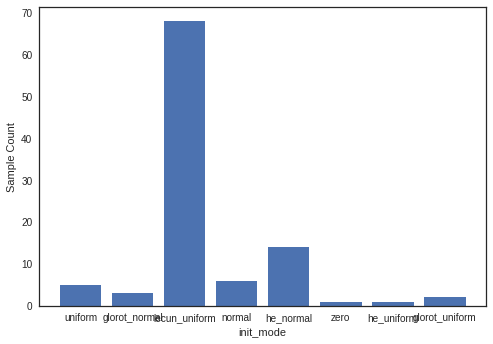

In [34]:
fig, ax = plot_histogram(result=search_result,
                        dimension_name='init_mode')

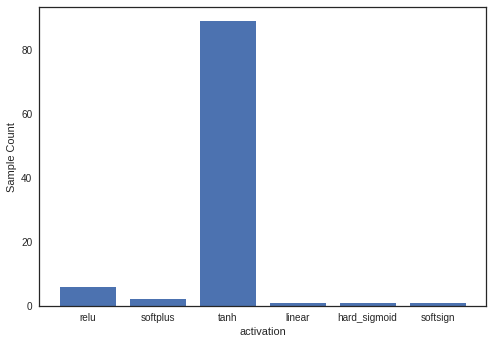

In [36]:
fig, ax = plot_histogram(result=search_result,
                        dimension_name='activation')

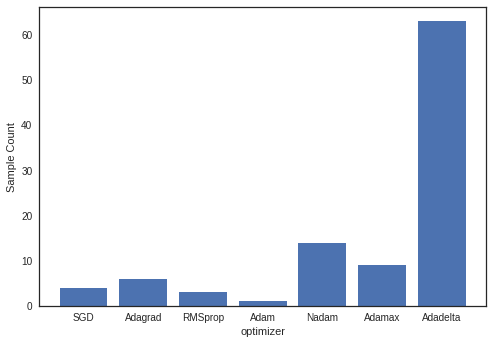

In [37]:
fig, ax = plot_histogram(result=search_result,
                        dimension_name='optimizer')

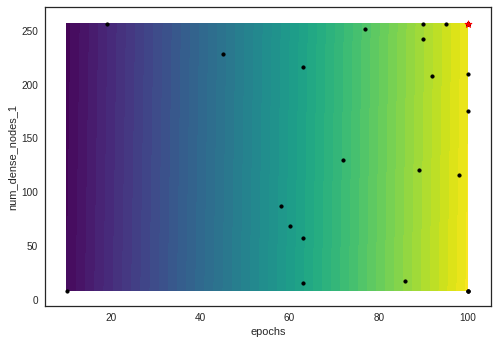

In [39]:
fig = plot_objective_2D(result=search_result,
                        dimension_name1='epochs',
                        dimension_name2='num_dense_nodes_1',
                        levels=50)

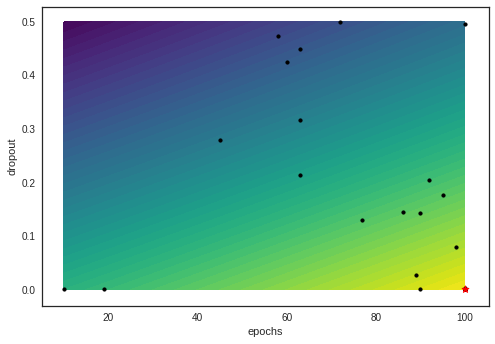

In [41]:
fig = plot_objective_2D(result=search_result,
                        dimension_name1='epochs',
                        dimension_name2='dropout',
                        levels=50)

In [0]:
dim_names = ['epochs','batch_size', 'num_dense_nodes_1', 'num_dense_nodes_2','dropout']

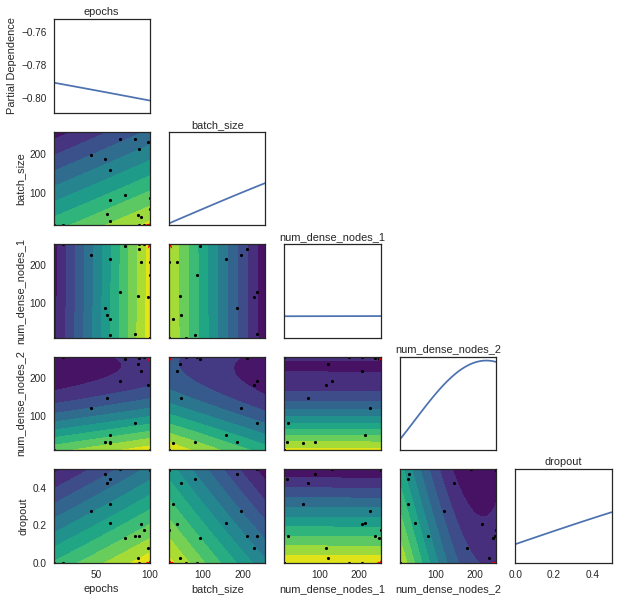

In [43]:
fig, ax = plot_objective(result=search_result, dimension_names=dim_names)

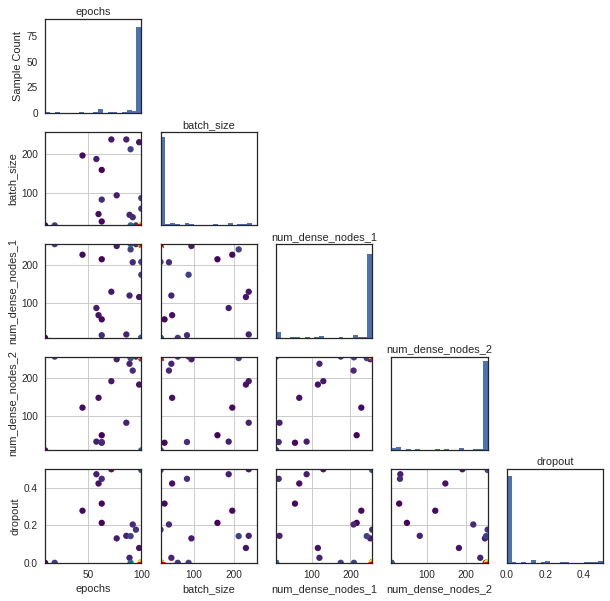

In [44]:
fig, ax = plot_evaluations(result=search_result, dimension_names=dim_names)

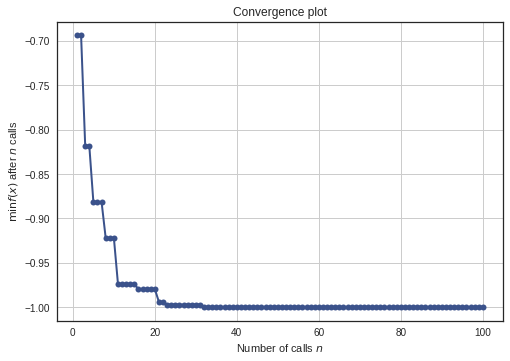

In [27]:
plot_convergence(search_result)

In [28]:
search_result.x

[100, 16, 'glorot_uniform', 'tanh', 256, 256, 0.0, 'Nadam']

In [31]:
search_result.fun

-1.0

In [0]:
model = load_model(path_best_model)

In [46]:
result = model.evaluate(X_test,y_test)

346/346 [==============================] - 0s 183us/step


In [47]:
for name, value in zip(model.metrics_names, result):
  print(name, value)

loss 0.008005162154598905
acc 1.0


In [48]:
print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))

acc: 100.00%
